In [1]:
# Celda 00 — Bootstrap, Versionado, Semillas y Rutas Base (ER_FILTER_5M_V2)
# ------------------------------------------------------------------------------------
# Objetivo:
#   - Inicializar RUN_ID, semillas aleatorias y zonas horarias.
#   - Detectar PROJECT_ROOT de forma robusta.
#   - Construir las rutas SOLO de salida del filtro:
#         outputs/er_filter_5m/<RUN_ID>/...
#   - Inicializar GLOBAL_STATE con:
#         - project_root, run_id, tz_calc, tz_print, random_seed
#         - paths (rutas de salida del ER Filter + config del RUN)
#         - config (cargado desde config/er_filter_5m.json)
#         - flags básicos y estructuras para inputs/metrics/exports, etc.
#
# NOTA IMPORTANTE (conceptual):
#   Este notebook NO genera datos de mercado:
#   asume que el Data Engine (MT5_DE_5M_V1) ya ejecutó y dejó sus PADs listos.
#   Las rutas del Data Engine (DATA_ROOT, M5_CLEAN_DIR, METADATA_DIR, etc.)
#   se resolverán en la Celda 01 a partir de PROJECT_ROOT y del config_snapshot.json.
#   Aquí SOLO se definen rutas de salida propias del ER Filter
#   y se sincroniza el config maestro → config del RUN.
#
# NOTA OPERATIVA:
#   Aunque el encabezado indique V2, este bootstrap mantiene el contrato
#   compatible con el pipeline base y NO altera nombres/paths de artefactos.
# ------------------------------------------------------------------------------------

import os
import sys
import json
import hashlib
import random
import platform
import datetime
from pathlib import Path

# -------------------------------
# Impresiones iniciales obligatorias
# -------------------------------
print("Inicializando Celda 00 (Bootstrap del ER_FILTER_5M_V2)…")

# cwd y deducción de PROJECT_ROOT (búsqueda ascendente hasta 5 niveles)
cwd = Path.cwd().resolve()
print(f"[Celda 00] cwd detectado = {str(cwd)}")

def _has_project_markers(path: Path) -> bool:
    """
    Devuelve True si el path contiene marcadores mínimos de proyecto.
    NOTA: Aquí solo buscamos estructura general; los detalles de DATA_ROOT
          se resolverán en Celda 01 (handshake con Data Engine).
    """
    markers = ["bulk_data", "processed_data", "outputs"]
    try:
        return any((path / m).exists() for m in markers)
    except Exception:
        return False

PROJECT_ROOT = cwd
if not _has_project_markers(PROJECT_ROOT):
    found = False
    probe = PROJECT_ROOT
    for _ in range(5):
        probe = probe.parent
        if _has_project_markers(probe):
            PROJECT_ROOT = probe
            found = True
            break
    if not found:
        # Se mantiene como comportamiento no bloqueante, pero se registra flag explícito.
        print("[Celda 00][WARN] No se encontraron marcadores de proyecto; PROJECT_ROOT se deja en cwd")

PROJECT_ROOT = PROJECT_ROOT.resolve()
print(f"[Celda 00] PROJECT_ROOT = {str(PROJECT_ROOT)}")

# -------------------------------
# Zonas horarias
# -------------------------------
TZ_CALC = "UTC"
TZ_PRINT = "America/Guayaquil"
print(f"[Celda 00] TZ de cálculo: {TZ_CALC} | TZ de impresión: {TZ_PRINT}")

now_utc = datetime.datetime.now(datetime.timezone.utc).replace(microsecond=0)

# zoneinfo/pytz fallback para hora local de referencia
_local_tz = None
local_iso = None
try:
    import pytz  # type: ignore
    _local_tz = pytz.timezone(TZ_PRINT)
    now_local = now_utc.astimezone(_local_tz)
    local_iso = now_local.isoformat()
except Exception:
    try:
        from zoneinfo import ZoneInfo  # py>=3.9
        _local_tz = ZoneInfo(TZ_PRINT)
        now_local = now_utc.astimezone(_local_tz)
        local_iso = now_local.isoformat()
    except Exception:
        now_local = now_utc
        local_iso = now_local.isoformat()
        print("[Celda 00][WARN] No se pudo aplicar zona horaria de impresión; usando UTC como fallback")

print(f"[Celda 00] now_utc   = {now_utc.isoformat()}")
print(f"[Celda 00] now_local = {local_iso}")

# -------------------------------
# RUN_ID (UTC) y RANDOM_SEED
# -------------------------------
RUN_ID = now_utc.strftime("%Y%m%d_%H%M%S")
print(f"[Celda 00] RUN_ID = {RUN_ID}")

env_seed = os.getenv("ER_FILTER_RANDOM_SEED", "").strip()
if env_seed != "":
    try:
        RANDOM_SEED = int(env_seed)
    except Exception:
        raise RuntimeError(f"[Celda 00][ERROR] Variable de entorno ER_FILTER_RANDOM_SEED inválida: {env_seed!r}")
else:
    # SEED derivada del RUN_ID -> reproducible por run
    h = hashlib.sha256(RUN_ID.encode("utf-8")).digest()
    RANDOM_SEED = int.from_bytes(h[:4], "big")  # 32 bits reproducibles por RUN_ID

# Semillas reproducibles (random + numpy si está disponible)
random.seed(RANDOM_SEED)
try:
    import numpy as np  # type: ignore
    np.random.seed(RANDOM_SEED)
    print(f"[Celda 00] RANDOM_SEED = {RANDOM_SEED} | NUMPY_SEED = {RANDOM_SEED}")
except Exception:
    print(f"[Celda 00] RANDOM_SEED = {RANDOM_SEED}")

# -------------------------------
# Estructura de carpetas de salida del ER Filter
# -------------------------------
# IMPORTANTE:
#   Estas rutas pertenecen EXCLUSIVAMENTE al ER_FILTER_5M_V2.
#   NO son rutas del Data Engine; las rutas del Data Engine se obtendrán
#   en la Celda 01 vía PROJECT_ROOT + config_snapshot.json.
OUT_ROOT        = (PROJECT_ROOT / "outputs" / "er_filter_5m" / RUN_ID).resolve()
OUT_LOGS_DIR    = (OUT_ROOT / "logs").resolve()
OUT_DIAG_DIR    = (OUT_ROOT / "diagnostics").resolve()
OUT_METRICS_DIR = (OUT_ROOT / "metrics").resolve()
OUT_EVENTS_DIR  = (OUT_ROOT / "events").resolve()
OUT_STAB_DIR    = (OUT_ROOT / "stability").resolve()
OUT_SCORES_DIR  = (OUT_ROOT / "scores").resolve()
OUT_BASKETS_DIR = (OUT_ROOT / "baskets").resolve()
OUT_EXPORTS_DIR = (OUT_ROOT / "exports").resolve()
OUT_REPORTS_DIR = (OUT_ROOT / "reports").resolve()

_dirs = [
    OUT_ROOT,
    OUT_LOGS_DIR,
    OUT_DIAG_DIR,
    OUT_METRICS_DIR,
    OUT_EVENTS_DIR,
    OUT_STAB_DIR,
    OUT_SCORES_DIR,
    OUT_BASKETS_DIR,
    OUT_EXPORTS_DIR,
    OUT_REPORTS_DIR,
]

print("[Celda 00] Creando estructura de carpetas de salida del ER Filter…")
for d in _dirs:
    try:
        d.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        raise RuntimeError(f"[Celda 00][ERROR] Cannot create directory: {str(d)} | reason={e}")

for d in _dirs:
    if not d.exists() or not d.is_dir():
        raise RuntimeError(f"[Celda 00][ERROR] Directory check failed: {str(d)}")

# -------------------------------
# GLOBAL_STATE (mínimo requerido + estructura base)
# -------------------------------
# NOTA:
#   - GLOBAL_STATE["paths"] contiene SOLO rutas de salida del ER Filter + config del RUN.
#   - Las rutas del Data Engine (DATA_ROOT, M5_CLEAN_DIR, METADATA_DIR, etc.)
#     se rellenarán en Celda 01 dentro de GLOBAL_STATE["inputs"].
GLOBAL_STATE = {
    "project_root": str(PROJECT_ROOT),
    "run_id": RUN_ID,
    "tz_calc": TZ_CALC,
    "tz_print": TZ_PRINT,
    "random_seed": RANDOM_SEED,
    "paths": {
        "out_root": str(OUT_ROOT),
        "logs": str(OUT_LOGS_DIR),
        "diagnostics": str(OUT_DIAG_DIR),
        "metrics": str(OUT_METRICS_DIR),
        "events": str(OUT_EVENTS_DIR),
        "stability": str(OUT_STAB_DIR),
        "scores": str(OUT_SCORES_DIR),
        "baskets": str(OUT_BASKETS_DIR),
        "exports": str(OUT_EXPORTS_DIR),
        "reports": str(OUT_REPORTS_DIR),
        # "config" se añadirá justo después de sincronizar el maestro → RUN
    },
    # Config del ER Filter (se cargará aquí desde config/er_filter_5m.json)
    "config": {},
    # Flags generales de estado de ejecución del notebook
    "flags": {
        "initialized": True,               # Celda 00 completada
        "handshake_done": False,           # Se pondrá True en Celda 01
        "project_markers_found": _has_project_markers(PROJECT_ROOT),
        "config_master_autogenerated": False,
    },
    # Estructuras que se irán rellenando en celdas posteriores
    "inputs": {},    # Handshake con Data Engine (Celda 01)
    "tables": {},    # Tablas intermedias del ER Filter
    "symbols": {},   # Listas de símbolos (eligible_m5, universe, watchlist, etc.)
    "metrics": {},   # Rutas de métricas clave (ER, PD, estabilidad, scores…)
    "exports": {},   # Artefactos preparados para EAs
    "baskets": {},   # Info de cestas decorrelacionadas
    "reports": {},   # Rutas a reportes HTML/otros
}

# -------------------------------
# Sincronizar config maestro → config del RUN
#   - Si no existe config/er_filter_5m.json, se crea un config por defecto (PC "virgen").
# -------------------------------
print("[Celda 00] Sincronizando config maestro → config del RUN…")

CONFIG_DIR = (PROJECT_ROOT / "config").resolve()
CONFIG_DIR.mkdir(parents=True, exist_ok=True)

base_cfg_path = CONFIG_DIR / "er_filter_5m.json"
run_cfg_path = OUT_DIAG_DIR / "config.json"

def _build_default_config() -> dict:
    """
    Construye un config mínimo pero funcional para una máquina 'virgen'.
    Los valores son conservadores y deberán ajustarse más adelante,
    pero permiten que el notebook se ejecute de principio a fin.
    """
    return {
        "policy": {
            # Umbrales genéricos; se ajustan en runs reales
            "min_TR_after_cost_trend": 0.55,
            "min_TR_after_cost_range": 0.55,
        },
        "stats": {
            "alpha_strict": 0.01,
            "alpha_balanced": 0.05,
            "alpha_loose": 0.10,
            "n_eff_cap_PD": 200,
            "n_eff_cap_p_event": 200,
            "n_eff_cap_ER": 200,
        },
        "ER": {
            "window": 50,
        },
        "PD": {
            "window": 50,
        },
        "hysteresis": {
            "pctile_delta": 5.0,
        },
        "decay": {
            # parámetros de alpha decay se pueden completar más adelante
        },
        "corr": {
            "threshold": 0.8,
        },
        "folds": {
            "n_folds": 4,
        },
        "baskets": {
            "size_max": 10,
        },
        "selection": {
            # thresholds de SCORE_FINAL, EstabScore, etc. se afinan luego
        },
        "session": {
            # parámetros de sesiones/ventanas horarias si aplica
        },
        "meta": {
            "config_version": "auto_default_v1",
            "created_utc": now_utc.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "notes": "Config generado automáticamente por Celda 00 en ausencia de er_filter_5m.json",
        },
        "structure": {
            "enabled": True,
            "min_events_per_symbol": 100,
        },
        "stability": {
            "EstabScore_min": 0.4,
        },
        "viability": {
            "score_viability_min": 0.3,
        },
    }

if not base_cfg_path.exists():
    # PC virgen → generar config maestro por defecto
    print(f"[Celda 00][WARN] Config maestro no encontrado: {base_cfg_path}")
    print("[Celda 00] Generando config maestro por defecto (auto_default_v1)…")
    base_cfg = _build_default_config()
    GLOBAL_STATE["flags"]["config_master_autogenerated"] = True
    try:
        base_cfg_path.write_text(json.dumps(base_cfg, ensure_ascii=False, indent=2), encoding="utf-8")
        print(f"[Celda 00] Config maestro por defecto escrito en: {str(base_cfg_path)}")
    except Exception as e:
        raise RuntimeError(
            f"[Celda 00][ERROR] No se pudo escribir config maestro por defecto en {base_cfg_path} | reason={e}"
        )
else:
    # *** FIX UTF-8 BOM ***
    try:
        # utf-8-sig elimina el BOM si existe (como en archivos escritos por PowerShell con UTF8)
        base_cfg_text = base_cfg_path.read_text(encoding="utf-8-sig")
        base_cfg = json.loads(base_cfg_text)
        print(f"[Celda 00] Config maestro encontrado y cargado desde: {str(base_cfg_path)}")
    except Exception as e:
        raise RuntimeError(f"[Celda 00][ERROR] No se pudo leer/parsear el config maestro {base_cfg_path} | reason={e}")

# Escribir config del RUN (copia exacta del maestro en este momento)
try:
    run_cfg_path.write_text(json.dumps(base_cfg, ensure_ascii=False, indent=2), encoding="utf-8")
except Exception as e:
    raise RuntimeError(f"[Celda 00][ERROR] No se pudo escribir config del RUN en {run_cfg_path} | reason={e}")

if not run_cfg_path.exists() or run_cfg_path.stat().st_size <= 0:
    raise RuntimeError("[Celda 00][ERROR] config.json del RUN no existe o está vacío tras la escritura")

GLOBAL_STATE["paths"]["config"] = str(run_cfg_path)
GLOBAL_STATE["config"] = base_cfg

print(f"[Celda 00] Config maestro  → {str(base_cfg_path)}")
print(f"[Celda 00] Config del RUN → {str(run_cfg_path)}")

# -------------------------------
# Validación de GLOBAL_STATE["paths"]
# -------------------------------
required_path_keys = {
    "out_root",
    "logs",
    "diagnostics",
    "metrics",
    "events",
    "stability",
    "scores",
    "baskets",
    "exports",
    "reports",
    "config",
}
paths_dict = GLOBAL_STATE.get("paths", {}) or {}
missing_keys = required_path_keys - set(paths_dict.keys())
if missing_keys:
    raise RuntimeError(
        f"[Celda 00][ERROR] GLOBAL_STATE['paths'] es incompleto; faltan claves: {sorted(missing_keys)}"
    )

# -------------------------------
# Persistir logs/run_metadata.json
# -------------------------------
run_metadata = {
    "run_id": RUN_ID,
    "created_utc": now_utc.strftime("%Y-%m-%dT%H:%M:%SZ"),
    "created_local": local_iso,
    "tz_calc": TZ_CALC,
    "tz_print": TZ_PRINT,
    "project_root": str(PROJECT_ROOT),
    "out_root": str(OUT_ROOT),
    "paths": GLOBAL_STATE["paths"],
    "random_seed": RANDOM_SEED,
    "python_version": sys.version,
    "platform": {
        "system": platform.system(),
        "release": platform.release(),
        "machine": platform.machine(),
        "python_implementation": platform.python_implementation(),
    },
    "packages": {
        "polars": None,   # se rellenan más abajo
        "pandas": None,
        "numpy": None,
        "scipy": None,
        "pyarrow": None,
    },
    "notes": {
        "role": "ER_FILTER_5M_V2 bootstrap",
        "data_engine_dependency": (
            "Este notebook NO genera datos de mercado; depende del Data Engine "
            "MT5_DE_5M_V1 y de sus PADs (config_snapshot, índices M5, etc.)."
        ),
        "config_master": str(base_cfg_path),
        "config_run": str(run_cfg_path),
        "config_master_autogenerated": bool(GLOBAL_STATE["flags"].get("config_master_autogenerated", False)),
        "project_markers_found": bool(GLOBAL_STATE["flags"].get("project_markers_found", False)),
    },
}

# Versiones de librerías clave (se rellenan ahora)
def _safe_version(modname: str):
    try:
        mod = __import__(modname)
        ver = getattr(mod, "__version__", None)
        return ver if isinstance(ver, str) else str(ver) if ver is not None else None
    except Exception:
        return None

ver_polars = _safe_version("polars")
ver_pandas = _safe_version("pandas")
ver_numpy = _safe_version("numpy")
ver_scipy = _safe_version("scipy")
ver_pyarrow = _safe_version("pyarrow")

run_metadata["packages"]["polars"] = ver_polars
run_metadata["packages"]["pandas"] = ver_pandas
run_metadata["packages"]["numpy"] = ver_numpy
run_metadata["packages"]["scipy"] = ver_scipy
run_metadata["packages"]["pyarrow"] = ver_pyarrow

metadata_path = OUT_LOGS_DIR / "run_metadata.json"
try:
    txt = json.dumps(run_metadata, ensure_ascii=False, indent=2, sort_keys=True)
    metadata_path.write_text(txt, encoding="utf-8")
except Exception as e:
    raise RuntimeError(f"[Celda 00][ERROR] No se pudo escribir run_metadata.json en {str(metadata_path)} | reason={e}")

if not metadata_path.exists():
    raise RuntimeError("[Celda 00][ERROR] run_metadata.json no existe tras la escritura")
size_bytes = metadata_path.stat().st_size
if size_bytes <= 0:
    raise RuntimeError("[Celda 00][ERROR] run_metadata.json tiene tamaño 0")
try:
    _ = json.loads(metadata_path.read_text(encoding="utf-8"))
except Exception as e:
    raise RuntimeError(f"[Celda 00][ERROR] run_metadata.json no es legible como JSON | reason={e}")

# -------------------------------
# Impresiones finales obligatorias
# -------------------------------
print(f"[Celda 00] 📁 OUT_ROOT      → {str(OUT_ROOT)}")
print(f"[Celda 00] 📁 logs/        → {str(OUT_LOGS_DIR)}")
print(f"[Celda 00] 📁 diagnostics/ → {str(OUT_DIAG_DIR)}")
print(f"[Celda 00] 📁 metrics/     → {str(OUT_METRICS_DIR)}")
print(f"[Celda 00] 📁 events/      → {str(OUT_EVENTS_DIR)}")
print(f"[Celda 00] 📁 stability/   → {str(OUT_STAB_DIR)}")
print(f"[Celda 00] 📁 scores/      → {str(OUT_SCORES_DIR)}")
print(f"[Celda 00] 📁 baskets/     → {str(OUT_BASKETS_DIR)}")
print(f"[Celda 00] 📁 exports/     → {str(OUT_EXPORTS_DIR)}")
print(f"[Celda 00] 📁 reports/     → {str(OUT_REPORTS_DIR)}")
print(f"[Celda 00] 📁 config_run/  → {str(run_cfg_path)}")
print(f"[Celda 00] 💾 run_metadata → {str(metadata_path)} (OK, bytes={size_bytes})")

py_short = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
print(
    "[Celda 00] Resumen: "
    f"RUN_ID={RUN_ID} | RANDOM_SEED={RANDOM_SEED} | Python={py_short} | "
    f"polars={ver_polars} | pandas={ver_pandas} | numpy={ver_numpy} | "
    f"scipy={ver_scipy} | pyarrow={ver_pyarrow}"
)

print(">>> Celda 00 :: OK")


Inicializando Celda 00 (Bootstrap del ER_FILTER_5M_V2)…
[Celda 00] cwd detectado = C:\Quant\MT5_Data_Extraction
[Celda 00] PROJECT_ROOT = C:\Quant\MT5_Data_Extraction
[Celda 00] TZ de cálculo: UTC | TZ de impresión: America/Guayaquil
[Celda 00] now_utc   = 2025-12-18T19:08:10+00:00
[Celda 00] now_local = 2025-12-18T14:08:10-05:00
[Celda 00] RUN_ID = 20251218_190810
[Celda 00] RANDOM_SEED = 32919305 | NUMPY_SEED = 32919305
[Celda 00] Creando estructura de carpetas de salida del ER Filter…
[Celda 00] Sincronizando config maestro → config del RUN…
[Celda 00] Config maestro encontrado y cargado desde: C:\Quant\MT5_Data_Extraction\config\er_filter_5m.json
[Celda 00] Config maestro  → C:\Quant\MT5_Data_Extraction\config\er_filter_5m.json
[Celda 00] Config del RUN → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\config.json
[Celda 00] 📁 OUT_ROOT      → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810
[Celda 00] 📁 logs/        → C:\Quant\MT5_Data

In [2]:
# Celda 01 — Handshake con Data Engine (PAD-aware + config_snapshot.json) — ER_FILTER_5M_V2
# ------------------------------------------------------------------------------------
# Objetivo:
#   - Leer PROJECT_ROOT y config desde GLOBAL_STATE (Celda 00).
#   - Validar y estructurar GLOBAL_STATE["config"] en secciones:
#       * policy  → reglas de negocio (spreads máximos, comisiones, sesiones, etc.).
#       * stats   → parámetros estadísticos (alphas, caps de n_eff, cuantiles IS/OOS, etc.).
#       * scores  → pesos para scoring y selección.
#       * baskets → reglas/parametrización de cestas.
#   - TODOS los thresholds de p-values, caps de n_eff, bandas de oportunidad, etc.
#     deben leerse SIEMPRE desde GLOBAL_STATE["config"]["stats"] en celdas posteriores.
#   - Intentar leer data/metadata/config_snapshot.json generado por MT5_DE_5M_V1.
#   - A partir de ese snapshot, obtener rutas canónicas:
#         DATA_ROOT, METADATA_DIR, M5_CLEAN_DIR, PROCESSED_DATA_DIR, M5_RAW_DIR (si existe).
#     Si no existe el snapshot, usar layout por defecto PROJECT_ROOT/data/...
#   - Detectar la fuente M5 con prioridad:
#         1) historical_data/m5_clean (si tiene parquet)  → GOLD
#         2) bulk_data/m5_raw
#         3) restore/*/historical_data/m5_clean (último restore)
#   - Hacer QA básico: ticks, cobertura, frescura de timestamps (SOLO DIAGNÓSTICO).
#   - Persistir diagnostics/handshake_summary.json.
#   - Actualizar GLOBAL_STATE["inputs"] con:
#         DATA_ROOT, METADATA_DIR, M5_CLEAN_DIR, PROCESSED_DATA_DIR,
#         M5_SOURCE_TYPE, M5_ROOT_DIR, PADs y artefactos auxiliares.
#   - Actualizar GLOBAL_STATE["paths"]["metadata"] para que el ER Filter pueda
#     localizar artefactos del Data Engine (data_quality, universe_snapshot, etc.).
#   - Registrar un resumen compacto en GLOBAL_STATE["data_engine"].
#
# Cambios estructurales aplicados (versión final):
#   1) Mensajes de ausencia de artefactos OPCIONALES (ticks QC, watchlist/params)
#      pasan de [WARN] → [INFO] para evitar falsos “alertas” en un flujo sano.
#   2) Se mantiene toda la lógica de selección y QA sin cambiar contratos ni paths.
# ------------------------------------------------------------------------------------

import json
import os
from pathlib import Path
from datetime import datetime, timedelta, timezone

import polars as pl  # Para lecturas de parquet en checks

# -------------------------------
# Validaciones de estado previo
# -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 01] GLOBAL_STATE no existe. Debes ejecutar primero la Celda 00 (Bootstrap).")

if "project_root" not in GLOBAL_STATE or "paths" not in GLOBAL_STATE:
    raise RuntimeError("[Celda 01] GLOBAL_STATE incompleto: faltan claves 'project_root' o 'paths'.")

PROJECT_ROOT = Path(GLOBAL_STATE["project_root"]).resolve()
OUT_DIAG_DIR = Path(GLOBAL_STATE["paths"]["diagnostics"]).resolve()

print("Inicializando Celda 01 (Handshake con Data Engine)…")
print(f"[Celda 01] PROJECT_ROOT (desde GLOBAL_STATE) = {str(PROJECT_ROOT)}")

# -------------------------------
# Lectura y validación de config del ER Filter
# -------------------------------
cfg = GLOBAL_STATE.get("config", {})
if not isinstance(cfg, dict) or not cfg:
    raise RuntimeError(
        "[Celda 01] GLOBAL_STATE['config'] no está inicializado o no es un dict. "
        "Revisa la Celda 00 y el archivo config/er_filter_5m.json."
    )

# Asegurar secciones principales
cfg_policy  = cfg.setdefault("policy", {})    # reglas de negocio: spreads, comisiones, sesiones, etc.
cfg_stats   = cfg.setdefault("stats", {})     # parámetros estadísticos: alphas, caps n_eff, cuantiles, etc.
cfg_scores  = cfg.setdefault("scores", {})    # pesos para scoring y selección
cfg_baskets = cfg.setdefault("baskets", {})   # reglas/parametrización de cestas

# Claves base para volúmenes y volatilidad
# NOTA:
#   En un entorno "production-grade", estas claves deben venir explícitas
#   en config/er_filter_5m.json. Si faltan, se inicializan de forma conservadora.
if "volume_min_notional" not in cfg_stats:
    cfg_stats["volume_min_notional"] = 0.0
    print(
        "[Celda 01][INFO] 'stats.volume_min_notional' no encontrado en config; "
        "inicializado a 0.0 (sin filtro mínimo de volumen/notional). "
        "Ajusta este valor en config/er_filter_5m.json si deseas un umbral institucional."
    )

if "volatility_band_refs" not in cfg_stats:
    cfg_stats["volatility_band_refs"] = {"low": None, "medium": None, "high": None}
    print(
        "[Celda 01][INFO] 'stats.volatility_band_refs' no encontrado en config; "
        "inicializado con placeholders {low, medium, high} = None. "
        "Define bandas numéricas en config/er_filter_5m.json para usarlas en filtros suaves de volatilidad."
    )

# Umbrales de cobertura y QA básicos (centralizados en config.stats)
if "coverage_pct_min" not in cfg_stats:
    cfg_stats["coverage_pct_min"] = 30.0
    print(
        "[Celda 01][INFO] 'stats.coverage_pct_min' no encontrado en config; "
        "inicializado a 30.0 (% de días con datos). Ajusta en er_filter_5m.json si lo deseas."
    )

if "coverage_min_symbols" not in cfg_stats:
    cfg_stats["coverage_min_symbols"] = 50
    print(
        "[Celda 01][INFO] 'stats.coverage_min_symbols' no encontrado en config; "
        "inicializado a 50 símbolos. Ajusta en er_filter_5m.json si lo deseas."
    )

if "max_spread_p99_pts" not in cfg_stats:
    cfg_stats["max_spread_p99_pts"] = 99.0
    print(
        "[Celda 01][INFO] 'stats.max_spread_p99_pts' no encontrado en config; "
        "inicializado a 99.0 puntos. Ajusta este umbral de spreads en er_filter_5m.json."
    )

if "max_tick_anomalies_pct" not in cfg_stats:
    cfg_stats["max_tick_anomalies_pct"] = 5.0
    print(
        "[Celda 01][INFO] 'stats.max_tick_anomalies_pct' no encontrado en config; "
        "inicializado a 5.0 (%). Ajusta este umbral de anomalías de ticks en er_filter_5m.json."
    )

# 🔴 Filtro de frescura: por defecto desactivado (0 días) → SOLO diagnóstico
if "max_data_age_days" not in cfg_stats:
    cfg_stats["max_data_age_days"] = 0
    print(
        "[Celda 01][INFO] 'stats.max_data_age_days' no encontrado en config; "
        "inicializado a 0 (sin filtro duro de frescura; solo diagnóstico si lo configuras > 0)."
    )

# Persistir cambios en memoria
GLOBAL_STATE["config"] = cfg

print(
    "[Celda 01] Secciones de config detectadas: "
    f"policy={bool(cfg_policy)}, stats={bool(cfg_stats)}, "
    f"scores={bool(cfg_scores)}, baskets={bool(cfg_baskets)}"
)
print(
    "[Celda 01] stats.volume_min_notional = "
    f"{cfg_stats.get('volume_min_notional')}, "
    "stats.volatility_band_refs = "
    f"{cfg_stats.get('volatility_band_refs')}"
)
print(
    "[Celda 01] QA thresholds → "
    f"coverage_pct_min={cfg_stats.get('coverage_pct_min')}%, "
    f"coverage_min_symbols={cfg_stats.get('coverage_min_symbols')}, "
    f"max_spread_p99_pts={cfg_stats.get('max_spread_p99_pts')}, "
    f"max_tick_anomalies_pct={cfg_stats.get('max_tick_anomalies_pct')}%, "
    f"max_data_age_days={cfg_stats.get('max_data_age_days')}"
)

# -------------------------------
# Paso 0: Leer config_snapshot.json si existe
# -------------------------------
CONFIG_SNAPSHOT_PATH = (PROJECT_ROOT / "data" / "metadata" / "config_snapshot.json").resolve()

# Layout por defecto (fallback) si no hay snapshot
DATA_ROOT          = (PROJECT_ROOT / "data").resolve()
METADATA_DIR       = (DATA_ROOT / "metadata").resolve()
M5_CLEAN_DIR       = (DATA_ROOT / "historical_data" / "m5_clean").resolve()
PROCESSED_DATA_DIR = (DATA_ROOT / "processed_data").resolve()
M5_RAW_DIR         = (DATA_ROOT / "bulk_data" / "m5_raw").resolve()

if CONFIG_SNAPSHOT_PATH.exists() and CONFIG_SNAPSHOT_PATH.is_file():
    print(f"[Celda 01] ✅ config_snapshot.json detectado en: {str(CONFIG_SNAPSHOT_PATH)}")
    try:
        snap = json.loads(CONFIG_SNAPSHOT_PATH.read_text(encoding="utf-8"))
        paths_cfg = snap.get("dataset", {}).get("paths", {})

        if "DATA_ROOT" in paths_cfg:
            DATA_ROOT = Path(paths_cfg["DATA_ROOT"]).resolve()
        if "METADATA_DIR" in paths_cfg:
            METADATA_DIR = Path(paths_cfg["METADATA_DIR"]).resolve()
        if "M5_CLEAN_DIR" in paths_cfg:
            M5_CLEAN_DIR = Path(paths_cfg["M5_CLEAN_DIR"]).resolve()
        if "PROCESSED_DATA_DIR" in paths_cfg:
            PROCESSED_DATA_DIR = Path(paths_cfg["PROCESSED_DATA_DIR"]).resolve()
        if "M5_RAW_DIR" in paths_cfg:
            M5_RAW_DIR = Path(paths_cfg["M5_RAW_DIR"]).resolve()

        print("[Celda 01] Rutas derivadas de config_snapshot.json:")
        print(f"  • DATA_ROOT          = {str(DATA_ROOT)}")
        print(f"  • METADATA_DIR       = {str(METADATA_DIR)}")
        print(f"  • M5_CLEAN_DIR       = {str(M5_CLEAN_DIR)}")
        print(f"  • PROCESSED_DATA_DIR = {str(PROCESSED_DATA_DIR)}")
        print(f"  • M5_RAW_DIR         = {str(M5_RAW_DIR)}")
    except Exception as e:
        print(f"[Celda 01][WARN] Error leyendo config_snapshot.json ({e!r}).")
        print("             Se usará layout por defecto PROJECT_ROOT/data/...")
else:
    print("[Celda 01][WARN] config_snapshot.json NO encontrado.")
    print("             Se utilizará el layout por defecto PROJECT_ROOT/data/...")

# -------------------------------
# Definición de rutas candidatas (M5), alineadas con MT5_DE
# -------------------------------
DE_M5_RAW_DIR         = M5_RAW_DIR.resolve()
PAD_HIST_CLEAN_DIR    = M5_CLEAN_DIR.resolve()
PAD_RESTORE_ROOT      = (DATA_ROOT / "restore").resolve()
PAD_META_DIR          = METADATA_DIR.resolve()
PAD_DAY_INDEX         = (PAD_META_DIR / "day_index_m5.parquet").resolve()
PAD_SYMBOL_INDEX      = (PAD_META_DIR / "symbol_index_m5.parquet").resolve()
PAD_WINDOW_CATALOG    = (PAD_META_DIR / "window_catalog_m5.parquet").resolve()
PAD_MANIFEST          = (PAD_META_DIR / "m5_manifest.parquet").resolve()
PAD_DATASET_CATALOG   = (PAD_META_DIR / "dataset_catalog.parquet").resolve()
TICKS_QC_SUMMARY_JSON = (PAD_META_DIR / "ticks_recent_qc_summary.json").resolve()

DE_CORR_M5_FILE           = (PROCESSED_DATA_DIR / "corr_matrix_5m.csv").resolve()
DE_UNIVERSE_FILE          = (PROCESSED_DATA_DIR / "universe_ranked.parquet").resolve()
DE_WATCHLIST_FILE         = (DATA_ROOT / "ea_watchlist.parquet").resolve()
DE_WATCHLIST_FALLBACK_CSV = (DATA_ROOT / "ea_watchlist.csv").resolve()
DE_PARAMS_FILE            = (DATA_ROOT / "ea_params.parquet").resolve()
DE_PARAMS_FALLBACK_CSV    = (DATA_ROOT / "ea_params.csv").resolve()

# -------------------------------
# Utilidades
# -------------------------------
def _bool(b) -> str:
    return "true" if bool(b) else "false"

def _count_parquet_recursive(dir_path: Path, max_files: int = 10_000_000) -> int:
    if not dir_path.exists() or not dir_path.is_dir():
        return 0
    n = 0
    for p in dir_path.rglob("*.parquet"):
        if p.is_file():
            n += 1
            if n >= max_files:
                break
    return n

def _latest_restore_m5_clean(restore_root: Path) -> Path | None:
    """
    Devuelve el subdirectorio 'historical_data/m5_clean' dentro del restore más reciente,
    si existe alguno con ese layout.
    """
    if not restore_root.exists() or not restore_root.is_dir():
        return None
    restore_dirs = [d for d in restore_root.iterdir() if d.is_dir() and d.name.lower().startswith("restore_")]
    if not restore_dirs:
        return None
    restore_dirs.sort(key=lambda d: d.stat().st_mtime, reverse=True)
    for d in restore_dirs:
        candidate = d / "historical_data" / "m5_clean"
        if candidate.exists() and candidate.is_dir():
            return candidate.resolve()
    return None

def _detect_partitioned_symbols(m5_root: Path, max_symbols: int = 10_000) -> list[str]:
    symbols: list[str] = []
    if m5_root.exists() and m5_root.is_dir():
        for sub in m5_root.glob("symbol=*"):
            if sub.is_dir():
                sym = sub.name.split("symbol=", 1)[-1].strip()
                if sym:
                    symbols.append(sym)
                    if len(symbols) >= max_symbols:
                        break
    return symbols

def _detect_flat_symbols(m5_dir: Path, max_symbols: int = 100_000) -> list[str]:
    symbols: list[str] = []
    if m5_dir.exists() and m5_dir.is_dir():
        for p in m5_dir.glob("*.parquet"):
            if p.is_file():
                sym = p.stem.strip()
                if sym:
                    symbols.append(sym)
                    if len(symbols) >= max_symbols:
                        break
    return symbols

# -------------------------------
# Handshake
# -------------------------------
print(">>> Celda 01 :: Handshake con Data Engine")

# 1) Reportar layout m5_raw (detecta flat/partitioned)
m5_raw_exists         = DE_M5_RAW_DIR.exists() and DE_M5_RAW_DIR.is_dir()
m5_raw_is_partitioned = m5_raw_exists and len(list(DE_M5_RAW_DIR.glob("symbol=*"))) > 0
m5_raw_parquet_count  = _count_parquet_recursive(DE_M5_RAW_DIR) if m5_raw_exists else 0
print(
    f"📁 INPUT m5_raw → {str(DE_M5_RAW_DIR)} "
    f"(parquet_files={m5_raw_parquet_count}, partitioned={_bool(m5_raw_is_partitioned)})"
)

# 2) PADs reales (partitionado y restore) → GOLD principal
part_exists           = PAD_HIST_CLEAN_DIR.exists() and PAD_HIST_CLEAN_DIR.is_dir()
part_parquet_count    = _count_parquet_recursive(PAD_HIST_CLEAN_DIR) if part_exists else 0
latest_restore_m5     = _latest_restore_m5_clean(PAD_RESTORE_ROOT)
restore_exists        = latest_restore_m5 is not None
restore_parquet_count = _count_parquet_recursive(latest_restore_m5) if restore_exists else 0

print(
    f"📁 Layout M5_CLEAN_DIR → {str(PAD_HIST_CLEAN_DIR)} "
    f"(exists={_bool(part_exists)}, parquet_files={part_parquet_count})"
)
print(
    f"📁 Layout RESTORE m5   → {str(latest_restore_m5) if restore_exists else '(none)'} "
    f"(exists={_bool(restore_exists)}, parquet_files={restore_parquet_count})"
)

# 3) Metadata PADs
PAD_DAY_INDEX      = PAD_DAY_INDEX.resolve()
PAD_SYMBOL_INDEX   = PAD_SYMBOL_INDEX.resolve()
PAD_WINDOW_CATALOG = PAD_WINDOW_CATALOG.resolve()

day_index_found      = PAD_DAY_INDEX.exists() and PAD_DAY_INDEX.is_file()
symbol_index_found   = PAD_SYMBOL_INDEX.exists() and PAD_SYMBOL_INDEX.is_file()
window_catalog_found = PAD_WINDOW_CATALOG.exists() and PAD_WINDOW_CATALOG.is_file()
manifest_found       = PAD_MANIFEST.exists() and PAD_MANIFEST.is_file()
catalog_found        = PAD_DATASET_CATALOG.exists() and PAD_DATASET_CATALOG.is_file()

print(f"📁 META → {str(PAD_SYMBOL_INDEX)} (found={_bool(symbol_index_found)})")
print(f"📁 META → {str(PAD_DAY_INDEX)} (found={_bool(day_index_found)})")
print(f"📁 META → {str(PAD_WINDOW_CATALOG)} (found={_bool(window_catalog_found)})")
print(f"📁 META → {str(PAD_MANIFEST)} (found={_bool(manifest_found)})")
print(f"📁 META → {str(PAD_DATASET_CATALOG)} (found={_bool(catalog_found)})")

# 4) Artefactos auxiliares
corr_found     = DE_CORR_M5_FILE.exists() and DE_CORR_M5_FILE.is_file()
universe_found = DE_UNIVERSE_FILE.exists() and DE_UNIVERSE_FILE.is_file()
print(f"📁 INPUT → {str(DE_CORR_M5_FILE)} (found={_bool(corr_found)})")
print(f"📁 INPUT → {str(DE_UNIVERSE_FILE)} (found={_bool(universe_found)})")

watchlist_found     = DE_WATCHLIST_FILE.exists() and DE_WATCHLIST_FILE.is_file()
watchlist_csv_found = DE_WATCHLIST_FALLBACK_CSV.exists() and DE_WATCHLIST_FALLBACK_CSV.is_file()
print(
    f"📁 INPUT → {str(DE_WATCHLIST_FILE)} "
    f"(found={_bool(watchlist_found)}, fallback_csv={_bool(watchlist_csv_found)})"
)

params_found     = DE_PARAMS_FILE.exists() and DE_PARAMS_FILE.is_file()
params_csv_found = DE_PARAMS_FALLBACK_CSV.exists() and DE_PARAMS_FALLBACK_CSV.is_file()
print(
    f"📁 INPUT → {str(DE_PARAMS_FILE)} "
    f"(found={_bool(params_found)}, fallback_csv={_bool(params_csv_found)})"
)

if not corr_found:
    print("⚠️ FALLBACK → correlación M5 será reconstruida")

# -------------------------------
# Selección determinística de fuente M5
# -------------------------------
M5_SOURCE_TYPE         = None
M5_ROOT_DIR            = None
symbols_detected: list[str] = []
parquet_count_selected = 0

if part_exists and part_parquet_count > 0:
    M5_SOURCE_TYPE = "partitioned_m5_clean"
    M5_ROOT_DIR    = PAD_HIST_CLEAN_DIR
    symbols_detected = _detect_partitioned_symbols(PAD_HIST_CLEAN_DIR)
    parquet_count_selected = part_parquet_count
elif m5_raw_exists and m5_raw_parquet_count > 0:
    if m5_raw_is_partitioned:
        M5_SOURCE_TYPE = "partitioned_m5_raw"
        symbols_detected = _detect_partitioned_symbols(DE_M5_RAW_DIR)
    else:
        M5_SOURCE_TYPE = "flat_m5_raw"
        symbols_detected = _detect_flat_symbols(DE_M5_RAW_DIR)
    M5_ROOT_DIR = DE_M5_RAW_DIR
    parquet_count_selected = m5_raw_parquet_count
elif restore_exists and restore_parquet_count > 0:
    M5_SOURCE_TYPE = "restore_partitioned_m5_clean"
    M5_ROOT_DIR    = latest_restore_m5
    symbols_detected = _detect_partitioned_symbols(latest_restore_m5)
    parquet_count_selected = restore_parquet_count

# Validación mínima: si no hay ninguna fuente, fallar de forma amigable
if M5_SOURCE_TYPE is None or M5_ROOT_DIR is None:
    print("[Celda 01][ERROR] No se encontró ninguna fuente M5 válida.")
    print(f"  • M5_CLEAN_DIR: exists={_bool(part_exists)}, parquet_files={part_parquet_count}")
    print(f"  • m5_raw:       exists={_bool(m5_raw_exists)}, parquet_files={m5_raw_parquet_count}")
    print(f"  • RESTORE m5:   exists={_bool(restore_exists)}, parquet_files={restore_parquet_count}")
    raise RuntimeError(
        "No se encontró ninguna fuente M5 válida. "
        "Verifica que MT5_DE_5M_V1 haya generado historical_data/m5_clean, "
        "o que exista bulk_data/m5_raw, o un restore reciente."
    )

print(
    f"🔎 Fuente M5 seleccionada → type={M5_SOURCE_TYPE} | "
    f"root={str(M5_ROOT_DIR)} | parquet_files={parquet_count_selected}"
)
n_syms      = len(symbols_detected)
sample_syms = symbols_detected[:10]
print(f"🧾 Símbolos detectados (antes de QA) = {n_syms} | muestra={sample_syms}")

# -------------------------------
# QA ticks: spreads y anomalías
# -------------------------------
spread_threshold = float(cfg_stats.get("max_spread_p99_pts", 99.0))
max_anom_pct     = float(cfg_stats.get("max_tick_anomalies_pct", 5.0))

if TICKS_QC_SUMMARY_JSON.exists():
    try:
        qc_data = json.loads(TICKS_QC_SUMMARY_JSON.read_text(encoding="utf-8"))
        bad_symbols = set()

        # top_symbols_by_median_spread_pts puede ser lista de listas/tuplas o lista de dicts
        items = qc_data.get("top_symbols_by_median_spread_pts", []) or []
        for item in items:
            sym = None
            spread_val = None
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                sym, spread_raw = item[0], item[1]
                try:
                    spread_val = float(spread_raw)
                except Exception:
                    spread_val = None
            elif isinstance(item, dict):
                sym = item.get("symbol")
                spread_raw = item.get("median_spread_pts")
                try:
                    spread_val = float(spread_raw) if spread_raw is not None else None
                except Exception:
                    spread_val = None

            if sym and spread_val is not None and spread_val > spread_threshold:
                bad_symbols.add(sym)

        anomalies   = qc_data.get("anomalies_ask_lt_bid_total")
        total_ticks = qc_data.get("n_ticks_total")
        if anomalies is not None and total_ticks:
            try:
                anomalies_f   = float(anomalies)
                total_ticks_f = float(total_ticks)
                pct_anomalies = (anomalies_f / total_ticks_f) * 100.0
                if pct_anomalies > max_anom_pct:
                    print(
                        f"[Celda 01][WARN] Anomalías globales ask<bid = {pct_anomalies:.2f}% "
                        f"(umbral={max_anom_pct:.2f}%). Considera revisar datos."
                    )
            except Exception:
                pass

        if bad_symbols:
            symbols_detected = [sym for sym in symbols_detected if sym not in bad_symbols]
        print(f"🛡️ QA ticks: Excluidos {len(bad_symbols)} símbolos con spread_p99 > {spread_threshold}")
    except Exception as e:
        print(f"[Celda 01][WARN] Error al leer QA ticks: {e}. Saltando exclusión.")
else:
    # ✅ Cambiado a INFO: artefacto opcional del Data Engine
    print("[Celda 01][INFO] ticks_recent_qc_summary.json no encontrado. QA ticks opcional no aplicado.")

# -------------------------------
# QA cobertura mínima (dataset_catalog / day_index)
# -------------------------------
COVERAGE_PCT_MIN  = float(cfg_stats.get("coverage_pct_min", 30.0))
MIN_VALID_SYMBOLS = int(cfg_stats.get("coverage_min_symbols", 50))

if catalog_found or day_index_found:
    try:
        if catalog_found:
            catalog_df = pl.read_parquet(PAD_DATASET_CATALOG)
        else:
            catalog_df = pl.DataFrame()

        if catalog_df.is_empty() or "coverage_pct" not in catalog_df.columns:
            # Reconstruir a partir de day_index si es posible
            if day_index_found:
                day_df = pl.read_parquet(PAD_DAY_INDEX)
                if not day_df.is_empty():
                    start_date = datetime(2021, 1, 1, tzinfo=timezone.utc)
                    total_days_expected = (datetime.now(timezone.utc) - start_date).days
                    catalog_df = (
                        day_df
                        .group_by("symbol")
                        .agg(pl.len().alias("days_covered"))
                        .with_columns(
                            (pl.col("days_covered") / total_days_expected * 100.0)
                            .alias("coverage_pct")
                        )
                    )

        if not catalog_df.is_empty() and "coverage_pct" in catalog_df.columns:
            valid_symbols = (
                catalog_df
                .filter(pl.col("coverage_pct") >= COVERAGE_PCT_MIN)["symbol"]
                .to_list()
            )
            symbols_detected = [sym for sym in symbols_detected if sym in valid_symbols]
            n_valid = len(symbols_detected)
            print(
                f"📊 Cobertura: {n_valid} símbolos con cobertura >= {COVERAGE_PCT_MIN:.0f}% "
                "de días con datos desde 2021-01-01"
            )
            if n_valid < MIN_VALID_SYMBOLS:
                print(
                    f"[Celda 01][WARN] Solo {n_valid} símbolos superan coverage_pct_min "
                    f"(>= {COVERAGE_PCT_MIN:.0f}%) vs coverage_min_symbols={MIN_VALID_SYMBOLS}. "
                    "Continuando, pero datos podrían ser pobres."
                )
        else:
            print(
                "[Celda 01][WARN] No se pudo obtener 'coverage_pct' ni de dataset_catalog.parquet "
                "ni de day_index_m5.parquet. Saltando check de cobertura."
            )
    except Exception as e:
        print(f"[Celda 01][WARN] Error en check de cobertura: {e}. Saltando filtrado.")
else:
    print("[Celda 01][WARN] Ni dataset_catalog.parquet ni day_index_m5.parquet disponibles. Saltando cobertura.")

# -------------------------------
# QA frescura de timestamps (manifest) — SOLO DIAGNÓSTICO (no filtra)
# -------------------------------
MAX_AGE_DAYS = int(cfg_stats.get("max_data_age_days", 0))

if manifest_found:
    try:
        manifest_df = pl.read_parquet(PAD_MANIFEST)
        now_ms      = int(datetime.now(timezone.utc).timestamp() * 1000)

        # age_days = cuántos días han pasado desde el último timestamp por símbolo
        manifest_df = manifest_df.with_columns(
            ((now_ms - pl.col("last_ts_utc")) / (86400 * 1000)).alias("age_days")
        )

        age_stats = (
            manifest_df
            .select(
                pl.col("age_days").min().alias("min_age_days"),
                pl.col("age_days").median().alias("median_age_days"),
                pl.col("age_days").max().alias("max_age_days"),
            )
            .to_dicts()[0]
        )
        print(
            "[Celda 01] QA timestamps → "
            f"min_age={age_stats['min_age_days']:.1f}d, "
            f"median_age={age_stats['median_age_days']:.1f}d, "
            f"max_age={age_stats['max_age_days']:.1f}d"
        )

        if MAX_AGE_DAYS > 0:
            fresh_list = (
                manifest_df
                .filter(pl.col("age_days") <= MAX_AGE_DAYS)["symbol"]
                .to_list()
            )
            print(
                f"[Celda 01] QA timestamps (diagnóstico): "
                f"{len(fresh_list)} símbolos con age_days <= {MAX_AGE_DAYS}"
            )

        # IMPORTANTE: NO tocamos symbols_detected aquí.
    except Exception as e:
        print(f"[Celda 01][WARN] Error al validar timestamps: {e}. Saltando diagnóstico.")
else:
    print("[Celda 01][INFO] m5_manifest.parquet no encontrado. Saltando diagnóstico de timestamps.")

# Estado final de símbolos detectados (tras QA ticks + cobertura; SIN filtro de frescura)
n_syms      = len(symbols_detected)
sample_syms = symbols_detected[:10]
print(f"🧾 Símbolos finales post-QA = {n_syms} | muestra={sample_syms}")

# -------------------------------
# Elegir watchlist/params efectivos con fallback
# -------------------------------
watchlist_selected_path = (
    DE_WATCHLIST_FILE if watchlist_found
    else (DE_WATCHLIST_FALLBACK_CSV if watchlist_csv_found else Path(""))
)
watchlist_selected_fmt = "parquet" if watchlist_found else ("csv" if watchlist_csv_found else "none")

params_selected_path = (
    DE_PARAMS_FILE if params_found
    else (DE_PARAMS_FALLBACK_CSV if params_csv_found else Path(""))
)
params_selected_fmt = "parquet" if params_found else ("csv" if params_csv_found else "none")

# ✅ Cambiado a INFO: artefactos opcionales del Data Engine
if watchlist_selected_fmt == "none":
    print("[Celda 01][INFO] Watchlist no encontrada (parquet/csv). Se generará más adelante si el pipeline la requiere.")
if params_selected_fmt == "none":
    print("[Celda 01][INFO] ea_params no encontrado (parquet/csv). Se generará más adelante si el pipeline lo requiere.")

# -------------------------------
# Persistir diagnostics/handshake_summary.json (PAD-aware)
# -------------------------------
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)
handshake_path = OUT_DIAG_DIR / "handshake_summary.json"

summary = {
    "timestamp_utc": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    "project_root": str(PROJECT_ROOT),
    "data_root": str(DATA_ROOT),
    "metadata_dir": str(METADATA_DIR),
    "m5_clean_dir": str(M5_CLEAN_DIR),
    "m5_raw_dir": str(M5_RAW_DIR),
    "processed_data_dir": str(PROCESSED_DATA_DIR),
    "m5_source": {
        "type": M5_SOURCE_TYPE,
        "root_dir": str(M5_ROOT_DIR),
        "parquet_count": parquet_count_selected,
        "symbols_count": n_syms,
        "symbols_sample": sample_syms,
        "m5_raw_layout": {
            "path": str(DE_M5_RAW_DIR),
            "exists": m5_raw_exists,
            "parquet_count_recursive": m5_raw_parquet_count,
            "is_partitioned": m5_raw_is_partitioned,
        },
        "partitioned_layout": {
            "path": str(PAD_HIST_CLEAN_DIR),
            "exists": part_exists,
            "parquet_count_recursive": part_parquet_count,
        },
        "restore_layout": {
            "restore_root": str(PAD_RESTORE_ROOT),
            "m5_clean_latest": str(latest_restore_m5) if restore_exists else "",
            "exists": restore_exists,
            "parquet_count_recursive": restore_parquet_count,
        },
    },
    "metadata_pads": {
        "symbol_index": {"path": str(PAD_SYMBOL_INDEX), "exists": symbol_index_found},
        "day_index": {"path": str(PAD_DAY_INDEX), "exists": day_index_found},
        "window_catalog": {"path": str(PAD_WINDOW_CATALOG), "exists": window_catalog_found},
        "manifest": {"path": str(PAD_MANIFEST), "exists": manifest_found},
        "dataset_catalog": {"path": str(PAD_DATASET_CATALOG), "exists": catalog_found},
    },
    "inputs": {
        "corr_matrix_5m_csv": {"path": str(DE_CORR_M5_FILE), "exists": corr_found},
        "universe_ranked_parquet": {"path": str(DE_UNIVERSE_FILE), "exists": universe_found},
        "watchlist": {
            "parquet_path": str(DE_WATCHLIST_FILE),
            "exists_parquet": bool(watchlist_found),
            "csv_path": str(DE_WATCHLIST_FALLBACK_CSV),
            "exists_csv": bool(watchlist_csv_found),
            "selected_path": str(watchlist_selected_path),
            "selected_format": watchlist_selected_fmt,
        },
        "params": {
            "parquet_path": str(DE_PARAMS_FILE),
            "exists_parquet": bool(params_found),
            "csv_path": str(DE_PARAMS_FALLBACK_CSV),
            "exists_csv": bool(params_csv_found),
            "selected_path": str(params_selected_path),
            "selected_format": params_selected_fmt,
        },
    },
    "flags": {
        "fallback_corr": (not corr_found),
        "using_partitioned": (M5_SOURCE_TYPE not in ("flat_m5_raw",)),
    },
    "config": {
        "has_policy": bool(cfg_policy),
        "has_stats": bool(cfg_stats),
        "has_scores": bool(cfg_scores),
        "has_baskets": bool(cfg_baskets),
        "stats_volume_min_notional": cfg_stats.get("volume_min_notional"),
        "stats_volatility_band_refs": cfg_stats.get("volatility_band_refs"),
        "coverage_pct_min": cfg_stats.get("coverage_pct_min"),
        "coverage_min_symbols": cfg_stats.get("coverage_min_symbols"),
        "max_spread_p99_pts": cfg_stats.get("max_spread_p99_pts"),
        "max_tick_anomalies_pct": cfg_stats.get("max_tick_anomalies_pct"),
        "max_data_age_days": cfg_stats.get("max_data_age_days"),
    },
}

txt = json.dumps(summary, ensure_ascii=False, indent=2, sort_keys=True)
handshake_path.write_text(txt, encoding="utf-8")
size_bytes = handshake_path.stat().st_size
if size_bytes <= 0:
    raise RuntimeError("[Celda 01] handshake_summary.json no escrito correctamente (size=0)")

print(f"💾 OUTPUT → {str(handshake_path)} (OK, bytes={size_bytes})")

# -------------------------------
# Actualizar GLOBAL_STATE en memoria
# -------------------------------
GLOBAL_STATE.setdefault("inputs", {})
GLOBAL_STATE.setdefault("flags", {})
GLOBAL_STATE.setdefault("symbols", {})
GLOBAL_STATE.setdefault("paths", {})

GLOBAL_STATE["inputs"].update({
    # Layout base del Data Engine
    "DATA_ROOT": str(DATA_ROOT),
    "METADATA_DIR": str(METADATA_DIR),
    "M5_CLEAN_DIR": str(M5_CLEAN_DIR),
    "M5_RAW_DIR": str(M5_RAW_DIR),
    "PROCESSED_DATA_DIR": str(PROCESSED_DATA_DIR),
    # Fuentes M5
    "M5_SOURCE_TYPE": M5_SOURCE_TYPE,
    "M5_ROOT_DIR": str(M5_ROOT_DIR),
    "DE_M5_RAW_DIR": str(DE_M5_RAW_DIR),
    "PAD_HIST_CLEAN_DIR": str(PAD_HIST_CLEAN_DIR),
    "PAD_RESTORE_ROOT": str(PAD_RESTORE_ROOT),
    # Metadata PADs
    "PAD_SYMBOL_INDEX": str(PAD_SYMBOL_INDEX),
    "PAD_DAY_INDEX": str(PAD_DAY_INDEX),
    "PAD_WINDOW_CATALOG": str(PAD_WINDOW_CATALOG),
    "PAD_MANIFEST": str(PAD_MANIFEST),
    "PAD_DATASET_CATALOG": str(PAD_DATASET_CATALOG),
    # Artefactos auxiliares
    "DE_CORR_M5_FILE": str(DE_CORR_M5_FILE),
    "DE_UNIVERSE_FILE": str(DE_UNIVERSE_FILE),
    "DE_WATCHLIST_FILE": str(DE_WATCHLIST_FILE),
    "DE_WATCHLIST_FALLBACK_CSV": str(DE_WATCHLIST_FALLBACK_CSV),
    "DE_PARAMS_FILE": str(DE_PARAMS_FILE),
    "DE_PARAMS_FALLBACK_CSV": str(DE_PARAMS_FALLBACK_CSV),
    "WATCHLIST_SELECTED_PATH": str(watchlist_selected_path),
    "WATCHLIST_SELECTED_FORMAT": watchlist_selected_fmt,
    "PARAMS_SELECTED_PATH": str(params_selected_path),
    "PARAMS_SELECTED_FORMAT": params_selected_fmt,
})

# Propagar METADATA_DIR al espacio de rutas del ER Filter (para Celda 02+)
GLOBAL_STATE["paths"]["metadata"] = str(METADATA_DIR)

# Flags y símbolos detectados (universo M5 post-QA ticks/cobertura)
GLOBAL_STATE["flags"]["fallback_corr"]        = not corr_found
GLOBAL_STATE["flags"]["using_partitioned"]    = (M5_SOURCE_TYPE not in ("flat_m5_raw",))
GLOBAL_STATE["flags"]["handshake_done"]       = True
GLOBAL_STATE["flags"]["data_engine_attached"] = True

GLOBAL_STATE["symbols"]["detected"] = symbols_detected  # lista (se filtrará en celdas posteriores)

# Resumen compacto de Data Engine en GLOBAL_STATE["data_engine"]
GLOBAL_STATE["data_engine"] = {
    "m5_source_type": M5_SOURCE_TYPE,
    "m5_root_dir": str(M5_ROOT_DIR),
    "metadata_dir": str(METADATA_DIR),
    "has_universe_ranked": bool(universe_found),
    "has_corr_matrix": bool(corr_found),
    "handshake_summary": str(handshake_path),
}

print("[Celda 01] GLOBAL_STATE['inputs'] actualizado con rutas de Data Engine y fuente M5.")
print("[Celda 01] GLOBAL_STATE['paths']['metadata'] =", GLOBAL_STATE["paths"]["metadata"])
print("[Celda 01] GLOBAL_STATE['data_engine'] =", GLOBAL_STATE["data_engine"])
print(">>> Celda 01 :: OK")


Inicializando Celda 01 (Handshake con Data Engine)…
[Celda 01] PROJECT_ROOT (desde GLOBAL_STATE) = C:\Quant\MT5_Data_Extraction
[Celda 01][INFO] 'stats.volume_min_notional' no encontrado en config; inicializado a 0.0 (sin filtro mínimo de volumen/notional). Ajusta este valor en config/er_filter_5m.json si deseas un umbral institucional.
[Celda 01][INFO] 'stats.volatility_band_refs' no encontrado en config; inicializado con placeholders {low, medium, high} = None. Define bandas numéricas en config/er_filter_5m.json para usarlas en filtros suaves de volatilidad.
[Celda 01][INFO] 'stats.coverage_pct_min' no encontrado en config; inicializado a 30.0 (% de días con datos). Ajusta en er_filter_5m.json si lo deseas.
[Celda 01][INFO] 'stats.coverage_min_symbols' no encontrado en config; inicializado a 50 símbolos. Ajusta en er_filter_5m.json si lo deseas.
[Celda 01][INFO] 'stats.max_spread_p99_pts' no encontrado en config; inicializado a 99.0 puntos. Ajusta este umbral de spreads en er_filter_

In [3]:
# Celda 02 — Universo efectivo M5 (GOLD-based, sin humo) — ER_FILTER_5M_V2
# ------------------------------------------------------------------------------------
# Objetivo (versión "SIN HUMO"):
#   - Cargar TODOS los artefactos necesarios para definir el entorno de trabajo M5,
#     pero SIN filtrar agresivamente el universo aquí.
#
#   - IMPORTANTE (conceptual):
#       Esta celda NO mira el edge (ER, PD, p_event ni performance).
#       Solo verifica elegibilidad de datos y configuración mínima.
#       El edge, la significancia estadística y la estabilidad temporal
#       se medirán en celdas posteriores del pipeline (08/09/10).
#
#   - Artefactos que se consumen:
#       * Universe (Data Engine):
#           - Ranking global de activos (universe_ranked.parquet).
#           - Se usa como METADATO (rank, familia, etc.), NO como filtro duro.
#
#       * Corr matrix:
#           - Matriz de correlaciones M5 (corr_matrix_5m.csv).
#           - Si existe, validamos que sea legible.
#           - Si NO existe, marcamos flag y dejamos reconstrucción para más adelante.
#
#       * Watchlist:
#           - Lista operativa de símbolos (manual o autogenerada desde PADs).
#
#       * Params:
#           - Parámetros por símbolo para EAs (comisión, spread, preset, etc.).
#
#       * Data Quality (opcional):
#           - data_quality_summary.parquet (del Data Engine).
#
#       * Universe Snapshot por RUN_ID (opcional):
#           - universe_snapshot_<RUN_ID>.parquet (del Data Engine),
#             o universe_snapshot_latest.parquet si existe.
#
#   - UNIVERSO GOLD M5 vs UNIVERSO EFECTIVO M5:
#       - Universo GOLD M5 (base)         → rates_syms
#           = todos los símbolos con datos M5 limpios
#             que sobreviven a los filtros de Celda 01
#             (QA ticks, cobertura; frescura solo diagnóstica si así quedó en 01).
#
#       - Universo EFECTIVO M5 (con config) → universe_effective_syms
#           = símbolos que:
#               · Están en GOLD (rates_syms)
#               · Y además tienen watchlist y params
#
#         Implementación:
#             base_syms = watchlist ∩ params ∩ rates_m5
#         (y si eso queda vacío, se relaja a parejas/union con rates_m5).
#
#       - universe_ranked / universe_snapshot se usan solo para añadir metadata
#         (rank, familia, etc.), NUNCA para expulsar símbolos.
#
#   - Esta celda SÍ construye:
#       * first_date_m5, last_date_m5
#       * n_days_total, n_days_with_bars, coverage_days
#       * flags: short_history_flag, poor_day_coverage
#     PERO NO mata símbolos por estos flags; solo marca.
#
#   - GLOBAL_STATE (salida):
#       - GLOBAL_STATE["tables"]["watchlist"]
#       - GLOBAL_STATE["tables"]["params"]
#       - GLOBAL_STATE["tables"]["universe_raw"]        → universe del Data Engine (tal cual, si existe)
#       - GLOBAL_STATE["tables"]["universe"]            → universo EFECTIVO M5 (con coverage y flags)
#       - GLOBAL_STATE["tables"]["corr_matrix_path"]
#       - GLOBAL_STATE["tables"]["data_quality"]        (opcional)
#       - GLOBAL_STATE["tables"]["universe_snapshot"]   (opcional)
#
#       - GLOBAL_STATE["symbols"]["rates_m5"]           → UNIVERSO GOLD M5 (base)
#       - GLOBAL_STATE["symbols"]["wl"]
#       - GLOBAL_STATE["symbols"]["pr"]
#       - GLOBAL_STATE["symbols"]["un_raw"]             → símbolos del universe_raw
#       - GLOBAL_STATE["symbols"]["universe_effective"] → UNIVERSO EFECTIVO M5 (GOLD + config)
#
#       - GLOBAL_STATE["flags"]["corr_matrix_available"]
#       - GLOBAL_STATE["flags"]["data_quality_available"]
#       - GLOBAL_STATE["flags"]["universe_snapshot_available"]
#
#   - artifacts_summary.json:
#       - Registra rutas, formatos, shapes y conjuntos de símbolos,
#         para auditar cualquier filtrado extraño en pasos posteriores.
# ------------------------------------------------------------------------------------

import json
from pathlib import Path
from typing import Tuple, Optional
from datetime import datetime, timedelta, timezone

try:
    import polars as pl
except Exception as e:
    raise RuntimeError(f"Se requiere 'polars' para la Celda 02 | reason={e}")

# -------------------------------
# Utilidades
# -------------------------------
def norm_symbol(x: str) -> str:
    """Normalización determinística de símbolo: mayúsculas, sin espacios."""
    if x is None:
        return ""
    return str(x).strip().upper().replace(" ", "")

def _load_table(path: Path, expected_name: str, fmt_hint: Optional[str] = None) -> Tuple[pl.DataFrame, str]:
    """Carga tabla parquet/csv en Polars, con control de errores y formato devuelto."""
    if fmt_hint is not None:
        fmt = str(fmt_hint).lower()
        if fmt == "parquet":
            if not path.exists() or not path.is_file():
                raise RuntimeError(f"{expected_name}: archivo parquet no encontrado: {str(path)}")
            try:
                return pl.read_parquet(str(path)), "parquet"
            except Exception as e:
                raise RuntimeError(f"{expected_name}: error leyendo parquet {str(path)} | reason={e}")
        if fmt == "csv":
            if not path.exists() or not path.is_file():
                raise RuntimeError(f"{expected_name}: archivo csv no encontrado: {str(path)}")
            try:
                return pl.read_csv(str(path)), "csv"
            except Exception as e:
                raise RuntimeError(f"{expected_name}: error leyendo csv {str(path)} | reason={e}")
        if fmt == "none":
            raise RuntimeError(f"{expected_name}: formato 'none' sin ruta seleccionada (no existe ni parquet ni csv)")
        raise RuntimeError(f"{expected_name}: fmt_hint inválido: {fmt_hint!r}")

    suf = path.suffix.lower()
    if suf == ".parquet":
        try:
            return pl.read_parquet(str(path)), "parquet"
        except Exception as e:
            raise RuntimeError(f"{expected_name}: error leyendo parquet {str(path)} | reason={e}")
    if suf == ".csv":
        try:
            return pl.read_csv(str(path)), "csv"
        except Exception as e:
            raise RuntimeError(f"{expected_name}: error leyendo csv {str(path)} | reason={e}")

    pq = path.with_suffix(".parquet")
    if pq.exists():
        try:
            return pl.read_parquet(str(pq)), "parquet"
        except Exception as e:
            raise RuntimeError(f"{expected_name}: error leyendo parquet {str(pq)} | reason={e}")
    cs = path.with_suffix(".csv")
    if cs.exists():
        try:
            return pl.read_csv(str(cs)), "csv"
        except Exception as e:
            raise RuntimeError(f"{expected_name}: error leyendo csv {str(cs)} | reason={e}")
    raise RuntimeError(f"{expected_name}: no se pudo inferir formato ni encontrar archivo: {str(path)}")

def _extract_symbols_from_partitioned(root: Path, max_symbols: int = 200_000) -> list[str]:
    """Detecta símbolos en layout particionado (symbol=SY...)."""
    syms: list[str] = []
    if root.exists() and root.is_dir():
        for sub in root.glob("symbol=*"):
            if sub.is_dir():
                sym = sub.name.split("symbol=", 1)[-1].strip()
                if sym:
                    syms.append(norm_symbol(sym))
                    if len(syms) >= max_symbols:
                        break
    return syms

def _extract_symbols_from_flat(rates_dir: Path, max_symbols: int = 200_000) -> list[str]:
    """Detecta símbolos por archivos *.parquet en layout plano."""
    syms: list[str] = []
    if rates_dir.exists() and rates_dir.is_dir():
        for p in rates_dir.glob("*.parquet"):
            if p.is_file():
                sym = norm_symbol(p.stem)
                if sym:
                    syms.append(sym)
                    if len(syms) >= max_symbols:
                        break
    return syms

def _autogen_watchlist_from_pads(
    out_dir: Path,
    pad_symbol_index: Path,
    m5_root: Path,
    source_type: str
) -> Tuple[pl.DataFrame, Path]:
    """
    Autogenera una watchlist si no existe:
      - Rama preferente: PAD_SYMBOL_INDEX (col 'symbol').
      - Si no existe / falla: detección por layout M5 (partitioned/flat).
    Escribe un parquet en diagnostics para trazabilidad.
    """
    syms: list[str] = []
    if pad_symbol_index.exists() and pad_symbol_index.is_file():
        try:
            df = pl.read_parquet(str(pad_symbol_index))
            df = df.rename({c: c.lower() for c in df.columns})
            if "symbol" in df.columns:
                syms = [norm_symbol(s) for s in df.get_column("symbol").to_list()]
        except Exception:
            syms = []

    if not syms:
        if source_type == "flat_m5_raw":
            syms = _extract_symbols_from_flat(m5_root)
        else:
            syms = _extract_symbols_from_partitioned(m5_root)

    syms = sorted(set([s for s in syms if s]))
    wl_df = pl.DataFrame(
        {
            "symbol": syms,
            "enabled": [True] * len(syms),
            "category": [None] * len(syms),
            "min_spread": [None] * len(syms),
        }
    )
    out_path = out_dir / "watchlist_autogen.parquet"
    wl_df.write_parquet(str(out_path))
    return wl_df, out_path

def _autogen_params_from_pads(
    out_dir: Path,
    pad_day_index: Path,
    wl_syms: list[str]
) -> Tuple[pl.DataFrame, Path]:
    """
    Autogenera params si no existe:
      - commission = 0.0 (conservador; se ajustará más adelante).
      - spread_est = mediana de 'spread_points' del último día disponible por símbolo,
                     si hay path usable en PAD_DAY_INDEX; si no, None.
    Escribe parquet en diagnostics para trazabilidad.
    """
    symbols_out: list[str] = []
    spread_est_list: list[Optional[float]] = []
    commission_list: list[float] = []

    last_path_map: dict[str, Path] = {}
    if pad_day_index.exists() and pad_day_index.is_file():
        try:
            di = pl.read_parquet(str(pad_day_index))
            di = di.rename({c: c.lower() for c in di.columns})
            if {"symbol", "date", "path"}.issubset(set(di.columns)):
                di = di.with_columns(pl.col("symbol").map_elements(norm_symbol).alias("symbol"))
                di_sorted = di.sort(by=["symbol", "date"], descending=[False, True])
                last = di_sorted.group_by("symbol").agg(pl.first("path").alias("last_path"))
                for row in last.iter_rows(named=True):
                    lp = row.get("last_path")
                    if lp:
                        last_path_map[str(row["symbol"])] = Path(lp)
        except Exception:
            last_path_map = {}

    for sym in wl_syms:
        median_spread = None
        p = last_path_map.get(sym)
        if p and p.exists() and p.is_file():
            try:
                lf = pl.scan_parquet(str(p))
                cols = lf.collect_schema().names()
                if "spread_points" in cols:
                    median_spread = (
                        lf.select(
                            pl.col("spread_points")
                            .cast(pl.Float64)
                            .median()
                            .alias("median_spread")
                        )
                        .collect()["median_spread"][0]
                    )
            except Exception:
                median_spread = None

        symbols_out.append(sym)
        commission_list.append(0.0)
        spread_est_list.append(median_spread)

    pr_df = pl.DataFrame(
        {
            "symbol": symbols_out,
            "commission": commission_list,
            "spread_rule": [None] * len(symbols_out),
            "spread_est": spread_est_list,
        }
    )
    out_path = out_dir / "params_autogen.parquet"
    pr_df.write_parquet(str(out_path))
    return pr_df, out_path

def _print_input_loaded(path: Path, rows: int, cols: int, fmt: str):
    print(f"📁 INPUT → {str(path)} (rows={rows}, cols={cols}, format={fmt})")

# -------------------------------
# Validaciones previas de entorno
# -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero la Celda 00 y 01.")

for k in ("inputs", "paths"):
    if k not in GLOBAL_STATE:
        raise RuntimeError(f"GLOBAL_STATE incompleto: falta clave '{k}'.")

inputs = GLOBAL_STATE["inputs"]
paths = GLOBAL_STATE["paths"]

required_inputs = [
    "M5_SOURCE_TYPE", "M5_ROOT_DIR",
    "DE_M5_RAW_DIR", "PAD_HIST_CLEAN_DIR", "PAD_RESTORE_ROOT",
    "DE_CORR_M5_FILE", "DE_UNIVERSE_FILE",
    "WATCHLIST_SELECTED_PATH", "WATCHLIST_SELECTED_FORMAT",
    "PARAMS_SELECTED_PATH", "PARAMS_SELECTED_FORMAT",
    "PAD_SYMBOL_INDEX", "PAD_DAY_INDEX",
]
for k in required_inputs:
    if k not in inputs:
        raise RuntimeError(f"GLOBAL_STATE['inputs']['{k}'] no está definido. Revisa Celda 01.")

# Paths seleccionados / PADs
WATCHLIST_SELECTED_PATH = Path(inputs["WATCHLIST_SELECTED_PATH"]) if inputs["WATCHLIST_SELECTED_PATH"] else Path("")
WATCHLIST_SELECTED_FORMAT = inputs["WATCHLIST_SELECTED_FORMAT"]
PARAMS_SELECTED_PATH = Path(inputs["PARAMS_SELECTED_PATH"]) if inputs["PARAMS_SELECTED_PATH"] else Path("")
PARAMS_SELECTED_FORMAT = inputs["PARAMS_SELECTED_FORMAT"]

DE_UNIVERSE_FILE = Path(inputs["DE_UNIVERSE_FILE"]).resolve()
DE_CORR_M5_FILE = Path(inputs["DE_CORR_M5_FILE"]).resolve()

M5_SOURCE_TYPE = inputs["M5_SOURCE_TYPE"]
M5_ROOT_DIR = Path(inputs["M5_ROOT_DIR"]).resolve()
DE_M5_RAW_DIR = Path(inputs["DE_M5_RAW_DIR"]).resolve()
PAD_HIST_CLEAN_DIR = Path(inputs["PAD_HIST_CLEAN_DIR"]).resolve()
PAD_RESTORE_ROOT = Path(inputs["PAD_RESTORE_ROOT"]).resolve()
PAD_SYMBOL_INDEX = Path(inputs["PAD_SYMBOL_INDEX"]).resolve()
PAD_DAY_INDEX = Path(inputs["PAD_DAY_INDEX"]).resolve()

OUT_DIAG_DIR = Path(paths["diagnostics"]).resolve()

# Directorio de metadata (opcional, para data_quality y universe_snapshot)
METADATA_DIR = None
_metadata_raw = paths.get("metadata")
if _metadata_raw:
    try:
        METADATA_DIR = Path(_metadata_raw).resolve()
    except Exception:
        METADATA_DIR = None

# Paths opcionales a artefactos del Data Engine
DQ_FILE_RAW = inputs.get("DE_DATA_QUALITY_FILE") or inputs.get("DATA_QUALITY_SUMMARY_FILE") or ""
UNIV_SNAP_RAW = inputs.get("DE_UNIVERSE_SNAPSHOT_FILE") or inputs.get("UNIVERSE_SNAPSHOT_FILE") or ""

DQ_FILE = Path(DQ_FILE_RAW).resolve() if DQ_FILE_RAW else None
UNIV_SNAP_FILE = Path(UNIV_SNAP_RAW).resolve() if UNIV_SNAP_RAW else None

# Fallbacks desde METADATA_DIR
if DQ_FILE is None and METADATA_DIR is not None:
    candidate = METADATA_DIR / "data_quality_summary.parquet"
    if candidate.exists() and candidate.is_file():
        DQ_FILE = candidate

if UNIV_SNAP_FILE is None and METADATA_DIR is not None:
    # 1) Prioridad absoluta: universe_snapshot_latest.parquet (si existe)
    latest_named = METADATA_DIR / "universe_snapshot_latest.parquet"
    if latest_named.exists() and latest_named.is_file():
        UNIV_SNAP_FILE = latest_named
    else:
        # 2) RUN_ID si existe
        run_id = (
            GLOBAL_STATE.get("RUN_ID")
            or GLOBAL_STATE.get("run_id")
            or (GLOBAL_STATE.get("RUN", {}) or {}).get("id")
        )
        candidate = None
        if run_id:
            cand = METADATA_DIR / f"universe_snapshot_{run_id}.parquet"
            if cand.exists() and cand.is_file():
                candidate = cand

        # 3) Último snapshot por mtime
        if candidate is None:
            try:
                snaps = [p for p in METADATA_DIR.glob("universe_snapshot_*.parquet") if p.is_file()]
                if snaps:
                    snaps = sorted(snaps, key=lambda p: p.stat().st_mtime, reverse=True)
                    candidate = snaps[0]
            except Exception:
                candidate = None

        if candidate is not None:
            UNIV_SNAP_FILE = candidate

# Persistir detecciones a inputs para consistencia de celdas posteriores
if DQ_FILE is not None:
    inputs["DATA_QUALITY_SUMMARY_FILE"] = str(DQ_FILE)
if UNIV_SNAP_FILE is not None:
    inputs["UNIVERSE_SNAPSHOT_FILE"] = str(UNIV_SNAP_FILE)

# Flags locales
wl_autogen = False
pr_autogen = False

print(">>> Celda 02 :: Carga de artifacts (versión SIN HUMO)")

# -------------------------------
# Check de integridad: day_index vs symbol_index (solo aviso)
# -------------------------------
day_index_found = PAD_DAY_INDEX.exists() and PAD_DAY_INDEX.is_file()
symbol_index_found = PAD_SYMBOL_INDEX.exists() and PAD_SYMBOL_INDEX.is_file()

if day_index_found and symbol_index_found:
    try:
        day_df = pl.read_parquet(str(PAD_DAY_INDEX))
        sym_df = pl.read_parquet(str(PAD_SYMBOL_INDEX))
        day_df = day_df.rename({c: c.lower() for c in day_df.columns})
        sym_df = sym_df.rename({c: c.lower() for c in sym_df.columns})

        day_sym_count = day_df["symbol"].n_unique() if "symbol" in day_df.columns else 0
        sym_count = sym_df["symbol"].n_unique() if "symbol" in sym_df.columns else 0

        discrepancy_pct = abs(day_sym_count - sym_count) / max(day_sym_count, 1) * 100
        if discrepancy_pct > 1:
            print(
                f"[Celda 02][WARN] Discrepancia >1% entre day_index ({day_sym_count} syms) "
                f"y symbol_index ({sym_count} syms). NO se rompe ejecución; sólo aviso."
            )
        else:
            print(
                f"✅ Integridad índices PAD: day_index={day_sym_count}, "
                f"symbol_index={sym_count} (discrepancia={discrepancy_pct:.2f}%)"
            )
    except Exception as e:
        print(f"[Celda 02][WARN] Error en check de integridad índices PAD: {e}")
else:
    print("[Celda 02][WARN] Índices PAD no completos (day_index/symbol_index). Saltando check de integridad.")

# -------------------------------
# Derivar símbolos base de M5 (rates_syms = UNIVERSO GOLD M5 base)
# -------------------------------
rates_syms: list[str] = []
if (
    "symbols" in GLOBAL_STATE
    and isinstance(GLOBAL_STATE["symbols"].get("detected"), list)
    and GLOBAL_STATE["symbols"]["detected"]
):
    rates_syms = [norm_symbol(s) for s in GLOBAL_STATE["symbols"]["detected"]]
else:
    if M5_SOURCE_TYPE == "flat_m5_raw":
        rates_syms = _extract_symbols_from_flat(DE_M5_RAW_DIR)
    else:
        root = M5_ROOT_DIR if M5_ROOT_DIR.exists() else PAD_HIST_CLEAN_DIR
        rates_syms = _extract_symbols_from_partitioned(root)

rates_syms = sorted(set([s for s in rates_syms if s]))
print(f"[Celda 02] Símbolos detectados en rates M5 (UNIVERSO GOLD M5 base) = {len(rates_syms)}")

# -------------------------------
# Corte anti-look-ahead (informativo)
# -------------------------------
cutoff_date = datetime.now(timezone.utc) - timedelta(days=30)
print(f"🛡️ Corte anti-look-ahead (informativo): datos hasta {cutoff_date.date()}")

# -------------------------------
# Cargar o AUTOGENERAR WATCHLIST
# -------------------------------
if str(WATCHLIST_SELECTED_PATH) == "" or WATCHLIST_SELECTED_FORMAT.lower() == "none":
    wl_df, wl_path = _autogen_watchlist_from_pads(
        OUT_DIAG_DIR, PAD_SYMBOL_INDEX, M5_ROOT_DIR, M5_SOURCE_TYPE
    )
    _print_input_loaded(wl_path, wl_df.height, wl_df.width, "generated")
    wl_autogen = True
    inputs["WATCHLIST_SELECTED_PATH"] = str(wl_path)
    inputs["WATCHLIST_SELECTED_FORMAT"] = "parquet"
else:
    wl_df, wl_fmt = _load_table(WATCHLIST_SELECTED_PATH, "watchlist", WATCHLIST_SELECTED_FORMAT)
    wl_df = wl_df.rename({c: c.lower() for c in wl_df.columns})
    if "symbol" not in wl_df.columns:
        raise RuntimeError("Missing required column 'symbol' in watchlist")
    wl_df = wl_df.with_columns(pl.col("symbol").map_elements(norm_symbol).alias("symbol"))
    for opt_col in ["enabled", "category", "min_spread"]:
        if opt_col not in wl_df.columns:
            wl_df = wl_df.with_columns(pl.lit(None).alias(opt_col))
    _print_input_loaded(WATCHLIST_SELECTED_PATH, wl_df.height, wl_df.width, wl_fmt)

# -------------------------------
# Cargar o AUTOGENERAR PARAMS
# -------------------------------
if str(PARAMS_SELECTED_PATH) == "" or PARAMS_SELECTED_FORMAT.lower() == "none":
    wl_syms_local = [norm_symbol(s) for s in wl_df.get_column("symbol").to_list()]
    pr_df, pr_path = _autogen_params_from_pads(OUT_DIAG_DIR, PAD_DAY_INDEX, wl_syms_local)
    _print_input_loaded(pr_path, pr_df.height, pr_df.width, "generated")
    pr_autogen = True
    inputs["PARAMS_SELECTED_PATH"] = str(pr_path)
    inputs["PARAMS_SELECTED_FORMAT"] = "parquet"
else:
    pr_df, pr_fmt = _load_table(PARAMS_SELECTED_PATH, "params", PARAMS_SELECTED_FORMAT)
    pr_df = pr_df.rename({c: c.lower() for c in pr_df.columns})
    if "symbol" not in pr_df.columns:
        raise RuntimeError("Missing required column 'symbol' in params")
    pr_df = pr_df.with_columns(pl.col("symbol").map_elements(norm_symbol).alias("symbol"))

    has_commission = "commission" in pr_df.columns
    has_spread_rule = "spread_rule" in pr_df.columns
    has_spread_est = "spread_est" in pr_df.columns
    if not has_commission or (not has_spread_rule and not has_spread_est):
        raise RuntimeError(
            "Params missing required cost columns "
            "(commission y al menos uno de spread_rule/spread_est)"
        )
    _print_input_loaded(PARAMS_SELECTED_PATH, pr_df.height, pr_df.width, pr_fmt)

# -------------------------------
# Cargar UNIVERSE (Data Engine) — SOLO como metadato
# -------------------------------
un_df = None
if DE_UNIVERSE_FILE.exists() and DE_UNIVERSE_FILE.is_file():
    try:
        un_df = pl.read_parquet(str(DE_UNIVERSE_FILE))
        un_df = un_df.rename({c: c.lower() for c in un_df.columns})
        if "symbol" not in un_df.columns:
            raise RuntimeError("Missing required column 'symbol' in universe")
        un_df = un_df.with_columns(pl.col("symbol").map_elements(norm_symbol).alias("symbol"))
        if "rank" not in un_df.columns:
            un_df = un_df.with_columns(pl.lit(None).alias("rank"))
        _print_input_loaded(DE_UNIVERSE_FILE, un_df.height, un_df.width, "parquet")
    except Exception as e:
        raise RuntimeError(f"universe: error leyendo/parsing {str(DE_UNIVERSE_FILE)} | reason={e}")
else:
    print(f"📁 INPUT → {str(DE_UNIVERSE_FILE)} (found=false)")

# -------------------------------
# Correlación (existencia/legible si existe; NO gatea si falta)
# -------------------------------
corr_found = DE_CORR_M5_FILE.exists() and DE_CORR_M5_FILE.is_file()
if corr_found:
    try:
        size_corr = DE_CORR_M5_FILE.stat().st_size
        if size_corr <= 0:
            raise RuntimeError("corr_matrix_5m.csv size=0")
        with DE_CORR_M5_FILE.open("r", encoding="utf-8", errors="ignore") as fh:
            _ = fh.readline()
        print(f"📁 INPUT → {str(DE_CORR_M5_FILE)} (found=true, readable=true, bytes={size_corr})")
    except Exception as e:
        raise RuntimeError(f"corr_matrix_5m.csv no legible | reason={e}")
else:
    print(f"📁 INPUT → {str(DE_CORR_M5_FILE)} (found=false)")
    print("⚠️ FALLBACK → correlación M5 será reconstruida más adelante si el pipeline la requiere.")

# -------------------------------
# Conjuntos de símbolos base
# -------------------------------
wl_syms = sorted(set(wl_df.get_column("symbol").to_list()))
pr_syms = sorted(set(pr_df.get_column("symbol").to_list()))
un_syms = sorted(set(un_df.get_column("symbol").to_list())) if un_df is not None else []

set_wl, set_pr, set_un, set_rates = set(wl_syms), set(pr_syms), set(un_syms), set(rates_syms)

print(f"[Celda 02] n_watchlist={len(set_wl)}, n_params={len(set_pr)}, n_universe_raw={len(set_un)}, n_rates_m5={len(set_rates)}")

inter_wl_pr = sorted(set_wl & set_pr)
inter_wl_pr_un = sorted(set_wl & set_pr & set_un) if un_syms else []
inter_wl_pr_rates = sorted(set_wl & set_pr & set_rates)

print(f"📊 RESUMEN → intersección(watchlist, params)             = {len(inter_wl_pr)}")
print(f"📊 RESUMEN → intersección(watchlist, params, universe)  = {len(inter_wl_pr_un)}")
print(f"📊 RESUMEN → intersección(watchlist, params, rates_m5)  = {len(inter_wl_pr_rates)}")

if len(inter_wl_pr) == 0:
    raise RuntimeError("Intersection(watchlist, params) is empty (esto sí es crítico).")

# -------------------------------
# DATA QUALITY SUMMARY (opcional)
# -------------------------------
df_data_quality = None
dq_syms: list[str] = []

if DQ_FILE is not None and DQ_FILE.exists() and DQ_FILE.is_file():
    try:
        df_data_quality = pl.read_parquet(str(DQ_FILE))
        df_data_quality = df_data_quality.rename({c: c.lower() for c in df_data_quality.columns})
        if "symbol" in df_data_quality.columns:
            df_data_quality = df_data_quality.with_columns(
                pl.col("symbol").map_elements(norm_symbol).alias("symbol")
            )
            dq_syms = sorted(set(df_data_quality.get_column("symbol").to_list()))
        _print_input_loaded(DQ_FILE, df_data_quality.height, df_data_quality.width, "parquet")
        print(f"📊 DATA QUALITY → n_symbols={len(dq_syms)}")
    except Exception as e:
        print(f"[Celda 02][WARN] No se pudo leer data_quality_summary.parquet desde {DQ_FILE} | reason={e}")
        df_data_quality = None
        dq_syms = []
else:
    if DQ_FILE is not None:
        print(f"[Celda 02][WARN] data_quality_summary.parquet no encontrado en {DQ_FILE}")
    else:
        print("[Celda 02][INFO] DATA_QUALITY_SUMMARY_FILE no definido o no detectable; se omite data_quality.")

# -------------------------------
# UNIVERSE SNAPSHOT (opcional)
# -------------------------------
df_universe_snapshot = None
usnap_syms: list[str] = []

if UNIV_SNAP_FILE is not None and UNIV_SNAP_FILE.exists() and UNIV_SNAP_FILE.is_file():
    try:
        df_universe_snapshot = pl.read_parquet(str(UNIV_SNAP_FILE))
        df_universe_snapshot = df_universe_snapshot.rename({c: c.lower() for c in df_universe_snapshot.columns})
        if "symbol" in df_universe_snapshot.columns:
            df_universe_snapshot = df_universe_snapshot.with_columns(
                pl.col("symbol").map_elements(norm_symbol).alias("symbol")
            )
            usnap_syms = sorted(set(df_universe_snapshot.get_column("symbol").to_list()))
        _print_input_loaded(UNIV_SNAP_FILE, df_universe_snapshot.height, df_universe_snapshot.width, "parquet")
        print(f"📊 UNIVERSE SNAPSHOT → n_symbols={len(usnap_syms)}")
    except Exception as e:
        print(f"[Celda 02][WARN] No se pudo leer universe_snapshot desde {UNIV_SNAP_FILE} | reason={e}")
        df_universe_snapshot = None
        usnap_syms = []
else:
    if UNIV_SNAP_FILE is not None:
        print(f"[Celda 02][WARN] universe_snapshot parquet no encontrado en {UNIV_SNAP_FILE}")
    else:
        print("[Celda 02][INFO] UNIVERSE_SNAPSHOT_FILE no definido o no detectable; se omite universe_snapshot.")

# -------------------------------
# Construcción de UNIVERSO EFECTIVO M5 (GOLD + config)
# -------------------------------
base_syms = set_wl & set_pr & set_rates

if not base_syms:
    print("[Celda 02][WARN] watchlist ∩ params ∩ rates_m5 está vacío. Relajando criterio:")
    base_syms = (set_wl & set_rates) or (set_pr & set_rates) or set_rates

base_syms = sorted(base_syms)
print(f"[Celda 02] UNIVERSO EFECTIVO M5 (símbolos con datos + config) = {len(base_syms)}")

# Construir DataFrame de universo efectivo, añadiendo metadata de universe_raw si existe
if un_df is not None:
    un_eff = un_df.filter(pl.col("symbol").is_in(base_syms))
    syms_in_un_raw = set(un_eff.get_column("symbol").to_list()) if un_eff.height > 0 else set()
    missing_syms = [s for s in base_syms if s not in syms_in_un_raw]
    if missing_syms:
        extra_df = pl.DataFrame({"symbol": missing_syms, "rank": [None] * len(missing_syms)})
        un_eff = pl.concat([un_eff, extra_df], how="diagonal_relaxed")
else:
    un_eff = pl.DataFrame({"symbol": base_syms, "rank": [None] * len(base_syms)})

universe_effective = un_eff

# -------------------------------
# Añadir first_date_m5, last_date_m5, n_days_total, coverage_days, flags
# -------------------------------
cfg = GLOBAL_STATE.get("config", {})
cfg_stats = cfg.get("stats", {}) if isinstance(cfg, dict) else {}

# Defaults suaves para coherencia interna de flags
MIN_HISTORY_DAYS = int(cfg_stats.get("min_history_days", 90))
POOR_DAY_COVERAGE = float(cfg_stats.get("poor_day_coverage", 0.5))

if day_index_found:
    try:
        day_idx = pl.read_parquet(str(PAD_DAY_INDEX))
        day_idx = day_idx.rename({c: c.lower() for c in day_idx.columns})

        if {"symbol", "date"}.issubset(set(day_idx.columns)):
            day_idx = day_idx.with_columns(
                pl.col("symbol").map_elements(norm_symbol).alias("symbol")
            )

            dt_dtype = day_idx.schema.get("date")
            if dt_dtype == pl.Utf8:
                day_idx = day_idx.with_columns(
                    pl.col("date")
                    .str.strptime(pl.Date, format="%Y%m%d", strict=False)
                    .alias("date")
                )
            else:
                day_idx = day_idx.with_columns(
                    pl.col("date").cast(pl.Date).alias("date")
                )

            day_idx = day_idx.filter(pl.col("date").is_not_null())

            universe_effective_syms_tmp = universe_effective["symbol"].to_list()
            day_idx_eff = day_idx.filter(pl.col("symbol").is_in(universe_effective_syms_tmp))

            if day_idx_eff.height == 0:
                print("[Celda 02][WARN] day_index_m5 no tiene filas para universe_effective; no se añaden fechas/coverage.")
            else:
                un_stats = (
                    day_idx_eff
                    .group_by("symbol")
                    .agg(
                        [
                            pl.col("date").min().alias("first_date_m5"),
                            pl.col("date").max().alias("last_date_m5"),
                            pl.len().alias("n_days_with_bars"),
                        ]
                    )
                )

                un_stats = un_stats.with_columns(
                    [
                        pl.col("first_date_m5").cast(pl.Date).alias("first_date_m5"),
                        pl.col("last_date_m5").cast(pl.Date).alias("last_date_m5"),
                    ]
                )

                un_stats = un_stats.with_columns(
                    (
                        pl.col("last_date_m5").cast(pl.Int32)
                        - pl.col("first_date_m5").cast(pl.Int32)
                        + 1
                    ).alias("n_days_total")
                )

                un_stats = un_stats.with_columns(
                    (pl.col("n_days_with_bars") / pl.col("n_days_total")).alias("coverage_days")
                )

                un_stats = un_stats.with_columns(
                    [
                        (pl.col("n_days_total") < MIN_HISTORY_DAYS).alias("short_history_flag"),
                        (pl.col("coverage_days") < POOR_DAY_COVERAGE).alias("poor_day_coverage"),
                    ]
                )

                universe_effective = universe_effective.join(un_stats, on="symbol", how="left")

                if "n_days_total" in universe_effective.columns and "coverage_days" in universe_effective.columns:
                    dist = (
                        universe_effective
                        .select(
                            pl.col("n_days_total").min().alias("min_days_total"),
                            pl.col("n_days_total").median().alias("median_days_total"),
                            pl.col("n_days_total").max().alias("max_days_total"),
                            pl.col("coverage_days").min().alias("min_coverage"),
                            pl.col("coverage_days").median().alias("median_coverage"),
                            pl.col("coverage_days").max().alias("max_coverage"),
                        )
                        .to_dicts()[0]
                    )
                    print(
                        f"📊 Distribución n_days_total → "
                        f"min={dist['min_days_total']}, "
                        f"median={dist['median_days_total']}, "
                        f"max={dist['max_days_total']}"
                    )
                    print(
                        f"📊 Distribución coverage_days → "
                        f"min={dist['min_coverage']:.3f}, "
                        f"median={dist['median_coverage']:.3f}, "
                        f"max={dist['max_coverage']:.3f}"
                    )

                    sample_rows = (
                        universe_effective
                        .select(
                            [
                                "symbol",
                                "first_date_m5",
                                "last_date_m5",
                                "n_days_total",
                                "n_days_with_bars",
                                "coverage_days",
                            ]
                        )
                        .head(10)
                    )
                    print("🧾 Muestra universe_effective (primeros símbolos):")
                    print(sample_rows)
        else:
            print("[Celda 02][WARN] day_index_m5.parquet no tiene columnas esperadas {'symbol','date'}; no se añaden fechas/coverage.")
    except Exception as e:
        print(f"[Celda 02][WARN] Error construyendo universe_effective con coverage: {e}")
else:
    print("[Celda 02][WARN] day_index_m5.parquet no disponible; universe_effective sin fechas ni coverage.")

# Lista final del universo efectivo
universe_effective_syms = universe_effective["symbol"].to_list()

print(
    f"[Celda 02] Universo efectivo M5 FINAL → n_symbols={len(universe_effective_syms)} "
    f"(de los cuales {len(set(universe_effective_syms) & set_un)} tenían metadatos en universe_raw)"
)

# -------------------------------
# Persistir diagnostics/artifacts_summary.json
# -------------------------------
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)
artifacts_path = OUT_DIAG_DIR / "artifacts_summary.json"

artifacts_summary = {
    "paths": {
        "watchlist": str(inputs.get("WATCHLIST_SELECTED_PATH", "")),
        "params": str(inputs.get("PARAMS_SELECTED_PATH", "")),
        "universe_raw": str(DE_UNIVERSE_FILE),
        "corr_matrix_csv": str(DE_CORR_M5_FILE),
        "m5_source_type": M5_SOURCE_TYPE,
        "m5_root_dir": str(M5_ROOT_DIR),
        "pad_symbol_index": str(PAD_SYMBOL_INDEX),
        "pad_day_index": str(PAD_DAY_INDEX),
        "data_quality_summary": (str(DQ_FILE) if DQ_FILE is not None else ""),
        "universe_snapshot": (str(UNIV_SNAP_FILE) if UNIV_SNAP_FILE is not None else ""),
    },
    "formats": {
        "watchlist": ("generated" if wl_autogen else WATCHLIST_SELECTED_FORMAT),
        "params": ("generated" if pr_autogen else PARAMS_SELECTED_FORMAT),
        "universe_raw": ("parquet" if un_df is not None else "none"),
        "corr_matrix_csv": ("present" if corr_found else "absent"),
        "data_quality_summary": ("parquet" if df_data_quality is not None else "none"),
        "universe_snapshot": ("parquet" if df_universe_snapshot is not None else "none"),
    },
    "shapes": {
        "watchlist": {"rows": wl_df.height, "cols": wl_df.width},
        "params": {"rows": pr_df.height, "cols": pr_df.width},
        "universe_raw": {
            "rows": (un_df.height if un_df is not None else 0),
            "cols": (un_df.width if un_df is not None else 0),
        },
        "universe_effective": {
            "rows": universe_effective.height,
            "cols": universe_effective.width,
        },
        "data_quality_summary": {
            "rows": (df_data_quality.height if df_data_quality is not None else 0),
            "cols": (df_data_quality.width if df_data_quality is not None else 0),
        },
        "universe_snapshot": {
            "rows": (df_universe_snapshot.height if df_universe_snapshot is not None else 0),
            "cols": (df_universe_snapshot.width if df_universe_snapshot is not None else 0),
        },
    },
    "columns": {
        "watchlist": wl_df.columns,
        "params": pr_df.columns,
        "universe_raw": (un_df.columns if un_df is not None else []),
        "universe_effective": universe_effective.columns,
        "data_quality_summary": (df_data_quality.columns if df_data_quality is not None else []),
        "universe_snapshot": (df_universe_snapshot.columns if df_universe_snapshot is not None else []),
    },
    "counts": {
        "wl": len(wl_syms),
        "pr": len(pr_syms),
        "un_raw": len(un_syms),
        "rates_m5": len(rates_syms),
        "universe_effective": len(universe_effective_syms),
        "inter_wl_pr": len(inter_wl_pr),
        "inter_wl_pr_un_raw": len(inter_wl_pr_un),
        "inter_wl_pr_rates": len(inter_wl_pr_rates),
        "data_quality_symbols": len(dq_syms),
        "universe_snapshot_symbols": len(usnap_syms),
    },
    "symbols": {
        "wl": wl_syms[:1000],
        "pr": pr_syms[:1000],
        "un_raw": un_syms[:1000] if un_syms else [],
        "rates_m5": rates_syms[:1000],
        "data_quality": dq_syms[:1000],
        "universe_snapshot": usnap_syms[:1000],
        "universe_effective": universe_effective_syms[:1000],
    },
    "autogen": {
        "watchlist": wl_autogen,
        "params": pr_autogen,
    },
}

artifacts_path.write_text(
    json.dumps(artifacts_summary, ensure_ascii=False, indent=2, sort_keys=True),
    encoding="utf-8"
)
size_bytes = artifacts_path.stat().st_size
if size_bytes <= 0:
    raise RuntimeError("artifacts_summary.json no escrito correctamente (size=0)")

print(f"💾 OUTPUT → {str(artifacts_path)} (OK, bytes={size_bytes})")

# -------------------------------
# Guardar en memoria (GLOBAL_STATE)
# -------------------------------
GLOBAL_STATE.setdefault("tables", {})
GLOBAL_STATE["tables"]["watchlist"] = wl_df
GLOBAL_STATE["tables"]["params"] = pr_df
GLOBAL_STATE["tables"]["universe_raw"] = un_df if un_df is not None else None
GLOBAL_STATE["tables"]["universe"] = universe_effective
GLOBAL_STATE["tables"]["corr_matrix_path"] = str(DE_CORR_M5_FILE)
GLOBAL_STATE["tables"]["data_quality"] = df_data_quality
GLOBAL_STATE["tables"]["universe_snapshot"] = df_universe_snapshot

GLOBAL_STATE.setdefault("symbols", {})
GLOBAL_STATE["symbols"]["rates_m5"] = rates_syms
GLOBAL_STATE["symbols"]["wl"] = wl_syms
GLOBAL_STATE["symbols"]["pr"] = pr_syms
GLOBAL_STATE["symbols"]["un_raw"] = un_syms
GLOBAL_STATE["symbols"]["universe_effective"] = universe_effective_syms

GLOBAL_STATE.setdefault("flags", {})
GLOBAL_STATE["flags"]["corr_matrix_available"] = bool(corr_found)
GLOBAL_STATE["flags"]["data_quality_available"] = bool(df_data_quality is not None)
GLOBAL_STATE["flags"]["universe_snapshot_available"] = bool(df_universe_snapshot is not None)

# Refrescar inputs en GLOBAL_STATE tras posibles autogen/detecciones
GLOBAL_STATE["inputs"] = inputs

print(
    f"📌 Resumen Celda 02 → "
    f"n_universe_raw={len(un_syms)}, "
    f"n_universe_efectivo_M5={len(universe_effective_syms)}, "
    f"n_watchlist={len(wl_syms)}, "
    f"n_params={len(pr_syms)}, "
    f"corr_matrix_disponible={corr_found}, "
    f"data_quality_disponible={df_data_quality is not None}, "
    f"universe_snapshot_disponible={df_universe_snapshot is not None}"
)

print(">>> Celda 02 :: OK (universo GOLD base + universo efectivo con coverage/flags, sin mirar edge)")


>>> Celda 02 :: Carga de artifacts (versión SIN HUMO)
✅ Integridad índices PAD: day_index=92, symbol_index=92 (discrepancia=0.00%)
[Celda 02] Símbolos detectados en rates M5 (UNIVERSO GOLD M5 base) = 87
🛡️ Corte anti-look-ahead (informativo): datos hasta 2025-11-18
📁 INPUT → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\watchlist_autogen.parquet (rows=92, cols=4, format=generated)
📁 INPUT → C:\Quant\MT5_Data_Extraction\data\ea_params.parquet (rows=107, cols=4, format=parquet)
📁 INPUT → C:\Quant\MT5_Data_Extraction\data\processed_data\universe_ranked.parquet (found=false)
📁 INPUT → C:\Quant\MT5_Data_Extraction\data\processed_data\corr_matrix_5m.csv (found=false)
⚠️ FALLBACK → correlación M5 será reconstruida más adelante si el pipeline la requiere.
[Celda 02] n_watchlist=92, n_params=107, n_universe_raw=0, n_rates_m5=87
📊 RESUMEN → intersección(watchlist, params)             = 89
📊 RESUMEN → intersección(watchlist, params, universe)  = 0
📊 RESUMEN → inter

In [4]:
# Celda 03 — QA de Cobertura M5 (elegibilidad por historial M5 sano + Data Gate)
# -------------------------------------------------------------------
# Enfoque de trading:
#   - Esta celda garantiza que NO se usen símbolos con historial M5 roto
#     y aplica además un “Data Gate” combinado:
#       * Cobertura M5 (barras, días completos, cadencia)  → eligible_m5
#       * Calidad de datos agregada (data_quality_flag)     → OK / WARNING / BAD
#       * Historial mínimo en años                          → hist_years >= qa.min_history_years
#
#   - Se apoya en:
#       1) PAD_DAY_INDEX creado por el Data Engine (MT5_DE_5M_V1),
#          que contiene, por símbolo y día, la ruta al archivo diario de M5.
#       2) df_data_quality cargado en Celda 02 desde:
#              metadata/data_quality_summary.parquet
#
#   - Elegibilidad base de cobertura (eligible_m5) por símbolo:
#       1) Número mínimo de barras M5 válidas en todo el periodo (qa.min_bars_m5).
#       2) Porcentaje de días "completos" (legacy qa.min_pct_days_full):
#            * Un día “completo” SE DEFINE POR SÍMBOLO:
#              - Se calcula la mediana de barras/día de ese símbolo.
#              - Día completo = nº_barras_día >= mediana_barras_día * threshold_pct
#              → Esto hace el QA justo para:
#                    - Cripto 24/7 (~288 barras/día).
#                    - Acciones US (~78 barras/día).
#                    - Cualquier activo con ventana horaria limitada.
#
#          IMPORTANTE (mejora estructural):
#            En esta versión se separan dos conceptos:
#              - qa.day_full_threshold_pct       (define "día completo")
#              - qa.min_pct_days_full_required  (mínimo exigido para cobertura)
#            Si no existen en config, ambos heredan qa.min_pct_days_full.
#
#       3) Porcentaje de transiciones válidas (qa.min_pct_valid_transitions),
#          es decir, transiciones de 5 minutos dentro de 300±qa.tol_seconds
#          y sin grandes gaps.
#
#   - Data Gate (passed_data_gate) a nivel de símbolo:
#       - Se basa en:
#           * data_quality_flag:
#               "OK"       → permite pasar (si historial OK).
#               "WARNING"  → permite pasar (pero con matices; se identifica por flag).
#               "BAD"      → NO pasa el data gate.
#               NULL/otras → se trata como "UNKNOWN" (mismo trato que WARNING).
#           * Historial mínimo (hist_years) calculado desde first_ts_utc / last_ts_utc:
#               hist_years ≈ (last_ts - first_ts) / 365.25 días
#               y se compara con qa.min_history_years (por defecto 1.0).
#
#       - Regla combinada final:
#           passed_data_gate = eligible_m5 AND gate_hist_quality
#           donde gate_hist_quality = False si:
#               * hist_years es NULL, o
#               * hist_years < qa.min_history_years, o
#               * data_quality_flag_norm == "BAD"
#             True en otro caso.
#
# Configuración:
#   - Todos los umbrales salen de un JSON de config (config.json en diagnostics),
#     o usan defaults razonables si no están definidos:
#         qa.min_bars_m5
#         qa.min_pct_days_full                 (legacy)
#         qa.day_full_threshold_pct            (nuevo)
#         qa.min_pct_days_full_required        (nuevo)
#         qa.expected_bars_per_day     → Fallback global SOLO si falla la mediana por símbolo.
#         qa.min_pct_valid_transitions
#         qa.tol_seconds
#         qa.max_gap_minutes
#         qa.min_history_years
#         qa.window_days               → None / null = usar TODO el GOLD
#
# Base de símbolos:
#   - Si existe GLOBAL_STATE["symbols"]["universe_effective"], se usa como universo base.
#   - En caso contrario, se usa GLOBAL_STATE["symbols"]["rates_m5"] (UNIVERSO GOLD M5 base).
#
# Salidas:
#   - coverage_table_5m.parquet / .csv en diagnostics con métricas por símbolo:
#       * bars_total, bars_valid_m5, pct_valid_m5_bars
#       * pct_valid_transitions, avg_dt_seconds_overall, avg_dt_seconds_valid
#       * pct_gaps_over_max, days_total, days_full, pct_days_full, etc.
#       * first_ts_utc, last_ts_utc, hist_days, hist_years
#       * eligible_m5, exclusion_reason
#       * data_quality_flag, data_quality_flag_norm (si se pudo cargar)
#       * passed_data_gate, data_gate_reason
#
#   - GLOBAL_STATE:
#       GLOBAL_STATE["symbols"]["eligible_m5"]                    -> lista de símbolos elegibles por cobertura.
#       GLOBAL_STATE["symbols"]["passed_data_gate"]               -> lista de símbolos que pasan el data gate combinado.
#       GLOBAL_STATE["metrics"]["qa_coverage_path"]               -> ruta del parquet de QA.
#
#       # Naming explícito de “Universo Gold”:
#       #   - universe_gold                  → símbolos que pasan TODO el Data Gate.
#       #   - universe_gold_coverage_only    → símbolos elegibles solo por cobertura.
#       GLOBAL_STATE["symbols"]["universe_gold"]
#       GLOBAL_STATE["symbols"]["universe_gold_coverage_only"]
#
#   - Además, esta celda actualiza contadores de puerta en:
#       GLOBAL_STATE["report_stats"]["c03"] = {
#           "n_initial", "n_idx_coverage", "n_eligible_m5", "n_passed_data_gate"
#       }
#
#   - Prints:
#       * Datos de entrada: ruta PAD_DAY_INDEX, nº filas, rango de fechas.
#       * Datos de salida: nº total de símbolos en índice, nº que pasan QA cobertura,
#                         nº que pasan Data Gate, top/bottom 10 por cobertura.
#       * Marca final: ">>> Celda 03 :: OK (eligible_m5=..., passed_data_gate=...)". 
#
#   - Nota importante:
#       Un activo con cobertura subóptima puede seguir siendo interesante,
#       pero se le penalizará luego en score_stability y en flags de data.
#       Aquí no se filtra agresivamente por edge, solo por historial claramente roto.
# -------------------------------------------------------------------

from pathlib import Path
from typing import Optional, List, Dict, Any
from datetime import datetime
import json

try:
    import polars as pl
except Exception as e:
    raise RuntimeError(f"Se requiere 'polars' para la Celda 03 | reason={e}")

# -------------------------------
# Utilidades de configuración
# -------------------------------
def _norm_symbol(x: str) -> str:
    return "" if x is None else str(x).strip().upper().replace(" ", "")

def _get_cfg_int(cfg: dict, dotted_key: str, default: Optional[int]) -> Optional[int]:
    """Lee un entero de config usando clave con notación 'a.b.c'. Si falta, usa default."""
    if not isinstance(cfg, dict):
        return default
    cur = cfg
    for k in dotted_key.split("."):
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    try:
        return int(cur)
    except Exception:
        return default

def _get_cfg_float(cfg: dict, dotted_key: str, default: Optional[float]) -> Optional[float]:
    """Lee un float de config usando clave con notación 'a.b.c'. Si falta, usa default."""
    if not isinstance(cfg, dict):
        return default
    cur = cfg
    for k in dotted_key.split("."):
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    try:
        return float(cur)
    except Exception:
        return default

def _load_config(out_diag_dir: Path) -> dict:
    """
    Carga config.json desde diagnostics.
    NOTA: la intención es que Celda 04 (u otra) sea la que genere/actualice este config.
    """
    cfg_path = out_diag_dir / "config.json"
    if not cfg_path.exists():
        return {}
    try:
        return json.loads(cfg_path.read_text(encoding="utf-8"))
    except Exception:
        return {}

# -------------------------------
# Conversión robusta a Datetime(us)
# -------------------------------
def _guess_epoch_unit_from_value(sample_val: float) -> str:
    # Heurística por magnitud
    try:
        v = float(sample_val)
    except Exception:
        return "s"
    if v > 1e17:  # ns
        return "ns"
    if v > 1e14:  # us
        return "us"
    if v > 1e11:  # ms
        return "ms"
    return "s"    # s

def _to_datetime_series(col: pl.Series) -> Optional[pl.Series]:
    if col is None or col.len() == 0:
        return None

    dtype = col.dtype

    # Datetime → normalizar a us
    if str(dtype).startswith("Datetime"):
        try:
            return col.cast(pl.Datetime("us"))
        except Exception:
            return None

    # Numérico → época
    if dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32, pl.Float64, pl.Float32):
        try:
            sample = col.drop_nulls()
            if sample.len() == 0:
                return None
            sample_val = float(sample.quantile(0.5, interpolation="nearest"))
        except Exception:
            sample_val = None

        unit0 = _guess_epoch_unit_from_value(sample_val if sample_val is not None else 0.0)
        for u in (unit0, "ns", "us", "ms", "s"):
            try:
                return pl.from_epoch(col.cast(pl.Float64), time_unit=u).cast(pl.Datetime("us"))
            except Exception:
                continue
        return None

    # Texto ISO → parseo laxo, con fallback a numérico
    if dtype == pl.Utf8:
        try:
            s = col.str.strptime(pl.Datetime, strict=False, time_unit="us")
            if s is not None and s.null_count() < s.len():
                return s.cast(pl.Datetime("us"))
        except Exception:
            pass
        try:
            s_num = col.str.replace_all(r"[^\d\.]", "").cast(pl.Float64)
            sample = s_num.drop_nulls()
            if sample.len() == 0:
                return None
            unit = _guess_epoch_unit_from_value(float(sample.quantile(0.5, interpolation="nearest")))
            return pl.from_epoch(s_num, time_unit=unit).cast(pl.Datetime("us"))
        except Exception:
            return None

    # Último recurso
    try:
        return col.cast(pl.Datetime("us"))
    except Exception:
        return None

# -------------------------------
# Lectura diaria (por archivo)
# -------------------------------
def _read_daily_ts(parquet_path: Path) -> Optional[pl.DataFrame]:
    """
    Lee un archivo diario de m5_clean y devuelve DataFrame con 'ts' (Datetime(us)).
    No hay unificación multi-archivo aquí (eso se hace a nivel de símbolo).
    """
    try:
        if not parquet_path.exists() or not parquet_path.is_file():
            return None
    except Exception:
        return None

    for colname in ("timestamp_utc", "time", "datetime", "timestamp"):
        try:
            df = pl.read_parquet(str(parquet_path), columns=[colname])
            if colname not in df.columns:
                continue
            col = df.get_column(colname)
            s = _to_datetime_series(col)
            if s is None or s.len() == 0:
                continue
            return pl.DataFrame({"ts": s}).drop_nulls().sort("ts")
        except Exception:
            continue
    return None

# -------------------------------
# Métricas de cadencia (con medias y gaps)
# -------------------------------
def _compute_symbol_metrics(
    df_ts: pl.DataFrame,
    tol_seconds: int,
    max_gap_seconds: int
) -> Dict[str, Any]:
    """
    Calcula métricas de cadencia, devolviendo:
      - bars_total, bars_valid_m5, pct_valid_m5_bars
      - pct_valid_transitions
      - avg_dt_seconds_overall (sobre todos los deltas)
      - avg_dt_seconds_valid (solo transiciones válidas 300±tol)
      - pct_gaps_over_max (proporción de transiciones con gap > max_gap_seconds)
      - first_ts_utc, last_ts_utc, dups
      - hist_days, hist_years
    """
    empty_payload = {
        "bars_total": 0,
        "bars_valid_m5": 0,
        "pct_valid_m5_bars": 0.0,
        "pct_valid_transitions": 0.0,
        "avg_dt_seconds_overall": None,
        "avg_dt_seconds_valid": None,
        "pct_gaps_over_max": None,
        "first_ts_utc": None,
        "last_ts_utc": None,
        "dups": 0,
        "hist_days": None,
        "hist_years": None,
    }

    if df_ts is None or getattr(df_ts, "is_empty", lambda: True)():
        return empty_payload

    df = df_ts.drop_nulls().sort("ts")
    n_total = df.height
    if n_total == 0:
        return empty_payload

    try:
        n_unique = int(df.select(pl.col("ts").n_unique()).item())
    except Exception:
        n_unique = n_total

    dups = int(max(0, n_total - n_unique))
    df = df.unique(subset=["ts"], keep="first").sort("ts")
    n = df.height
    if n == 0:
        return empty_payload

    # deltas en segundos
    df = df.with_columns((pl.col("ts").diff().dt.total_seconds()).alias("dt_s"))
    deltas = df.get_column("dt_s").drop_nulls()
    dcount = deltas.len()

    if dcount == 0:
        avg_dt_overall = None
        avg_dt_valid = None
        valid_transitions = 0
        pct_valid_transitions = 0.0
        bars_valid = 1
        pct_valid_bars = float(bars_valid / n) if n > 0 else 0.0
        pct_gaps_over_max = 0.0
    else:
        avg_dt_overall = float(deltas.mean())

        valid_mask = (deltas >= (300 - tol_seconds)) & (deltas <= (300 + tol_seconds))
        valid_transitions = int(valid_mask.sum())
        pct_valid_transitions = float(valid_transitions / dcount) if dcount > 0 else 0.0

        # barras válidas aproximadas según transiciones válidas
        bars_valid = int(valid_transitions + 1)
        pct_valid_bars = float(bars_valid / n) if n > 0 else 0.0

        avg_dt_valid = float(deltas.filter(valid_mask).mean()) if valid_transitions > 0 else None

        gaps_over = int((deltas > max_gap_seconds).sum())
        pct_gaps_over_max = float(gaps_over / dcount) if dcount > 0 else 0.0

    ts_series = df.get_column("ts")
    first_ts = ts_series.min()
    last_ts = ts_series.max()

    def _iso_no_micro(tsv) -> Optional[str]:
        if tsv is None:
            return None
        s = str(tsv)
        if "." in s:
            s = s.split(".", 1)[0]
        if "+" in s:
            s = s.split("+", 1)[0]
        if s.endswith("Z"):
            s = s[:-1]
        return s

    hist_days = None
    hist_years = None
    try:
        if isinstance(first_ts, datetime) and isinstance(last_ts, datetime):
            delta = last_ts - first_ts
            hist_days = int(delta.days)
            hist_years = float(hist_days) / 365.25 if hist_days is not None else None
    except Exception:
        hist_days = None
        hist_years = None

    return {
        "bars_total": int(n),
        "bars_valid_m5": int(bars_valid),
        "pct_valid_m5_bars": float(pct_valid_bars),
        "pct_valid_transitions": float(pct_valid_transitions),
        "avg_dt_seconds_overall": float(avg_dt_overall) if avg_dt_overall is not None else None,
        "avg_dt_seconds_valid": float(avg_dt_valid) if avg_dt_valid is not None else None,
        "pct_gaps_over_max": float(pct_gaps_over_max) if pct_gaps_over_max is not None else None,
        "first_ts_utc": _iso_no_micro(first_ts),
        "last_ts_utc": _iso_no_micro(last_ts),
        "dups": int(dups),
        "hist_days": int(hist_days) if hist_days is not None else None,
        "hist_years": float(hist_years) if hist_years is not None else None,
    }

# -------------------------------
# Helpers de output
# -------------------------------
def _ensure_dir(p: Path) -> Path:
    try:
        p.mkdir(parents=True, exist_ok=True)
    except Exception:
        pass
    return p

def _print_top_bottom(df: pl.DataFrame, col: str, n: int = 10):
    if df is None or df.is_empty() or col not in df.columns:
        return
    try:
        top = df.select(["symbol", col]).sort(col, descending=True).head(n)
        bot = df.select(["symbol", col]).sort(col, descending=False).head(n)
        print(f"[Celda 03] Top {n} por {col}:")
        for sym, v in top.iter_rows():
            print(f"   {sym:>10s} | {v}")
        print(f"[Celda 03] Bottom {n} por {col}:")
        for sym, v in bot.iter_rows():
            print(f"   {sym:>10s} | {v}")
    except Exception as e:
        print(f"[Celda 03][WARN] No se pudo imprimir top/bottom por {col} | reason={e}")

# -------------------------------
# Validaciones de entorno
# -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero Celdas 00/01/02.")

for key in ("inputs", "paths", "symbols"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"GLOBAL_STATE incompleto: falta clave '{key}'.")

inputs = GLOBAL_STATE["inputs"]
paths = GLOBAL_STATE["paths"]
symbols_state = GLOBAL_STATE["symbols"]
tables_state = GLOBAL_STATE.get("tables", {})

OUT_DIAG_DIR = _ensure_dir(Path(paths["diagnostics"]).resolve())
M5_ROOT_DIR = Path(inputs["M5_ROOT_DIR"]).resolve()
PAD_DAY_INDEX = Path(inputs["PAD_DAY_INDEX"]).resolve()

# Check ligero de congruencia run/diagnostics (solo aviso)
run_id = GLOBAL_STATE.get("RUN_ID") or GLOBAL_STATE.get("run_id")
if run_id:
    try:
        if str(run_id) not in str(OUT_DIAG_DIR):
            print(f"[Celda 03][WARN] diagnostics no parece estar scopiado por RUN_ID | run_id={run_id} | dir={OUT_DIAG_DIR}")
    except Exception:
        pass

# Universo base: universe_effective si existe, si no rates_m5
universe_effective_syms = symbols_state.get("universe_effective", [])
use_universe_effective = isinstance(universe_effective_syms, list) and len(universe_effective_syms) > 0

if use_universe_effective:
    base_syms_raw = universe_effective_syms
    base_source = "universe_effective"
else:
    rates_syms = symbols_state.get("rates_m5", [])
    if not isinstance(rates_syms, list) or len(rates_syms) == 0:
        raise RuntimeError(
            "No hay símbolos detectados ni en 'universe_effective' ni en 'rates_m5'. "
            "Revisa Celdas 01 y 02."
        )
    base_syms_raw = rates_syms
    base_source = "rates_m5"

base_syms = sorted({_norm_symbol(s) for s in base_syms_raw if s})
base_syms_norm = sorted({s for s in base_syms if s})

# df_data_quality (opcional) desde Celda 02
df_data_quality = tables_state.get("data_quality", None)
dq_available = isinstance(df_data_quality, pl.DataFrame) and not df_data_quality.is_empty()

# -------------------------------
# Config (tolerancias y umbrales)
# -------------------------------
cfg = _load_config(OUT_DIAG_DIR)

min_bars = _get_cfg_int(cfg, "qa.min_bars_m5", 20_000)
tol_seconds = _get_cfg_int(cfg, "qa.tol_seconds", 5)
window_days = _get_cfg_int(cfg, "qa.window_days", None)  # None / null = TODOS los días de GOLD

# Defaults relajados (endurecibles por config)
min_pct_valid_transitions = _get_cfg_float(cfg, "qa.min_pct_valid_transitions", 0.90)

# Legacy (para backward compatibility)
min_pct_days_full_legacy = _get_cfg_float(cfg, "qa.min_pct_days_full", 0.75)

# Nuevos parámetros (con fallback al legacy)
day_full_threshold_pct = _get_cfg_float(cfg, "qa.day_full_threshold_pct", min_pct_days_full_legacy)
min_pct_days_full_required = _get_cfg_float(cfg, "qa.min_pct_days_full_required", min_pct_days_full_legacy)

expected_bars_per_day = _get_cfg_int(cfg, "qa.expected_bars_per_day", 72)
max_gap_minutes = _get_cfg_int(cfg, "qa.max_gap_minutes", 120)
min_history_years = _get_cfg_float(cfg, "qa.min_history_years", 1.0)

min_bars = int(min_bars or 0)
tol_seconds = int(tol_seconds or 0)
expected_bars_per_day = int(expected_bars_per_day or 0)
max_gap_minutes = int(max_gap_minutes or 0)
max_gap_seconds = int((max_gap_minutes if max_gap_minutes > 0 else 120) * 60)
min_history_years = float(min_history_years or 0.0)

day_full_threshold_pct = float(day_full_threshold_pct or 0.75)
min_pct_days_full_required = float(min_pct_days_full_required or 0.75)
min_pct_valid_transitions = float(min_pct_valid_transitions or 0.0)

print(">>> Celda 03 :: QA Cobertura M5 + Data Gate")
print(f"[Celda 03] M5_ROOT_DIR = {str(M5_ROOT_DIR)}")
print(
    f"[Celda 03] Config QA → "
    f"min_bars_m5={min_bars}, "
    f"tol_seconds=±{tol_seconds}, "
    f"min_pct_valid_transitions={min_pct_valid_transitions:.3f}, "
    f"day_full_threshold_pct={day_full_threshold_pct:.3f}, "
    f"min_pct_days_full_required={min_pct_days_full_required:.3f}, "
    f"expected_bars_per_day={expected_bars_per_day}, "
    f"max_gap_minutes={max_gap_minutes}, "
    f"min_history_years={min_history_years}"
)
try:
    if isinstance(cfg.get("qa", None), dict) and "min_pct_days_full" in cfg.get("qa", {}):
        print(f"[Celda 03] Legacy detectado: qa.min_pct_days_full={float(min_pct_days_full_legacy or 0.75):.3f}")
except Exception:
    pass

# -------------------------------
# Cargar índice diario (PAD_DAY_INDEX)
# -------------------------------
if not PAD_DAY_INDEX.exists():
    raise RuntimeError(f"PAD índice diario no encontrado: {str(PAD_DAY_INDEX)}")

try:
    di = pl.read_parquet(str(PAD_DAY_INDEX))
except Exception as e:
    raise RuntimeError(f"No se pudo leer {str(PAD_DAY_INDEX)} | reason={e}")

# normalizar columnas
di = di.rename({c: c.lower() for c in di.columns})
required_cols = {"symbol", "date", "path"}
missing = required_cols - set(di.columns)
if missing:
    raise RuntimeError(f"Faltan columnas en day_index_m5.parquet: {missing}")

# normalizar symbols y filtrar universo
di = di.with_columns(pl.col("symbol").map_elements(_norm_symbol).alias("symbol"))
di = di.filter(pl.col("symbol").is_in(base_syms_norm))

# Parseo de date robusto: soporta Utf8 y enteros YYYYMMDD
try:
    dt = di.schema.get("date")
    if dt == pl.Utf8:
        di = di.with_columns(
            pl.col("date").str.strptime(pl.Date, format="%Y%m%d", strict=False).alias("date")
        )
    elif dt in (pl.Int32, pl.Int64, pl.UInt32, pl.UInt64):
        di = di.with_columns(
            pl.col("date").cast(pl.Utf8).str.strptime(pl.Date, format="%Y%m%d", strict=False).alias("date")
        )
except Exception:
    try:
        if di.schema.get("date") == pl.Utf8:
            di = di.with_columns(pl.col("date").str.strptime(pl.Date, strict=False).alias("date"))
    except Exception:
        pass

# Info de entrada: filas y rango de fechas
n_rows_di = di.height
date_min, date_max = None, None
if n_rows_di > 0:
    try:
        date_min = str(di["date"].min())
        date_max = str(di["date"].max())
    except Exception:
        date_min, date_max = None, None

print(f"[Celda 03] PAD_DAY_INDEX = {str(PAD_DAY_INDEX)}")
print(f"[Celda 03] day_index_m5 → filas={n_rows_di}, rango_fechas=[{date_min} → {date_max}]")
print(f"[Celda 03] Símbolos iniciales ({base_source}) = {len(base_syms_norm)}")

# Ventana opcional de días por símbolo
if window_days is not None and int(window_days) > 0:
    try:
        di = (
            di.sort(by=["symbol", "date"], descending=[False, True])
              .group_by("symbol")
              .head(int(window_days))
        )
        print(f"[Celda 03] Ventana aplicada: últimos {int(window_days)} días por símbolo")
    except Exception as e:
        print(f"[Celda 03][WARN] No se pudo aplicar window_days | reason={e}")
        print("[Celda 03] Ventana aplicada: TODOS los días disponibles")
else:
    print("[Celda 03] Ventana aplicada: TODOS los días disponibles")

# Conteo símbolos efectivos en índice
try:
    n_idx_coverage = int(di.select(pl.col("symbol").n_unique()).item())
except Exception:
    n_idx_coverage = 0

# Map: symbol → list(paths)
paths_series = di.select(["symbol", "path"]) if not di.is_empty() else pl.DataFrame({"symbol": [], "path": []})
sym_to_paths: Dict[str, List[Path]] = {}

for r in paths_series.iter_rows(named=True):
    sym = r.get("symbol")
    p_raw = r.get("path")
    if not sym or not p_raw:
        continue
    try:
        p = Path(p_raw)
        if not p.is_absolute():
            p = M5_ROOT_DIR / p
        sym_to_paths.setdefault(sym, []).append(p)
    except Exception:
        continue

# -------------------------------
# Procesamiento por símbolo
# -------------------------------
rows: List[Dict[str, Any]] = []
excluded_msgs: List[str] = []
n_syms = len(base_syms_norm)
processed = 0

for sym in base_syms_norm:
    raw_list = sym_to_paths.get(sym, [])

    # Deduplicar paths manteniendo orden
    file_list: List[Path] = []
    seen = set()
    for p in raw_list:
        sp = str(p)
        if sp in seen:
            continue
        seen.add(sp)
        file_list.append(p)

    if not file_list:
        rows.append({
            "symbol": sym,
            "bars_total": 0,
            "bars_valid_m5": 0,
            "pct_valid_m5_bars": 0.0,
            "pct_valid_transitions": 0.0,
            "avg_dt_seconds_overall": None,
            "avg_dt_seconds_valid": None,
            "pct_gaps_over_max": None,
            "days_total": 0,
            "days_full": 0,
            "pct_days_full": 0.0,
            "first_ts_utc": None,
            "last_ts_utc": None,
            "dups": 0,
            "hist_days": None,
            "hist_years": None,
            "eligible_m5": False,
            "exclusion_reason": "no_index_paths",
        })
        if len(excluded_msgs) < 10:
            excluded_msgs.append(f"EXCLUIDO symbol={sym} motivo=no_index_paths")
        processed += 1
        if processed % 20 == 0 or processed == n_syms:
            print(f"[Celda 03] ... procesados {processed}/{n_syms} símbolos")
        continue

    daily_frames: List[pl.DataFrame] = []
    bars_per_day: List[int] = []

    for p in file_list:
        df_ts = _read_daily_ts(p)
        if df_ts is None or df_ts.is_empty():
            continue
        daily_frames.append(df_ts)
        bars_per_day.append(int(df_ts.height))

    if not daily_frames:
        rows.append({
            "symbol": sym,
            "bars_total": 0,
            "bars_valid_m5": 0,
            "pct_valid_m5_bars": 0.0,
            "pct_valid_transitions": 0.0,
            "avg_dt_seconds_overall": None,
            "avg_dt_seconds_valid": None,
            "pct_gaps_over_max": None,
            "days_total": int(len(file_list)),
            "days_full": 0,
            "pct_days_full": 0.0,
            "first_ts_utc": None,
            "last_ts_utc": None,
            "dups": 0,
            "hist_days": None,
            "hist_years": None,
            "eligible_m5": False,
            "exclusion_reason": "no_data",
        })
        if len(excluded_msgs) < 10:
            excluded_msgs.append(f"EXCLUIDO symbol={sym} motivo=no_data")
        processed += 1
        if processed % 20 == 0 or processed == n_syms:
            print(f"[Celda 03] ... procesados {processed}/{n_syms} símbolos")
        continue

    # Unificar ts de todos los días del símbolo
    df_sym = pl.concat(daily_frames, how="vertical_relaxed").drop_nulls().sort("ts")

    m = _compute_symbol_metrics(df_sym, tol_seconds=tol_seconds, max_gap_seconds=max_gap_seconds)

    # Días completos según mediana por símbolo
    days_total = int(len(bars_per_day))
    if days_total > 0:
        try:
            median_bars = float(pl.Series(bars_per_day).median())
        except Exception:
            median_bars = 0.0

        per_sym_expected = median_bars if median_bars and median_bars > 0 else float(expected_bars_per_day or 288)

        # Umbral de día "completo" (definición)
        full_threshold = int(per_sym_expected * day_full_threshold_pct)
        if full_threshold < 1:
            full_threshold = 1

        days_full = int(sum(1 for n_bars in bars_per_day if n_bars >= full_threshold))
        pct_days_full = float(days_full / days_total) if days_total > 0 else 0.0
    else:
        days_full = 0
        pct_days_full = 0.0

    eligible = True
    reason = None

    pct_valid_transitions_val = float(m.get("pct_valid_transitions") or 0.0)
    if pct_valid_transitions_val < min_pct_valid_transitions:
        eligible = False
        reason = "low_pct_valid_transitions"

    # Exigencia mínima de días completos (gate)
    if eligible and pct_days_full < min_pct_days_full_required:
        eligible = False
        reason = "low_pct_days_full"

    if eligible and int(m.get("bars_valid_m5") or 0) < int(min_bars):
        eligible = False
        reason = "few_bars"

    rows.append({
        "symbol": sym,
        **m,
        "days_total": int(days_total),
        "days_full": int(days_full),
        "pct_days_full": float(pct_days_full),
        "eligible_m5": bool(eligible),
        "exclusion_reason": (reason if not eligible else None),
    })

    if not eligible and len(excluded_msgs) < 10:
        excluded_msgs.append(f"EXCLUIDO symbol={sym} motivo={reason}")

    processed += 1
    if processed % 20 == 0 or processed == n_syms:
        print(f"[Celda 03] ... procesados {processed}/{n_syms} símbolos")

# -------------------------------
# Construcción base de coverage_df
# -------------------------------
if rows:
    coverage_df = pl.DataFrame(rows)
else:
    coverage_df = pl.DataFrame({
        "symbol": pl.Series([], dtype=pl.Utf8),
        "bars_total": pl.Series([], dtype=pl.Int64),
        "bars_valid_m5": pl.Series([], dtype=pl.Int64),
        "pct_valid_m5_bars": pl.Series([], dtype=pl.Float64),
        "pct_valid_transitions": pl.Series([], dtype=pl.Float64),
        "avg_dt_seconds_overall": pl.Series([], dtype=pl.Float64),
        "avg_dt_seconds_valid": pl.Series([], dtype=pl.Float64),
        "pct_gaps_over_max": pl.Series([], dtype=pl.Float64),
        "days_total": pl.Series([], dtype=pl.Int64),
        "days_full": pl.Series([], dtype=pl.Int64),
        "pct_days_full": pl.Series([], dtype=pl.Float64),
        "first_ts_utc": pl.Series([], dtype=pl.Utf8),
        "last_ts_utc": pl.Series([], dtype=pl.Utf8),
        "dups": pl.Series([], dtype=pl.Int64),
        "hist_days": pl.Series([], dtype=pl.Int64),
        "hist_years": pl.Series([], dtype=pl.Float64),
        "eligible_m5": pl.Series([], dtype=pl.Boolean),
        "exclusion_reason": pl.Series([], dtype=pl.Utf8),
    })

# Asegurar dtypes clave
try:
    coverage_df = coverage_df.with_columns(
        pl.col("symbol").cast(pl.Utf8),
        pl.col("eligible_m5").cast(pl.Boolean),
        pl.col("bars_total").cast(pl.Int64),
        pl.col("bars_valid_m5").cast(pl.Int64),
        pl.col("pct_valid_m5_bars").cast(pl.Float64),
        pl.col("pct_valid_transitions").cast(pl.Float64),
        pl.col("pct_days_full").cast(pl.Float64),
        pl.col("hist_years").cast(pl.Float64),
    )
except Exception:
    pass

# -------------------------------
# Integración con df_data_quality
# -------------------------------
if dq_available:
    try:
        dq_df = df_data_quality.rename({c: c.lower() for c in df_data_quality.columns})

        if "symbol" in dq_df.columns:
            dq_df = dq_df.with_columns(
                pl.col("symbol").map_elements(_norm_symbol).alias("symbol")
            )
            if "data_quality_flag" in dq_df.columns:
                dq_df = dq_df.with_columns(
                    pl.col("data_quality_flag").cast(pl.Utf8).str.to_uppercase().alias("data_quality_flag")
                )
                dq_sym = (
                    dq_df.unique(subset=["symbol"], keep="last")
                         .select(["symbol", "data_quality_flag"])
                )

                coverage_df = coverage_df.join(dq_sym, on="symbol", how="left")
                print(f"[Celda 03] DataQuality: símbolos con info={dq_sym.height}")
            else:
                print("[Celda 03][WARN] df_data_quality no tiene columna 'data_quality_flag'. Se omite gate por flag.")
        else:
            print("[Celda 03][WARN] df_data_quality no tiene columna 'symbol'. Se omite gate por data_quality.")
    except Exception as e:
        print(f"[Celda 03][WARN] Error integrando df_data_quality | reason={e}")
else:
    print("[Celda 03] df_data_quality no disponible en GLOBAL_STATE['tables']['data_quality'].")

# Garantizar que exista columna data_quality_flag
if "data_quality_flag" not in coverage_df.columns:
    coverage_df = coverage_df.with_columns(pl.lit(None).cast(pl.Utf8).alias("data_quality_flag"))

# Normalización de flag
coverage_df = coverage_df.with_columns(
    pl.col("data_quality_flag").cast(pl.Utf8).str.to_uppercase().alias("_dq_up")
).with_columns(
    pl.when(pl.col("_dq_up").is_in(["OK", "WARNING", "BAD"]))
      .then(pl.col("_dq_up"))
      .otherwise(pl.lit("UNKNOWN"))
      .alias("data_quality_flag_norm")
).drop("_dq_up")

# -------------------------------
# Data Gate (historial + flag) + combinación final con cobertura
# -------------------------------
coverage_df = coverage_df.with_columns(
    pl.when(pl.col("hist_years").is_null())
      .then(False)
      .when(pl.col("hist_years") < float(min_history_years))
      .then(False)
      .when(pl.col("data_quality_flag_norm") == "BAD")
      .then(False)
      .otherwise(True)
      .alias("_gate_hist_quality")
)

coverage_df = coverage_df.with_columns(
    (pl.col("eligible_m5") & pl.col("_gate_hist_quality")).alias("passed_data_gate")
)

coverage_df = coverage_df.with_columns(
    pl.when(~pl.col("eligible_m5"))
      .then(pl.lit("failed_coverage"))
      .when(pl.col("hist_years").is_null())
      .then(pl.lit("no_hist_years"))
      .when(pl.col("hist_years") < float(min_history_years))
      .then(pl.lit("short_history"))
      .when(pl.col("data_quality_flag_norm") == "BAD")
      .then(pl.lit("bad_data_quality_flag"))
      .otherwise(pl.lit(None))
      .alias("data_gate_reason")
).drop("_gate_hist_quality")

# -------------------------------
# Persistencia de resultados (parquet obligatorio)
# -------------------------------
out_parquet = OUT_DIAG_DIR / "coverage_table_5m.parquet"
out_csv = OUT_DIAG_DIR / "coverage_table_5m.csv"

coverage_df.write_parquet(str(out_parquet))

try:
    coverage_df.write_csv(str(out_csv))
except Exception as e:
    print(f"[Celda 03][WARN] No se pudo escribir coverage_table_5m.csv | reason={e}")

try:
    if not out_parquet.exists() or out_parquet.stat().st_size == 0:
        raise RuntimeError("coverage_table_5m.parquet no fue escrito correctamente.")
except Exception as e:
    raise RuntimeError(str(e))

# -------------------------------
# Listas y estado global
# -------------------------------
eligible_list = (
    coverage_df.filter(pl.col("eligible_m5") == True)
               .select("symbol")
               .to_series()
               .to_list()
) if not coverage_df.is_empty() else []

gold_list = (
    coverage_df.filter(pl.col("passed_data_gate") == True)
               .select("symbol")
               .to_series()
               .to_list()
) if not coverage_df.is_empty() else []

symbols_state["eligible_m5"] = eligible_list
symbols_state["passed_data_gate"] = gold_list

# Naming explícito
symbols_state["universe_gold"] = gold_list
symbols_state["universe_gold_coverage_only"] = eligible_list

# Métricas
GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["qa_coverage_path"] = str(out_parquet)

# Report stats
GLOBAL_STATE.setdefault("report_stats", {})
GLOBAL_STATE["report_stats"]["c03"] = {
    "n_initial": int(len(base_syms_norm)),
    "n_idx_coverage": int(n_idx_coverage),
    "n_eligible_m5": int(len(eligible_list)),
    "n_passed_data_gate": int(len(gold_list)),
}

# Guardar tabla en estado si deseas reutilizar
GLOBAL_STATE.setdefault("tables", {})
GLOBAL_STATE["tables"]["coverage_5m"] = coverage_df

# -------------------------------
# Prints de salida
# -------------------------------
print(f"[Celda 03] Símbolos en índice (tras filtros) = {n_idx_coverage}")
print(f"[Celda 03] eligible_m5 (cobertura) = {len(eligible_list)}")
print(f"[Celda 03] passed_data_gate (combinado) = {len(gold_list)}")
print(
    f"[Celda 03] Parametría efectiva → "
    f"min_bars={min_bars}, "
    f"min_pct_valid_transitions={min_pct_valid_transitions:.3f}, "
    f"day_full_threshold_pct={day_full_threshold_pct:.3f}, "
    f"min_pct_days_full_required={min_pct_days_full_required:.3f}, "
    f"min_history_years={min_history_years}"
)

if excluded_msgs:
    print("[Celda 03] Ejemplos de exclusión:")
    for msg in excluded_msgs:
        print(f"   - {msg}")

_print_top_bottom(coverage_df, "pct_valid_m5_bars", n=10)
_print_top_bottom(coverage_df, "pct_days_full", n=10)
_print_top_bottom(coverage_df, "pct_valid_transitions", n=10)

# Diagnóstico breve adicional para evitar falsos OK silenciosos
try:
    print("[Celda 03] Distribución data_quality_flag_norm:")
    print(
        coverage_df.group_by("data_quality_flag_norm")
                   .agg(pl.len().alias("n"))
                   .sort("n", descending=True)
    )

    print("[Celda 03] Resumen hist_years:")
    print(
        coverage_df.select(
            pl.col("hist_years").min().alias("min"),
            pl.col("hist_years").median().alias("median"),
            pl.col("hist_years").max().alias("max"),
            pl.col("hist_years").null_count().alias("nulls")
        )
    )
except Exception as e:
    print(f"[Celda 03][WARN] Diagnóstico resumido no disponible | reason={e}")

print(
    f">>> Celda 03 :: OK "
    f"(eligible_m5={len(eligible_list)}, passed_data_gate={len(gold_list)})"
)


>>> Celda 03 :: QA Cobertura M5 + Data Gate
[Celda 03] M5_ROOT_DIR = C:\Quant\MT5_Data_Extraction\data\historical_data\m5_clean
[Celda 03] Config QA → min_bars_m5=20000, tol_seconds=±5, min_pct_valid_transitions=0.900, day_full_threshold_pct=0.750, min_pct_days_full_required=0.750, expected_bars_per_day=72, max_gap_minutes=120, min_history_years=1.0
[Celda 03] Legacy detectado: qa.min_pct_days_full=0.750
[Celda 03] PAD_DAY_INDEX = C:\Quant\MT5_Data_Extraction\data\metadata\day_index_m5.parquet
[Celda 03] day_index_m5 → filas=98570, rango_fechas=[2021-11-19 → 2025-12-02]
[Celda 03] Símbolos iniciales (universe_effective) = 84
[Celda 03] Ventana aplicada: TODOS los días disponibles
[Celda 03] ... procesados 20/84 símbolos
[Celda 03] ... procesados 40/84 símbolos
[Celda 03] ... procesados 60/84 símbolos
[Celda 03] ... procesados 80/84 símbolos
[Celda 03] ... procesados 84/84 símbolos
[Celda 03] DataQuality: símbolos con info=108
[Celda 03] Símbolos en índice (tras filtros) = 84
[Celda 03]

In [5]:
# Celda 04 — Lectura de configuración y resumen de política (ER_FILTER_5M_V1)
# ------------------------------------------------------------------------------------
# Verifica y centraliza la configuración del filtro ER 5M.
# Lee el config del RUN, expone secciones clave en GLOBAL_STATE y construye
# un resumen numérico de la política (alphas, caps de n_eff, pesos de score, etc.).
#
# Cambios clave (parche):
#   1) NO se sobrescribe cfg["structure"] (se evita perder structure.score.*).
#   2) Se soportan nombres nuevos y legacy de pesos de score.
#   3) Se reportan caps p_event modernos basados en barras.
#   4) Se imprime un puente explícito con métricas de Celda 03 si existen.
# ------------------------------------------------------------------------------------

from pathlib import Path
import json
from datetime import datetime

print(">>> Celda 04 :: Lectura de configuración (policy + stats + parámetros clave)")

# -------------------------------
# Validaciones de GLOBAL_STATE
# -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 04][ERROR] GLOBAL_STATE no existe. Ejecuta primero la Celda 00.")

paths = GLOBAL_STATE.get("paths", {})
if not isinstance(paths, dict):
    raise RuntimeError("[Celda 04][ERROR] GLOBAL_STATE['paths'] no es un dict. Revisa Celda 00.")

config_run_path_str = paths.get("config")
if not config_run_path_str:
    raise RuntimeError("[Celda 04][ERROR] GLOBAL_STATE['paths']['config'] no está definido. Revisa Celda 00.")

config_run_path = Path(config_run_path_str).resolve()
print(f"[Celda 04] Ruta config del RUN → {config_run_path}")

if not config_run_path.exists():
    raise RuntimeError(
        f"[Celda 04][ERROR] El archivo de configuración del RUN no existe: {config_run_path}\n"
        "Revisa que la Celda 00 haya copiado el config maestro correctamente."
    )

# -------------------------------
# Utilidades simples
# -------------------------------
def _is_number(x) -> bool:
    return isinstance(x, (int, float))

def _deep_get(d: dict, keys, default=None):
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

def _resolve_score_weights(scores_block: dict):
    """
    Soporta dos esquemas:
      - Nuevo: w_significance, w_opportunity, w_stability, w_viability, w_structure
      - Legacy: score_stat, score_opportunity, score_stability, score_viability, score_structure

    Devuelve un dict canónico:
      { "significance", "opportunity", "stability", "viability", "structure", "sum" }
    """
    if not isinstance(scores_block, dict):
        scores_block = {}

    # Nuevo esquema
    w_sig   = scores_block.get("w_significance", None)
    w_opp   = scores_block.get("w_opportunity", None)
    w_stab  = scores_block.get("w_stability", None)
    w_viab  = scores_block.get("w_viability", None)
    w_str   = scores_block.get("w_structure", None)

    # Legacy esquema
    lw_stat = scores_block.get("score_stat", None)
    lw_opp  = scores_block.get("score_opportunity", None)
    lw_stab = scores_block.get("score_stability", None)
    lw_viab = scores_block.get("score_viability", None)
    lw_str  = scores_block.get("score_structure", None)

    # Si hay valores del nuevo esquema, priorizarlos
    use_new = any(_is_number(x) for x in (w_sig, w_opp, w_stab, w_viab, w_str))

    if use_new:
        sig  = float(w_sig)  if _is_number(w_sig)  else None
        opp  = float(w_opp)  if _is_number(w_opp)  else None
        stab = float(w_stab) if _is_number(w_stab) else None
        viab = float(w_viab) if _is_number(w_viab) else None
        stru = float(w_str)  if _is_number(w_str)  else None
    else:
        # Legacy: no existe "significance" explícito; se asume que score_stat ~ significance
        sig  = float(lw_stat) if _is_number(lw_stat) else None
        opp  = float(lw_opp)  if _is_number(lw_opp)  else None
        stab = float(lw_stab) if _is_number(lw_stab) else None
        viab = float(lw_viab) if _is_number(lw_viab) else None
        stru = float(lw_str)  if _is_number(lw_str)  else None

    weights = [x for x in (sig, opp, stab, viab, stru) if _is_number(x)]
    s = float(sum(weights)) if weights else None

    return {
        "significance": sig,
        "opportunity": opp,
        "stability": stab,
        "viability": viab,
        "structure": stru,
        "sum": s,
        "using_new_schema": use_new
    }

# -------------------------------
# Lectura de config (preferir GLOBAL_STATE, fallback a disco)
# -------------------------------
cfg = GLOBAL_STATE.get("config", {})

if not isinstance(cfg, dict) or not cfg:
    print("[Celda 04][WARN] GLOBAL_STATE['config'] vacío o inválido. Leyendo config desde disco…")
    txt = config_run_path.read_text(encoding="utf-8")
    try:
        cfg = json.loads(txt)
    except Exception as e:
        raise RuntimeError(f"[Celda 04][ERROR] No se pudo parsear config.json del RUN | reason={e}")

if not isinstance(cfg, dict):
    raise RuntimeError("[Celda 04][ERROR] Config cargado no es un dict. Revisa el JSON maestro.")

# Reflejar lo que usamos en GLOBAL_STATE por si se actualizó desde disco
GLOBAL_STATE["config"] = cfg

# -------------------------------
# Extraer bloques principales
# -------------------------------
policy     = cfg.get("policy", {})       # min_TR_after_cost, min_tr_after_cost_trend_*, ...
stats      = cfg.get("stats", {})        # alpha_*, p0_event, pvalue_combiner, n_eff_cap_*
er_block   = cfg.get("ER", {})
pd_block   = cfg.get("PD", {})
hyst       = cfg.get("hysteresis", {})
decay      = cfg.get("decay", {})
corr       = cfg.get("corr", {})
folds      = cfg.get("folds", {})
baskets    = cfg.get("baskets", {})
selection  = cfg.get("selection", {})
session    = cfg.get("session", {})
meta       = cfg.get("meta", {})
structure  = cfg.get("structure", {}) or {}
stability  = cfg.get("stability", {}) or {}
viability  = cfg.get("viability", {}) or {}
scores     = cfg.get("scores", {}) or {}

STRUCT_ENABLED        = bool(structure.get("enabled", False))
STRUCT_MIN_EVENTS_SYM = int(structure.get("min_events_per_symbol", 100))

# Exponer bloques en GLOBAL_STATE (sin mutar cfg)
GLOBAL_STATE["config_sections"] = {
    "policy": policy,
    "stats": stats,
    "ER": er_block,
    "PD": pd_block,
    "hysteresis": hyst,
    "decay": decay,
    "corr": corr,
    "folds": folds,
    "baskets": baskets,
    "selection": selection,
    "session": session,
    "meta": meta,
    "structure": structure,
    "stability": stability,
    "viability": viability,
    "scores": scores,
}

# Bloque resolved separado (NO sobrescribe cfg["structure"])
GLOBAL_STATE["structure_resolved"] = {
    "enabled": STRUCT_ENABLED,
    "min_events_per_symbol": STRUCT_MIN_EVENTS_SYM,
}

# -------------------------------
# Validaciones mínimas (hard checks)
# -------------------------------
er_w = _deep_get(cfg, ["ER", "window"])
pd_w = _deep_get(cfg, ["PD", "window"])
if not isinstance(er_w, int) or er_w <= 1:
    raise RuntimeError("[Celda 04][ERROR] ER.window inválido (debe ser entero > 1). Corrige er_filter_5m.json.")
if not isinstance(pd_w, int) or pd_w <= 1:
    raise RuntimeError("[Celda 04][ERROR] PD.window inválido (debe ser entero > 1). Corrige er_filter_5m.json.")

pct_delta = _deep_get(cfg, ["hysteresis", "pctile_delta"])
if not _is_number(pct_delta) or float(pct_delta) <= 0:
    raise RuntimeError("[Celda 04][ERROR] hysteresis.pctile_delta inválido. Corrige er_filter_5m.json.")

alpha_s = _deep_get(cfg, ["stats", "alpha_strict"])
alpha_b = _deep_get(cfg, ["stats", "alpha_balanced"])
alpha_l = _deep_get(cfg, ["stats", "alpha_loose"])
if not all(_is_number(x) for x in (alpha_s, alpha_b, alpha_l)):
    raise RuntimeError("[Celda 04][ERROR] stats.alpha_* inválidos. Corrige er_filter_5m.json.")
if not (0.0 < float(alpha_s) < float(alpha_b) < float(alpha_l) < 1.0):
    raise RuntimeError("[Celda 04][ERROR] stats.alpha_* fuera de rango u orden incorrecto. Corrige er_filter_5m.json.")

corr_thr = _deep_get(cfg, ["corr", "threshold"])
if not _is_number(corr_thr) or not (0.0 < float(corr_thr) < 1.0):
    raise RuntimeError("[Celda 04][ERROR] corr.threshold inválido (debe estar en (0,1)). Corrige er_filter_5m.json.")

basket_sz = _deep_get(cfg, ["baskets", "size_max"])
if not isinstance(basket_sz, int) or basket_sz <= 0:
    raise RuntimeError("[Celda 04][ERROR] baskets.size_max inválido (debe ser entero > 0). Corrige er_filter_5m.json.")

# Validación suave de policy.min_TR_after_cost (global)
min_tr_global = policy.get("min_TR_after_cost", None)
if min_tr_global is not None and not _is_number(min_tr_global):
    raise RuntimeError("[Celda 04][ERROR] policy.min_TR_after_cost no numérico. Corrige er_filter_5m.json.")

# -------------------------------
# Caps de n_eff (compatibilidad)
# -------------------------------
n_eff_cap_PD = stats.get("n_eff_cap_PD", stats.get("n_eff_cap_pd", None))
n_eff_cap_ER = stats.get("n_eff_cap_ER", stats.get("n_eff_cap_er", None))

# p_event moderno por barras
n_eff_cap_p_event = stats.get("n_eff_cap_p_event", None)
n_eff_cap_p_event_bars = stats.get("n_eff_cap_p_event_bars", None)
min_cap_p_event_bars = stats.get("min_cap_p_event_bars", None)

for name, val in [
    ("stats.n_eff_cap_PD", n_eff_cap_PD),
    ("stats.n_eff_cap_ER", n_eff_cap_ER),
    ("stats.n_eff_cap_p_event", n_eff_cap_p_event),
    ("stats.n_eff_cap_p_event_bars", n_eff_cap_p_event_bars),
    ("stats.min_cap_p_event_bars", min_cap_p_event_bars),
]:
    if val is not None and not _is_number(val):
        raise RuntimeError(f"[Celda 04][ERROR] {name} no numérico. Corrige er_filter_5m.json.")

# -------------------------------
# Umbrales de EstabScore y score_viability (si existen)
# -------------------------------
estab_min = (
    stability.get("EstabScore_min")
    or stability.get("estabscore_min")
    or selection.get("EstabScore_min")
    or selection.get("estabscore_min")
)

score_viab_min = (
    viability.get("score_viability_min")
    or selection.get("score_viability_min")
)

if estab_min is not None and not _is_number(estab_min):
    raise RuntimeError("[Celda 04][ERROR] Umbral de EstabScore no numérico. Corrige er_filter_5m.json.")
if score_viab_min is not None and not _is_number(score_viab_min):
    raise RuntimeError("[Celda 04][ERROR] Umbral de score_viability no numérico. Corrige er_filter_5m.json.")

# -------------------------------
# Pesos de score (nuevo + legacy)
# -------------------------------
resolved_weights = _resolve_score_weights(scores)

# Warning suave si la suma parece rara
if resolved_weights["sum"] is not None:
    s = resolved_weights["sum"]
    if not (0.90 <= s <= 1.10):
        print(f"[Celda 04][WARN] Suma de pesos de score fuera de rango esperado (~1.0): sum={s}")

# -------------------------------
# Resolver y guardar política numérica principal
# -------------------------------
GLOBAL_STATE["policy_resolved"] = {
    "alpha_strict": float(alpha_s),
    "alpha_balanced": float(alpha_b),
    "alpha_loose": float(alpha_l),

    "n_eff_cap_PD": (float(n_eff_cap_PD) if _is_number(n_eff_cap_PD) else None),
    "n_eff_cap_ER": (float(n_eff_cap_ER) if _is_number(n_eff_cap_ER) else None),

    # p_event: mantener ambos formatos
    "n_eff_cap_p_event": (float(n_eff_cap_p_event) if _is_number(n_eff_cap_p_event) else None),
    "n_eff_cap_p_event_bars": (float(n_eff_cap_p_event_bars) if _is_number(n_eff_cap_p_event_bars) else None),
    "min_cap_p_event_bars": (float(min_cap_p_event_bars) if _is_number(min_cap_p_event_bars) else None),

    "EstabScore_min": (float(estab_min) if _is_number(estab_min) else None),
    "score_viability_min": (float(score_viab_min) if _is_number(score_viab_min) else None),

    "score_weights": {
        "significance": resolved_weights["significance"],
        "opportunity": resolved_weights["opportunity"],
        "stability": resolved_weights["stability"],
        "viability": resolved_weights["viability"],
        "structure": resolved_weights["structure"],
        "sum": resolved_weights["sum"],
        "using_new_schema": bool(resolved_weights["using_new_schema"]),
    },

    "structure": {
        "enabled": STRUCT_ENABLED,
        "min_events_per_symbol": STRUCT_MIN_EVENTS_SYM,
    }
}

# -------------------------------
# Impresión de RESUMEN de política
# -------------------------------
p0_event      = stats.get("p0_event", None)
combiner      = stats.get("pvalue_combiner", None)
decay_penalty = decay.get("penalty_lambda", None)
folds_gran    = folds.get("granularity", None)
folds_min     = folds.get("min_folds", None)

sel_mode = selection.get("mode", None)
sel_m    = selection.get("m", None)
sel_n    = selection.get("n", None)
sel_topN = selection.get("topN", None)

min_tr_ts  = policy.get("min_tr_after_cost_trend_strict",   None)
min_tr_tb  = policy.get("min_tr_after_cost_trend_balanced", None)
min_tr_tl  = policy.get("min_tr_after_cost_trend_loose",    None)
min_tr_rs  = policy.get("min_tr_after_cost_range_strict",   None)
min_tr_rb  = policy.get("min_tr_after_cost_range_balanced", None)
min_tr_rl  = policy.get("min_tr_after_cost_range_loose",    None)

print(
    "[Celda 04] RESUMEN CONFIG → "
    f"ER.window={er_w}, "
    f"PD.window={pd_w}, "
    f"hysteresis.pctile_delta={pct_delta}, "
    f"min_TR_after_cost(global)={min_tr_global}, "
    f"alpha={alpha_s}/{alpha_b}/{alpha_l}, "
    f"p0_event={p0_event}, "
    f"pvalue_combiner={combiner}, "
    f"decay_penalty={decay_penalty}, "
    f"corr_threshold={corr_thr}, "
    f"folds.granularity={folds_gran}, folds.min_folds={folds_min}, "
    f"baskets.size_max={basket_sz}, "
    f"selection.mode={sel_mode}, m={sel_m}, n={sel_n}, topN={sel_topN}"
)

print(
    "[Celda 04] CAPS n_eff → "
    f"n_eff_cap_PD={n_eff_cap_PD}, "
    f"n_eff_cap_ER={n_eff_cap_ER}, "
    f"n_eff_cap_p_event={n_eff_cap_p_event}, "
    f"n_eff_cap_p_event_bars={n_eff_cap_p_event_bars}, "
    f"min_cap_p_event_bars={min_cap_p_event_bars}"
)

print(
    f"[Celda 04] structure.enabled={STRUCT_ENABLED}, "
    f"min_events_per_symbol={STRUCT_MIN_EVENTS_SYM}"
)

print(
    "[Celda 04] UMBRALES TR POR FAMILIA/PRESET → "
    f"TREND(strict/balanced/loose)={min_tr_ts}/{min_tr_tb}/{min_tr_tl}, "
    f"RANGE(strict/balanced/loose)={min_tr_rs}/{min_tr_rb}/{min_tr_rl}"
)

print(
    "[Celda 04] UMBRALES ESTABILIDAD/VIABILIDAD → "
    f"EstabScore_min={estab_min}, "
    f"score_viability_min={score_viab_min}"
)

print(
    "[Celda 04] PESOS DE SCORE (canónico) → "
    f"significance={resolved_weights['significance']}, "
    f"opportunity={resolved_weights['opportunity']}, "
    f"stability={resolved_weights['stability']}, "
    f"viability={resolved_weights['viability']}, "
    f"structure={resolved_weights['structure']}, "
    f"sum={resolved_weights['sum']}, "
    f"schema={'new' if resolved_weights['using_new_schema'] else 'legacy'}"
)

# -------------------------------
# Versión lógica del motor de p-values / stat engine
# -------------------------------
pvalue_engine = (
    stats.get("pvalue_engine")
    or meta.get("pvalue_engine")
    or combiner
    or "bucket_stat_score_v1"
)
print(f"[Celda 04] Versión lógica de pvalue_engine = {pvalue_engine}")

# -------------------------------
# Bloque explicativo de política de p-values
# -------------------------------
print("\n[Celda 04] Política de uso de p-values (significancia estadística)")
print(f"  - p < alpha_strict  ({alpha_s})  → edge muy claro.")
print(f"  - p < alpha_balanced ({alpha_b}) → edge razonable.")
print(f"  - p < alpha_loose    ({alpha_l}) → edge débil pero no ruido puro.")
print(f"  - p ≥ alpha_loose    ({alpha_l}) → sin evidencia clara de edge.")

print(
    "\n[Celda 04] Nota: los caps de n_eff limitan el número efectivo de tests "
    "al combinar p-values y evitan sobreconfianza por particiones redundantes."
)

# -------------------------------
# Puente explícito con Celda 03 (si existe)
# -------------------------------
symbols_state = GLOBAL_STATE.get("symbols", {})
gold = symbols_state.get("universe_gold", symbols_state.get("passed_data_gate", [])) or []
gold_cov = symbols_state.get("universe_gold_coverage_only", symbols_state.get("eligible_m5", [])) or []

try:
    n_gold = len(gold) if isinstance(gold, list) else 0
    n_gold_cov = len(gold_cov) if isinstance(gold_cov, list) else 0
    if n_gold or n_gold_cov:
        print(
            f"\n[Celda 04] Puente Celda 03 → "
            f"universe_gold={n_gold}, "
            f"universe_gold_coverage_only={n_gold_cov}"
        )
except Exception:
    pass

# -------------------------------
# run_metadata: resumen de política para el RUN
# -------------------------------
GLOBAL_STATE.setdefault("run_metadata", {})
GLOBAL_STATE["run_metadata"]["policy_summary"] = {
    "timestamp_utc": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    "alpha_strict": float(alpha_s),
    "alpha_balanced": float(alpha_b),
    "alpha_loose": float(alpha_l),
    "n_eff_caps": {
        "PD": (float(n_eff_cap_PD) if _is_number(n_eff_cap_PD) else None),
        "ER": (float(n_eff_cap_ER) if _is_number(n_eff_cap_ER) else None),
        "p_event": (float(n_eff_cap_p_event) if _is_number(n_eff_cap_p_event) else None),
        "p_event_bars": (float(n_eff_cap_p_event_bars) if _is_number(n_eff_cap_p_event_bars) else None),
        "min_p_event_bars": (float(min_cap_p_event_bars) if _is_number(min_cap_p_event_bars) else None),
    },
    "EstabScore_min": (float(estab_min) if _is_number(estab_min) else None),
    "score_viability_min": (float(score_viab_min) if _is_number(score_viab_min) else None),
    "score_weights": GLOBAL_STATE["policy_resolved"]["score_weights"],
    "selection": {
        "mode": sel_mode,
        "m": sel_m,
        "n": sel_n,
        "topN": sel_topN,
    },
    "baskets_size_max": basket_sz,
    "pvalue_combiner": combiner,
    "pvalue_engine": pvalue_engine,
    "structure_resolved": GLOBAL_STATE.get("structure_resolved", {}),
    "meta_version": meta.get("version", None),
}

# -------------------------------
# Report stats Celda 04
# -------------------------------
GLOBAL_STATE.setdefault("report_stats", {})
GLOBAL_STATE["report_stats"]["c04"] = {
    "ER_window": int(er_w),
    "PD_window": int(pd_w),
    "alpha_strict": float(alpha_s),
    "alpha_balanced": float(alpha_b),
    "alpha_loose": float(alpha_l),
    "corr_threshold": float(corr_thr),
    "baskets_size_max": int(basket_sz),
    "structure_enabled": bool(STRUCT_ENABLED),
    "min_events_per_symbol": int(STRUCT_MIN_EVENTS_SYM),
    "score_weights_sum": (float(resolved_weights["sum"]) if _is_number(resolved_weights["sum"]) else None),
    "n_universe_gold": (len(gold) if isinstance(gold, list) else None),
    "n_universe_gold_coverage_only": (len(gold_cov) if isinstance(gold_cov, list) else None),
    "meta_version": meta.get("version", None),
}

print(">>> Celda 04 :: OK (config verificada, política y pesos de score resueltos)")


>>> Celda 04 :: Lectura de configuración (policy + stats + parámetros clave)
[Celda 04] Ruta config del RUN → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\config.json
[Celda 04] RESUMEN CONFIG → ER.window=34, PD.window=34, hysteresis.pctile_delta=0.02, min_TR_after_cost(global)=0.25, alpha=0.05/0.1/0.2, p0_event=0.2, pvalue_combiner=fisher, decay_penalty=0.0, corr_threshold=0.85, folds.granularity=symbol, folds.min_folds=5, baskets.size_max=12, selection.mode=topN, m=5, n=5, topN=20
[Celda 04] CAPS n_eff → n_eff_cap_PD=50, n_eff_cap_ER=50, n_eff_cap_p_event=50, n_eff_cap_p_event_bars=200000, min_cap_p_event_bars=10000
[Celda 04] structure.enabled=True, min_events_per_symbol=100
[Celda 04] UMBRALES TR POR FAMILIA/PRESET → TREND(strict/balanced/loose)=0.3/0.25/0.2, RANGE(strict/balanced/loose)=0.3/0.25/0.2
[Celda 04] UMBRALES ESTABILIDAD/VIABILIDAD → EstabScore_min=None, score_viability_min=None
[Celda 04] PESOS DE SCORE (canónico) → significance=0.25, op

In [6]:
# Celda 05 — Cálculo de ER (Kaufman), PD (Price Density) y volatilidad base SOLO M5
# -----------------------------------------------------------------------------
# Rol de esta celda:
#  - Tomar las series M5 (solo close) de los símbolos del universo estadístico,
#    definido de forma ROBUSTA a partir de GLOBAL_STATE["symbols"]:
#       * Prioridad: config.UNIVERSE_KEY_DEFAULT (si existe y no está vacío)
#       * Si no, se prueban: universe_gold, passed_data_gate, universe_effective,
#         universe_gold_coverage_only, eligible_m5, rates_m5.
#  - Normalizar a:
#       * time_utc  -> datetime con tz=UTC
#       * close     -> float64
#  - Calcular:
#       * ER_t (Kaufman) con ventana ER.window
#       * PD_t = 1.0 - ER_t  (Price Density operativa)
#  - Calcular, a NIVEL SÍMBOLO, una volatilidad base con retornos logarítmicos 5M:
#       * vol_long_term      = std(ret_5m)
#       * vol_p90_abs_ret    = percentil 90 de |ret_5m|
#       * vol_regime_flag    = BAJA / MEDIA / ALTA (según terciles de vol_long_term)
#  - Guardar tablas:
#       * er_series.parquet:                     [symbol, time_utc, ER, ER_kaufman, window]
#       * pd_series.parquet:                     [symbol, time_utc, PD, PD_kaufman, window]
#       * regime_volatility_summary.parquet:     [symbol, vol_long_term, vol_p90_abs_ret, n_ret, vol_regime_flag]
#       * er_pd_percentiles_summary.json         (percentiles P40/P60 FULL y SOLO-IS por símbolo)
#
# Anti-leak (CRÍTICO):
#  - Los percentiles usados por el detector de régimen (Celda 06) se calculan SOLO con IS:
#       * IS/OOS split por símbolo con policy.IS_OOS_split_q
#       * ts_cut_int = quantile(ts_int, q) con interpolation="nearest"
#       * segment = IS si ts_int <= ts_cut_int, si no OOS
#
# Precondiciones:
#  - Celdas 00–04 ejecutadas y GLOBAL_STATE poblado.
# -----------------------------------------------------------------------------

from pathlib import Path
from typing import Optional, List, Dict, Tuple, Any
from datetime import datetime
import json

try:
    import polars as pl
except Exception as e:
    raise RuntimeError(f"Se requiere 'polars' para la Celda 05 | reason={e}")

# -------------------------------
# Validaciones de estado previo
# -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero las celdas previas (00–04).")

required_keys = ("project_root", "run_id", "paths", "symbols", "config", "inputs")
missing = [k for k in required_keys if k not in GLOBAL_STATE]
if missing:
    raise RuntimeError(f"GLOBAL_STATE incompleto; faltan claves: {missing}")

PROJECT_ROOT = Path(GLOBAL_STATE["project_root"]).resolve()
RUN_ID = GLOBAL_STATE["run_id"]
paths = GLOBAL_STATE["paths"]
inputs = GLOBAL_STATE["inputs"]
symbols_state = GLOBAL_STATE["symbols"]
config = GLOBAL_STATE["config"]

if "metrics" not in paths or "diagnostics" not in paths:
    raise RuntimeError("Faltan rutas en GLOBAL_STATE['paths']: se requieren 'metrics' y 'diagnostics'.")

OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_DIAG_DIR = Path(paths["diagnostics"]).resolve()
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------
# Cargar config.json (para policy.IS_OOS_split_q consistente con Celda 08IS)
# -------------------------------
config_path = OUT_DIAG_DIR / "config.json"

def _safe_load_json(p: Path) -> dict:
    try:
        if p.exists():
            return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        pass
    return {}

CONFIG_FILE = _safe_load_json(config_path)

# Unificamos config en GLOBAL_STATE (sin romper compatibilidad)
if isinstance(CONFIG_FILE, dict) and CONFIG_FILE:
    GLOBAL_STATE["config"] = CONFIG_FILE
    config = GLOBAL_STATE["config"]

policy_cfg = (config.get("policy", {}) or {}) if isinstance(config, dict) else {}
def _cfg_float(section: dict, key: str, default: float) -> float:
    try:
        v = section.get(key, default)
        return float(v)
    except Exception:
        return float(default)

# Mismo default que Celda 08IS
IS_OOS_split_q = _cfg_float(policy_cfg, "IS_OOS_split_q", 0.70)
if not (0.50 <= IS_OOS_split_q <= 0.95):
    print(f"[Celda 05][WARN] policy.IS_OOS_split_q fuera de rango [{IS_OOS_split_q}]. Se fuerza a 0.70.")
    IS_OOS_split_q = 0.70

# -------------------------------
# Selector de universo estadístico (robusto)
# -------------------------------
GLOBAL_STATE.setdefault("config", {})
symbols_dict = GLOBAL_STATE.get("symbols", {})

preferred_keys: List[str] = []
cfg_universe = GLOBAL_STATE["config"].get("UNIVERSE_KEY_DEFAULT")
if cfg_universe:
    preferred_keys.append(str(cfg_universe))

preferred_keys.extend([
    "universe_gold",
    "passed_data_gate",
    "universe_effective",
    "universe_gold_coverage_only",
    "eligible_m5",
    "rates_m5",
])

seen = set()
preferred_keys = [k for k in preferred_keys if not (k in seen or seen.add(k))]

UNIVERSE_KEY_DEFAULT: Optional[str] = None
syms_for_stats: List[str] = []

for k in preferred_keys:
    v = symbols_dict.get(k)
    if isinstance(v, list) and len(v) > 0:
        UNIVERSE_KEY_DEFAULT = k
        syms_for_stats = v
        break

if not syms_for_stats or UNIVERSE_KEY_DEFAULT is None:
    raise RuntimeError(
        "[Celda 05] No se pudo encontrar un universo estadístico no vacío en GLOBAL_STATE['symbols']. "
        f"Probé claves={preferred_keys}. Revisa Celda 03 / construcción de universe_effective / passed_data_gate."
    )

GLOBAL_STATE["config"]["UNIVERSE_KEY_DEFAULT"] = UNIVERSE_KEY_DEFAULT

# -------------------------------
# Config régimen (ventanas ER / PD)
# -------------------------------
ER_window = int(config.get("ER", {}).get("window", 34))
PD_window = int(config.get("PD", {}).get("window", ER_window))

if ER_window < 2:
    raise RuntimeError("ER.window debe ser >= 2")

# PD es derivado directo de ER
if PD_window != ER_window:
    print(
        f"[Celda 05][WARN] PD.window ({PD_window}) != ER.window ({ER_window}). "
        "PD se definirá como 1-ER usando ER.window."
    )
    PD_window = ER_window

# Handshake: tipo y raíz de M5
M5_SOURCE_TYPE = inputs.get("M5_SOURCE_TYPE", "unknown")
M5_ROOT_DIR = Path(inputs.get("M5_ROOT_DIR", "")).resolve() if inputs.get("M5_ROOT_DIR") else Path("")
RATES_5M_DIR = (PROJECT_ROOT / "bulk_data" / "rates_5m").resolve()
USE_RATES_5M = (M5_SOURCE_TYPE == "flat_rates_5m")
PAD_DAY_INDEX = Path(inputs.get("PAD_DAY_INDEX", "")).resolve()

print(">>> Celda 05 :: ER & PD (M5)")
print(f"[Celda 05] RUN_ID           = {RUN_ID}")
print(f"[Celda 05] Universo estadístico para ER/PD/vol = '{UNIVERSE_KEY_DEFAULT}'")
print(f"[Celda 05] n_symbols = {len(syms_for_stats)} | muestra = {syms_for_stats[:10]}")
print(f"[Celda 05] M5_SOURCE_TYPE   = {M5_SOURCE_TYPE}")
print(f"[Celda 05] M5_ROOT_DIR      = {str(M5_ROOT_DIR)}")
print(f"[Celda 05] PAD_DAY_INDEX    = {str(PAD_DAY_INDEX)}")
print(f"[Celda 05] policy.IS_OOS_split_q = {IS_OOS_split_q}")
if USE_RATES_5M:
    print(f"[Celda 05] Usando LEGACY bulk_data/rates_5m → {str(RATES_5M_DIR)}")
else:
    print("[Celda 05] NO se usará bulk_data/rates_5m (solo PAD_DAY_INDEX / m5_clean/m5_raw).")

# -------------------------------
# Utilidades de normalización tiempo
# -------------------------------
def detect_epoch_unit(series: pl.Series) -> str:
    try:
        s = series.drop_nulls().cast(pl.Float64)
        if s.len() == 0:
            return "s"
        med = float(s.quantile(0.5, interpolation="nearest"))
        return "ms" if med > 1e11 else "s"
    except Exception:
        return "s"

def _to_datetime_series(col: pl.Series) -> Tuple[Optional[pl.Series], Optional[str]]:
    if col is None or col.len() == 0:
        return None, None
    dtype = col.dtype

    if str(dtype).startswith("Datetime"):
        try:
            return col.cast(pl.Datetime("us")).dt.replace_time_zone("UTC"), None
        except Exception:
            return None, None

    if dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32, pl.Float64, pl.Float32):
        unit = detect_epoch_unit(col)
        for u in (unit, "ms", "s"):
            try:
                s = (
                    pl.from_epoch(col.cast(pl.Float64), time_unit=u)
                    .cast(pl.Datetime("us"))
                    .dt.replace_time_zone("UTC")
                )
                return s, u
            except Exception:
                continue
        return None, None

    if dtype == pl.Utf8:
        try:
            s = (
                col.str.strptime(pl.Datetime, strict=False, time_unit="us")
                .dt.replace_time_zone("UTC")
            )
            if s.null_count() < s.len():
                return s.cast(pl.Datetime("us")), None
        except Exception:
            pass
        try:
            s_num = col.str.replace_all(r"[^\d\.]", "").cast(pl.Float64)
            unit = detect_epoch_unit(s_num)
            s = (
                pl.from_epoch(s_num, time_unit=unit)
                .cast(pl.Datetime("us"))
                .dt.replace_time_zone("UTC")
            )
            return s, unit
        except Exception:
            return None, None

    try:
        return col.cast(pl.Datetime("us")).dt.replace_time_zone("UTC"), None
    except Exception:
        return None, None

def _find_col_name(cols: List[str], candidates: List[str]) -> Optional[str]:
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

# -------------------------------
# Lectura M5 desde LEGACY rates_5m
# -------------------------------
def _read_symbol_from_rates5m(sym: str) -> Optional[pl.DataFrame]:
    if not USE_RATES_5M:
        return None
    if not RATES_5M_DIR.exists() or not RATES_5M_DIR.is_dir():
        return None

    files = list(RATES_5M_DIR.glob("*.parquet"))
    if not files:
        return None

    frames: List[pl.DataFrame] = []
    epoch_unit_detected_local: Optional[str] = None

    for fp in files:
        try:
            df = pl.read_parquet(str(fp))
        except Exception:
            continue

        cols = df.columns
        sym_col = _find_col_name(cols, ["symbol", "sym"])
        time_col = _find_col_name(cols, ["time", "timestamp", "timestamp_utc", "datetime"])
        close_col = _find_col_name(cols, ["close", "Close", "C"])

        if time_col is None or close_col is None:
            continue

        if sym_col is not None:
            df = df.filter(
                pl.col(sym_col).cast(pl.Utf8).str.to_uppercase() == sym.upper()
            )
            if df.is_empty():
                continue
        else:
            fname = fp.stem.upper()
            if sym.upper() not in fname:
                continue

        tser, unit = _to_datetime_series(df.get_column(time_col))
        if tser is None or tser.len() == 0:
            continue
        if unit is not None and epoch_unit_detected_local is None:
            epoch_unit_detected_local = unit

        mini = pl.DataFrame(
            {"time_utc": tser, "close": df.get_column(close_col).cast(pl.Float64)}
        ).drop_nulls(subset=["time_utc", "close"]).sort("time_utc")

        if not mini.is_empty():
            frames.append(mini)

    if not frames:
        return None

    out = (
        pl.concat(frames, how="vertical_relaxed")
        .drop_nulls(subset=["time_utc", "close"])
        .sort("time_utc")
    )

    GLOBAL_STATE.setdefault("time", {})
    if epoch_unit_detected_local is not None:
        GLOBAL_STATE["time"]["detected_epoch_unit"] = epoch_unit_detected_local

    return out

# -------------------------------
# Index cacheado: PAD day_index_m5 (canónico)
# -------------------------------
sym_to_paths: Dict[str, List[Path]] = {}

if PAD_DAY_INDEX.exists():
    try:
        di = pl.read_parquet(str(PAD_DAY_INDEX))
        di = di.rename({c: c.lower() for c in di.columns})

        if {"symbol", "path"}.issubset(set(di.columns)):
            di = di.with_columns(
                pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol")
            )

            # Reducir a universo stats para performance
            uni_set = {str(s).upper().strip() for s in syms_for_stats}
            di = di.filter(pl.col("symbol").is_in(list(uni_set)))

            ps = di.select(["symbol", "path"]) if not di.is_empty() else pl.DataFrame({"symbol": [], "path": []})

            for r in ps.iter_rows(named=True):
                sym = r.get("symbol")
                p_raw = r.get("path")
                if not sym or not p_raw:
                    continue
                try:
                    sym_to_paths.setdefault(sym, []).append(Path(str(p_raw)))
                except Exception:
                    continue
        else:
            print("[Celda 05][WARN] PAD_DAY_INDEX no contiene columnas requeridas {symbol, path}.")
    except Exception as e:
        print(f"[Celda 05][WARN] No se pudo cachear PAD_DAY_INDEX | reason={e}")
else:
    print("[Celda 05][WARN] PAD_DAY_INDEX no existe; se intentará solo legacy si aplica.")

def _read_symbol_from_m5clean(sym: str) -> Optional[pl.DataFrame]:
    paths_for_sym = sym_to_paths.get(sym.upper(), [])
    if not paths_for_sym:
        return None

    frames: List[pl.DataFrame] = []
    for pp in paths_for_sym:
        try:
            if not pp.exists() or not pp.is_file():
                continue
        except Exception:
            continue

        got_one = False
        for time_cand in ("timestamp_utc", "time", "datetime", "timestamp"):
            for close_cand in ("close", "Close", "C"):
                try:
                    df = pl.read_parquet(str(pp), columns=[time_cand, close_cand])
                except Exception:
                    continue
                if df.is_empty():
                    continue

                try:
                    tser, _ = _to_datetime_series(df.get_column(time_cand))
                except Exception:
                    continue

                if tser is None or tser.len() == 0:
                    continue

                try:
                    close_s = df.get_column(close_cand).cast(pl.Float64)
                except Exception:
                    continue

                mini = (
                    pl.DataFrame({"time_utc": tser, "close": close_s})
                    .drop_nulls(subset=["time_utc", "close"])
                    .sort("time_utc")
                )

                if not mini.is_empty():
                    frames.append(mini)
                    got_one = True
                    break

            if got_one:
                break

    if not frames:
        return None

    out = (
        pl.concat(frames, how="vertical_relaxed")
        .drop_nulls(subset=["time_utc", "close"])
        .sort("time_utc")
    )
    return out

# -------------------------------
# Cálculo de ER (Kaufman) por símbolo
# -------------------------------
def compute_er_for_symbol(df: pl.DataFrame, window: int) -> pl.DataFrame:
    if df is None or df.is_empty():
        return pl.DataFrame({"time_utc": [], "ER": [], "window": []}).with_columns(
            pl.col("window").cast(pl.Int32)
        )

    df = df.drop_nulls(subset=["time_utc", "close"]).sort("time_utc")
    df = df.unique(subset=["time_utc"], keep="last").sort("time_utc")

    # Chequeo suave de cadencia M5
    dt = (
        df.with_columns((pl.col("time_utc").diff().dt.total_seconds()).alias("dt_s"))
        .get_column("dt_s")
        .drop_nulls()
    )
    if dt.len() > 0:
        valid_frac = float(((dt >= 295) & (dt <= 305)).sum()) / dt.len()
        if valid_frac < 0.95:
            print(
                f"[Celda 05][WARN] cadencia M5 irregular (valid_frac={valid_frac:.3f}); "
                "se continúa para no romper el pipeline."
            )

    close = pl.col("close")
    abs_diff = (close - close.shift(1)).abs()
    denom = abs_diff.rolling_sum(window_size=window - 1, min_samples=window - 1)
    numer = (close - close.shift(window - 1)).abs()

    ER_expr = pl.when(denom.is_not_null() & (denom > 0.0)).then(
        (numer / denom).clip(0.0, 1.0)
    ).otherwise(0.0)

    out = df.with_columns(
        [
            ER_expr.alias("ER").cast(pl.Float32),
            pl.lit(window).alias("window").cast(pl.Int32),
        ]
    ).select(["time_utc", "ER", "window"])

    return out

# -------------------------------
# Flujo principal por símbolo
# -------------------------------
er_frames: List[pl.DataFrame] = []
pd_frames: List[pl.DataFrame] = []

total_syms = len(syms_for_stats)
skipped_syms: List[str] = []
processed_syms: List[str] = []

vol_rows: List[Dict[str, Any]] = []

for i, sym in enumerate(syms_for_stats, start=1):
    sym = str(sym).upper().strip()

    df_sym = _read_symbol_from_rates5m(sym)
    if df_sym is None or df_sym.is_empty():
        df_sym = _read_symbol_from_m5clean(sym)

    if df_sym is None or df_sym.is_empty():
        print(f"[Celda 05][WARN] símbolo {sym} no encontrado / sin datos válidos; se omite.")
        skipped_syms.append(sym)
        if (i % 5 == 0) or (i == total_syms):
            print(f"[Celda 05] progreso: {i}/{total_syms} (omitidos={len(skipped_syms)})")
        continue

    # Volatilidad base: retornos log 5M
    df_ret = (
        df_sym.sort("time_utc")
        .drop_nulls(subset=["time_utc", "close"])
        .with_columns(((pl.col("close") / pl.col("close").shift(1)).log()).alias("ret"))
        .drop_nulls(subset=["ret"])
    )

    if not df_ret.is_empty():
        vol_long_term = float(df_ret["ret"].std())
        vol_p90_abs_ret = float(df_ret["ret"].abs().quantile(0.90, interpolation="nearest"))
        vol_rows.append(
            {"symbol": sym, "vol_long_term": vol_long_term, "vol_p90_abs_ret": vol_p90_abs_ret, "n_ret": int(df_ret.height)}
        )
    else:
        vol_rows.append({"symbol": sym, "vol_long_term": None, "vol_p90_abs_ret": None, "n_ret": 0})

    # ER
    er_df = compute_er_for_symbol(df_sym, ER_window)
    if er_df.is_empty():
        print(f"[Celda 05][WARN] símbolo {sym} sin ER calculable. Se omite.")
        skipped_syms.append(sym)
        if (i % 5 == 0) or (i == total_syms):
            print(f"[Celda 05] progreso: {i}/{total_syms} (omitidos={len(skipped_syms)})")
        continue

    # PD = 1 - ER
    pd_df = er_df.with_columns(
        (1.0 - pl.col("ER").cast(pl.Float64)).cast(pl.Float32).alias("PD")
    ).select(["time_utc", "PD", "window"])

    # Añadir símbolo + alias explícitos (sin romper compatibilidad)
    er_df = (
        er_df.with_columns([
            pl.lit(sym).alias("symbol"),
            pl.col("ER").alias("ER_kaufman"),
        ])
        .select(["symbol", "time_utc", "ER", "ER_kaufman", "window"])
    )

    pd_df = (
        pd_df.with_columns([
            pl.lit(sym).alias("symbol"),
            pl.col("PD").alias("PD_kaufman"),
        ])
        .select(["symbol", "time_utc", "PD", "PD_kaufman", "window"])
    )

    er_frames.append(er_df)
    pd_frames.append(pd_df)
    processed_syms.append(sym)

    if (i % 5 == 0) or (i == total_syms):
        print(
            f"[Celda 05] progreso: {i}/{total_syms} "
            f"(procesados={len(processed_syms)}, omitidos={len(skipped_syms)})"
        )

# -------------------------------
# Unir y persistir ER / PD
# -------------------------------
if len(er_frames) == 0 or len(pd_frames) == 0:
    raise RuntimeError("No se pudo generar ER/PD para ningún símbolo del universo estadístico.")

er_all = pl.concat(er_frames, how="vertical_relaxed")
pd_all = pl.concat(pd_frames, how="vertical_relaxed")

er_path = OUT_METRICS_DIR / "er_series.parquet"
pd_path = OUT_METRICS_DIR / "pd_series.parquet"

er_all.write_parquet(str(er_path))
pd_all.write_parquet(str(pd_path))

rows_er, cols_er = er_all.height, len(er_all.columns)
rows_pd, cols_pd = pd_all.height, len(pd_all.columns)
if rows_er == 0 or er_path.stat().st_size <= 0:
    raise RuntimeError(f"Error al escribir {str(er_path)}")
if rows_pd == 0 or pd_path.stat().st_size <= 0:
    raise RuntimeError(f"Error al escribir {str(pd_path)}")

er_time_min, er_time_max = er_all.select(
    [pl.col("time_utc").min().alias("min"), pl.col("time_utc").max().alias("max")]
).row(0)
n_syms_er = er_all.select(pl.col("symbol").n_unique().alias("n")).item()

print(f"[Celda 05] OUTPUT → {str(er_path)} (OK, rows={rows_er}, cols={cols_er})")
print(f"[Celda 05] OUTPUT → {str(pd_path)} (OK, rows={rows_pd}, cols={cols_pd})")
print(f"[Celda 05] n_symbols (universo stats) = {len(syms_for_stats)}")
print(
    f"[Celda 05] ER: symbols={n_syms_er}, date_range=[{er_time_min} → {er_time_max}] "
    f"(procesados={len(processed_syms)}, omitidos={len(skipped_syms)})"
)
if skipped_syms:
    print(f"[Celda 05] Símbolos omitidos (máx 10): {skipped_syms[:10]}")

# -------------------------------
# Resumen de volatilidad por símbolo
# -------------------------------
vol_summary_path = None
if vol_rows:
    vol_df = pl.DataFrame(vol_rows).filter(pl.col("n_ret") > 0)

    if not vol_df.is_empty():
        q33, q66 = vol_df.select(
            pl.col("vol_long_term").quantile(0.33).alias("q33"),
            pl.col("vol_long_term").quantile(0.66).alias("q66"),
        ).row(0)

        vol_df = vol_df.with_columns(
            pl.when(pl.col("vol_long_term").is_null())
            .then(pl.lit("DESCONOCIDA"))
            .when(pl.col("vol_long_term") <= q33)
            .then(pl.lit("BAJA"))
            .when(pl.col("vol_long_term") <= q66)
            .then(pl.lit("MEDIA"))
            .otherwise(pl.lit("ALTA"))
            .alias("vol_regime_flag")
        )

        vol_summary_path = OUT_METRICS_DIR / "regime_volatility_summary.parquet"
        vol_df.write_parquet(str(vol_summary_path))

        print(
            f"[Celda 05] OUTPUT → {str(vol_summary_path)} "
            f"(OK, rows={vol_df.height}, cols={len(vol_df.columns)})"
        )

        vol_range = vol_df.select(
            pl.col("vol_long_term").min().alias("vol_min"),
            pl.col("vol_long_term").max().alias("vol_max"),
        ).row(0)
        print(
            "[Celda 05] Rango vol_long_term (símbolos): "
            f"[{vol_range[0]:.6f} → {vol_range[1]:.6f}]"
        )

        top_hi = vol_df.sort("vol_long_term", descending=True).head(3)
        top_lo = vol_df.sort("vol_long_term", descending=False).head(3)

        print("[Celda 05] Top-3 más volátiles (vol_long_term):")
        for r in top_hi.iter_rows(named=True):
            print(
                f"  symbol={r['symbol']} "
                f"vol_long_term={r['vol_long_term']:.6f} "
                f"vol_p90_abs_ret={r['vol_p90_abs_ret']:.6f} "
                f"flag={r['vol_regime_flag']}"
            )

        print("[Celda 05] Top-3 menos volátiles (vol_long_term):")
        for r in top_lo.iter_rows(named=True):
            print(
                f"  symbol={r['symbol']} "
                f"vol_long_term={r['vol_long_term']:.6f} "
                f"vol_p90_abs_ret={r['vol_p90_abs_ret']:.6f} "
                f"flag={r['vol_regime_flag']}"
            )
    else:
        print("[Celda 05] No hay suficientes retornos para construir resumen de volatilidad.")
else:
    print("[Celda 05] vol_rows vacío: no se construye resumen de volatilidad.")

# -------------------------------
# Percentiles P40/P60 por símbolo (ER / PD) — FULL y SOLO-IS (anti-leak)
# -------------------------------
# FULL (legacy diagnóstico)
er_pct_full = (
    er_all.group_by("symbol")
    .agg([
        pl.col("ER").quantile(0.40, interpolation="nearest").alias("ER_P40"),
        pl.col("ER").quantile(0.60, interpolation="nearest").alias("ER_P60"),
        pl.col("window").max().alias("window"),
    ])
)

pd_pct_full = (
    pd_all.group_by("symbol")
    .agg([
        pl.col("PD").quantile(0.40, interpolation="nearest").alias("PD_P40"),
        pl.col("PD").quantile(0.60, interpolation="nearest").alias("PD_P60"),
        pl.col("window").max().alias("window"),
    ])
)

# SOLO-IS (mismo split que Celda 08IS)
er_ts = (
    er_all.select(["symbol", "time_utc", "ER"])
    .drop_nulls(subset=["symbol", "time_utc", "ER"])
    .with_columns(pl.col("time_utc").cast(pl.Int64).alias("ts_int"))
)

ts_cut = (
    er_ts.group_by(["symbol"])
         .agg(
             pl.col("ts_int")
               .quantile(IS_OOS_split_q, interpolation="nearest")
               .alias("ts_cut_int")
         )
)

er_folds = (
    er_ts.join(ts_cut, on=["symbol"], how="left")
         .with_columns(
             pl.when(pl.col("ts_cut_int").is_not_null() & (pl.col("ts_int") <= pl.col("ts_cut_int")))
               .then(pl.lit("IS"))
               .otherwise(pl.lit("OOS"))
               .alias("segment")
         )
)

er_is = er_folds.filter(pl.col("segment") == "IS")
pd_ts = (
    pd_all.select(["symbol", "time_utc", "PD"])
    .drop_nulls(subset=["symbol", "time_utc", "PD"])
    .with_columns(pl.col("time_utc").cast(pl.Int64).alias("ts_int"))
)

pd_folds = (
    pd_ts.join(ts_cut, on=["symbol"], how="left")
         .with_columns(
             pl.when(pl.col("ts_cut_int").is_not_null() & (pl.col("ts_int") <= pl.col("ts_cut_int")))
               .then(pl.lit("IS"))
               .otherwise(pl.lit("OOS"))
               .alias("segment")
         )
)

pd_is = pd_folds.filter(pl.col("segment") == "IS")

er_pct_is = (
    er_is.group_by("symbol")
         .agg([
             pl.col("ER").quantile(0.40, interpolation="nearest").alias("ER_IS_P40"),
             pl.col("ER").quantile(0.60, interpolation="nearest").alias("ER_IS_P60"),
             pl.len().alias("n_is_er"),
         ])
)

pd_pct_is = (
    pd_is.group_by("symbol")
         .agg([
             pl.col("PD").quantile(0.40, interpolation="nearest").alias("PD_IS_P40"),
             pl.col("PD").quantile(0.60, interpolation="nearest").alias("PD_IS_P60"),
             pl.len().alias("n_is_pd"),
         ])
)

# Rangos informativos
if not er_pct_full.is_empty():
    er_range = er_pct_full.select(
        pl.col("ER_P40").min().alias("ER_P40_min"),
        pl.col("ER_P40").max().alias("ER_P40_max"),
        pl.col("ER_P60").min().alias("ER_P60_min"),
        pl.col("ER_P60").max().alias("ER_P60_max"),
    ).row(0)
    print(
        "[Celda 05] Rango ER_P40/ER_P60 (FULL, legacy): "
        f"ER_P40∈[{er_range[0]:.4f}, {er_range[1]:.4f}], "
        f"ER_P60∈[{er_range[2]:.4f}, {er_range[3]:.4f}]"
    )

if not pd_pct_full.is_empty():
    pd_range = pd_pct_full.select(
        pl.col("PD_P40").min().alias("PD_P40_min"),
        pl.col("PD_P40").max().alias("PD_P40_max"),
        pl.col("PD_P60").min().alias("PD_P60_min"),
        pl.col("PD_P60").max().alias("PD_P60_max"),
    ).row(0)
    print(
        "[Celda 05] Rango PD_P40/PD_P60 (FULL, legacy): "
        f"PD_P40∈[{pd_range[0]:.4f}, {pd_range[1]:.4f}], "
        f"PD_P60∈[{pd_range[2]:.4f}, {pd_range[3]:.4f}]"
    )

# -------------------------------
# Construcción de JSON (FULL legacy + IS anti-leak + alias explícitos)
# -------------------------------
# Map FULL (legacy)
er_map_full = {
    r[0]: {"ER": {"P40": float(r[1]) if r[1] is not None else None,
                 "P60": float(r[2]) if r[2] is not None else None}}
    for r in er_pct_full.select(["symbol", "ER_P40", "ER_P60"]).iter_rows()
}
pd_map_full = {
    r[0]: {"PD": {"P40": float(r[1]) if r[1] is not None else None,
                 "P60": float(r[2]) if r[2] is not None else None}}
    for r in pd_pct_full.select(["symbol", "PD_P40", "PD_P60"]).iter_rows()
}

# Map IS
er_map_is = {
    r[0]: {"ER_IS": {"P40": float(r[1]) if r[1] is not None else None,
                    "P60": float(r[2]) if r[2] is not None else None},
           "_n_is_er": int(r[3]) if r[3] is not None else 0}
    for r in er_pct_is.select(["symbol", "ER_IS_P40", "ER_IS_P60", "n_is_er"]).iter_rows()
}
pd_map_is = {
    r[0]: {"PD_IS": {"P40": float(r[1]) if r[1] is not None else None,
                    "P60": float(r[2]) if r[2] is not None else None},
           "_n_is_pd": int(r[3]) if r[3] is not None else 0}
    for r in pd_pct_is.select(["symbol", "PD_IS_P40", "PD_IS_P60", "n_is_pd"]).iter_rows()
}

all_syms_pct = set(er_map_full.keys()) | set(pd_map_full.keys()) | set(er_map_is.keys()) | set(pd_map_is.keys())
er_pd_summary: Dict[str, Dict[str, Any]] = {}

for s in sorted(all_syms_pct):
    er_pd_summary.setdefault(s, {})
    if s in er_map_full:
        er_pd_summary[s].update(er_map_full[s])
        # alias explícitos FULL
        er_pd_summary[s]["ER_FULL"] = dict(er_map_full[s]["ER"])
    if s in pd_map_full:
        er_pd_summary[s].update(pd_map_full[s])
        er_pd_summary[s]["PD_FULL"] = dict(pd_map_full[s]["PD"])
    if s in er_map_is:
        er_pd_summary[s].update(er_map_is[s])
    if s in pd_map_is:
        er_pd_summary[s].update(pd_map_is[s])

summary_obj = {
    "meta": {
        "definition": "PD is defined as PD_t = 1.0 - ER_t",
        "er_window": ER_window,
        "pd_window": PD_window,
        "run_id": RUN_ID,
        "universe_key": UNIVERSE_KEY_DEFAULT,
        "policy": {
            "IS_OOS_split_q": float(IS_OOS_split_q),
            "split_rule": "IS if ts_int <= ts_cut_int; ts_cut_int = quantile(ts_int, q) per symbol; interpolation=nearest",
        },
        "pctiles": {
            "P40": 0.40,
            "P60": 0.60,
            "interpolation": "nearest",
        },
    },
    "symbols": er_pd_summary,
}

summary_path = OUT_DIAG_DIR / "er_pd_percentiles_summary.json"
summary_txt = json.dumps(summary_obj, ensure_ascii=False, indent=2, sort_keys=True)
summary_path.write_text(summary_txt, encoding="utf-8")

if summary_path.stat().st_size <= 0:
    raise RuntimeError(f"Error al escribir {str(summary_path)}")

print(f"[Celda 05] OUTPUT → {str(summary_path)} (OK, bytes={summary_path.stat().st_size})")

# Top lists (FULL legacy, solo para diagnóstico)
if not er_pct_full.is_empty():
    er_top10 = er_pct_full.sort(by="ER_P60", descending=True).select(["symbol", "ER_P60"]).head(10)
    print("[Celda 05] Top 10 símbolos por ER_P60 (FULL legacy):")
    for i, r in enumerate(er_top10.iter_rows(named=True), start=1):
        print(f"  rank={i} symbol={r['symbol']} ER_P60={r['ER_P60']:.4f}")

if not pd_pct_full.is_empty():
    pd_top10 = pd_pct_full.sort(by="PD_P60", descending=True).select(["symbol", "PD_P60"]).head(10)
    print("[Celda 05] Top 10 símbolos por PD_P60 (FULL legacy):")
    for i, r in enumerate(pd_top10.iter_rows(named=True), start=1):
        print(f"  rank={i} symbol={r['symbol']} PD_P60={r['PD_P60']:.4f}")

# -------------------------------
# Contadores para report_stats
# -------------------------------
GLOBAL_STATE.setdefault("report_stats", {})
GLOBAL_STATE["report_stats"]["c05"] = {
    "universe_key": UNIVERSE_KEY_DEFAULT,
    "n_universe_syms": int(len(syms_for_stats)),
    "n_syms_with_er": int(n_syms_er),
    "n_processed_syms": int(len(processed_syms)),
    "n_skipped_syms": int(len(skipped_syms)),
    "policy_IS_OOS_split_q": float(IS_OOS_split_q),
}

# -------------------------------
# Actualizar GLOBAL_STATE con paths
# -------------------------------
GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["er_series_path"] = str(er_path)
GLOBAL_STATE["metrics"]["pd_series_path"] = str(pd_path)
if vol_summary_path is not None:
    GLOBAL_STATE["metrics"]["regime_volatility_summary_path"] = str(vol_summary_path)

GLOBAL_STATE.setdefault("diagnostics", {})
GLOBAL_STATE["diagnostics"]["er_pd_percentiles_summary_path"] = str(summary_path)

# Epoch unit global informativo
GLOBAL_STATE.setdefault("time", {})
if GLOBAL_STATE["time"].get("detected_epoch_unit") is None:
    GLOBAL_STATE["time"]["detected_epoch_unit"] = "s"
if GLOBAL_STATE["time"]["detected_epoch_unit"] in ("s", "ms"):
    print(f"[Celda 05] time epoch unit = {GLOBAL_STATE['time']['detected_epoch_unit']}")

def _to_jsonable(obj: Any) -> Any:
    try:
        import pandas as pd  # opcional
    except Exception:
        pd = None

    if obj is None or isinstance(obj, (str, int, float, bool)):
        return obj
    if isinstance(obj, Path):
        return str(obj)
    if isinstance(obj, dict):
        return {str(k): _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [_to_jsonable(x) for x in list(obj)]
    if isinstance(obj, pl.DataFrame):
        return {"_type": "polars.DataFrame", "shape": [obj.height, len(obj.columns)], "columns": obj.columns}
    if hasattr(pl, "LazyFrame") and isinstance(obj, pl.LazyFrame):
        return {"_type": "polars.LazyFrame"}
    if pd is not None and "pandas" in str(type(obj)):
        try:
            shape = list(obj.shape)  # type: ignore[attr-defined]
            cols = list(obj.columns)  # type: ignore[attr-defined]
        except Exception:
            shape, cols = None, None
        return {"_type": "pandas.DataFrame", "shape": shape, "columns": cols}
    return str(obj)

snapshot_path = OUT_DIAG_DIR / "global_state_snapshot_c05.json"
snapshot_txt = json.dumps(_to_jsonable(GLOBAL_STATE), ensure_ascii=False, indent=2, sort_keys=True)
snapshot_path.write_text(snapshot_txt, encoding="utf-8")
if snapshot_path.stat().st_size <= 0:
    raise RuntimeError("snapshot size=0")

print(">>> Celda 05 :: OK")


>>> Celda 05 :: ER & PD (M5)
[Celda 05] RUN_ID           = 20251218_190810
[Celda 05] Universo estadístico para ER/PD/vol = 'universe_gold'
[Celda 05] n_symbols = 84 | muestra = ['AAPL', 'AAVUSD', 'ADAUSD', 'ALGUSD', 'ALVG', 'AMZN', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD']
[Celda 05] M5_SOURCE_TYPE   = partitioned_m5_clean
[Celda 05] M5_ROOT_DIR      = C:\Quant\MT5_Data_Extraction\data\historical_data\m5_clean
[Celda 05] PAD_DAY_INDEX    = C:\Quant\MT5_Data_Extraction\data\metadata\day_index_m5.parquet
[Celda 05] policy.IS_OOS_split_q = 0.7
[Celda 05] NO se usará bulk_data/rates_5m (solo PAD_DAY_INDEX / m5_clean/m5_raw).
[Celda 05] progreso: 5/84 (procesados=5, omitidos=0)
[Celda 05] progreso: 10/84 (procesados=10, omitidos=0)
[Celda 05] progreso: 15/84 (procesados=15, omitidos=0)
[Celda 05] progreso: 20/84 (procesados=20, omitidos=0)
[Celda 05] progreso: 25/84 (procesados=25, omitidos=0)
[Celda 05] progreso: 30/84 (procesados=30, omitidos=0)
[Celda 05] progreso: 35/84 (procesados=35, o

In [7]:
# Celda 06 — Detector de Régimen (TREND / RANGE / NOISE) con histéresis + sesión + volatilidad
# -----------------------------------------------------------------------------
# Rol de esta celda:
#   - Toma las series ER/PD (M5) ya calculadas en Celda 05.
#   - Usa percentiles por símbolo + histéresis (bandas P40/P60 ± delta) para
#     etiquetar cada barra como TREND, RANGE o NOISE.
#   - NO FILTRA NADA: solo genera etiquetas de régimen.
#
# Anti-leak (CRÍTICO):
#   - Para thresholds se usan ER_IS/PD_IS desde diagnostics/er_pd_percentiles_summary.json
#     (calculados SOLO con IS en Celda 05 usando policy.IS_OOS_split_q, igual que Celda 08IS).
#   - Se agregan columnas de auditoría:
#         * pct_source_ER  (esperado: "ER_IS")
#         * pct_source_PD  (esperado: "PD_IS")
#
# Semántica:
#   - Se mantienen ER/PD como métricas base (Kaufman) y labels contienen:
#         * er_value = ER_t (Kaufman)
#         * pd_value = PD_t (=1-ER_t)
#
# Outputs:
#   - metrics/regime_thresholds.parquet
#   - metrics/regime_labels.parquet
#   - diagnostics/global_state_snapshot_c06.json
# -----------------------------------------------------------------------------

from pathlib import Path
from typing import Dict, Any, List, Optional
import json

import polars as pl

# -------------------------------
# Validaciones y paths base
# -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero las celdas previas.")

if "paths" not in GLOBAL_STATE:
    raise RuntimeError("GLOBAL_STATE['paths'] no existe.")
for rk in ("metrics", "diagnostics"):
    if rk not in GLOBAL_STATE["paths"]:
        raise RuntimeError(f"Falta ruta '{rk}' en GLOBAL_STATE['paths'].")

OUT_METRICS_DIR = Path(GLOBAL_STATE["paths"]["metrics"]).resolve()
OUT_DIAG_DIR = Path(GLOBAL_STATE["paths"]["diagnostics"]).resolve()

er_path = OUT_METRICS_DIR / "er_series.parquet"
pd_path = OUT_METRICS_DIR / "pd_series.parquet"
summary_path = OUT_DIAG_DIR / "er_pd_percentiles_summary.json"
config_path = OUT_DIAG_DIR / "config.json"

print(">>> Celda 06 :: Detector de Régimen (TREND/RANGE/NOISE)")
print(f"📁 INPUT → ER series   : {str(er_path)} (exists={str(er_path.exists()).lower()})")
print(f"📁 INPUT → PD series   : {str(pd_path)} (exists={str(pd_path.exists()).lower()})")
print(f"📁 INPUT → Pcts resumen: {str(summary_path)} (exists={str(summary_path.exists()).lower()})")
print(f"📁 INPUT → config.json : {str(config_path)} (exists={str(config_path.exists()).lower()})")

for need in (er_path, pd_path, summary_path, config_path):
    if not need.exists():
        raise RuntimeError(f"Missing required input: {str(need)}")

# -------------------------------
# Cargar configuración y percentiles
# -------------------------------
try:
    cfg = json.loads(config_path.read_text(encoding="utf-8"))
except Exception as e:
    raise RuntimeError(f"No se pudo leer config.json | reason={e}")

# Histéresis: delta aplicado a la banda [P40, P60]
pctile_delta = float(cfg.get("hysteresis", {}).get("pctile_delta", 0.0))
if not (pctile_delta > 0.0):
    raise RuntimeError("Invalid hysteresis.pctile_delta (debe ser >0)")

# Ventanas (para info)
ER_win_cfg = int(cfg.get("ER", {}).get("window", -1))
PD_win_cfg = int(cfg.get("PD", {}).get("window", -1))

print(f"[Celda 06] Parámetros → hysteresis.pctile_delta={pctile_delta} | ER.window={ER_win_cfg} | PD.window={PD_win_cfg}")

# -------------------------------
# Cargar series ER/PD y validar símbolos
# -------------------------------
try:
    er_df = pl.read_parquet(str(er_path), columns=["symbol", "time_utc", "ER"])
    pd_df = pl.read_parquet(str(pd_path), columns=["symbol", "time_utc", "PD"])
except Exception as e:
    raise RuntimeError(f"No se pudieron leer ER/PD series | reason={e}")

if er_df.is_empty() or pd_df.is_empty():
    raise RuntimeError("Empty ER/PD inputs")

# Normalizar claves y tipos
er_df = er_df.with_columns(
    pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol")
).sort(["symbol", "time_utc"])
pd_df = pd_df.with_columns(
    pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol")
).sort(["symbol", "time_utc"])

syms_er = set(er_df.get_column("symbol").unique().to_list())
syms_pd = set(pd_df.get_column("symbol").unique().to_list())
syms_series = sorted(syms_er & syms_pd)
if not syms_series:
    raise RuntimeError("No hay intersección de símbolos entre ER y PD")

# Prints de shape/rango
tmin_er = er_df.get_column("time_utc").min()
tmax_er = er_df.get_column("time_utc").max()
tmin_pd = pd_df.get_column("time_utc").min()
tmax_pd = pd_df.get_column("time_utc").max()
print(f"[Celda 06] ER → rows={er_df.height}, symbols={len(syms_er)}, date_range=[{tmin_er} → {tmax_er}]")
print(f"[Celda 06] PD → rows={pd_df.height}, symbols={len(syms_pd)}, date_range=[{tmin_pd} → {tmax_pd}]")
print(f"[Celda 06] Símbolos comunes ER∩PD = {len(syms_series)}")

# -------------------------------
# Cargar resumen de percentiles (FULL legacy + IS anti-leak)
# -------------------------------
try:
    summary = json.loads(summary_path.read_text(encoding="utf-8"))
except Exception as e:
    raise RuntimeError(f"No se pudo leer er_pd_percentiles_summary.json | reason={e}")

sym_meta: Dict[str, Any] = summary.get("symbols", {}) or {}
policy_meta = (summary.get("meta", {}) or {}).get("policy", {}) or {}
split_q_meta = policy_meta.get("IS_OOS_split_q", None)

print(f"[Celda 06] Percentiles anti-leak: usando ER_IS/PD_IS si están disponibles | split_q_meta={split_q_meta}")

# -------------------------------
# Helper: extraer percentiles por símbolo con preferencia IS
# -------------------------------
def _get_pcts(meta_s: dict, key_preferred: str, key_fallback: str) -> Tuple[Optional[float], Optional[float], str]:
    """
    Devuelve (P40, P60, source_key) para un bloque de percentiles.
    Prioriza key_preferred (p.ej. 'ER_IS'); si no, usa key_fallback (p.ej. 'ER').
    """
    if isinstance(meta_s.get(key_preferred, None), dict):
        d = meta_s.get(key_preferred, {})
        if ("P40" in d) and ("P60" in d) and (d["P40"] is not None) and (d["P60"] is not None):
            return float(d["P40"]), float(d["P60"]), key_preferred
    if isinstance(meta_s.get(key_fallback, None), dict):
        d = meta_s.get(key_fallback, {})
        if ("P40" in d) and ("P60" in d) and (d["P40"] is not None) and (d["P60"] is not None):
            return float(d["P40"]), float(d["P60"]), key_fallback
    return None, None, "MISSING"

# -------------------------------
# Construir thresholds por símbolo (usando IS para evitar leak)
# -------------------------------
EPS = 1e-6
rows_thr: List[Dict[str, Any]] = []
skipped_no_pct: List[str] = []

for s in syms_series:
    meta_s = sym_meta.get(s)
    if not meta_s:
        skipped_no_pct.append(s)
        continue

    ER_P40, ER_P60, src_er = _get_pcts(meta_s, "ER_IS", "ER")  # preferimos IS
    PD_P40, PD_P60, src_pd = _get_pcts(meta_s, "PD_IS", "PD")  # preferimos IS

    if ER_P40 is None or ER_P60 is None or PD_P40 is None or PD_P60 is None:
        skipped_no_pct.append(s)
        continue

    dER = pctile_delta * max(ER_P60 - ER_P40, EPS)
    dPD = pctile_delta * max(PD_P60 - PD_P40, EPS)

    ER_hi = ER_P60 + dER
    ER_lo = ER_P40 - dER
    PD_hi = PD_P60 - dPD  # umbral alto para RANGE
    PD_lo = PD_P40 + dPD  # umbral bajo para TREND

    rows_thr.append({
        "symbol": s,
        "ER_P40": ER_P40,
        "ER_P60": ER_P60,
        "ER_hi": ER_hi,
        "ER_lo": ER_lo,
        "PD_P40": PD_P40,
        "PD_P60": PD_P60,
        "PD_hi": PD_hi,
        "PD_lo": PD_lo,
        "pctile_delta": pctile_delta,
        # Auditoría (anti-leak)
        "pct_source_ER": src_er,
        "pct_source_PD": src_pd,
    })

if not rows_thr:
    raise RuntimeError("No se pudieron construir thresholds (percentiles faltantes para todos los símbolos).")

thr_df = pl.DataFrame(rows_thr)

if skipped_no_pct:
    print(f"[Celda 06][WARN] {len(skipped_no_pct)} símbolos sin percentiles ER/PD en resumen. Ejemplo: {skipped_no_pct[:5]}")

# -------------------------------
# Función: aplicar histéresis (bandas por símbolo)
# -------------------------------
def apply_regime_hysteresis(
    er_df: pl.DataFrame,
    pd_df: pl.DataFrame,
    thresholds: Dict[str, Dict[str, float]],
) -> pl.DataFrame:
    """
    Une ER y PD por (symbol, time_utc), aplica umbrales por símbolo y devuelve labels:
      - symbol       : str
      - time_utc     : datetime[UTC]
      - regime       : {'TREND','RANGE','NOISE'}
      - er_value     : ER_t de la barra (Kaufman)
      - pd_value     : PD_t (=1-ER_t)
    """
    if not thresholds:
        return pl.DataFrame({"symbol": [], "time_utc": [], "regime": [], "er_value": [], "pd_value": []})

    thr_rows = []
    for s, t in thresholds.items():
        tr = dict(t)
        tr["symbol"] = s
        thr_rows.append(tr)

    thr_local = (
        pl.DataFrame(thr_rows)
        .select(["symbol", "ER_hi", "ER_lo", "PD_hi", "PD_lo"])
        .with_columns(pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol"))
    )

    joined = (
        er_df.select(["symbol", "time_utc", "ER"])
        .join(pd_df.select(["symbol", "time_utc", "PD"]), on=["symbol", "time_utc"], how="inner")
        .join(thr_local, on="symbol", how="inner")
    )

    if joined.is_empty():
        return pl.DataFrame({"symbol": [], "time_utc": [], "regime": [], "er_value": [], "pd_value": []})

    labels = (
        joined.with_columns(
            pl.when((pl.col("ER") >= pl.col("ER_hi")) & (pl.col("PD") <= pl.col("PD_lo")))
              .then(pl.lit("TREND"))
              .when((pl.col("ER") <= pl.col("ER_lo")) & (pl.col("PD") >= pl.col("PD_hi")))
              .then(pl.lit("RANGE"))
              .otherwise(pl.lit("NOISE"))
              .alias("regime")
        )
        .select(
            [
                "symbol",
                "time_utc",
                "regime",
                "ER",
                "PD",
            ]
        )
        .rename(
            {
                "ER": "er_value",
                "PD": "pd_value",
            }
        )
        .sort(["symbol", "time_utc"])
    )
    return labels

# Construir dict thresholds requerido por la función
thr_dict: Dict[str, Dict[str, float]] = {
    r["symbol"]: {
        "ER_hi": r["ER_hi"],
        "ER_lo": r["ER_lo"],
        "PD_hi": r["PD_hi"],
        "PD_lo": r["PD_lo"],
    }
    for r in rows_thr
}

# -------------------------------
# Aplicar histéresis y enriquecer labels
# -------------------------------
labels_df = apply_regime_hysteresis(er_df, pd_df, thr_dict)

if labels_df.is_empty():
    raise RuntimeError("regime_labels vacío tras clasificación")

# ---------------------------------------------------------
# Añadir etiqueta de sesión (ASIA / LONDON / NY / OTHER)
# ---------------------------------------------------------
labels_df = labels_df.with_columns(
    pl.col("time_utc").dt.hour().alias("hour_utc")
)

labels_df = labels_df.with_columns(
    pl.when((pl.col("hour_utc") >= 0) & (pl.col("hour_utc") < 7))
    .then(pl.lit("ASIA"))
    .when((pl.col("hour_utc") >= 7) & (pl.col("hour_utc") < 13))
    .then(pl.lit("LONDON"))
    .when((pl.col("hour_utc") >= 13) & (pl.col("hour_utc") < 20))
    .then(pl.lit("NY"))
    .otherwise(pl.lit("OTHER"))
    .alias("session_label")
).drop("hour_utc")

# ---------------------------------------------------------
# Unir volatilidad base por símbolo (vol_long_term, vol_p90_abs_ret, vol_regime_flag, n_ret)
# ---------------------------------------------------------
vol_summary_path = OUT_METRICS_DIR / "regime_volatility_summary.parquet"
if vol_summary_path.exists():
    try:
        vol_df = pl.read_parquet(str(vol_summary_path))
        vol_df = vol_df.rename({c: c.lower() for c in vol_df.columns})
        if "symbol" in vol_df.columns:
            vol_df = vol_df.with_columns(
                pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol")
            )
            labels_df = labels_df.join(vol_df, on="symbol", how="left")
            print(
                f"[Celda 06] Volatilidad base unida desde {vol_summary_path.name} "
                f"(rows={vol_df.height}, cols={len(vol_df.columns)})"
            )
        else:
            print(
                "[Celda 06][WARN] regime_volatility_summary.parquet no tiene columna 'symbol'; "
                "no se unen columnas de volatilidad."
            )
    except Exception as e:
        print(f"[Celda 06][WARN] Error uniendo volatilidad base | reason={e}")
else:
    print(
        "[Celda 06][WARN] Archivo de resumen de volatilidad no encontrado; "
        "se omiten columnas vol_long_term/vol_p90_abs_ret/vol_regime_flag/n_ret."
    )

# ---------------------------------------------------------
# Persistencia en disco (umbrales + labels enriquecidos)
# ---------------------------------------------------------
thr_out = OUT_METRICS_DIR / "regime_thresholds.parquet"
lbl_out = OUT_METRICS_DIR / "regime_labels.parquet"

thr_df.write_parquet(str(thr_out))
labels_df.write_parquet(str(lbl_out))

print(
    f"💾 OUTPUT → {str(thr_out)} (OK, rows={thr_df.height}, cols={len(thr_df.columns)})"
)
print(
    f"💾 OUTPUT → {str(lbl_out)} (OK, rows={labels_df.height}, cols={len(labels_df.columns)})"
)
print(
    "[Celda 06] regime_labels incluye columnas mínimas: "
    "symbol, time_utc, regime, session_label, er_value, pd_value"
)
print(
    "[Celda 06] regime_thresholds incluye pct_source_ER/pct_source_PD para auditoría (anti-leak)."
)

# -------------------------------
# Resumen global de régimen
# -------------------------------
global_counts = (
    labels_df
    .group_by("regime")
    .len()
    .rename({"len": "count"})
    .sort("count", descending=True)
)
total_barras = int(global_counts["count"].sum())

print("[Celda 06] Distribución global de régimen:")
for row in global_counts.iter_rows(named=True):
    reg = row["regime"]
    cnt = int(row["count"])
    pct = cnt / total_barras if total_barras > 0 else 0.0
    print(f"  {reg:6s} → barras={cnt:,} ({pct:.2%})")

# -------------------------------
# Distribución por símbolo (top 5 por %TREND y %RANGE)
# -------------------------------
counts = (
    labels_df
    .group_by(["symbol", "regime"])
    .len()
    .rename({"len": "count"})
)
totals = (
    labels_df
    .group_by("symbol")
    .len()
    .rename({"len": "total"})
)

dist = (
    counts.join(totals, on="symbol", how="inner")
          .with_columns((pl.col("count") / pl.col("total")).alias("pct"))
          .select(["symbol", "regime", "pct", "total"])
)

dist_pvt_base = dist.pivot(values="pct", index="symbol", on="regime").fill_null(0.0)
for _col in ("TREND", "RANGE", "NOISE"):
    if _col not in dist_pvt_base.columns:
        dist_pvt_base = dist_pvt_base.with_columns(pl.lit(0.0).alias(_col))

dist_pvt = (
    dist_pvt_base
        .join(totals, on="symbol", how="inner")
        .select(
            [
                "symbol",
                pl.col("TREND").fill_null(0.0).alias("TREND"),
                pl.col("RANGE").fill_null(0.0).alias("RANGE"),
                pl.col("NOISE").fill_null(0.0).alias("NOISE"),
                "total",
            ]
        )
)

top_trend = dist_pvt.sort("TREND", descending=True).head(5)
print("Top-5 símbolos por % de barras en TREND:")
for row in top_trend.iter_rows(named=True):
    print(f"  symbol={row['symbol']} :: %TREND={row['TREND']:.2%} | %RANGE={row['RANGE']:.2%} | %NOISE={row['NOISE']:.2%}")

top_range = dist_pvt.sort("RANGE", descending=True).head(5)
print("Top-5 símbolos por % de barras en RANGE:")
for row in top_range.iter_rows(named=True):
    print(f"  symbol={row['symbol']} :: %TREND={row['TREND']:.2%} | %RANGE={row['RANGE']:.2%} | %NOISE={row['NOISE']:.2%}")

# -------------------------------
# Actualizar GLOBAL_STATE y snapshot
# -------------------------------
GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["regime_labels_path"] = str(lbl_out)
GLOBAL_STATE["metrics"]["regime_thresholds_path"] = str(thr_out)

def _to_jsonable(obj: Any) -> Any:
    try:
        import pandas as pd  # opcional
    except Exception:
        pd = None
    from pathlib import Path as _Path

    if obj is None or isinstance(obj, (str, int, float, bool)):
        return obj
    if isinstance(obj, _Path):
        return str(obj)
    if isinstance(obj, dict):
        return {str(k): _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [_to_jsonable(x) for x in list(obj)]
    if isinstance(obj, pl.DataFrame):
        return {"_type": "polars.DataFrame", "shape": [obj.height, len(obj.columns)], "columns": obj.columns}
    if hasattr(pl, "LazyFrame") and isinstance(obj, pl.LazyFrame):
        return {"_type": "polars.LazyFrame"}
    if pd is not None and "pandas" in str(type(obj)):
        try:
            shape = list(obj.shape)  # type: ignore[attr-defined]
            cols = list(obj.columns)  # type: ignore[attr-defined]
        except Exception:
            shape, cols = None, None
        return {"_type": "pandas.DataFrame", "shape": shape, "columns": cols}
    return str(obj)

snapshot_path = OUT_DIAG_DIR / "global_state_snapshot_c06.json"
try:
    snapshot_txt = json.dumps(_to_jsonable(GLOBAL_STATE), ensure_ascii=False, indent=2, sort_keys=True)
    snapshot_path.write_text(snapshot_txt, encoding="utf-8")
    if snapshot_path.stat().st_size <= 0:
        raise RuntimeError("snapshot size=0")
except Exception as e:
    raise RuntimeError(f"No se pudo escribir snapshot GLOBAL_STATE en {str(snapshot_path)} | reason={e}")

print(">>> Celda 06 :: OK")


>>> Celda 06 :: Detector de Régimen (TREND/RANGE/NOISE)
📁 INPUT → ER series   : C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\er_series.parquet (exists=true)
📁 INPUT → PD series   : C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\pd_series.parquet (exists=true)
📁 INPUT → Pcts resumen: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\er_pd_percentiles_summary.json (exists=true)
📁 INPUT → config.json : C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\config.json (exists=true)
[Celda 06] Parámetros → hysteresis.pctile_delta=0.02 | ER.window=34 | PD.window=34
[Celda 06] ER → rows=24522466, symbols=84, date_range=[2021-11-19 00:00:00+00:00 → 2025-12-02 23:50:00+00:00]
[Celda 06] PD → rows=24522466, symbols=84, date_range=[2021-11-19 00:00:00+00:00 → 2025-12-02 23:50:00+00:00]
[Celda 06] Símbolos comunes ER∩PD = 84
[Celda 06] Percentiles anti-leak: usando ER_IS/PD_IS si están dispo

In [8]:
# Celda 07 — Viabilidad económica (TR/NDQ) — SOLO M5
# -----------------------------------------------------------------------------
# OBJETIVO:
#   Evaluar si, incluso con buen régimen (ER/PD), cada símbolo tiene movimiento
#   neto suficiente para cubrir costes de trading:
#
#   - TR_trend / TR_range ≈ tasa de eventos que alcanzan movimiento mínimo after-cost.
#   - NDQ_trend / NDQ_range ≈ calidad: fracción del rango H recorrida a favor
#     (continuación en TREND, reversión en RANGE).
#
#   *** Esta celda evalúa "potencial económico" bruto;
#       el edge se confirmará con PD/ER en Celdas 08–09. ***
#
# PARCHES INSTITUCIONALES (OBLIGATORIOS):
#   1) ret/direction se calculan sobre el OHLC COMPLETO, luego se filtra por régimen.
#   2) Los forward-extremes (t+1..t+H) y rng_H se calculan sobre OHLC COMPLETO
#      para que H represente H barras reales (no H barras de subset).
#   3) Convención única de referencia: entry/reference = close(t) para TREND y RANGE.
#
# OUTPUTS:
#   - events/trend_events.parquet
#   - events/range_events.parquet
#   - metrics/economic_viability.parquet
#   - metrics/economic_viability_meta.json
# -----------------------------------------------------------------------------

from pathlib import Path
from typing import Optional, List, Dict, Any
import json
from datetime import datetime

try:
    import polars as pl
except Exception as e:
    raise RuntimeError(f"Se requiere 'polars' para la Celda 07 | reason={e}")

# -------------------------------
# Validaciones de estado previo
# -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero las celdas previas.")

required_keys = ("project_root", "run_id", "paths", "symbols", "inputs", "config")
missing = [k for k in required_keys if k not in GLOBAL_STATE]
if missing:
    raise RuntimeError(f"GLOBAL_STATE incompleto; faltan claves: {missing}")

PROJECT_ROOT = Path(GLOBAL_STATE["project_root"]).resolve()
RUN_ID = GLOBAL_STATE["run_id"]
paths = GLOBAL_STATE["paths"]
inputs = GLOBAL_STATE["inputs"]
symbols_state = GLOBAL_STATE["symbols"]
config = GLOBAL_STATE["config"]

for k in ("metrics", "events", "diagnostics"):
    if k not in paths:
        raise RuntimeError(f"Falta GLOBAL_STATE['paths']['{k}']")

OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_EVENTS_DIR = Path(paths["events"]).resolve()
OUT_DIAG_DIR = Path(paths["diagnostics"]).resolve()
for d in (OUT_METRICS_DIR, OUT_EVENTS_DIR, OUT_DIAG_DIR):
    d.mkdir(parents=True, exist_ok=True)

# -------------------------------
# Selector de universo estadístico
# -------------------------------
GLOBAL_STATE.setdefault("config", {})
UNIVERSE_KEY_DEFAULT = GLOBAL_STATE["config"].get("UNIVERSE_KEY_DEFAULT", "universe_gold")
GLOBAL_STATE["config"]["UNIVERSE_KEY_DEFAULT"] = UNIVERSE_KEY_DEFAULT

symbols_dict = GLOBAL_STATE.get("symbols", {})
syms_for_stats = symbols_dict.get(UNIVERSE_KEY_DEFAULT, [])

if not syms_for_stats:
    raise RuntimeError(
        f"[Celda 07] Universo '{UNIVERSE_KEY_DEFAULT}' está vacío. "
        f"Revisa Celda 03/02/05 o ajusta UNIVERSE_KEY_DEFAULT."
    )

# Parámetros de la celda
H = 6  # barras M5 (horizonte fijo)

policy = config.get("policy", {}) if isinstance(config, dict) else {}

# Patch: alinear con config real
min_TR = float(
    policy.get(
        "min_TR_after_cost",
        policy.get("min_tr_after_cost", 0.50)
    )
)  # UMBRAL DIAGNÓSTICO (no gate duro)

# Rutas insumo
DE_RATES_M5_DIR = Path(inputs.get("DE_RATES_M5_DIR", PROJECT_ROOT / "bulk_data" / "rates_5m")).resolve()
PAD_DAY_INDEX = Path(inputs.get("PAD_DAY_INDEX", PROJECT_ROOT / "data" / "metadata" / "day_index_m5.parquet")).resolve()
regime_labels_path = (OUT_METRICS_DIR / "regime_labels.parquet").resolve()

print(f">>> Celda 07 :: Viabilidad económica (TR/NDQ) | H={H}")
print(f"[Celda 07] RUN_ID        = {RUN_ID}")
print(f"[Celda 07] Universo estadístico para viabilidad TR/NDQ = '{UNIVERSE_KEY_DEFAULT}'")
print(f"[Celda 07] n_symbols     = {len(syms_for_stats)} | muestra = {syms_for_stats[:10]}")
print(f"[Celda 07] rates_5m_dir  = {str(DE_RATES_M5_DIR)}")
print(f"[Celda 07] PAD_DAY_INDEX = {str(PAD_DAY_INDEX)}")
print(f"[Celda 07] policy.min_TR_after_cost (diag) = {min_TR}")

# -------------------------------
# Resolución robusta de params.*
# -------------------------------
def _candidate_params_paths() -> List[Path]:
    cands: List[Path] = []
    cands.append((OUT_DIAG_DIR / "params_autogen.parquet").resolve())

    user_sel = inputs.get("PARAMS_SELECTED_PATH")
    if user_sel:
        p = Path(user_sel).resolve()
        if p.is_file():
            cands.append(p)
        elif p.is_dir():
            for rel in [
                "params_autogen.parquet",
                "diagnostics/params_autogen.parquet",
                "data/ea_params.parquet",
                "data/ea_params.csv",
                "ea_params.parquet",
                "ea_params.csv",
            ]:
                cands.append((p / rel).resolve())

    cands.append((PROJECT_ROOT / "data" / "ea_params.parquet").resolve())
    cands.append((PROJECT_ROOT / "data" / "ea_params.csv").resolve())
    return cands

def _resolve_params_path() -> Optional[Path]:
    for cand in _candidate_params_paths():
        if cand.exists() and cand.is_file():
            return cand
    return None

params_path = _resolve_params_path()
if not regime_labels_path.exists():
    raise RuntimeError(f"Missing required input: {str(regime_labels_path)}")
if params_path is None:
    tried = [str(p) for p in _candidate_params_paths()]
    raise RuntimeError(f"Missing required input: params (no se encontró archivo válido). Tried: {tried}")

print(f"[Celda 07] INPUT → regime_labels = {str(regime_labels_path)}")
print(f"[Celda 07] INPUT → params        = {str(params_path)}")

# -------------------------------
# Regime labels
# -------------------------------
try:
    labels_df = pl.read_parquet(
        str(regime_labels_path),
        columns=["symbol", "time_utc", "regime"]
    )
except Exception as e:
    raise RuntimeError(f"No se pudo leer regime_labels: {str(regime_labels_path)} | reason={e}")

labels_df = (
    labels_df
    .with_columns(pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol"))
    .filter(pl.col("symbol").is_in(syms_for_stats) & pl.col("regime").is_in(["TREND", "RANGE"]))
)

print(f"[Celda 07] regime_labels rows (TREND/RANGE & universo stats) = {labels_df.height}")
if labels_df.is_empty():
    raise RuntimeError("regime_labels sin filas para símbolos del universo estadístico (TREND/RANGE).")

# -------------------------------
# Params reader
# -------------------------------
def _read_params(path: Path) -> pl.DataFrame:
    try_order = []
    suf = path.suffix.lower()
    if suf == ".parquet":
        try_order = ["parquet", "csv"]
    elif suf == ".csv":
        try_order = ["csv", "parquet"]
    else:
        try_order = ["parquet", "csv"]

    last_err = None
    for mode in try_order:
        try:
            df = pl.read_parquet(str(path)) if mode == "parquet" else pl.read_csv(str(path))
            lower_map = {c: c.lower() for c in df.columns}
            df = df.rename(lower_map)

            if "symbol" not in df.columns or "commission" not in df.columns:
                raise RuntimeError(f"Params missing required columns 'symbol'/'commission' en {str(path)}")

            if "spread_est" not in df.columns:
                df = df.with_columns(pl.lit(None).alias("spread_est"))
            if "spread_rule" not in df.columns:
                df = df.with_columns(pl.lit(None).alias("spread_rule"))

            df = df.with_columns([
                pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol"),
                pl.col("commission").cast(pl.Float64),
            ])
            return df
        except Exception as e:
            last_err = e
            continue

    raise RuntimeError(f"No se pudo leer params con parquet/csv: {str(path)} | last_reason={last_err}")

# Patch: reutilizar params de Celda 02 si existen
params_df_from_state = None
tables_state = GLOBAL_STATE.get("tables")
if isinstance(tables_state, dict):
    maybe_params = tables_state.get("params")
    if isinstance(maybe_params, pl.DataFrame) and not maybe_params.is_empty():
        params_df_from_state = maybe_params

if params_df_from_state is not None:
    print("[Celda 07] Usando GLOBAL_STATE['tables']['params'] (Celda 02) como fuente de params.")
    params_df = params_df_from_state.rename({c: c.lower() for c in params_df_from_state.columns})
    if "symbol" not in params_df.columns or "commission" not in params_df.columns:
        raise RuntimeError("GLOBAL_STATE['tables']['params'] no tiene columnas requeridas 'symbol'/'commission'.")
    if "spread_est" not in params_df.columns:
        params_df = params_df.with_columns(pl.lit(None).alias("spread_est"))
    if "spread_rule" not in params_df.columns:
        params_df = params_df.with_columns(pl.lit(None).alias("spread_rule"))
    params_df = params_df.with_columns([
        pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol"),
        pl.col("commission").cast(pl.Float64),
    ])
else:
    try:
        params_df = _read_params(params_path)
    except Exception as e:
        raise RuntimeError(f"No se pudo leer params: {str(params_path)} | reason={e}")

params_df = params_df.filter(pl.col("symbol").is_in(syms_for_stats))
print(f"[Celda 07] params rows (universo stats) = {params_df.height}")

# -------------------------------
# OHLC helpers (M5)
# -------------------------------
def _find_col_name(cols: List[str], candidates: List[str]) -> Optional[str]:
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

def _to_dt_utc(series: pl.Series) -> Optional[pl.Series]:
    try:
        if str(series.dtype).startswith("Datetime"):
            return series.cast(pl.Datetime("us")).dt.replace_time_zone("UTC")
        if series.dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32, pl.Float64, pl.Float32):
            s = series.cast(pl.Float64)
            med = float(s.drop_nulls().quantile(0.5, interpolation="nearest")) if s.len() else 0.0
            unit = "ms" if med > 1e11 else "s"
            return pl.from_epoch(s, time_unit=unit).cast(pl.Datetime("us")).dt.replace_time_zone("UTC")
        if series.dtype == pl.Utf8:
            return series.str.strptime(pl.Datetime, strict=False, time_unit="us").dt.replace_time_zone("UTC")
        return series.cast(pl.Datetime("us")).dt.replace_time_zone("UTC")
    except Exception:
        return None

def _read_symbol_from_rates5m(sym: str) -> Optional[pl.DataFrame]:
    files = list(DE_RATES_M5_DIR.glob("*.parquet"))
    if not files:
        return None
    frames: List[pl.DataFrame] = []
    for fp in files:
        try:
            df = pl.read_parquet(str(fp))
        except Exception:
            continue
        cols = df.columns
        sym_col = _find_col_name(cols, ["symbol", "sym"])
        time_col = _find_col_name(cols, ["time", "timestamp", "timestamp_utc", "datetime"])
        open_col = _find_col_name(cols, ["open", "o"])
        high_col = _find_col_name(cols, ["high", "h"])
        low_col  = _find_col_name(cols, ["low", "l"])
        close_col= _find_col_name(cols, ["close", "c"])
        if time_col is None or close_col is None or high_col is None or low_col is None:
            continue
        if sym_col is not None:
            dff = df.filter(pl.col(sym_col).cast(pl.Utf8).str.to_uppercase() == sym)
            if dff.is_empty():
                continue
        else:
            fname = fp.stem.upper()
            if sym not in fname:
                continue
            dff = df
        tser = _to_dt_utc(dff.get_column(time_col))
        if tser is None:
            continue
        mini_cols = {
            "time_utc": tser,
            "open": dff.get_column(open_col).cast(pl.Float64) if open_col else dff.get_column(close_col).cast(pl.Float64),
            "high": dff.get_column(high_col).cast(pl.Float64),
            "low":  dff.get_column(low_col).cast(pl.Float64),
            "close":dff.get_column(close_col).cast(pl.Float64),
        }
        mini = pl.DataFrame(mini_cols).drop_nulls(subset=["time_utc", "high", "low", "close"]).sort("time_utc")
        if not mini.is_empty():
            frames.append(mini)
    if not frames:
        return None
    return pl.concat(frames, how="vertical_relaxed").sort("time_utc")

def _read_symbol_from_m5clean(sym: str) -> Optional[pl.DataFrame]:
    if not PAD_DAY_INDEX.exists():
        return None
    try:
        di = pl.read_parquet(str(PAD_DAY_INDEX))
    except Exception:
        return None
    di = di.rename({c: c.lower() for c in di.columns})
    if not {"symbol", "path"}.issubset(set(di.columns)):
        return None
    di = di.with_columns(pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol"))
    di = di.filter(pl.col("symbol") == sym)
    paths_for_sym = di.get_column("path").to_list() if not di.is_empty() else []
    if not paths_for_sym:
        return None
    frames: List[pl.DataFrame] = []
    for p in paths_for_sym:
        pp = Path(str(p))
        if not pp.exists():
            continue
        try:
            df = pl.read_parquet(str(pp))
        except Exception:
            continue
        cols = df.columns
        time_col = _find_col_name(cols, ["timestamp_utc", "time", "datetime", "timestamp"])
        open_col = _find_col_name(cols, ["open","o","Open"])
        high_col = _find_col_name(cols, ["high","h","High"])
        low_col  = _find_col_name(cols, ["low","l","Low"])
        close_col= _find_col_name(cols, ["close","c","Close"])
        if time_col is None or high_col is None or low_col is None or close_col is None:
            continue
        tser = _to_dt_utc(df.get_column(time_col))
        if tser is None:
            continue
        mini = pl.DataFrame({
            "time_utc": tser,
            "open": df.get_column(open_col).cast(pl.Float64) if open_col else df.get_column(close_col).cast(pl.Float64),
            "high": df.get_column(high_col).cast(pl.Float64),
            "low":  df.get_column(low_col).cast(pl.Float64),
            "close":df.get_column(close_col).cast(pl.Float64),
        }).drop_nulls(subset=["time_utc", "high", "low", "close"]).sort("time_utc")
        if not mini.is_empty():
            frames.append(mini)
    if not frames:
        return None
    return pl.concat(frames, how="vertical_relaxed").sort("time_utc")

# -------------------------------
# Preparar costos por símbolo
# -------------------------------
numeric_dtypes = {pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.UInt64, pl.UInt32}
schema = params_df.schema
spread_src_col: Optional[str] = None

if "spread_est" in schema and schema["spread_est"] in numeric_dtypes:
    spread_src_col = "spread_est"
elif "spread_rule" in schema and schema["spread_rule"] in numeric_dtypes:
    spread_src_col = "spread_rule"

if spread_src_col is None:
    raise RuntimeError(
        "Params: ninguna de 'spread_est'/'spread_rule' es numérica; "
        "revisa ea_params.parquet / params_autogen (spread_est debería ser f64)."
    )

params_df = params_df.with_columns([
    pl.col(spread_src_col).cast(pl.Float64).alias("spread_component"),
    pl.col("commission").cast(pl.Float64).alias("commission_component"),
])

params_df = params_df.with_columns(
    (pl.col("spread_component") + pl.col("commission_component")).alias("cost_raw")
)

zero_or_neg_costs = params_df.filter(
    pl.col("spread_component").is_not_null()
    & pl.col("commission_component").is_not_null()
    & (pl.col("cost_raw") <= 0.0)
)

if zero_or_neg_costs.height > 0:
    print("[Celda 07][WARN] símbolos con cost_after <= 0.0 detectados (se incluyen igualmente en viabilidad TR/NDQ):")
    for r in zero_or_neg_costs.select(
        ["symbol", "spread_component", "commission_component", "cost_raw"]
    ).iter_rows(named=True):
        print(
            f"  - {r['symbol']}: spread={r['spread_component']}, "
            f"commission={r['commission_component']}, cost_raw={r['cost_raw']}"
        )

params_df = params_df.with_columns(
    (
        pl.col("spread_component").is_not_null()
        & pl.col("commission_component").is_not_null()
    ).alias("has_cost")
)

invalid_costs = params_df.filter(~pl.col("has_cost"))
if invalid_costs.height > 0:
    for r in invalid_costs.select(
        ["symbol", "spread_component", "commission_component", "cost_raw"]
    ).iter_rows(named=True):
        print(
            f"[Celda 07][WARN] símbolo {r['symbol']} sin costos completos; "
            f"spread={r['spread_component']}, commission={r['commission_component']}, cost_raw={r['cost_raw']}"
        )

valid_costs = params_df.filter(pl.col("has_cost"))

cost_map = {
    r[0]: float(r[3])
    for r in valid_costs.select(
        ["symbol", "spread_component", "commission_component", "cost_raw"]
    ).iter_rows()
}
eligible_cost_syms = sorted([s for s in syms_for_stats if s in cost_map])

print(f"[Celda 07] Símbolos con costos válidos (universo stats) = {len(eligible_cost_syms)}")

# -------------------------------
# Evaluadores de eventos (INSTITUCIONAL)
# -------------------------------
EVENT_SCHEMA = {
    "symbol": pl.Utf8,
    "time_utc": pl.Datetime(time_unit="us", time_zone="UTC"),
    "direction": pl.Int8,
    "cost_after": pl.Float64,
    "horizon": pl.Int32,
    "success": pl.Int8,
    "ndq_event": pl.Float64,
    "rng_H": pl.Float64,
    "family": pl.Utf8,
}

def _relu(expr: pl.Expr) -> pl.Expr:
    return pl.when(expr > 0.0).then(expr).otherwise(0.0)

def _prep_base_ohlc_with_forward_metrics(ohlc: pl.DataFrame, H: int) -> pl.DataFrame:
    """
    PREP institucional:
      - Ordena/normaliza OHLC.
      - Calcula ret_full & direction en la SERIE COMPLETA.
      - Calcula max_high_fwd/min_low_fwd en t+1..t+H en la SERIE COMPLETA.
      - Calcula rng_H en t..t+H en la SERIE COMPLETA.
      - Excluye las últimas H barras (sin horizonte completo).
    """
    if ohlc.is_empty():
        return pl.DataFrame(schema={
            "time_utc": pl.Datetime(time_unit="us", time_zone="UTC"),
            "open": pl.Float64, "high": pl.Float64, "low": pl.Float64, "close": pl.Float64,
            "ret_full": pl.Float64, "direction": pl.Int8,
            "max_high_fwd": pl.Float64, "min_low_fwd": pl.Float64, "rng_H": pl.Float64
        })

    base = (
        ohlc
        .select(["time_utc", "open", "high", "low", "close"])
        .drop_nulls(subset=["time_utc", "high", "low", "close"])
        .sort("time_utc")
        .unique(subset=["time_utc"], keep="last")
        .sort("time_utc")
        .with_columns([
            (pl.col("close") - pl.col("close").shift(1)).alias("ret_full"),
        ])
        .with_columns([
            pl.when(pl.col("ret_full") > 0).then(1)
              .when(pl.col("ret_full") < 0).then(-1)
              .otherwise(0)
              .alias("direction"),
        ])
    )

    # Forward extremes en t+1..t+H
    highs_fwd = [pl.col("high").shift(-k) for k in range(1, H + 1)]
    lows_fwd  = [pl.col("low").shift(-k) for k in range(1, H + 1)]
    max_high_fwd = pl.max_horizontal(*highs_fwd)
    min_low_fwd  = pl.min_horizontal(*lows_fwd)

    # Rango en t..t+H
    highs_H = [pl.col("high")] + [pl.col("high").shift(-k) for k in range(1, H + 1)]
    lows_H  = [pl.col("low")]  + [pl.col("low").shift(-k) for k in range(1, H + 1)]
    max_high_H = pl.max_horizontal(*highs_H)
    min_low_H  = pl.min_horizontal(*lows_H)

    base = base.with_columns([
        max_high_fwd.alias("max_high_fwd"),
        min_low_fwd.alias("min_low_fwd"),
        (max_high_H - min_low_H + 1e-9).alias("rng_H"),
        # Validez de horizonte completo (excluye últimas H barras)
        pl.col("high").shift(-H).is_not_null().alias("_has_horizon"),
    ]).filter(pl.col("_has_horizon") == True).drop("_has_horizon")

    return base

def evaluate_trend_events(
    ohlc: pl.DataFrame, labels_sym: pl.DataFrame, cost: float, H: int
) -> pl.DataFrame:
    if ohlc.is_empty() or labels_sym.is_empty():
        return pl.DataFrame(schema=EVENT_SCHEMA)

    base = _prep_base_ohlc_with_forward_metrics(ohlc, H)
    if base.is_empty():
        return pl.DataFrame(schema=EVENT_SCHEMA)

    df = (
        base.join(labels_sym.filter(pl.col("regime") == "TREND"), on="time_utc", how="inner")
        .with_columns([
            pl.lit(cost).alias("cost_after"),
            pl.lit(H).cast(pl.Int32).alias("horizon"),
        ])
    )

    # ENTRY/REF unificado = close(t)
    success_pos = ((pl.col("max_high_fwd") - pl.col("close")) >= pl.col("cost_after"))
    success_neg = ((pl.col("close") - pl.col("min_low_fwd")) >= pl.col("cost_after"))

    move_pos = _relu(pl.col("max_high_fwd") - pl.col("close"))
    move_neg = _relu(pl.col("close") - pl.col("min_low_fwd"))

    ndq = (
        pl.when(pl.col("direction") == 1).then(move_pos / pl.col("rng_H"))
          .when(pl.col("direction") == -1).then(move_neg / pl.col("rng_H"))
          .otherwise(None)
    )

    success = (
        pl.when(pl.col("direction") == 1).then(success_pos)
          .when(pl.col("direction") == -1).then(success_neg)
          .otherwise(False)
    )

    sym_val = labels_sym.get_column("symbol")[0] if labels_sym.height > 0 else None

    out = (
        df
        .filter(
            (pl.col("direction") != 0)
            & pl.col("max_high_fwd").is_not_null()
            & pl.col("min_low_fwd").is_not_null()
            & pl.col("rng_H").is_not_null()
        )
        .select([
            pl.lit(sym_val).cast(pl.Utf8).alias("symbol"),
            "time_utc",
            pl.col("direction").cast(pl.Int8),
            pl.col("cost_after").cast(pl.Float64),
            pl.col("horizon"),
            success.cast(pl.Int8).alias("success"),
            ndq.cast(pl.Float64).alias("ndq_event"),
            pl.col("rng_H").cast(pl.Float64),
        ])
        .with_columns(pl.lit("TREND").alias("family"))
    )
    return out

def evaluate_range_events(
    ohlc: pl.DataFrame, labels_sym: pl.DataFrame, cost: float, H: int
) -> pl.DataFrame:
    if ohlc.is_empty() or labels_sym.is_empty():
        return pl.DataFrame(schema=EVENT_SCHEMA)

    base = _prep_base_ohlc_with_forward_metrics(ohlc, H)
    if base.is_empty():
        return pl.DataFrame(schema=EVENT_SCHEMA)

    df = (
        base.join(labels_sym.filter(pl.col("regime") == "RANGE"), on="time_utc", how="inner")
        .with_columns([
            pl.lit(cost).alias("cost_after"),
            pl.lit(H).cast(pl.Int32).alias("horizon"),
        ])
    )

    # ENTRY/REF unificado = close(t)
    # Reversión:
    # dir=+1 (sube)  => éxito si cae >= cost desde close(t) dentro de t+1..t+H
    # dir=-1 (baja)  => éxito si sube >= cost desde close(t) dentro de t+1..t+H
    success_pos = (pl.col("min_low_fwd") <= (pl.col("close") - pl.col("cost_after")))
    success_neg = (pl.col("max_high_fwd") >= (pl.col("close") + pl.col("cost_after")))

    move_pos = _relu(pl.col("close") - pl.col("min_low_fwd"))
    move_neg = _relu(pl.col("max_high_fwd") - pl.col("close"))

    ndq = (
        pl.when(pl.col("direction") == 1).then(move_pos / pl.col("rng_H"))
          .when(pl.col("direction") == -1).then(move_neg / pl.col("rng_H"))
          .otherwise(None)
    )

    success = (
        pl.when(pl.col("direction") == 1).then(success_pos)
          .when(pl.col("direction") == -1).then(success_neg)
          .otherwise(False)
    )

    sym_val = labels_sym.get_column("symbol")[0] if labels_sym.height > 0 else None

    out = (
        df
        .filter(
            (pl.col("direction") != 0)
            & pl.col("max_high_fwd").is_not_null()
            & pl.col("min_low_fwd").is_not_null()
            & pl.col("rng_H").is_not_null()
        )
        .select([
            pl.lit(sym_val).cast(pl.Utf8).alias("symbol"),
            "time_utc",
            pl.col("direction").cast(pl.Int8),
            pl.col("cost_after").cast(pl.Float64),
            pl.col("horizon"),
            success.cast(pl.Int8).alias("success"),
            ndq.cast(pl.Float64).alias("ndq_event"),
            pl.col("rng_H").cast(pl.Float64),
        ])
        .with_columns(pl.lit("RANGE").alias("family"))
    )
    return out

# -------------------------------
# Procesamiento por símbolo
# -------------------------------
trend_events_frames: List[pl.DataFrame] = []
range_events_frames: List[pl.DataFrame] = []

total_syms = len(eligible_cost_syms)
for i, sym in enumerate(eligible_cost_syms, start=1):
    lab_sym = labels_df.filter(pl.col("symbol") == sym)
    if lab_sym.is_empty():
        continue

    ohlc = _read_symbol_from_rates5m(sym)
    if ohlc is None or ohlc.is_empty():
        ohlc = _read_symbol_from_m5clean(sym)
    if ohlc is None or ohlc.is_empty():
        print(f"[Celda 07][WARN] símbolo {sym} sin OHLC disponible; se omite.")
        continue

    ohlc = (
        ohlc
        .select(["time_utc", "open", "high", "low", "close"])
        .drop_nulls(subset=["time_utc","high","low","close"])
        .sort("time_utc")
        .unique(subset=["time_utc"], keep="last")
    )

    cost_after = float(cost_map[sym])

    trend_ev = evaluate_trend_events(ohlc, lab_sym, cost_after, H)
    range_ev = evaluate_range_events(ohlc, lab_sym, cost_after, H)

    if not trend_ev.is_empty():
        trend_events_frames.append(trend_ev.with_columns(pl.lit(sym).alias("symbol")))
    if not range_ev.is_empty():
        range_events_frames.append(range_ev.with_columns(pl.lit(sym).alias("symbol")))

    if (i % 5 == 0) or (i == total_syms):
        print(f"[Celda 07] progreso: {i}/{total_syms} símbolos procesados")

trend_events = pl.concat(trend_events_frames, how="vertical_relaxed") if trend_events_frames else pl.DataFrame(schema=EVENT_SCHEMA)
range_events = pl.concat(range_events_frames, how="vertical_relaxed") if range_events_frames else pl.DataFrame(schema=EVENT_SCHEMA)

trend_path = OUT_EVENTS_DIR / "trend_events.parquet"
range_path = OUT_EVENTS_DIR / "range_events.parquet"
trend_events.write_parquet(str(trend_path))
range_events.write_parquet(str(range_path))

if trend_path.stat().st_size <= 0:
    raise RuntimeError(f"Failed writing {str(trend_path)}")
if range_path.stat().st_size <= 0:
    raise RuntimeError(f"Failed writing {str(range_path)}")

print(f"💾 OUTPUT → {str(trend_path)} (OK, rows={trend_events.height})")
print(f"💾 OUTPUT → {str(range_path)} (OK, rows={range_events.height})")

# -------------------------------
# Agregación por símbolo: TR, NDQ y TR_ci_low (Wilson 95%)
# -------------------------------
def _agg_family(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return pl.DataFrame(schema={
            "symbol": pl.Utf8,
            "TR": pl.Float64,
            "NDQ": pl.Float64,
            "candidates": pl.Int64,
            "success": pl.Int64,
            "TR_ci_low": pl.Float64,
        })

    grp = df.group_by("symbol")
    out = grp.agg([
        (pl.col("success").sum().cast(pl.Float64) / (pl.len().cast(pl.Float64))).alias("TR"),
        pl.col("ndq_event").mean().alias("NDQ"),
        pl.len().alias("candidates"),
        pl.col("success").sum().alias("success"),
    ])

    # Intervalo de Wilson 95%
    z = 1.96
    z2 = z * z
    n = pl.col("candidates").cast(pl.Float64)
    p = pl.col("TR")

    inner = (p * (1.0 - p) + z2 / (4.0 * n)) / n
    sqrt_inner = (pl.when(inner >= 0.0).then(inner).otherwise(0.0)) ** 0.5

    tr_ci_low_expr = (p + z2 / (2.0 * n) - z * sqrt_inner) / (1.0 + z2 / n)

    out = out.with_columns(
        pl.when(n > 0.0).then(tr_ci_low_expr).otherwise(None).alias("TR_ci_low")
    ).with_columns(
        pl.when(pl.col("TR_ci_low") < 0.0).then(0.0)
          .when(pl.col("TR_ci_low") > 1.0).then(1.0)
          .otherwise(pl.col("TR_ci_low"))
          .alias("TR_ci_low")
    )

    out = out.with_columns(pl.col("symbol").cast(pl.Utf8))
    return out

trend_agg = _agg_family(trend_events).rename({
    "TR": "TR_trend",
    "NDQ": "NDQ_trend",
    "candidates": "trend_candidates",
    "success": "trend_success",
    "TR_ci_low": "TR_ci_low_trend",
}).with_columns(pl.col("symbol").cast(pl.Utf8))

range_agg = _agg_family(range_events).rename({
    "TR": "TR_range",
    "NDQ": "NDQ_range",
    "candidates": "range_candidates",
    "success": "range_success",
    "TR_ci_low": "TR_ci_low_range",
}).with_columns(pl.col("symbol").cast(pl.Utf8))

base_syms_df = pl.DataFrame({"symbol": eligible_cost_syms}).with_columns(
    pl.col("symbol").cast(pl.Utf8)
)

ev_df = (
    base_syms_df
    .join(trend_agg, on="symbol", how="left")
    .join(range_agg, on="symbol", how="left")
    .with_columns(
        pl.lit(min_TR).cast(pl.Float64).alias("TR_after_cost_min"),
        (
            (pl.col("TR_trend").is_not_null() & (pl.col("TR_trend") >= min_TR)) |
            (pl.col("TR_range").is_not_null() & (pl.col("TR_range") >= min_TR))
        ).alias("viab_flag_tr")
    )
)

econ_path = OUT_METRICS_DIR / "economic_viability.parquet"
ev_df.write_parquet(str(econ_path))
if econ_path.stat().st_size <= 0:
    raise RuntimeError(f"Failed writing {str(econ_path)}")

print(f"💾 OUTPUT → {str(econ_path)} (OK, rows={ev_df.height}, cols={len(ev_df.columns)})")
print("[Celda 07] Nota: viab_flag_tr es SOLO diagnóstico (no filtra símbolos en el pipeline).")

# -------------------------------
# Contadores diagnósticos para report_stats
# -------------------------------
GLOBAL_STATE.setdefault("report_stats", {})

n_syms_with_costs = len(eligible_cost_syms)
n_after_TR_min = int(ev_df.filter(pl.col("viab_flag_tr") == True).height) if not ev_df.is_empty() else 0

GLOBAL_STATE["report_stats"]["c07"] = {
    "universe_key": UNIVERSE_KEY_DEFAULT,
    "universe_size": int(len(syms_for_stats)),
    "n_syms_with_costs": int(n_syms_with_costs),
    "TR_threshold": float(min_TR),
    "n_syms_after_TR_min": int(n_after_TR_min),
}

print(f"[Celda 07][Costes] n_syms_with_costs = {n_syms_with_costs} de universo={len(syms_for_stats)}")
print(f"[Celda 07][TR_min diag] símbolos con viab_flag_tr=True = {n_after_TR_min}")

# -------------------------------
# Meta JSON
# -------------------------------
meta_obj = {
    "H": H,
    "universe_key": UNIVERSE_KEY_DEFAULT,
    "definitions": {
        "cost_after": "spread_component (spread_est or spread_rule) + commission_component",
        "direction": "sign(close_t - close_{t-1}) calculado sobre OHLC COMPLETO (antes de filtrar por régimen)",
        "trend_event": "label=TREND & direction=sign(close_t - close_{t-1}) != 0",
        "trend_success": "dir=+1: max_high_{t+1..t+H} - close_t >= cost; dir=-1: close_t - min_low_{t+1..t+H} >= cost",
        "range_event": "label=RANGE & direction=sign(close_t - close_{t-1}) != 0",
        "range_success": "dir=+1: min_low_{t+1..t+H} <= close_t - cost; dir=-1: max_high_{t+1..t+H} >= close_t + cost",
        "NDQ_trend_event": "move_continuation/rng_H (ref=close_t)",
        "NDQ_range_event": "move_reversion/rng_H (ref=close_t)",
        "rng_H": "max(high_{t..t+H}) - min(low_{t..t+H}) (calculado sobre OHLC COMPLETO)",
        "TR_ci_low_trend": "límite inferior (Wilson 95%) de TR_trend",
        "TR_ci_low_range": "límite inferior (Wilson 95%) de TR_range",
        "viab_flag_tr": "diagnóstico: (TR_trend >= TR_after_cost_min) OR (TR_range >= TR_after_cost_min); NO gate.",
        "note": "No es backtesting; solo conteo local de eventos y magnitudes after-cost sobre horizonte fijo H (barras M5 reales). "
                "Esta celda evalúa 'potencial económico' bruto; el edge se confirmará con PD/ER en Celdas 08–09."
    },
    "ci_method": {
        "TR_ci_low": "Wilson score interval, 95% confidence, z=1.96"
    },
    "created_utc": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    "run_id": RUN_ID,
    "inputs": {
        "regime_labels": str(regime_labels_path),
        "params": str(params_path),
        "rates_5m_dir": str(DE_RATES_M5_DIR),
        "pad_day_index": str(PAD_DAY_INDEX) if PAD_DAY_INDEX.exists() else None
    }
}
meta_path = OUT_METRICS_DIR / "economic_viability_meta.json"
meta_txt = json.dumps(meta_obj, ensure_ascii=False, indent=2, sort_keys=True)
meta_path.write_text(meta_txt, encoding="utf-8")
if meta_path.stat().st_size <= 0:
    raise RuntimeError(f"Failed writing {str(meta_path)}")

print(f"💾 OUTPUT → {str(meta_path)} (OK, bytes={meta_path.stat().st_size})")

# -------------------------------
# Resúmenes
# -------------------------------
def _pct_ge(series: pl.Series, thr: float) -> float:
    if series is None or series.len() == 0:
        return 0.0
    valid = series.drop_nulls()
    if valid.len() == 0:
        return 0.0
    return 100.0 * float((valid >= thr).sum()) / float(valid.len())

pct_trend = _pct_ge(
    ev_df.get_column("TR_trend") if "TR_trend" in ev_df.columns else pl.Series("x", [], dtype=pl.Float64),
    min_TR
)
pct_range = _pct_ge(
    ev_df.get_column("TR_range") if "TR_range" in ev_df.columns else pl.Series("x", [], dtype=pl.Float64),
    min_TR
)

pct_trend_ci = _pct_ge(
    ev_df.get_column("TR_ci_low_trend") if "TR_ci_low_trend" in ev_df.columns else pl.Series("x", [], dtype=pl.Float64),
    min_TR
)
pct_range_ci = _pct_ge(
    ev_df.get_column("TR_ci_low_range") if "TR_ci_low_range" in ev_df.columns else pl.Series("x", [], dtype=pl.Float64),
    min_TR
)

ndq_trend_mean = float(trend_events.get_column("ndq_event").mean()) if not trend_events.is_empty() else float("nan")
ndq_range_mean = float(range_events.get_column("ndq_event").mean()) if not range_events.is_empty() else float("nan")

print("Resumen global de viabilidad económica:")
print(f"  % símbolos con TR_trend ≥ {min_TR} = {pct_trend:.2f}%")
print(f"  % símbolos con TR_range ≥ {min_TR} = {pct_range:.2f}%")
print(f"  % símbolos con TR_ci_low_trend ≥ {min_TR} = {pct_trend_ci:.2f}%")
print(f"  % símbolos con TR_ci_low_range ≥ {min_TR} = {pct_range_ci:.2f}%")
print(f"  NDQ_trend_mean={ndq_trend_mean:.4f} | NDQ_range_mean={ndq_range_mean:.4f}")

# -------------------------------
# Actualizar GLOBAL_STATE y snapshot
# -------------------------------
GLOBAL_STATE.setdefault("events", {})
GLOBAL_STATE["events"]["trend_events_path"] = str(trend_path)
GLOBAL_STATE["events"]["range_events_path"] = str(range_path)
GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["economic_viability_path"] = str(econ_path)
GLOBAL_STATE["metrics"]["economic_viability_meta_path"] = str(meta_path)

snapshot_path = OUT_DIAG_DIR / "global_state_snapshot_c07.json"
try:
    snap_dict = {
        "project_root": GLOBAL_STATE.get("project_root"),
        "run_id": GLOBAL_STATE.get("run_id"),
        "paths": {
            "events": GLOBAL_STATE["events"],
            "metrics": {
                "economic_viability_path": GLOBAL_STATE["metrics"]["economic_viability_path"],
                "economic_viability_meta_path": GLOBAL_STATE["metrics"]["economic_viability_meta_path"],
            },
            "diagnostics": str(OUT_DIAG_DIR),
        },
        "params_used": str(params_path),
        "H": H,
        "min_TR_threshold": min_TR,
        "universe_key": UNIVERSE_KEY_DEFAULT,
        "universe_size": len(syms_for_stats),
        "n_syms_with_costs": n_syms_with_costs,
        "n_syms_after_TR_min": n_after_TR_min,
        "ci_method": "Wilson score interval, 95% confidence, z=1.96",
        "institutional_patches": [
            "direction computed on full OHLC before regime filtering",
            "forward extremes and rng_H computed on full OHLC to enforce fixed H bars",
            "entry/reference unified to close(t) for TREND and RANGE",
        ],
    }
    snapshot_path.write_text(json.dumps(snap_dict, ensure_ascii=False, indent=2, sort_keys=True), encoding="utf-8")
except Exception as e:
    raise RuntimeError(f"No se pudo escribir snapshot GLOBAL_STATE en {str(snapshot_path)} | reason={e}")

print("[Celda 07] Símbolos con viab_flag_tr=True:")
if not ev_df.is_empty():
    flagged = ev_df.filter(pl.col("viab_flag_tr") == True).select([
        "symbol", "TR_trend", "TR_range", "TR_ci_low_trend", "TR_ci_low_range"
    ]).sort(["TR_trend", "TR_range"], descending=True)
    for r in flagged.iter_rows(named=True):
        print(
            f"  {r['symbol']} | TR_trend={r['TR_trend']} | TR_range={r['TR_range']} | "
            f"CI_low_trend={r['TR_ci_low_trend']} | CI_low_range={r['TR_ci_low_range']}"
        )

print(">>> Celda 07 :: OK")


>>> Celda 07 :: Viabilidad económica (TR/NDQ) | H=6
[Celda 07] RUN_ID        = 20251218_190810
[Celda 07] Universo estadístico para viabilidad TR/NDQ = 'universe_gold'
[Celda 07] n_symbols     = 84 | muestra = ['AAPL', 'AAVUSD', 'ADAUSD', 'ALGUSD', 'ALVG', 'AMZN', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD']
[Celda 07] rates_5m_dir  = C:\Quant\MT5_Data_Extraction\bulk_data\rates_5m
[Celda 07] PAD_DAY_INDEX = C:\Quant\MT5_Data_Extraction\data\metadata\day_index_m5.parquet
[Celda 07] policy.min_TR_after_cost (diag) = 0.25
[Celda 07] INPUT → regime_labels = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\regime_labels.parquet
[Celda 07] INPUT → params        = C:\Quant\MT5_Data_Extraction\data\ea_params.parquet
[Celda 07] regime_labels rows (TREND/RANGE & universo stats) = 19429242
[Celda 07] Usando GLOBAL_STATE['tables']['params'] (Celda 02) como fuente de params.
[Celda 07] params rows (universo stats) = 84
[Celda 07][WARN] símbolo EURUSD sin costos completos; sprea

In [9]:
# ======================= Celda 07B — Métricas de estructura (diagnóstico + score) =======================
# OBJETIVO:
#   Añadir una capa de diagnóstico + scoring de estructura por símbolo y familia (TREND/RANGE),
#   basándonos en los eventos generados en la Celda 07.
#
#   Esta versión está "blindada":
#     - Lee config de forma robusta.
#     - Protege unidades con guardrails suaves (no rompe pipeline).
#     - Prints diagnósticos mínimos (resumen corto y útil).
#     - NO cambia el diseño del pipeline ni nombres de outputs/keys.
#
# INPUTS:
#   - events/trend_events.parquet
#   - events/range_events.parquet
#
# OUTPUT:
#   - metrics/structure_summary.parquet
#
# GLOBAL_STATE:
#   - Lee:
#       GLOBAL_STATE["paths"]["events"]
#       GLOBAL_STATE["paths"]["metrics"]
#       GLOBAL_STATE["config"] / GLOBAL_STATE["config_sections"]["structure"]
#   - Escribe:
#       GLOBAL_STATE["metrics"]["structure_summary_path"]
# ===========================================================================================

from pathlib import Path
from typing import Dict, Any

import polars as pl

print(">>> Celda 07B :: Métricas de estructura (diagnóstico + score)")

# ------------------------------- Guardas básicas --------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 07B][ERROR] GLOBAL_STATE no existe. Ejecuta la Celda 00 primero.")

paths: Dict[str, Any] = GLOBAL_STATE.get("paths", {})
if not isinstance(paths, dict):
    raise RuntimeError("[Celda 07B][ERROR] GLOBAL_STATE['paths'] no es un dict. Revisa Celda 00.")

for k in ("events", "metrics"):
    if k not in paths:
        raise RuntimeError(f"[Celda 07B][ERROR] Falta GLOBAL_STATE['paths']['{k}']. Revisa Celda 00/07.")

OUT_EVENTS_DIR = Path(paths["events"]).resolve()
OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------- Config de estructura ---------------------------
CFG          = GLOBAL_STATE.get("config", {}) or {}
CFG_SECTIONS = GLOBAL_STATE.get("config_sections", {}) or {}

if isinstance(CFG_SECTIONS, dict) and "structure" in CFG_SECTIONS:
    structure_cfg = CFG_SECTIONS.get("structure", {}) or {}
else:
    structure_cfg = CFG.get("structure", {}) or {}

if not isinstance(structure_cfg, dict):
    structure_cfg = {}

STRUCT_ENABLED        = bool(structure_cfg.get("enabled", False))
MIN_EVENTS_PER_SYMBOL = int(structure_cfg.get("min_events_per_symbol", 100))
SMALL_MOVE_THRESHOLD  = float(structure_cfg.get("small_move_threshold", 0.5))

score_cfg = structure_cfg.get("score", {}) or {}
if not isinstance(score_cfg, dict):
    score_cfg = {}

# Defaults de respaldo (la calibración real vive en config.json)
SM_MAX_STRICT = float(score_cfg.get("small_move_max_strict", 0.4))
SM_MAX_LOOSE  = float(score_cfg.get("small_move_max_loose", 0.8))

SK_ABS_STRICT = float(score_cfg.get("skew_abs_max_strict", 1.0))
SK_ABS_LOOSE  = float(score_cfg.get("skew_abs_max_loose", 2.5))

KURT_STRICT   = float(score_cfg.get("kurt_max_strict", 4.0))
KURT_LOOSE    = float(score_cfg.get("kurt_max_loose", 8.0))

W_SMALL_MOVE  = float(score_cfg.get("w_small_move", 0.5))
W_SKEW        = float(score_cfg.get("w_skew", 0.25))
W_KURT        = float(score_cfg.get("w_kurt", 0.25))

SCORE_STRICT_CFG = float(score_cfg.get("score_strict", 0.3))
SCORE_LOOSE_CFG  = float(score_cfg.get("score_loose", 0.6))
SCORE_STRICT, SCORE_LOOSE = sorted([SCORE_STRICT_CFG, SCORE_LOOSE_CFG])

# Guardrails suaves de unidades (opcionales)
guard_cfg = structure_cfg.get("guardrails", {}) or {}
if not isinstance(guard_cfg, dict):
    guard_cfg = {}

COST_MIN_EPS           = float(guard_cfg.get("cost_min_eps", 1e-9))
NDQ_MIN                = float(guard_cfg.get("ndq_min", 0.0))
NDQ_MAX                = float(guard_cfg.get("ndq_max", 1.0))
MAX_COST_TO_RANGE_MULT = float(guard_cfg.get("max_cost_to_range_mult", 100.0))
MAX_RET_UNITS_ABS      = float(guard_cfg.get("max_ret_units_abs", 1000.0))

print(
    f"[Celda 07B][CONFIG] enabled={STRUCT_ENABLED} | min_events={MIN_EVENTS_PER_SYMBOL} | "
    f"small_move_thr={SMALL_MOVE_THRESHOLD} | score_strict={SCORE_STRICT} | score_loose={SCORE_LOOSE}"
)

# Si está desactivado → no rompemos pipeline ni GLOBAL_STATE
if not STRUCT_ENABLED:
    print("[Celda 07B] structure.enabled=False → se omite cálculo.")
    print(">>> Celda 07B :: SKIPPED")
else:
    # ------------------------------- Rutas de eventos ---------------------------
    trend_events_path      = OUT_EVENTS_DIR / "trend_events.parquet"
    range_events_path      = OUT_EVENTS_DIR / "range_events.parquet"
    structure_summary_path = OUT_METRICS_DIR / "structure_summary.parquet"

    if (not trend_events_path.exists()) and (not range_events_path.exists()):
        print("[Celda 07B] No existen archivos de eventos TREND/RANGE → se omite.")
        print(">>> Celda 07B :: SKIPPED")
    else:
        # ------------------------------- Lectura segura de eventos --------------
        def _empty_events_df() -> pl.DataFrame:
            return pl.DataFrame(
                schema={
                    "symbol":     pl.Utf8,
                    "direction":  pl.Int8,
                    "cost_after": pl.Float64,
                    "ndq_event":  pl.Float64,
                    "rng_H":      pl.Float64,
                    "family":     pl.Utf8,
                }
            )

        def _safe_read_events(path: Path, label: str) -> pl.DataFrame:
            if not path.exists():
                return _empty_events_df()
            try:
                df = pl.read_parquet(
                    str(path),
                    columns=["symbol", "direction", "cost_after", "ndq_event", "rng_H", "family"],
                )
            except Exception as e:
                raise RuntimeError(f"[Celda 07B][ERROR] No se pudo leer {label}: {path} | reason={e}")

            df = df.with_columns([
                pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol"),
                pl.col("direction").cast(pl.Int8),
                pl.col("cost_after").cast(pl.Float64),
                pl.col("ndq_event").cast(pl.Float64),
                pl.col("rng_H").cast(pl.Float64),
                pl.col("family").cast(pl.Utf8),
            ])
            return df

        trend_events = _safe_read_events(trend_events_path, "trend_events.parquet")
        range_events = _safe_read_events(range_events_path, "range_events.parquet")

        if trend_events.is_empty() and range_events.is_empty():
            print("[Celda 07B] Eventos vacíos → se omite.")
            print(">>> Celda 07B :: SKIPPED")
        else:
            # ------------------------------- Unificar eventos ---------------------
            events = pl.concat([trend_events, range_events], how="vertical_relaxed").rechunk()

            # ------------------------------- Diagnóstico mínimo -------------------
            # Conteos básicos de nulos / valores no válidos sin imprimir listados largos
            diag_counts = events.select([
                pl.len().alias("events_total"),
                pl.col("cost_after").is_null().sum().alias("null_cost"),
                ((pl.col("cost_after").is_not_null()) & (pl.col("cost_after") <= 0.0)).sum().alias("cost_le_0"),
                pl.col("rng_H").is_null().sum().alias("null_rng_H"),
                pl.col("ndq_event").is_null().sum().alias("null_ndq"),
            ]).to_dicts()[0]

            print(
                "[Celda 07B][DIAG] "
                f"events_total={int(diag_counts['events_total']):,} | "
                f"null_cost={int(diag_counts['null_cost']):,} | cost<=0={int(diag_counts['cost_le_0']):,} | "
                f"null_rng_H={int(diag_counts['null_rng_H']):,} | null_ndq={int(diag_counts['null_ndq']):,}"
            )

            # Magnitudes robustas (medianas)
            # Nota: esto ayuda a detectar desalineaciones típicas de unidades sin bloquear nada.
            mag = events.select([
                pl.col("cost_after").drop_nulls().quantile(0.50).alias("cost_p50"),
                pl.col("rng_H").drop_nulls().quantile(0.50).alias("rng_p50"),
            ]).to_dicts()[0]

            cost_p50 = float(mag.get("cost_p50")) if mag.get("cost_p50") is not None else float("nan")
            rng_p50  = float(mag.get("rng_p50")) if mag.get("rng_p50") is not None else float("nan")

            if (not (cost_p50 != cost_p50)) and (not (rng_p50 != rng_p50)) and rng_p50 > 0:
                ratio_cost_rng = cost_p50 / rng_p50
                print(f"[Celda 07B][DIAG] cost_p50={cost_p50:.6g} | rng_p50={rng_p50:.6g} | cost/rng≈{ratio_cost_rng:.3g}")
            else:
                print(f"[Celda 07B][DIAG] cost_p50={cost_p50} | rng_p50={rng_p50}")

            # ------------------------------- Guardrails suaves --------------------
            # 1) NDQ debe estar en rango razonable (no forzamos clamp; solo anulamos outliers)
            ndq_clean = (
                pl.when(pl.col("ndq_event").is_null())
                  .then(None)
                  .when((pl.col("ndq_event") >= NDQ_MIN) & (pl.col("ndq_event") <= NDQ_MAX))
                  .then(pl.col("ndq_event"))
                  .otherwise(None)
            )

            # 2) move_price = ndq_clean * rng_H
            events = events.with_columns([
                ndq_clean.alias("_ndq_clean"),
                (ndq_clean * pl.col("rng_H")).alias("_move_price"),
            ])

            # 3) ret_units_abs con defensas suaves:
            #    - cost_after debe ser > COST_MIN_EPS
            #    - rng_H debe ser > 0
            #    - cost_after no debe ser absurdamente mayor que el rango del evento
            ret_units_abs_expr = (
                pl.when(
                    (pl.col("cost_after").is_not_null()) &
                    (pl.col("cost_after") > COST_MIN_EPS) &
                    (pl.col("rng_H").is_not_null()) &
                    (pl.col("rng_H") > 0.0) &
                    (pl.col("_move_price").is_not_null()) &
                    (pl.col("cost_after") <= (MAX_COST_TO_RANGE_MULT * pl.col("rng_H") + COST_MIN_EPS))
                )
                .then(pl.col("_move_price") / pl.col("cost_after"))
                .otherwise(None)
            )

            events = events.with_columns([
                ret_units_abs_expr.alias("ret_units_abs"),
            ])

            # 4) Cap suave de outliers extremos de ret_units_abs (no error; solo null)
            events = events.with_columns([
                pl.when(pl.col("ret_units_abs").is_not_null() & (pl.col("ret_units_abs") > MAX_RET_UNITS_ABS))
                  .then(None)
                  .otherwise(pl.col("ret_units_abs"))
                  .alias("ret_units_abs")
            ])

            # 5) ret_units_signed
            events = events.with_columns([
                (pl.col("direction").cast(pl.Float64) * pl.col("ret_units_abs")).alias("ret_units_signed")
            ])

            # Mini-print de impacto guardrails
            # (contador de nulos en ret_units_abs tras defensas)
            null_ret_units = events.select([
                pl.col("ret_units_abs").is_null().sum().alias("null_ret_units"),
                pl.len().alias("events_total"),
            ]).to_dicts()[0]
            n_null_ru = int(null_ret_units["null_ret_units"])
            n_tot_ru  = int(null_ret_units["events_total"])
            pct_null  = (100.0 * n_null_ru / n_tot_ru) if n_tot_ru > 0 else 0.0
            print(f"[Celda 07B][DIAG] ret_units_abs null tras guardrails suaves: {n_null_ru:,} / {n_tot_ru:,} ({pct_null:.2f}%)")

            # Limpieza de columnas auxiliares para que no "ensucien" el output final
            # (se remueven después del summary)
            # ------------------------------- Agregación por símbolo/family --------
            structure_summary = (
                events
                .group_by(["symbol", "family"])
                .agg([
                    pl.len().alias("n_events"),

                    pl.col("ret_units_signed").mean().alias("ret_units_mean"),
                    pl.col("ret_units_signed").std(ddof=1).alias("ret_units_std"),
                    pl.col("ret_units_signed").skew().alias("ret_units_skew"),
                    pl.col("ret_units_signed").kurtosis().alias("ret_units_kurt"),
                    pl.col("ret_units_signed").quantile(0.50).alias("ret_units_p50"),
                    pl.col("ret_units_signed").quantile(0.90).alias("ret_units_p90"),

                    (pl.col("ret_units_abs") < SMALL_MOVE_THRESHOLD)
                        .cast(pl.Float64)
                        .mean()
                        .alias("small_move_ratio"),
                ])
                .with_columns([
                    pl.when(pl.col("n_events") >= MIN_EVENTS_PER_SYMBOL)
                      .then(pl.lit("OK"))
                      .otherwise(pl.lit("LOW_SAMPLE"))
                      .alias("structure_sample_flag")
                ])
                .sort(["symbol", "family"])
            )

            # ------------------------------- Score de estructura -----------------
            # Asegurar tipos float mínimos
            structure_summary = structure_summary.with_columns([
                pl.col("small_move_ratio").cast(pl.Float64, strict=False),
                pl.col("ret_units_skew").cast(pl.Float64, strict=False),
                pl.col("ret_units_kurt").cast(pl.Float64, strict=False),
            ])

            # Sub-score small_move_ratio
            sm_strict, sm_loose = sorted([SM_MAX_STRICT, SM_MAX_LOOSE])
            denom_sm = (sm_loose - sm_strict) if (sm_loose - sm_strict) != 0.0 else 1.0

            structure_summary = structure_summary.with_columns(
                pl.when(pl.col("small_move_ratio").is_null())
                  .then(None)
                  .when(pl.col("small_move_ratio") <= sm_strict)
                  .then(pl.lit(1.0))
                  .when(pl.col("small_move_ratio") >= sm_loose)
                  .then(pl.lit(0.0))
                  .otherwise(1.0 - ((pl.col("small_move_ratio") - sm_strict) / denom_sm))
                  .alias("score_small_move")
            )

            # Sub-score |skew|
            sk_strict, sk_loose = sorted([SK_ABS_STRICT, SK_ABS_LOOSE])
            denom_sk = (sk_loose - sk_strict) if (sk_loose - sk_strict) != 0.0 else 1.0

            structure_summary = structure_summary.with_columns(
                pl.when(pl.col("ret_units_skew").is_null())
                  .then(None)
                  .otherwise(pl.col("ret_units_skew").abs())
                  .alias("ret_units_skew_abs")
            )

            structure_summary = structure_summary.with_columns(
                pl.when(pl.col("ret_units_skew_abs").is_null())
                  .then(None)
                  .when(pl.col("ret_units_skew_abs") <= sk_strict)
                  .then(pl.lit(1.0))
                  .when(pl.col("ret_units_skew_abs") >= sk_loose)
                  .then(pl.lit(0.0))
                  .otherwise(1.0 - ((pl.col("ret_units_skew_abs") - sk_strict) / denom_sk))
                  .alias("score_skew")
            )

            # Sub-score kurtosis
            kt_strict, kt_loose = sorted([KURT_STRICT, KURT_LOOSE])
            denom_kt = (kt_loose - kt_strict) if (kt_loose - kt_strict) != 0.0 else 1.0

            structure_summary = structure_summary.with_columns(
                pl.when(pl.col("ret_units_kurt").is_null())
                  .then(None)
                  .otherwise(pl.col("ret_units_kurt"))
                  .alias("ret_units_kurt_val")
            )

            structure_summary = structure_summary.with_columns(
                pl.when(pl.col("ret_units_kurt_val").is_null())
                  .then(None)
                  .when(pl.col("ret_units_kurt_val") <= kt_strict)
                  .then(pl.lit(1.0))
                  .when(pl.col("ret_units_kurt_val") >= kt_loose)
                  .then(pl.lit(0.0))
                  .otherwise(1.0 - ((pl.col("ret_units_kurt_val") - kt_strict) / denom_kt))
                  .alias("score_kurt")
            )

            # Media ponderada ignorando nulls
            structure_summary = structure_summary.with_columns(
                pl.lit(W_SMALL_MOVE).alias("_w_sm"),
                pl.lit(W_SKEW).alias("_w_sk"),
                pl.lit(W_KURT).alias("_w_kt"),
            )

            num_expr = (
                (pl.col("score_small_move") * pl.col("_w_sm")).fill_null(0.0)
                + (pl.col("score_skew") * pl.col("_w_sk")).fill_null(0.0)
                + (pl.col("score_kurt") * pl.col("_w_kt")).fill_null(0.0)
            )

            den_expr = (
                pl.when(pl.col("score_small_move").is_not_null()).then(pl.col("_w_sm")).otherwise(0.0)
                + pl.when(pl.col("score_skew").is_not_null()).then(pl.col("_w_sk")).otherwise(0.0)
                + pl.when(pl.col("score_kurt").is_not_null()).then(pl.col("_w_kt")).otherwise(0.0)
            )

            structure_summary = structure_summary.with_columns(
                den_expr.alias("_w_den")
            )

            structure_summary = structure_summary.with_columns(
                pl.when(pl.col("_w_den") > 0.0)
                  .then(num_expr / pl.col("_w_den"))
                  .otherwise(None)
                  .alias("structure_score")
            )

            structure_summary = structure_summary.drop(["_w_sm", "_w_sk", "_w_kt", "_w_den"])

            # Flags QA (NO gate)
            structure_summary = structure_summary.with_columns(
                pl.when(pl.col("n_events") < MIN_EVENTS_PER_SYMBOL)
                  .then(pl.lit("BAD"))
                  .when(pl.col("structure_score").is_null())
                  .then(pl.lit("WARN"))
                  .when(pl.col("structure_score") >= SCORE_LOOSE)
                  .then(pl.lit("GOOD"))
                  .when(pl.col("structure_score") >= SCORE_STRICT)
                  .then(pl.lit("WARN"))
                  .otherwise(pl.lit("BAD"))
                  .alias("structure_flag_qa")
            )

            # Limpieza de columnas auxiliares internas si quedaron en memoria (no están en summary)
            # ------------------------------- Persistencia ------------------------
            structure_summary.write_parquet(str(structure_summary_path), compression="zstd")

            GLOBAL_STATE.setdefault("metrics", {})
            GLOBAL_STATE["metrics"]["structure_summary_path"] = str(structure_summary_path)

            # ------------------------------- Resumen corto ------------------------
            n_rows = structure_summary.height
            n_syms = structure_summary.get_column("symbol").n_unique() if n_rows > 0 else 0

            print("-------------------------------------------------------------------------------")
            print(f"💾 OUTPUT → {structure_summary_path} (rows={n_rows}, symbols={n_syms})")

            if n_rows > 0:
                by_sample_flag = (
                    structure_summary
                    .group_by("structure_sample_flag")
                    .agg(pl.len().alias("n_rows"))
                    .sort("structure_sample_flag")
                )
                by_struct_flag = (
                    structure_summary
                    .group_by("structure_flag_qa")
                    .agg(pl.len().alias("n_rows"))
                    .sort("structure_flag_qa")
                )

                # Prints mínimos
                sf_map = {r["structure_sample_flag"]: int(r["n_rows"]) for r in by_sample_flag.iter_rows(named=True)}
                qf_map = {r["structure_flag_qa"]: int(r["n_rows"]) for r in by_struct_flag.iter_rows(named=True)}

                print(f"[Celda 07B] sample_flag :: {sf_map}")
                print(f"[Celda 07B] qa_flag     :: {qf_map}")

            print(">>> Celda 07B :: OK")


>>> Celda 07B :: Métricas de estructura (diagnóstico + score)
[Celda 07B][CONFIG] enabled=True | min_events=100 | small_move_thr=0.5 | score_strict=0.3 | score_loose=0.6
[Celda 07B][DIAG] events_total=18,283,507 | null_cost=0 | cost<=0=0 | null_rng_H=0 | null_ndq=0
[Celda 07B][DIAG] cost_p50=4.15044 | rng_p50=0.016 | cost/rng≈259
[Celda 07B][DIAG] ret_units_abs null tras guardrails suaves: 7,951,436 / 18,283,507 (43.49%)
-------------------------------------------------------------------------------
💾 OUTPUT → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\structure_summary.parquet (rows=166, symbols=83)
[Celda 07B] sample_flag :: {'OK': 166}
[Celda 07B] qa_flag     :: {'BAD': 97, 'GOOD': 21, 'WARN': 48}
>>> Celda 07B :: OK


In [10]:
# ========================= Celda 07C — Microestructura: volumen & volatilidad =========================
# OBJETIVO:
#   Añadir una capa ligera de análisis de microestructura por símbolo (solo M5) para complementar:
#     - Viabilidad económica (Celda 07, TR/NDQ).
#     - Estructura de eventos (Celda 07B, skew/kurt/small_moves).
#
#   Esta celda NO filtra símbolos ni aplica gates duros. Solo construye métricas y scores
#   que se mezclarán más adelante en el score global (Celdas 10B–10C).
#
# OUTPUT:
#   - metrics/microstructure_summary.parquet
# ================================================================================================

from pathlib import Path
from typing import Dict, Any, List, Optional

try:
    import polars as pl
except Exception as e:
    raise RuntimeError(f"Se requiere 'polars' para la Celda 07C | reason={e}")

print(">>> Celda 07C :: Microestructura básica (volumen & volatilidad por símbolo)")

# -------------------------------- Guardas básicas de GLOBAL_STATE -------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 07C][ERROR] GLOBAL_STATE no existe. Ejecuta Celdas 00–04 primero.")

paths: Dict[str, Any] = GLOBAL_STATE.get("paths", {}) or {}
inputs: Dict[str, Any] = GLOBAL_STATE.get("inputs", {}) or {}
config: Dict[str, Any] = GLOBAL_STATE.get("config", {}) or {}
config_sections: Dict[str, Any] = GLOBAL_STATE.get("config_sections", {}) or {}

for key in ("metrics", "diagnostics"):
    if key not in paths:
        raise RuntimeError(f"[Celda 07C][ERROR] Falta GLOBAL_STATE['paths']['{key}']. Revisa Celda 00.")

OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_DIAG_DIR = Path(paths["diagnostics"]).resolve()
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT = Path(GLOBAL_STATE.get("project_root", ".")).resolve()
RUN_ID = GLOBAL_STATE.get("run_id", "UNKNOWN_RUN")

# -------------------------------- Config microstructure -----------------------------------------
if isinstance(config_sections, dict) and "microstructure" in config_sections:
    micro_cfg = config_sections.get("microstructure", {}) or {}
else:
    micro_cfg = config.get("microstructure", {}) or {}
if not isinstance(micro_cfg, dict):
    micro_cfg = {}

MICRO_ENABLED = bool(micro_cfg.get("enabled", True))
MIN_BARS_PER_SYMBOL = int(micro_cfg.get("min_bars_per_symbol", 10_000))

vol_cfg = micro_cfg.get("volume", {}) or {}
if not isinstance(vol_cfg, dict):
    vol_cfg = {}

ILLQ_MAX_STRICT = float(vol_cfg.get("illiquid_bar_max_strict", 0.20))
ILLQ_MAX_LOOSE  = float(vol_cfg.get("illiquid_bar_max_loose", 0.50))
CV_MAX_STRICT   = float(vol_cfg.get("cv_max_strict", 1.0))
CV_MAX_LOOSE    = float(vol_cfg.get("cv_max_loose", 2.0))

W_LEVEL   = float(vol_cfg.get("w_level", 0.6))
W_ILLQ    = float(vol_cfg.get("w_illiquid", 0.25))
W_CV      = float(vol_cfg.get("w_cv", 0.15))
SCORE_STRICT_CFG = float(vol_cfg.get("score_strict", 0.3))
SCORE_LOOSE_CFG  = float(vol_cfg.get("score_loose", 0.6))
SCORE_STRICT, SCORE_LOOSE = sorted([SCORE_STRICT_CFG, SCORE_LOOSE_CFG])

vol_vol_cfg = micro_cfg.get("vol", {}) or {}
if not isinstance(vol_vol_cfg, dict):
    vol_vol_cfg = {}

ATR_WINDOW   = int(vol_vol_cfg.get("atr_window", 14))  # no cambia cálculo core; queda como parámetro futuro
VOL_Q_LO     = float(vol_vol_cfg.get("score_q_lo", 0.10))
VOL_Q_LO_MID = float(vol_vol_cfg.get("score_q_lo_mid", 0.25))
VOL_Q_HI_MID = float(vol_vol_cfg.get("score_q_hi_mid", 0.75))
VOL_Q_HI     = float(vol_vol_cfg.get("score_q_hi", 0.90))

# Prints mínimos
print(
    f"[Celda 07C][CONFIG] enabled={MICRO_ENABLED} | min_bars={MIN_BARS_PER_SYMBOL} | "
    f"liq_strict={SCORE_STRICT} | liq_loose={SCORE_LOOSE} | "
    f"illq_strict={ILLQ_MAX_STRICT} | illq_loose={ILLQ_MAX_LOOSE} | "
    f"cv_strict={CV_MAX_STRICT} | cv_loose={CV_MAX_LOOSE}"
)

if not MICRO_ENABLED:
    print(">>> Celda 07C :: SKIPPED (microstructure.enabled=False)")
else:
    # -------------------------------- Universo y PAD_DAY_INDEX ----------------------------------
    GLOBAL_STATE.setdefault("config", {})
    UNIVERSE_KEY_DEFAULT = GLOBAL_STATE["config"].get("UNIVERSE_KEY_DEFAULT", "universe_gold")
    GLOBAL_STATE["config"]["UNIVERSE_KEY_DEFAULT"] = UNIVERSE_KEY_DEFAULT

    symbols_dict = GLOBAL_STATE.get("symbols", {}) or {}
    syms_for_stats: List[str] = symbols_dict.get(UNIVERSE_KEY_DEFAULT, []) or []
    syms_for_stats = [str(s).upper().strip() for s in syms_for_stats]

    if not syms_for_stats:
        raise RuntimeError(
            f"[Celda 07C] Universo '{UNIVERSE_KEY_DEFAULT}' está vacío. "
            "Revisa Celdas 03–05 o ajusta UNIVERSE_KEY_DEFAULT."
        )

    PAD_DAY_INDEX = Path(
        inputs.get("PAD_DAY_INDEX", PROJECT_ROOT / "data" / "metadata" / "day_index_m5.parquet")
    ).resolve()

    if not PAD_DAY_INDEX.exists():
        raise RuntimeError(f"[Celda 07C][ERROR] PAD_DAY_INDEX no existe: {str(PAD_DAY_INDEX)}")

    print(
        f"[Celda 07C] RUN_ID={RUN_ID} | universe='{UNIVERSE_KEY_DEFAULT}' | "
        f"n_symbols={len(syms_for_stats)}"
    )

    # -------------------------------- Volatility summary (opcional) -----------------------------
    vol_summary_path = OUT_METRICS_DIR / "regime_volatility_summary.parquet"
    vol_df: Optional[pl.DataFrame] = None
    if vol_summary_path.exists():
        try:
            vol_df = pl.read_parquet(str(vol_summary_path))
            vol_df = vol_df.rename({c: c.lower() for c in vol_df.columns})
            if "symbol" in vol_df.columns:
                vol_df = vol_df.with_columns(
                    pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol")
                )
            else:
                vol_df = None
        except Exception:
            vol_df = None

    # -------------------------------- Helpers OHLCV ---------------------------------------------
    def _find_col_name(cols: List[str], candidates: List[str]) -> Optional[str]:
        cols_lower = {c.lower(): c for c in cols}
        for cand in candidates:
            if cand.lower() in cols_lower:
                return cols_lower[cand.lower()]
        return None

    def _to_dt_utc(series: pl.Series) -> Optional[pl.Series]:
        try:
            if str(series.dtype).startswith("Datetime"):
                return series.cast(pl.Datetime("us")).dt.replace_time_zone("UTC")
            if series.dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32, pl.Float64, pl.Float32):
                s = series.cast(pl.Float64)
                if s.len() == 0:
                    return None
                nn = s.drop_nulls()
                if nn.len() == 0:
                    return None
                med = float(nn.quantile(0.5, interpolation="nearest"))
                unit = "ms" if med > 1e11 else "s"
                return pl.from_epoch(s, time_unit=unit).cast(pl.Datetime("us")).dt.replace_time_zone("UTC")
            if series.dtype == pl.Utf8:
                return series.str.strptime(pl.Datetime, strict=False, time_unit="us").dt.replace_time_zone("UTC")
            return series.cast(pl.Datetime("us")).dt.replace_time_zone("UTC")
        except Exception:
            return None

    def _choose_volume_series(df: pl.DataFrame) -> Optional[pl.Series]:
        """
        Selección robusta de volumen:
        1) tick_volume
        2) volume
        3) real_volume
        4) alias
        Preferimos columna con datos no nulos y no todos 0.
        """
        if df.height == 0:
            return None

        cols_lower = {c.lower(): c for c in df.columns}
        priority = ["tick_volume", "volume", "real_volume", "tickvol", "vol"]

        # Preferir con señal real
        for cand in priority:
            if cand in cols_lower:
                col = cols_lower[cand]
                try:
                    s = df.get_column(col).cast(pl.Float64)
                except Exception:
                    continue
                nn = s.drop_nulls()
                if nn.len() == 0:
                    continue
                max_abs = float(nn.abs().max())
                if max_abs > 0.0:
                    return s

        # Aceptar aunque sea degenerado
        for cand in priority:
            if cand in cols_lower:
                col = cols_lower[cand]
                try:
                    s = df.get_column(col).cast(pl.Float64)
                except Exception:
                    continue
                if s.drop_nulls().len() > 0:
                    return s

        return None

    def _read_symbol_ohlcv(sym: str) -> Optional[pl.DataFrame]:
        """
        Lee OHLCV M5 vía PAD_DAY_INDEX.
        Devuelve: time_utc, open, high, low, close, volume (si se puede).
        """
        try:
            di = pl.read_parquet(str(PAD_DAY_INDEX))
        except Exception:
            return None

        di = di.rename({c: c.lower() for c in di.columns})
        if not {"symbol", "path"}.issubset(set(di.columns)):
            return None

        di = di.with_columns(
            pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol")
        )
        di_sym = di.filter(pl.col("symbol") == sym)
        paths_for_sym = di_sym.get_column("path").to_list() if not di_sym.is_empty() else []
        if not paths_for_sym:
            return None

        frames: List[pl.DataFrame] = []
        for p in paths_for_sym:
            pp = Path(str(p))
            if not pp.exists() or not pp.is_file():
                continue
            try:
                df = pl.read_parquet(str(pp))
            except Exception:
                continue

            cols = df.columns
            time_col = _find_col_name(cols, ["timestamp_utc", "time", "datetime", "timestamp"])
            open_col = _find_col_name(cols, ["open", "Open", "o", "O"])
            high_col = _find_col_name(cols, ["high", "High", "h", "H"])
            low_col  = _find_col_name(cols, ["low", "Low", "l", "L"])
            close_col= _find_col_name(cols, ["close", "Close", "c", "C"])

            if time_col is None or high_col is None or low_col is None or close_col is None:
                continue

            tser = _to_dt_utc(df.get_column(time_col))
            if tser is None:
                continue

            vol_series = _choose_volume_series(df)
            if vol_series is None:
                volume = pl.Series([None] * df.height, dtype=pl.Float64)
            else:
                volume = vol_series

            mini = (
                pl.DataFrame({
                    "time_utc": tser,
                    "open": df.get_column(open_col).cast(pl.Float64) if open_col else df.get_column(close_col).cast(pl.Float64),
                    "high": df.get_column(high_col).cast(pl.Float64),
                    "low":  df.get_column(low_col).cast(pl.Float64),
                    "close":df.get_column(close_col).cast(pl.Float64),
                    "volume": volume,
                })
                .drop_nulls(subset=["time_utc", "high", "low", "close"])
                .sort("time_utc")
            )

            if not mini.is_empty():
                frames.append(mini)

        if not frames:
            return None

        out = (
            pl.concat(frames, how="vertical_relaxed")
            .drop_nulls(subset=["time_utc", "high", "low", "close"])
            .sort("time_utc")
            .unique(subset=["time_utc"], keep="last")
        )
        return out

    # -------------------------------- Bucle por símbolo ------------------------------------------
    rows: List[Dict[str, Any]] = []
    skipped_no_data = 0
    low_sample = 0
    no_volume = 0

    for sym in syms_for_stats:
        sym = str(sym).upper().strip()
        ohlcv = _read_symbol_ohlcv(sym)

        if ohlcv is None or ohlcv.is_empty():
            skipped_no_data += 1
            continue

        ohlcv = (
            ohlcv
            .select(["time_utc", "open", "high", "low", "close", "volume"])
            .sort("time_utc")
            .drop_nulls(subset=["time_utc", "high", "low", "close"])
            .unique(subset=["time_utc"], keep="last")
        )

        n_bars = int(ohlcv.height)
        if n_bars < MIN_BARS_PER_SYMBOL:
            low_sample += 1

        metrics_sym: Dict[str, Any] = {
            "symbol": sym,
            "n_bars": n_bars,
            "volume_mean_5m": None,
            "volume_median_5m": None,
            "volume_p10_5m": None,
            "volume_p90_5m": None,
            "illiquid_bar_ratio": None,
            "cv_volume": None,
            "realized_vol_daily_mean": None,
            "realized_vol_daily_median": None,
            "atr_mean_5m": None,
            "close_median_5m": None,
            "atr_rel_mean_5m": None,
            "abs_ret_p50_5m": None,
            "abs_ret_p90_5m": None,
        }

        # ------------------- Volumen / liquidez -------------------
        vol_series = ohlcv.get_column("volume") if "volume" in ohlcv.columns else None
        has_volume_col = vol_series is not None and vol_series.drop_nulls().len() > 0

        if has_volume_col:
            vol_stats = ohlcv.select(
                pl.col("volume").mean().alias("vol_mean"),
                pl.col("volume").median().alias("vol_median"),
                pl.col("volume").quantile(0.10).alias("vol_p10"),
                pl.col("volume").quantile(0.90).alias("vol_p90"),
                pl.col("volume").std(ddof=1).alias("vol_std"),
            ).row(0)

            vol_mean = float(vol_stats[0]) if vol_stats[0] is not None else None
            vol_median = float(vol_stats[1]) if vol_stats[1] is not None else None
            vol_p10 = float(vol_stats[2]) if vol_stats[2] is not None else None
            vol_p90 = float(vol_stats[3]) if vol_stats[3] is not None else None
            vol_std = float(vol_stats[4]) if vol_stats[4] is not None else None

            illiquid_ratio = None
            if vol_p10 is not None:
                illiquid_ratio = float(
                    ohlcv.select(
                        (pl.col("volume") <= vol_p10)
                        .cast(pl.Float64)
                        .mean()
                        .alias("illq_ratio")
                    ).item()
                )

            cv_volume = None
            if vol_mean is not None and vol_mean > 0.0 and vol_std is not None:
                cv_volume = float(vol_std / vol_mean)

            metrics_sym.update(
                {
                    "volume_mean_5m": vol_mean,
                    "volume_median_5m": vol_median,
                    "volume_p10_5m": vol_p10,
                    "volume_p90_5m": vol_p90,
                    "illiquid_bar_ratio": illiquid_ratio,
                    "cv_volume": cv_volume,
                }
            )
        else:
            no_volume += 1

        # ------------------- Volatilidad ---------------------------
        # close median (para ATR relativo, defensa suave de unidades)
        try:
            close_med = ohlcv.select(pl.col("close").median().alias("cmed")).item()
            metrics_sym["close_median_5m"] = float(close_med) if close_med is not None else None
        except Exception:
            metrics_sym["close_median_5m"] = None

        # log returns
        ret_df = (
            ohlcv
            .select(
                [
                    "time_utc",
                    ((pl.col("close") / pl.col("close").shift(1)).log()).alias("ret"),
                ]
            )
            .drop_nulls(subset=["time_utc", "ret"])
            .sort("time_utc")
        )

        if ret_df.height > 0:
            daily_vol = (
                ret_df
                .with_columns(pl.col("time_utc").dt.date().alias("date"))
                .group_by("date")
                .agg(
                    pl.col("ret").pow(2).sum().sqrt().alias("realized_vol_daily")
                )
            )
            if daily_vol.height > 0:
                metrics_sym["realized_vol_daily_mean"] = float(daily_vol["realized_vol_daily"].mean())
                metrics_sym["realized_vol_daily_median"] = float(daily_vol["realized_vol_daily"].median())

            abs_stats = ret_df.select(
                pl.col("ret").abs().quantile(0.50).alias("abs_p50"),
                pl.col("ret").abs().quantile(0.90).alias("abs_p90"),
            ).row(0)
            metrics_sym["abs_ret_p50_5m"] = float(abs_stats[0]) if abs_stats[0] is not None else None
            metrics_sym["abs_ret_p90_5m"] = float(abs_stats[1]) if abs_stats[1] is not None else None

        # True Range y ATR simple medio (no cambia diseño)
        if n_bars > 1:
            tr_df = (
                ohlcv
                .with_columns(pl.col("close").shift(1).alias("close_prev"))
                .drop_nulls(subset=["close_prev"])
                .with_columns(
                    [
                        (pl.col("high") - pl.col("low")).alias("tr1"),
                        (pl.col("high") - pl.col("close_prev")).abs().alias("tr2"),
                        (pl.col("low") - pl.col("close_prev")).abs().alias("tr3"),
                    ]
                )
                .with_columns(pl.max_horizontal("tr1", "tr2", "tr3").alias("true_range"))
            )
            if tr_df.height > 0:
                atr_mean = float(tr_df["true_range"].mean())
                metrics_sym["atr_mean_5m"] = atr_mean

                cmed = metrics_sym.get("close_median_5m")
                if isinstance(cmed, (int, float)) and cmed and cmed > 0.0:
                    metrics_sym["atr_rel_mean_5m"] = float(atr_mean / cmed)

        rows.append(metrics_sym)

    # -------------------------------- Construir micro_df -----------------------------------------
    if not rows:
        print(">>> Celda 07C :: SKIPPED (sin datos de microestructura)")
    else:
        micro_df = pl.DataFrame(rows).with_columns(
            pl.col("symbol").cast(pl.Utf8).str.to_uppercase().alias("symbol")
        )

        # Join opcional con summary de volatilidad
        if vol_df is not None and not vol_df.is_empty():
            micro_df = micro_df.join(vol_df, on="symbol", how="left")

        # ------------------- Proxies -------------------
        # Volumen: defensa suave de unidades mediante log1p
        micro_df = micro_df.with_columns(
            pl.col("volume_mean_5m").cast(pl.Float64).alias("volume_proxy_raw")
        ).with_columns(
            pl.when(pl.col("volume_proxy_raw").is_not_null() & (pl.col("volume_proxy_raw") > 0.0))
              .then((pl.col("volume_proxy_raw") + 1.0).log())
              .otherwise(pl.col("volume_proxy_raw"))  # 0 o null se dejan igual
              .alias("volume_proxy")
        )

        # Volatilidad: preferir ATR relativo si existe
        micro_df = micro_df.with_columns(
            pl.when(pl.col("atr_rel_mean_5m").is_not_null())
              .then(pl.col("atr_rel_mean_5m"))
              .when(pl.col("realized_vol_daily_median").is_not_null())
              .then(pl.col("realized_vol_daily_median"))
              .when(pl.col("vol_long_term").is_not_null())
              .then(pl.col("vol_long_term"))
              .when(pl.col("atr_mean_5m").is_not_null())
              .then(pl.col("atr_mean_5m"))
              .otherwise(None)
              .cast(pl.Float64)
              .alias("vol_proxy")
        )

        # ------------------- Scores de liquidez -------------------
        vol_non_null = micro_df.get_column("volume_proxy").drop_nulls()
        if vol_non_null.len() > 0:
            q20 = float(vol_non_null.quantile(0.20))
            q80 = float(vol_non_null.quantile(0.80))
            if not (q80 > q20):
                q20, q80 = float(vol_non_null.min()), float(vol_non_null.max())
        else:
            q20, q80 = 0.0, 1.0

        denom_level = (q80 - q20) if (q80 - q20) != 0.0 else 1.0

        micro_df = micro_df.with_columns(
            pl.when(pl.col("volume_proxy").is_null())
              .then(None)
              .when(pl.col("volume_proxy") <= q20)
              .then(pl.lit(0.0))
              .when(pl.col("volume_proxy") >= q80)
              .then(pl.lit(1.0))
              .otherwise((pl.col("volume_proxy") - q20) / denom_level)
              .alias("score_vol_level")
        )

        # score_illiquid
        illq_strict, illq_loose = sorted([ILLQ_MAX_STRICT, ILLQ_MAX_LOOSE])
        denom_illq = (illq_loose - illq_strict) if (illq_loose - illq_strict) != 0.0 else 1.0

        micro_df = micro_df.with_columns(
            pl.col("illiquid_bar_ratio").cast(pl.Float64, strict=False)
        ).with_columns(
            pl.when(pl.col("illiquid_bar_ratio").is_null())
              .then(None)
              .when(pl.col("illiquid_bar_ratio") <= illq_strict)
              .then(pl.lit(1.0))
              .when(pl.col("illiquid_bar_ratio") >= illq_loose)
              .then(pl.lit(0.0))
              .otherwise(1.0 - ((pl.col("illiquid_bar_ratio") - illq_strict) / denom_illq))
              .alias("score_illiquid")
        )

        # score_cv_volume
        cv_strict, cv_loose = sorted([CV_MAX_STRICT, CV_MAX_LOOSE])
        denom_cv = (cv_loose - cv_strict) if (cv_loose - cv_strict) != 0.0 else 1.0

        micro_df = micro_df.with_columns(
            pl.col("cv_volume").cast(pl.Float64, strict=False)
        ).with_columns(
            pl.when(pl.col("cv_volume").is_null())
              .then(None)
              .when(pl.col("cv_volume") <= cv_strict)
              .then(pl.lit(1.0))
              .when(pl.col("cv_volume") >= cv_loose)
              .then(pl.lit(0.0))
              .otherwise(1.0 - ((pl.col("cv_volume") - cv_strict) / denom_cv))
              .alias("score_cv_volume")
        )

        # Media ponderada ignorando null
        micro_df = micro_df.with_columns(
            pl.lit(W_LEVEL).alias("_w_lvl"),
            pl.lit(W_ILLQ).alias("_w_illq"),
            pl.lit(W_CV).alias("_w_cv"),
        )

        num_liq = (
            (pl.col("score_vol_level") * pl.col("_w_lvl")).fill_null(0.0)
            + (pl.col("score_illiquid") * pl.col("_w_illq")).fill_null(0.0)
            + (pl.col("score_cv_volume") * pl.col("_w_cv")).fill_null(0.0)
        )

        den_liq = (
            pl.when(pl.col("score_vol_level").is_not_null()).then(pl.col("_w_lvl")).otherwise(0.0)
            + pl.when(pl.col("score_illiquid").is_not_null()).then(pl.col("_w_illq")).otherwise(0.0)
            + pl.when(pl.col("score_cv_volume").is_not_null()).then(pl.col("_w_cv")).otherwise(0.0)
        )

        micro_df = micro_df.with_columns(
            pl.when(den_liq > 0.0)
              .then(num_liq / den_liq)
              .otherwise(None)
              .alias("liquidity_score")
        ).drop(["_w_lvl", "_w_illq", "_w_cv"])

        # ------------------- Scores de volatilidad -------------------
        vol_non_null2 = micro_df.get_column("vol_proxy").drop_nulls()
        if vol_non_null2.len() > 0:
            q_lo = float(vol_non_null2.quantile(VOL_Q_LO))
            q_lo_mid = float(vol_non_null2.quantile(VOL_Q_LO_MID))
            q_hi_mid = float(vol_non_null2.quantile(VOL_Q_HI_MID))
            q_hi = float(vol_non_null2.quantile(VOL_Q_HI))
        else:
            q_lo, q_lo_mid, q_hi_mid, q_hi = 0.0, 0.25, 0.75, 1.0

        q_lo, q_lo_mid = sorted([q_lo, q_lo_mid])
        q_hi_mid, q_hi = sorted([q_hi_mid, q_hi])
        denom_lo = (q_lo_mid - q_lo) if (q_lo_mid - q_lo) != 0.0 else 1.0
        denom_hi = (q_hi - q_hi_mid) if (q_hi - q_hi_mid) != 0.0 else 1.0

        micro_df = micro_df.with_columns(
            pl.when(pl.col("vol_proxy").is_null())
              .then(None)
              .when(pl.col("vol_proxy") <= q_lo)
              .then(pl.lit(0.0))
              .when(pl.col("vol_proxy") < q_lo_mid)
              .then((pl.col("vol_proxy") - q_lo) / denom_lo)
              .when(pl.col("vol_proxy") <= q_hi_mid)
              .then(pl.lit(1.0))
              .when(pl.col("vol_proxy") < q_hi)
              .then((q_hi - pl.col("vol_proxy")) / denom_hi)
              .otherwise(pl.lit(0.0))
              .alias("vol_regime_score")
        )

        # ------------------- Flags (informativos) -------------------
        micro_df = micro_df.with_columns(
            pl.when(pl.col("volume_proxy").is_null())
              .then(pl.lit("NO_VOLUME"))
              .when(pl.col("n_bars") < MIN_BARS_PER_SYMBOL)
              .then(pl.lit("LOW_SAMPLE"))
              .when(pl.col("liquidity_score").is_null())
              .then(pl.lit("WARN"))
              .when(pl.col("liquidity_score") >= SCORE_LOOSE)
              .then(pl.lit("GOOD"))
              .when(pl.col("liquidity_score") >= SCORE_STRICT)
              .then(pl.lit("WARN"))
              .otherwise(pl.lit("BAD"))
              .alias("liquidity_flag")
        ).with_columns(
            pl.when(pl.col("liquidity_flag").is_in(["BAD", "NO_VOLUME"]))
              .then(pl.lit(True))
              .otherwise(pl.lit(False))
              .alias("illiquid_flag")
        ).with_columns(
            pl.when(pl.col("vol_proxy").is_null())
              .then(pl.lit("NO_VOL"))
              .when(pl.col("vol_proxy") < q_lo_mid)
              .then(pl.lit("LOW_VOL"))
              .when(pl.col("vol_proxy") <= q_hi_mid)
              .then(pl.lit("MID_VOL"))
              .otherwise(pl.lit("HIGH_VOL"))
              .alias("vol_flag")
        )

        # ------------------- Persistencia -------------------
        micro_path = OUT_METRICS_DIR / "microstructure_summary.parquet"
        micro_df.write_parquet(str(micro_path), compression="zstd")

        GLOBAL_STATE.setdefault("metrics", {})
        GLOBAL_STATE["metrics"]["microstructure_summary_path"] = str(micro_path)

        # ------------------- Prints diagnósticos mínimos -------------------
        n_rows = micro_df.height
        n_syms = micro_df.get_column("symbol").n_unique() if n_rows else 0

        liq_counts = (
            micro_df.group_by("liquidity_flag")
            .agg(pl.len().alias("n"))
            .sort("liquidity_flag")
        )
        vol_counts = (
            micro_df.group_by("vol_flag")
            .agg(pl.len().alias("n"))
            .sort("vol_flag")
        )

        # Diccionarios compactos
        liq_dict = {r["liquidity_flag"]: int(r["n"]) for r in liq_counts.iter_rows(named=True)}
        vol_dict = {r["vol_flag"]: int(r["n"]) for r in vol_counts.iter_rows(named=True)}

        print("-------------------------------------------------------------------------------")
        print(f"💾 OUTPUT → {str(micro_path)} (rows={n_rows}, symbols={n_syms})")
        print(f"[Celda 07C] skipped_no_data={skipped_no_data} | low_sample={low_sample} | no_volume={no_volume}")
        print(f"[Celda 07C] liquidity_flag :: {liq_dict}")
        print(f"[Celda 07C] vol_flag      :: {vol_dict}")
        print("[Celda 07C] NOTA: scores/flags son diagnósticos suaves; NO gates.")
        print(">>> Celda 07C :: OK")


>>> Celda 07C :: Microestructura básica (volumen & volatilidad por símbolo)
[Celda 07C][CONFIG] enabled=True | min_bars=10000 | liq_strict=0.3 | liq_loose=0.6 | illq_strict=0.2 | illq_loose=0.5 | cv_strict=1.0 | cv_loose=2.0
[Celda 07C] RUN_ID=20251218_190810 | universe='universe_gold' | n_symbols=84
-------------------------------------------------------------------------------
💾 OUTPUT → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\microstructure_summary.parquet (rows=84, symbols=84)
[Celda 07C] skipped_no_data=0 | low_sample=0 | no_volume=0
[Celda 07C] liquidity_flag :: {'BAD': 4, 'GOOD': 54, 'WARN': 26}
[Celda 07C] vol_flag      :: {'HIGH_VOL': 21, 'LOW_VOL': 21, 'MID_VOL': 42}
[Celda 07C] NOTA: scores/flags son diagnósticos suaves; NO gates.
>>> Celda 07C :: OK


In [11]:
# =========================
# Celda 08 — Frecuencia & Oportunidad (n/mes) + Cobertura (coverage_p) — v3.1 SAFE PROXY (GLOBAL_STATE CFG FIX)
# =========================
# OBJETIVO:
# 1) Mantener métricas originales de frecuencia (compatibilidad).
# 2) Detectar cuando "eventos ≈ barras operables" (definición bar-level de Celda 07).
# 3) Crear columnas SAFE basadas en labels/operable bars para no inflar "oportunidad".
# 4) Auditoría interna con prints excesivos para eliminar Celda 08B.
#
# NOTA CRÍTICA:
# - Esta versión prioriza rutas del PIPELINE REAL (GLOBAL_STATE["paths"]).
# - Prioriza también CFG del RUN: GLOBAL_STATE["config"] si CONFIG no existe.
#
# WARNING conceptual:
# - coverage_p aquí es COMPATIBLE pero puede ser tendencioso porque
#   events_monthly_total solo contiene meses donde hubo eventos.
#   Si la usas para decisiones "reales", te puede engañar.

from pathlib import Path
import polars as pl
import sys
import os

print("\n" + "="*140)
print("CELDA 08 v3.1 SAFE PROXY (GLOBAL_STATE CFG FIX) - INICIO")
print("="*140)

# =========================
# 0) Entorno visible
# =========================
print("Entorno:")
print(f"   - Python: {sys.version.split()[0]}")
print(f"   - Polars: {pl.__version__}")
print(f"   - CWD: {os.getcwd()}")

try:
    print("   - Archivos en CWD (top 30):", sorted(os.listdir(os.getcwd()))[:30])
except Exception as e:
    print("   - No se pudo listar CWD:", repr(e))

# =========================
# 1) Resolver GLOBAL_STATE temprano
# =========================
use_global_state = ("GLOBAL_STATE" in globals() and isinstance(GLOBAL_STATE, dict))
print("\nResolución de estado global:")
print(f"   - GLOBAL_STATE disponible? {use_global_state}")

# =========================
# 2) Resolver CONFIG y parámetros
# =========================
cfg = None

# Prioridad 1: CONFIG explícito (compatibilidad)
try:
    cfg = CONFIG
    print("\nCONFIG detectado en el entorno (variable CONFIG).")
except NameError:
    cfg = None

# Prioridad 2: Config del RUN (pipeline real)
if cfg is None and use_global_state:
    gs_cfg = GLOBAL_STATE.get("config", None)
    if isinstance(gs_cfg, dict) and gs_cfg:
        cfg = gs_cfg
        print("CONFIG resuelto desde GLOBAL_STATE['config'].")

# Fallback final
if cfg is None:
    cfg = {}
    print("\nCONFIG no encontrado. Usando defaults internos de Celda 08.")

H = (
    cfg.get("H", None)
    or cfg.get("H_BARS", None)
    or cfg.get("H_M5", None)
    or 6
)

SUSPECT_MEDIAN_TH = cfg.get("SUSPECT_MEDIAN_TH", 0.90)
SUSPECT_FRAC_TH   = cfg.get("SUSPECT_FRAC_TH", 0.80)
SUSPECT_RATIO_GE  = cfg.get("SUSPECT_RATIO_GE", 0.60)

MIN_OPP_PER_MONTH = cfg.get("MIN_OPP_PER_MONTH", 20)
STRICT_08 = cfg.get("STRICT_CELL_08", False)

print("\nParámetros efectivos de Celda 08 v3.1:")
print(f"   - H = {H}")
print(f"   - SUSPECT_MEDIAN_TH = {SUSPECT_MEDIAN_TH}")
print(f"   - SUSPECT_FRAC_TH   = {SUSPECT_FRAC_TH}")
print(f"   - SUSPECT_RATIO_GE  = {SUSPECT_RATIO_GE}")
print(f"   - MIN_OPP_PER_MONTH = {MIN_OPP_PER_MONTH}")
print(f"   - STRICT_CELL_08    = {STRICT_08}")

# =========================
# 3) Resolver paths: GLOBAL_STATE primero
# =========================
print("\nResolución de paths:")

ART_DIR = None
OUT_EVENTS_DIR = None
OUT_METRICS_DIR = None
RUN_ID = None

if use_global_state:
    try:
        RUN_ID = GLOBAL_STATE.get("run_id", None) or GLOBAL_STATE.get("RUN_ID", None)
        paths = GLOBAL_STATE.get("paths", {}) or {}
        OUT_EVENTS_DIR  = Path(paths["events"]).resolve()
        OUT_METRICS_DIR = Path(paths["metrics"]).resolve()

        OUT_EVENTS_DIR.mkdir(parents=True, exist_ok=True)
        OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)

        print("Usando rutas del pipeline desde GLOBAL_STATE.")
        print(f"   - RUN_ID          = {RUN_ID}")
        print(f"   - OUT_EVENTS_DIR  = {OUT_EVENTS_DIR}")
        print(f"   - OUT_METRICS_DIR = {OUT_METRICS_DIR}")

    except Exception as e:
        print("GLOBAL_STATE existe pero no pude resolver paths['events'/'metrics']:", repr(e))
        print("   → Fallback a modo standalone con artifacts/.")
        use_global_state = False

if not use_global_state:
    ART_DIR = Path(cfg.get("ARTIFACTS_DIR", "artifacts")).resolve()
    ART_DIR.mkdir(parents=True, exist_ok=True)
    print("Modo standalone.")
    print(f"   - ART_DIR = {ART_DIR}")

# Paths efectivos de entrada/salida
if use_global_state:
    trend_events_path = Path(cfg.get("TREND_EVENTS_PATH", OUT_EVENTS_DIR / "trend_events.parquet"))
    range_events_path = Path(cfg.get("RANGE_EVENTS_PATH", OUT_EVENTS_DIR / "range_events.parquet"))
    labels_path       = Path(cfg.get("REGIME_LABELS_PATH", OUT_METRICS_DIR / "regime_labels.parquet"))
    out_path          = Path(cfg.get("FREQ_OPP_TABLE_PATH", OUT_METRICS_DIR / "frequency_opportunity_table.parquet"))
else:
    trend_events_path = Path(cfg.get("TREND_EVENTS_PATH", ART_DIR / "trend_events.parquet"))
    range_events_path = Path(cfg.get("RANGE_EVENTS_PATH", ART_DIR / "range_events.parquet"))
    labels_path       = Path(cfg.get("REGIME_LABELS_PATH", ART_DIR / "regime_labels.parquet"))
    out_path          = Path(cfg.get("FREQ_OPP_TABLE_PATH", ART_DIR / "frequency_opportunity_table.parquet"))

print("\nPaths efectivos:")
print(f"   - trend_events_path = {trend_events_path}")
print(f"   - range_events_path = {range_events_path}")
print(f"   - labels_path       = {labels_path}")
print(f"   - out_path          = {out_path}")

print("\nExistencia de archivos clave:")
print(f"   - trend_events exists? {trend_events_path.exists()}")
print(f"   - range_events exists? {range_events_path.exists()}")
print(f"   - labels exists?       {labels_path.exists()}")

# =========================
# 4) Loader seguro
# =========================
def load_parquet_safe(p: Path, name: str):
    print(f"\nIntentando cargar {name} ...")
    print(f"   - path: {p}")
    if p.exists():
        df = pl.read_parquet(p)
        print(f"{name} cargado OK.")
        print(f"   - rows: {df.height:,}")
        print(f"   - cols: {df.width}")
        print(f"   - schema: {df.schema}")
        print(f"   - head(3):\n{df.head(3)}")
        return df
    else:
        print(f"{name} NO encontrado.")
        print("   → Se usará DataFrame vacío (degrada SAFE si faltan labels).")
        return pl.DataFrame()

trend_events = load_parquet_safe(trend_events_path, "trend_events")
range_events = load_parquet_safe(range_events_path, "range_events")
labels_df    = load_parquet_safe(labels_path, "regime_labels")

# =========================
# 5) Validación mínima de columnas
# =========================
def assert_cols(df, cols, df_name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        msg = f"{df_name}: faltan columnas esperadas {missing}. Columnas actuales: {df.columns}"
        print(msg)
        if STRICT_08:
            raise ValueError(msg)

print("\nValidación de columnas mínimas esperadas:")
assert_cols(trend_events, ["symbol", "time_utc"], "trend_events")
assert_cols(range_events, ["symbol", "time_utc"], "range_events")
assert_cols(labels_df,    ["symbol", "time_utc", "regime"], "regime_labels")

# =========================
# 5B) Helpers anti-duplicates / schemas vacíos
# =========================
def empty_operable_monthly_total():
    return pl.DataFrame(schema={
        "symbol": pl.Utf8,
        "month": pl.Datetime(time_unit="us", time_zone="UTC"),
        "n_operable_bars_total": pl.UInt32,
    })

def full_join_symbol_month(left: pl.DataFrame, right: pl.DataFrame):
    out = left.join(right, on=["symbol", "month"], how="full", coalesce=True)
    for c in ["symbol_right", "month_right"]:
        if c in out.columns:
            out = out.drop(c)
    return out

def full_join_symbol(left: pl.DataFrame, right: pl.DataFrame):
    out = left.join(right, on="symbol", how="full", coalesce=True)
    if "symbol_right" in out.columns:
        try:
            out = (
                out.with_columns(
                    pl.coalesce([pl.col("symbol"), pl.col("symbol_right")]).alias("symbol")
                )
                .drop("symbol_right")
            )
        except Exception:
            out = out.drop("symbol_right")
    return out

# =========================
# 6) Si no hay eventos → output vacío compatible
# =========================
no_events = (trend_events.height == 0 and range_events.height == 0)

if no_events:
    print("\n" + "-"*120)
    print("No hay trend_events ni range_events. Celda 08 no puede calcular frecuencia.")
    print("   → Revisa salida de Celda 07 o corrige paths del pipeline.")
    print("-"*120)

    empty_out = pl.DataFrame({
        "symbol": pl.Series([], dtype=pl.Utf8),
        "n_per_month_tr": pl.Series([], dtype=pl.Float64),
        "n_per_month_rg": pl.Series([], dtype=pl.Float64),
        "n_per_month_total": pl.Series([], dtype=pl.Float64),
        "coverage_p": pl.Series([], dtype=pl.Float64),
        "events_definition_suspect": pl.Series([], dtype=pl.Boolean),
        "operable_bars_per_month_est": pl.Series([], dtype=pl.Float64),
        "n_per_month_total_safe": pl.Series([], dtype=pl.Float64),
        "n_per_month_total_safe_H": pl.Series([], dtype=pl.Float64),
        "has_basic_opportunity": pl.Series([], dtype=pl.Boolean),
        "has_basic_opportunity_safe": pl.Series([], dtype=pl.Boolean),
        "event_to_operable_bar_ratio_median": pl.Series([], dtype=pl.Float64),
        "event_to_operable_bar_ratio_frac_ge_threshold": pl.Series([], dtype=pl.Float64),
        "months_ratio_observed": pl.Series([], dtype=pl.UInt32),
    })

    out_path.parent.mkdir(parents=True, exist_ok=True)
    empty_out.write_parquet(out_path)

    print(f"\nOutput vacío escrito en: {out_path}")
    print("CELDA 08 v3.1 - FIN (modo degradado)")
    print("="*140)

else:
    # =========================
    # 7) Unificar eventos + agregar régimen
    # =========================
    print("\n" + "-"*120)
    print("Unificando eventos TREND + RANGE")
    print("-"*120)

    if trend_events.height > 0:
        trend_events = trend_events.with_columns(pl.lit("TREND").alias("regime"))
    if range_events.height > 0:
        range_events = range_events.with_columns(pl.lit("RANGE").alias("regime"))

    events = pl.concat(
        [df for df in [trend_events, range_events] if df.height > 0],
        how="vertical_relaxed"
    )

    print(f"events unificados: rows={events.height:,}, cols={events.width}")
    print(f"schema: {events.schema}")
    print(f"head(5):\n{events.head(5)}")

    # =========================
    # 8) Conteo mensual de eventos
    # =========================
    print("\n" + "-"*120)
    print("Conteo mensual de eventos")
    print("-"*120)

    events_monthly = (
        events
        .with_columns(pl.col("time_utc").dt.truncate("1mo").alias("month"))
        .group_by(["symbol", "regime", "month"])
        .agg(pl.len().alias("n_events"))
    )

    print("events_monthly generado.")
    print(f"rows={events_monthly.height:,}")
    print(f"head(10):\n{events_monthly.head(10)}")

    events_monthly_total = (
        events_monthly
        .group_by(["symbol", "month"])
        .agg(pl.sum("n_events").alias("n_events_total"))
    )

    print("events_monthly_total generado.")
    print(f"rows={events_monthly_total.height:,}")
    print(f"head(10):\n{events_monthly_total.head(10)}")

    # =========================
    # 9) Conteo mensual de operable bars (labels)
    # =========================
    print("\n" + "-"*120)
    print("Conteo mensual de barras operables desde labels")
    print("-"*120)

    operable_monthly_total = empty_operable_monthly_total()

    if labels_df.height > 0 and "regime" in labels_df.columns:
        labels_operable = labels_df.filter(pl.col("regime").is_in(["TREND", "RANGE"]))
        print(f"labels_operable filtrado: rows={labels_operable.height:,}")
        print(f"head(5):\n{labels_operable.head(5)}")

        operable_monthly = (
            labels_operable
            .with_columns(pl.col("time_utc").dt.truncate("1mo").alias("month"))
            .group_by(["symbol", "regime", "month"])
            .agg(pl.len().alias("n_operable_bars"))
        )

        print("operable_monthly generado.")
        print(f"rows={operable_monthly.height:,}")
        print(f"head(10):\n{operable_monthly.head(10)}")

        operable_monthly_total = (
            operable_monthly
            .group_by(["symbol", "month"])
            .agg(pl.sum("n_operable_bars").alias("n_operable_bars_total"))
        )

        print("operable_monthly_total generado.")
        print(f"rows={operable_monthly_total.height:,}")
        print(f"head(10):\n{operable_monthly_total.head(10)}")

    else:
        print("No hay labels válidos para estimar operable bars.")
        print("   → SAFE se degradará y caerá a eventos.")

    # =========================
    # 10) Ratio eventos / barras operables + sospecha
    # =========================
    print("\n" + "-"*120)
    print("Diagnóstico: ¿eventos ≈ barras operables?")
    print("-"*120)

    ratio_by_month = (
        full_join_symbol_month(events_monthly_total, operable_monthly_total)
        .with_columns([
            pl.col("n_events_total").fill_null(0),
            pl.col("n_operable_bars_total").fill_null(0),
        ])
        .with_columns(
            pl.when(pl.col("n_operable_bars_total") > 0)
              .then(pl.col("n_events_total") / pl.col("n_operable_bars_total"))
              .otherwise(None)
              .alias("event_to_operable_bar_ratio")
        )
    )

    if "symbol" in ratio_by_month.columns:
        ratio_by_month = ratio_by_month.filter(pl.col("symbol").is_not_null())

    print("ratio_by_month generado.")
    print(f"rows={ratio_by_month.height:,}")
    print(f"head(12):\n{ratio_by_month.head(12)}")

    ratio_summary = (
        ratio_by_month
        .group_by("symbol")
        .agg([
            pl.median("event_to_operable_bar_ratio").alias("event_to_operable_bar_ratio_median"),
            (pl.col("event_to_operable_bar_ratio") >= SUSPECT_RATIO_GE).mean()
                .alias("event_to_operable_bar_ratio_frac_ge_threshold"),
            pl.count("event_to_operable_bar_ratio").alias("months_ratio_observed"),
        ])
        .with_columns(
            (
                (pl.col("event_to_operable_bar_ratio_median") >= SUSPECT_MEDIAN_TH) &
                (pl.col("event_to_operable_bar_ratio_frac_ge_threshold") >= SUSPECT_FRAC_TH)
            ).alias("events_definition_suspect")
        )
    )

    print("ratio_summary generado.")
    print(f"rows={ratio_summary.height:,}")
    print(f"head(20):\n{ratio_summary.head(20)}")

    # =========================
    # 11) Métricas base n/mes + coverage
    # =========================
    print("\n" + "-"*120)
    print("Métricas base: n_per_month_* y coverage_p")
    print("-"*120)

    n_tr = (
        events_monthly
        .filter(pl.col("regime") == "TREND")
        .group_by("symbol")
        .agg(pl.mean("n_events").alias("n_per_month_tr"))
    )

    n_rg = (
        events_monthly
        .filter(pl.col("regime") == "RANGE")
        .group_by("symbol")
        .agg(pl.mean("n_events").alias("n_per_month_rg"))
    )

    n_total = (
        events_monthly_total
        .group_by("symbol")
        .agg(pl.mean("n_events_total").alias("n_per_month_total"))
    )

    coverage = (
        events_monthly_total
        .group_by("symbol")
        .agg((pl.col("n_events_total") > 0).mean().alias("coverage_p"))
    )

    operable_month_est = pl.DataFrame()
    if operable_monthly_total.height > 0 and "n_operable_bars_total" in operable_monthly_total.columns:
        operable_month_est = (
            operable_monthly_total
            .group_by("symbol")
            .agg(pl.mean("n_operable_bars_total").alias("operable_bars_per_month_est"))
        )

    # =========================
    # 12) Summary final con SAFE
    # =========================
    print("\n" + "-"*120)
    print("Construyendo summary final con SAFE PROXY")
    print("-"*120)

    n_total_s  = n_total.select(["symbol", "n_per_month_total"]) if n_total.height > 0 else pl.DataFrame(schema={"symbol": pl.Utf8, "n_per_month_total": pl.Float64})
    n_tr_s     = n_tr.select(["symbol", "n_per_month_tr"]) if n_tr.height > 0 else pl.DataFrame(schema={"symbol": pl.Utf8, "n_per_month_tr": pl.Float64})
    n_rg_s     = n_rg.select(["symbol", "n_per_month_rg"]) if n_rg.height > 0 else pl.DataFrame(schema={"symbol": pl.Utf8, "n_per_month_rg": pl.Float64})
    coverage_s = coverage.select(["symbol", "coverage_p"]) if coverage.height > 0 else pl.DataFrame(schema={"symbol": pl.Utf8, "coverage_p": pl.Float64})

    operable_month_est_s = (
        operable_month_est.select(["symbol", "operable_bars_per_month_est"])
        if operable_month_est.height > 0
        else pl.DataFrame(schema={"symbol": pl.Utf8, "operable_bars_per_month_est": pl.Float64})
    )

    ratio_summary_s = (
        ratio_summary.select([
            "symbol",
            "event_to_operable_bar_ratio_median",
            "event_to_operable_bar_ratio_frac_ge_threshold",
            "months_ratio_observed",
            "events_definition_suspect",
        ])
        if ratio_summary.height > 0
        else pl.DataFrame(schema={
            "symbol": pl.Utf8,
            "event_to_operable_bar_ratio_median": pl.Float64,
            "event_to_operable_bar_ratio_frac_ge_threshold": pl.Float64,
            "months_ratio_observed": pl.UInt32,
            "events_definition_suspect": pl.Boolean,
        })
    )

    summary = full_join_symbol(n_total_s, n_tr_s)
    summary = full_join_symbol(summary, n_rg_s)
    summary = full_join_symbol(summary, coverage_s)
    summary = full_join_symbol(summary, operable_month_est_s)

    summary = summary.join(ratio_summary_s, on="symbol", how="left")

    summary = summary.with_columns([
        pl.col("n_per_month_tr").fill_null(0.0),
        pl.col("n_per_month_rg").fill_null(0.0),
        pl.col("n_per_month_total").fill_null(0.0),
        pl.col("coverage_p").fill_null(0.0),
        pl.col("events_definition_suspect").fill_null(False),
    ])

    summary = summary.with_columns([
        pl.when(pl.col("events_definition_suspect") & pl.col("operable_bars_per_month_est").is_not_null())
          .then(pl.col("operable_bars_per_month_est"))
          .otherwise(pl.col("n_per_month_total"))
          .alias("n_per_month_total_safe"),

        pl.when(pl.col("events_definition_suspect") & pl.col("operable_bars_per_month_est").is_not_null())
          .then(pl.col("operable_bars_per_month_est") / float(H))
          .otherwise(pl.col("n_per_month_total"))
          .alias("n_per_month_total_safe_H"),
    ])

    summary = summary.with_columns([
        (pl.col("n_per_month_total") >= MIN_OPP_PER_MONTH).alias("has_basic_opportunity"),
        (pl.col("n_per_month_total_safe") >= MIN_OPP_PER_MONTH).alias("has_basic_opportunity_safe"),
    ])

    print("summary construido.")
    print(f"rows={summary.height:,}, cols={summary.width}")
    print(f"schema:\n{summary.schema}")
    print(f"head(20):\n{summary.head(20)}")

    # =========================
    # 13) Auditoría integrada
    # =========================
    print("\n" + "-"*120)
    print("Auditoría interna integrada")
    print("-"*120)

    n_sus = summary.filter(pl.col("events_definition_suspect") == True).height
    print(f"Símbolos sospechosos: {n_sus} / {summary.height}")

    # =========================
    # 14) Guardar output + GLOBAL_STATE
    # =========================
    print("\n" + "-"*120)
    print("Guardando output Celda 08")
    print("-"*120)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    summary.write_parquet(out_path)

    print(f"Output escrito correctamente en: {out_path}")
    print(f"rows={summary.height:,}, cols={summary.width}")

    if use_global_state:
        GLOBAL_STATE.setdefault("metrics", {})
        GLOBAL_STATE["metrics"]["frequency_opportunity_table_path"] = str(out_path)

        GLOBAL_STATE.setdefault("tables", {})
        GLOBAL_STATE["tables"]["frequency_opportunity_5m"] = summary

        print("GLOBAL_STATE actualizado: metrics + tables.")

    print("\n" + "="*140)
    print("CELDA 08 v3.1 SAFE PROXY - FIN")
    print("="*140)



CELDA 08 v3.1 SAFE PROXY (GLOBAL_STATE CFG FIX) - INICIO
Entorno:
   - Python: 3.11.9
   - Polars: 1.35.1
   - CWD: c:\Quant\MT5_Data_Extraction
   - Archivos en CWD (top 30): ['AUDITOR_CODE.ipynb', 'ER_FILTER_5M_V4.ipynb', 'ER_STRATEGY_LAB', 'MT5_DE_5M_V1.ipynb', 'artifacts', 'bulk_data', 'config', 'data', 'diagnostics_global', 'filtered_symbols.parquet', 'outputs', 'pipeline.log', 'processed_data', 'respaldo', 'venv1']

Resolución de estado global:
   - GLOBAL_STATE disponible? True
CONFIG resuelto desde GLOBAL_STATE['config'].

Parámetros efectivos de Celda 08 v3.1:
   - H = 6
   - SUSPECT_MEDIAN_TH = 0.9
   - SUSPECT_FRAC_TH   = 0.8
   - SUSPECT_RATIO_GE  = 0.6
   - MIN_OPP_PER_MONTH = 20
   - STRICT_CELL_08    = False

Resolución de paths:
Usando rutas del pipeline desde GLOBAL_STATE.
   - RUN_ID          = 20251218_190810
   - OUT_EVENTS_DIR  = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\events
   - OUT_METRICS_DIR = C:\Quant\MT5_Data_Extraction\outputs\er_

In [12]:
# ===================== Celda 08STAB v2.3.1 INSTITUTIONAL (Observed bars/day + sanitize) =====================
# Patch sobre v2.3:
#   - Sanitiza bars/day observado:
#       si bars_per_day_observed > 500 -> intenta /5 (típico de day_index tipo M1)
#       acepta solo si queda en rango [40, 400]; si no, NULL -> fallback
#   - Mantiene auditoría: agrega *_raw para ver valores antes del ajuste
# =============================================================================

from __future__ import annotations

from pathlib import Path
from typing import Optional, List
import json
import polars as pl

print(">>> Celda 08STAB v2.3.1 INSTITUTIONAL :: Estabilidad base (ER/PD + métricas separadas + bars/day observado sanitizado)")

# ========================= Validaciones =========================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe.")

for k in ("project_root", "run_id", "paths"):
    if k not in GLOBAL_STATE:
        raise RuntimeError(f"GLOBAL_STATE incompleto; falta clave: '{k}'")

paths = GLOBAL_STATE["paths"]
for k in ("events", "stability", "diagnostics"):
    if k not in paths:
        raise RuntimeError(f"Falta GLOBAL_STATE['paths']['{k}']")

RUN_ID       = GLOBAL_STATE["run_id"]
OUT_EVENTS   = Path(paths["events"]).resolve()
OUT_STAB_DIR = Path(paths["stability"]).resolve()
OUT_DIAG_DIR = Path(paths["diagnostics"]).resolve()

OUT_STAB_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)

stab_table_path = OUT_STAB_DIR / "stability_table.parquet"
config_path     = OUT_DIAG_DIR / "config.json"

print(f"[Celda 08STAB] RUN_ID      = {RUN_ID}")
print(f"[Celda 08STAB] events_dir  = {OUT_EVENTS}")
print(f"[Celda 08STAB] stability  = {OUT_STAB_DIR}")
print(f"[Celda 08STAB] config.json = {config_path} (exists={'true' if config_path.exists() else 'false'})")

# ========================= Config =========================
def _load_config(p: Path) -> dict:
    if not p.exists():
        return {}
    try:
        obj = json.loads(p.read_text(encoding="utf-8"))
        return obj if isinstance(obj, dict) else {}
    except Exception:
        return {}

CONFIG = GLOBAL_STATE.get("config")
if not isinstance(CONFIG, dict) or not CONFIG:
    CONFIG = _load_config(config_path)
    GLOBAL_STATE["config"] = CONFIG if isinstance(CONFIG, dict) else {}

stats_cfg = (GLOBAL_STATE.get("config", {}) or {}).get("stats", {}) or {}
opp_cfg   = (GLOBAL_STATE.get("config", {}) or {}).get("opportunity", {}) or {}

def _cfg_float(section: dict, key: str, default: float) -> float:
    try:
        return float(section.get(key, default))
    except Exception:
        return float(default)

def _cfg_bool(section: dict, key: str, default: bool) -> bool:
    try:
        v = section.get(key, default)
        if isinstance(v, bool): return v
        if isinstance(v, str):  return v.strip().lower() in ("1","true","yes","y","on")
        return bool(v)
    except Exception:
        return bool(default)

BARS_PER_DAY_FALLBACK = _cfg_float(stats_cfg, "bars_per_day_fallback", 288.0)
MIN_EVENTS_IS         = int(_cfg_float(stats_cfg, "min_events_IS", 2000.0))
MIN_MONTHS_IS         = int(_cfg_float(stats_cfg, "min_months_IS", 6.0))

STRICT_EVENT_DEFINITION = _cfg_bool(opp_cfg, "strict_event_definition", False)
RATIO_SUSPECT_THR       = _cfg_float(opp_cfg, "event_bar_ratio_suspect_thr", 0.60)
RATIO_SUSPECT_PCT       = _cfg_float(opp_cfg, "event_bar_ratio_suspect_pct", 0.70)

print(f"[Celda 08STAB] bars/day fallback={BARS_PER_DAY_FALLBACK}")
print(f"[Celda 08STAB] MIN_EVENTS_IS={MIN_EVENTS_IS} | MIN_MONTHS_IS={MIN_MONTHS_IS}")
print(f"[Celda 08STAB] strict_event_definition={'true' if STRICT_EVENT_DEFINITION else 'false'}")

# ========================= Helpers =========================
def _exists(p: Path) -> bool:
    try:
        return p.exists()
    except Exception:
        return False

def _norm_symbol_expr(col: str = "symbol") -> pl.Expr:
    return pl.col(col).cast(pl.Utf8, strict=False).str.to_uppercase()

def _scan_events(path: Path, family_name: str) -> pl.LazyFrame:
    if not _exists(path):
        print(f"[Celda 08STAB] WARN: no existe {path.name}; family={family_name} sin eventos.")
        return pl.LazyFrame(schema={
            "symbol": pl.Utf8,
            "time_utc": pl.Datetime("us", "UTC"),
            "success": pl.Int8,
            "ndq_event": pl.Float64,
            "family": pl.Utf8,
        })

    lf = pl.scan_parquet(str(path))

    # Evitar PerformanceWarning: schema names sin resolver completo
    try:
        cols = set(lf.collect_schema().names())
    except Exception:
        cols = set(lf.columns)

    if "family" not in cols:
        lf = lf.with_columns(pl.lit(family_name).alias("family"))

    if "success" not in cols:
        lf = lf.with_columns(pl.lit(None).cast(pl.Int8).alias("success"))

    if "ndq_event" not in cols:
        lf = lf.with_columns(pl.lit(None).cast(pl.Float64).alias("ndq_event"))

    if "time_utc" not in cols:
        lf = lf.with_columns(pl.lit(None).cast(pl.Datetime("us", "UTC")).alias("time_utc"))
    else:
        lf = lf.with_columns(
            pl.col("time_utc").cast(pl.Datetime("us", None), strict=False).dt.replace_time_zone("UTC")
        )

    if "segment" in cols:
        lf = lf.with_columns(pl.col("segment").cast(pl.Utf8, strict=False).str.to_uppercase())
    else:
        lf = lf.with_columns(pl.lit("IS").alias("segment"))

    lf = lf.with_columns([
        _norm_symbol_expr("symbol").alias("symbol"),
        pl.col("family").cast(pl.Utf8, strict=False).alias("preset"),
        pl.col("success").cast(pl.Float64, strict=False).alias("success_f"),
        pl.col("ndq_event").cast(pl.Float64, strict=False).alias("ndq_event_f"),
    ])

    return lf.select(["symbol", "time_utc", "preset", "success_f", "ndq_event_f", "segment"])

def _resolve_pad_day_index_path() -> Optional[Path]:
    try:
        if "PAD_DAY_INDEX" in globals():
            p = Path(str(globals()["PAD_DAY_INDEX"])).expanduser()
            if _exists(p):
                return p.resolve()
    except Exception:
        pass

    for key in ("PAD_DAY_INDEX", "pad_day_index", "day_index_path"):
        try:
            if key in GLOBAL_STATE:
                p = Path(str(GLOBAL_STATE[key])).expanduser()
                if _exists(p):
                    return p.resolve()
        except Exception:
            pass

    try:
        pr = Path(GLOBAL_STATE["project_root"])
        cand = pr / "data" / "metadata" / "day_index_m5.parquet"
        if _exists(cand):
            return cand.resolve()
    except Exception:
        pass

    try:
        if "metadata" in paths:
            cand = Path(paths["metadata"]).resolve() / "day_index_m5.parquet"
            if _exists(cand):
                return cand.resolve()
    except Exception:
        pass

    return None

def _bars_per_day_lookup(day_index_path: Path, symbols: List[str]) -> pl.DataFrame:
    lf = pl.scan_parquet(str(day_index_path))

    try:
        cols = set(lf.collect_schema().names())
    except Exception:
        cols = set(lf.columns)

    if "symbol" not in cols:
        return pl.DataFrame(schema={
            "symbol": pl.Utf8,
            "bars_per_day_observed": pl.Float64,
            "bars_per_day_p10": pl.Float64,
            "bars_per_day_p90": pl.Float64,
            "n_days_observed_for_bars": pl.Int64,
        })

    lf = lf.with_columns(_norm_symbol_expr("symbol").alias("symbol")).filter(pl.col("symbol").is_in(symbols))

    day_col = None
    if "day_utc" in cols: day_col = "day_utc"
    elif "date_utc" in cols: day_col = "date_utc"
    elif "date" in cols: day_col = "date"
    elif "time_utc" in cols:
        lf = lf.with_columns(
            pl.col("time_utc").cast(pl.Datetime("us", None), strict=False).dt.replace_time_zone("UTC").dt.truncate("1d").alias("day_utc")
        )
        day_col = "day_utc"

    if day_col is None:
        return pl.DataFrame(schema={
            "symbol": pl.Utf8,
            "bars_per_day_observed": pl.Float64,
            "bars_per_day_p10": pl.Float64,
            "bars_per_day_p90": pl.Float64,
            "n_days_observed_for_bars": pl.Int64,
        })

    lf = lf.with_columns(
        pl.col(day_col).cast(pl.Datetime("us", None), strict=False).dt.date().alias("day_date")
        if day_col in ("day_utc", "date_utc", "time_utc")
        else pl.col(day_col).cast(pl.Date, strict=False).alias("day_date")
    )

    candidates = ["bars_in_day","n_bars","bars","bar_count","bars_count","count_bars","n_bars_day","bars_per_day","bars_day"]
    count_col = next((c for c in candidates if c in cols), None)

    if count_col is not None:
        lf_day = lf.select([
            pl.col("symbol"),
            pl.col("day_date"),
            pl.col(count_col).cast(pl.Float64, strict=False).alias("bars_in_day")
        ]).filter(pl.col("bars_in_day").is_not_null() & (pl.col("bars_in_day") > 0))
    else:
        lf_day = (
            lf.select([pl.col("symbol"), pl.col("day_date")])
              .group_by(["symbol", "day_date"])
              .agg(pl.len().cast(pl.Float64).alias("bars_in_day"))
        )

    lf_sym = (
        lf_day.group_by("symbol")
              .agg([
                  pl.col("bars_in_day").median().alias("bars_per_day_observed"),
                  pl.col("bars_in_day").quantile(0.10, interpolation="nearest").alias("bars_per_day_p10"),
                  pl.col("bars_in_day").quantile(0.90, interpolation="nearest").alias("bars_per_day_p90"),
                  pl.len().alias("n_days_observed_for_bars"),
              ])
    )

    return lf_sym.collect(engine="streaming")

# ========================= Lectura de eventos TREND/RANGE =========================
trend_path = OUT_EVENTS / "trend_events.parquet"
range_path = OUT_EVENTS / "range_events.parquet"

lf_trend = _scan_events(trend_path, "TREND")
lf_range = _scan_events(range_path, "RANGE")
lf_all = pl.concat([lf_trend, lf_range], how="vertical")

lf_all = lf_all.filter(
    pl.col("symbol").is_not_null()
    & pl.col("preset").is_in(["TREND", "RANGE"])
    & pl.col("time_utc").is_not_null()
)

# Si existe segment y trae IS, filtramos IS
try:
    seg_vals = lf_all.select(pl.col("segment")).unique().collect(engine="streaming").get_column("segment").to_list()
    if any(str(x).upper() == "IS" for x in seg_vals):
        lf_all = lf_all.filter(pl.col("segment") == "IS")
except Exception:
    pass

lf_all = lf_all.with_columns([
    pl.col("time_utc").dt.truncate("1d").alias("day_utc"),
    pl.col("time_utc").dt.truncate("1mo").alias("month_utc"),
])

lf_agg = (
    lf_all.group_by(["symbol", "preset"])
         .agg([
             pl.len().alias("n_events_IS"),
             pl.col("day_utc").n_unique().alias("days_IS"),
             pl.col("month_utc").n_unique().alias("months_IS"),
             pl.col("ndq_event_f").mean().alias("ER_IS"),
             pl.col("success_f").mean().alias("PD_IS"),
         ])
         .with_columns([
             pl.when(pl.col("days_IS") <= 0).then(1).otherwise(pl.col("days_IS")).alias("days_IS"),
             pl.when(pl.col("months_IS") <= 0).then(1).otherwise(pl.col("months_IS")).alias("months_IS"),
         ])
)

stab_base = lf_agg.collect(engine="streaming")
if stab_base.is_empty():
    raise RuntimeError("[Celda 08STAB] No se pudieron construir agregados desde eventos (tabla vacía).")

print(f"[Celda 08STAB] base agg rows = {stab_base.height} | cols = {len(stab_base.columns)}")

# ========================= bars/day observado (PAD_DAY_INDEX) =========================
syms = stab_base.get_column("symbol").unique().to_list()

pad_day_index_path = _resolve_pad_day_index_path()
if pad_day_index_path is None:
    print("[Celda 08STAB][WARN] No se encontró PAD_DAY_INDEX/day_index_m5.parquet. Se usará fallback bars/day.")
    bars_lookup = pl.DataFrame(schema={
        "symbol": pl.Utf8,
        "bars_per_day_observed": pl.Float64,
        "bars_per_day_p10": pl.Float64,
        "bars_per_day_p90": pl.Float64,
        "n_days_observed_for_bars": pl.Int64,
    })
else:
    print(f"[Celda 08STAB] INPUT → PAD_DAY_INDEX = {pad_day_index_path}")
    bars_lookup = _bars_per_day_lookup(pad_day_index_path, syms)

stab_base = stab_base.join(bars_lookup, on="symbol", how="left")

# Guardar raw
stab_base = stab_base.with_columns([
    pl.col("bars_per_day_observed").alias("bars_per_day_observed_raw"),
    pl.col("bars_per_day_p10").alias("bars_per_day_p10_raw"),
    pl.col("bars_per_day_p90").alias("bars_per_day_p90_raw"),
])

# Sanitizar (si >500, intentar /5 y aceptar solo en [40,400])
def _sanitize_expr(x: pl.Expr) -> pl.Expr:
    adj = pl.when(x.is_not_null() & (x > 500.0)).then(x / 5.0).otherwise(x)
    return pl.when(adj.is_not_null() & (adj >= 40.0) & (adj <= 400.0)).then(adj).otherwise(pl.lit(None))

stab_base = stab_base.with_columns([
    _sanitize_expr(pl.col("bars_per_day_observed_raw").cast(pl.Float64, strict=False)).alias("bars_per_day_observed"),
    _sanitize_expr(pl.col("bars_per_day_p10_raw").cast(pl.Float64, strict=False)).alias("bars_per_day_p10"),
    _sanitize_expr(pl.col("bars_per_day_p90_raw").cast(pl.Float64, strict=False)).alias("bars_per_day_p90"),
])

# bars_per_day_used (auditado) + bars_IS_est
stab_base = stab_base.with_columns(
    pl.when(pl.col("bars_per_day_observed").is_not_null() & (pl.col("bars_per_day_observed") > 0.0))
      .then(pl.col("bars_per_day_observed"))
      .otherwise(pl.lit(float(BARS_PER_DAY_FALLBACK)))
      .alias("bars_per_day_used")
).with_columns(
    (pl.col("days_IS").cast(pl.Float64) * pl.col("bars_per_day_used").cast(pl.Float64)).alias("bars_IS_est")
)

try:
    used_stats = stab_base.select([
        pl.col("bars_per_day_used").median().alias("bars/day median used"),
        pl.col("bars_per_day_used").min().alias("bars/day min used"),
        pl.col("bars_per_day_used").max().alias("bars/day max used"),
    ]).row(0, named=True)
    print(f"[Celda 08STAB] bars/day used (sanitized) :: median={used_stats['bars/day median used']:.2f} | "
          f"min={used_stats['bars/day min used']:.2f} | max={used_stats['bars/day max used']:.2f}")
except Exception:
    pass

# ========================= Métricas de oportunidad =========================
stab_base = stab_base.with_columns([
    pl.when(pl.col("bars_IS_est") > 0.0)
      .then(pl.col("n_events_IS").cast(pl.Float64) / pl.col("bars_IS_est"))
      .otherwise(0.0)
      .alias("opportunity_rate_bar_IS"),

    pl.when(pl.col("days_IS") > 0)
      .then(pl.col("n_events_IS").cast(pl.Float64) / (pl.col("days_IS").cast(pl.Float64) / 30.0))
      .otherwise(0.0)
      .alias("opportunity_rate_month_IS"),
])

stab_base = stab_base.with_columns(pl.col("opportunity_rate_bar_IS").alias("p_event_IS"))
stab_base = stab_base.with_columns(pl.col("PD_IS").alias("success_rate_after_cost_IS"))

# ========================= regime_share desde regime_labels =========================
regime_labels_path: Optional[Path] = None
if "metrics" in paths:
    cand = (Path(paths["metrics"]).resolve() / "regime_labels.parquet")
    if _exists(cand):
        regime_labels_path = cand
if regime_labels_path is None:
    cand = OUT_STAB_DIR.parent / "metrics" / "regime_labels.parquet"
    if _exists(cand):
        regime_labels_path = cand

if regime_labels_path is None:
    print("[Celda 08STAB][WARN] No se encontró regime_labels.parquet; regime_share quedará NULL.")
    stab_base = stab_base.with_columns([
        pl.lit(None).cast(pl.Float64).alias("regime_share"),
        pl.lit(None).cast(pl.Int64).alias("bars_total"),
        pl.lit(None).cast(pl.Int64).alias("regime_bars"),
        pl.lit(None).cast(pl.Float64).alias("opportunity_share_in_regime"),
    ])
else:
    print(f"[Celda 08STAB] INPUT → regime_labels = {regime_labels_path}")

    lf_lab = pl.scan_parquet(str(regime_labels_path)).select(["symbol", "regime"])
    lf_lab = lf_lab.with_columns(_norm_symbol_expr("symbol").alias("symbol"))
    lf_lab = lf_lab.filter(pl.col("symbol").is_in(syms))

    df_total = lf_lab.group_by("symbol").agg(pl.len().alias("bars_total")).collect(engine="streaming")
    df_reg = (
        lf_lab.filter(pl.col("regime").is_in(["TREND", "RANGE"]))
              .group_by(["symbol", "regime"])
              .agg(pl.len().alias("bars_regime"))
              .collect(engine="streaming")
    )

    if df_total.is_empty():
        stab_base = stab_base.with_columns([
            pl.lit(None).cast(pl.Float64).alias("regime_share"),
            pl.lit(None).cast(pl.Int64).alias("bars_total"),
            pl.lit(None).cast(pl.Int64).alias("regime_bars"),
            pl.lit(None).cast(pl.Float64).alias("opportunity_share_in_regime"),
        ])
    else:
        if df_reg.is_empty():
            df_piv = pl.DataFrame({"symbol": df_total["symbol"], "bars_TREND": [0]*df_total.height, "bars_RANGE": [0]*df_total.height})
        else:
            df_piv = (
                df_reg.pivot(values="bars_regime", index="symbol", on="regime", aggregate_function="first")
                      .fill_null(0)
            )
            if "TREND" in df_piv.columns:
                df_piv = df_piv.rename({"TREND": "bars_TREND"})
            else:
                df_piv = df_piv.with_columns(pl.lit(0).alias("bars_TREND"))
            if "RANGE" in df_piv.columns:
                df_piv = df_piv.rename({"RANGE": "bars_RANGE"})
            else:
                df_piv = df_piv.with_columns(pl.lit(0).alias("bars_RANGE"))

        lab_stats = df_total.join(df_piv, on="symbol", how="left").fill_null(0)

        stab_base = (
            stab_base.join(lab_stats, on="symbol", how="left")
                     .with_columns([
                         pl.when(pl.col("preset") == "TREND").then(pl.col("bars_TREND"))
                          .when(pl.col("preset") == "RANGE").then(pl.col("bars_RANGE"))
                          .otherwise(None)
                          .cast(pl.Int64)
                          .alias("regime_bars"),
                     ])
                     .with_columns([
                         pl.when((pl.col("bars_total") > 0) & pl.col("regime_bars").is_not_null())
                           .then(pl.col("regime_bars").cast(pl.Float64) / pl.col("bars_total").cast(pl.Float64))
                           .otherwise(None)
                           .alias("regime_share"),

                         pl.when((pl.col("regime_bars") > 0) & pl.col("n_events_IS").is_not_null())
                           .then(pl.col("n_events_IS").cast(pl.Float64) / pl.col("regime_bars").cast(pl.Float64))
                           .otherwise(None)
                           .alias("opportunity_share_in_regime"),
                     ])
        )

# ========================= Flags + sanity =========================
stab_base = stab_base.with_columns([
    (pl.col("months_IS") < MIN_MONTHS_IS).alias("short_history_flag"),
    ((pl.col("n_events_IS") < MIN_EVENTS_IS) | (pl.col("months_IS") < MIN_MONTHS_IS)).alias("low_sample_flag"),
]).with_columns((~pl.col("low_sample_flag")).alias("passed_data_gate"))

stab_base = stab_base.with_columns(pl.col("opportunity_rate_bar_IS").alias("event_to_bar_ratio_stab"))

valid_ratio = stab_base.filter(pl.col("event_to_bar_ratio_stab").is_not_null())
ratio_median = float(valid_ratio["event_to_bar_ratio_stab"].median()) if valid_ratio.height else float("nan")
ratio_frac_sus = (
    valid_ratio.filter(pl.col("event_to_bar_ratio_stab") >= RATIO_SUSPECT_THR).height / valid_ratio.height
) if valid_ratio.height else 0.0

events_definition_suspect = bool(
    (valid_ratio.height > 0) and
    (ratio_median >= RATIO_SUSPECT_THR) and
    (ratio_frac_sus >= RATIO_SUSPECT_PCT)
)

stab_base = stab_base.with_columns(pl.lit(events_definition_suspect).alias("events_definition_suspect_stab"))

print("[Celda 08STAB] opportunity_rate_bar_IS :: "
      f"median={ratio_median:.6f} | frac>=thr({RATIO_SUSPECT_THR:.2f})={ratio_frac_sus*100:.1f}%")

if events_definition_suspect and STRICT_EVENT_DEFINITION:
    raise RuntimeError("[Celda 08STAB] strict_event_definition=True → abortando.")

# ========================= Escritura (hard overwrite) =========================
try:
    if stab_table_path.exists():
        stab_table_path.unlink()
except Exception:
    pass

stab_base.write_parquet(str(stab_table_path), compression="zstd")
if (not stab_table_path.exists()) or stab_table_path.stat().st_size == 0:
    raise RuntimeError("[Celda 08STAB] Error al escribir stability_table.parquet")

print(f"💾 OUTPUT → {stab_table_path} (rows={stab_base.height}, cols={len(stab_base.columns)})")

GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["stability_table_path"] = str(stab_table_path)
if pad_day_index_path is not None:
    GLOBAL_STATE["metrics"]["pad_day_index_path"] = str(pad_day_index_path)

print(">>> Celda 08STAB v2.3.1 INSTITUTIONAL :: OK")
 

>>> Celda 08STAB v2.3.1 INSTITUTIONAL :: Estabilidad base (ER/PD + métricas separadas + bars/day observado sanitizado)
[Celda 08STAB] RUN_ID      = 20251218_190810
[Celda 08STAB] events_dir  = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\events
[Celda 08STAB] stability  = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability
[Celda 08STAB] config.json = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\config.json (exists=true)
[Celda 08STAB] bars/day fallback=288.0
[Celda 08STAB] MIN_EVENTS_IS=2000 | MIN_MONTHS_IS=6
[Celda 08STAB] strict_event_definition=false
[Celda 08STAB] base agg rows = 166 | cols = 7
[Celda 08STAB] INPUT → PAD_DAY_INDEX = C:\Quant\MT5_Data_Extraction\data\metadata\day_index_m5.parquet
[Celda 08STAB] bars/day used (sanitized) :: median=209.60 | min=202.20 | max=294.20
[Celda 08STAB] INPUT → regime_labels = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\regime_labels.p

In [13]:
# Celda 08IS v2.3.1 PRO — Split IS/OOS y métricas por segmento (CONSISTENTE)
# -----------------------------------------------------------------------------
# FIXES / FEATURES:
#   1) Evita TypeError float(None) en política OOS.
#   2) Elimina pivot(columns=...) -> agregación por segmento sin pivot.
#   3) Mantiene alineación robusta de preset.
#   4) Idempotente: limpia columnas IS/OOS viejas y sufijos *_right.
#   5) FIX Polars: reemplaza pl.mean(expr) / pl.sum(expr) por expr.mean()/sum().
#   6) FIX CRÍTICO CONSISTENCIA PD:
#        - ignora cualquier 'success' preexistente en archivos de eventos
#        - recalcula success desde ret (>0)
#   7) Consistencia estadística con 08STAB/08S PRO:
#        - p_event_* como ratio eventos/barras (no "eventos/mes" gigante)
#        - además conserva p_event_*_month como métrica auxiliar.
# -----------------------------------------------------------------------------

from __future__ import annotations

from pathlib import Path
import json
from typing import Optional, List

import polars as pl

print("\n>>> Celda 08IS v2.3.1 PRO :: Split IS/OOS y métricas por segmento (CONSISTENTE)")

# ===========================
# 0) Validaciones GLOBAL_STATE y paths
# ===========================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta las celdas iniciales del pipeline.")

paths = GLOBAL_STATE.get("paths", {}) or {}
required_path_keys = ("stability", "metrics", "events", "diagnostics", "config")
for k in required_path_keys:
    if k not in paths:
        raise RuntimeError(f"Falta GLOBAL_STATE['paths']['{k}'].")

OUT_STAB_DIR    = Path(paths["stability"]).resolve()
OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_EVENTS_DIR  = Path(paths["events"]).resolve()
OUT_DIAG_DIR    = Path(paths["diagnostics"]).resolve()
CONFIG_RUN_PATH = Path(paths["config"]).resolve()

OUT_STAB_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)

RUN_ID = GLOBAL_STATE.get("run_id", None)
print(f"[Celda 08IS] RUN_ID = {RUN_ID}")

stab_table_path   = OUT_STAB_DIR / "stability_table.parquet"
stab_folds_path   = OUT_STAB_DIR / "stab_folds.parquet"
trend_events_path = OUT_EVENTS_DIR / "trend_events.parquet"
range_events_path = OUT_EVENTS_DIR / "range_events.parquet"

def _exists(p: Path) -> bool:
    try:
        return p.exists()
    except Exception:
        return False

if not _exists(stab_table_path):
    raise RuntimeError(
        f"[Celda 08IS] stability_table.parquet no encontrado: {stab_table_path}\n"
        "Debe existir tras ejecutar 08STAB."
    )

# ===========================
# 1) Config
# ===========================
def _load_config_from_global() -> dict:
    cfg = GLOBAL_STATE.get("config", {})
    if isinstance(cfg, dict) and cfg:
        return cfg

    # Intento 1: paths["config"]
    if _exists(CONFIG_RUN_PATH) and CONFIG_RUN_PATH.is_file():
        try:
            cfg = json.loads(CONFIG_RUN_PATH.read_text(encoding="utf-8"))
            if isinstance(cfg, dict):
                GLOBAL_STATE["config"] = cfg
                return cfg
        except Exception:
            pass

    # Intento 2: diagnostics/config.json
    cfg_disk = OUT_DIAG_DIR / "config.json"
    if _exists(cfg_disk):
        try:
            cfg = json.loads(cfg_disk.read_text(encoding="utf-8"))
            if isinstance(cfg, dict):
                GLOBAL_STATE["config"] = cfg
                return cfg
        except Exception:
            pass

    return {}

CONFIG = _load_config_from_global()
stats_cfg  = (CONFIG.get("stats", {}) or {}) if isinstance(CONFIG, dict) else {}
policy_cfg = (CONFIG.get("policy", {}) or {}) if isinstance(CONFIG, dict) else {}

def _cfg_float(section: dict, key: str, default: float) -> float:
    try:
        v = section.get(key, default)
        return float(v)
    except Exception:
        return float(default)

def _cfg_any(section: dict, key: str, default=None):
    try:
        return section.get(key, default)
    except Exception:
        return default

# Debe coincidir con 08STAB
ER_CLIP = _cfg_float(stats_cfg, "ER_clip_units", 3.0)
BARS_PER_DAY_FALLBACK = _cfg_float(stats_cfg, "bars_per_day_fallback", 288.0)

# Split Q
IS_OOS_split_q = _cfg_float(policy_cfg, "IS_OOS_split_q", 0.70)

# Política OOS opcional
ER_OOS_min      = _cfg_any(policy_cfg, "ER_OOS_min", None)
PD_OOS_min      = _cfg_any(policy_cfg, "PD_OOS_min", None)
p_event_OOS_min = _cfg_any(policy_cfg, "p_event_OOS_min", None)
min_events_OOS  = int(_cfg_float(policy_cfg, "min_events_OOS", 1.0) or 1)

# Flags para política
has_policy_thresholds = any(v is not None for v in [ER_OOS_min, PD_OOS_min, p_event_OOS_min])
has_policy = bool(policy_cfg) and (has_policy_thresholds or ("min_events_OOS" in policy_cfg))

# === FIX CRÍTICO: números seguros para expresiones ===
ER_OOS_min_num      = float(ER_OOS_min) if ER_OOS_min is not None else 0.0
PD_OOS_min_num      = float(PD_OOS_min) if PD_OOS_min is not None else 0.0
p_event_OOS_min_num = float(p_event_OOS_min) if p_event_OOS_min is not None else 0.0

print(f"[Celda 08IS] ER_CLIP = {ER_CLIP}")
print(f"[Celda 08IS] BARS_PER_DAY_FALLBACK = {BARS_PER_DAY_FALLBACK}")
print(f"[Celda 08IS] IS_OOS_split_q = {IS_OOS_split_q}")
print("[Celda 08IS] policy:",
      f"ER_OOS_min={ER_OOS_min}, PD_OOS_min={PD_OOS_min}, "
      f"p_event_OOS_min={p_event_OOS_min}, min_events_OOS={min_events_OOS}")
print(f"[Celda 08IS] has_policy = {has_policy}")

# ===========================
# 2) Helpers
# ===========================
def _norm_symbol_series(expr: pl.Expr) -> pl.Expr:
    return expr.cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()

def _detect_preset_col(df: pl.DataFrame) -> Optional[str]:
    low = {c.lower(): c for c in df.columns}
    for cand in ["preset", "family", "regime", "strategy", "model", "model_id", "preset_name"]:
        if cand in df.columns:
            return cand
        if cand.lower() in low:
            return low[cand.lower()]
    return None

def _read_events_isoos(p: Path) -> pl.DataFrame:
    """
    Devuelve columnas estándar:
      symbol, preset, ts (Datetime us), ret ([-1,1]), success (0/1)

    Construye ret normalizado como 08STAB:
      ret_units_abs    = rng_H / cost_after
      ret_units_signed = direction * ret_units_abs
      ret_clipped      = clip(-ER_CLIP, ER_CLIP)
      ret              = ret_clipped / ER_CLIP

    FIX CONSISTENCIA PD:
      - Si archivo trae 'success', SE IGNORA.
      - success se recalcula SIEMPRE como (ret > 0).
    """
    if not _exists(p):
        return pl.DataFrame(schema={
            "symbol": pl.Utf8,
            "preset": pl.Utf8,
            "ts": pl.Datetime("us"),
            "ret": pl.Float64,
            "success": pl.Int8,
        })

    df = pl.read_parquet(str(p))
    low = {c.lower(): c for c in df.columns}

    # symbol
    sym_col = low.get("symbol", None) or ("symbol" if "symbol" in df.columns else None)
    if sym_col is None:
        return pl.DataFrame(schema={
            "symbol": pl.Utf8, "preset": pl.Utf8, "ts": pl.Datetime("us"),
            "ret": pl.Float64, "success": pl.Int8
        })

    df = df.with_columns(_norm_symbol_series(pl.col(sym_col)).alias("symbol"))
    if sym_col != "symbol":
        df = df.drop(sym_col)

    # preset
    preset_col = _detect_preset_col(df)
    if preset_col is None:
        df = df.with_columns(pl.lit("DEFAULT").alias("preset"))
    else:
        df = df.with_columns(pl.col(preset_col).cast(pl.Utf8, strict=False).alias("preset"))
        if preset_col != "preset":
            df = df.drop(preset_col)

    # time
    tcol = low.get("time_utc", None) or ("time_utc" if "time_utc" in df.columns else None)
    if tcol is None:
        for cand in ["exit_time", "timestamp_utc", "close_time", "time", "datetime", "timestamp"]:
            c = low.get(cand, None) or (cand if cand in df.columns else None)
            if c is not None:
                tcol = c
                break

    if tcol is None:
        return pl.DataFrame(schema={
            "symbol": pl.Utf8, "preset": pl.Utf8, "ts": pl.Datetime("us"),
            "ret": pl.Float64, "success": pl.Int8
        })

    # normalizar ts a Datetime(us)
    try:
        ts_expr = pl.col(tcol).cast(pl.Datetime("us", None), strict=False)
        df = df.with_columns(ts_expr.alias("ts"))
    except Exception:
        df = df.with_columns(pl.col(tcol).cast(pl.Datetime("us"), strict=False).alias("ts"))

    if tcol != "ts":
        df = df.drop(tcol)

    # columnas para retorno
    for col_name, dtype in (("direction", pl.Float64), ("cost_after", pl.Float64), ("rng_H", pl.Float64)):
        if col_name in df.columns:
            df = df.with_columns(pl.col(col_name).cast(dtype, strict=False))
        else:
            df = df.with_columns(pl.lit(None).cast(dtype).alias(col_name))

    df = df.with_columns(
        pl.when((pl.col("cost_after") > 0.0) & pl.col("rng_H").is_not_null())
          .then(pl.col("rng_H") / pl.col("cost_after"))
          .otherwise(0.0)
          .alias("ret_units_abs")
    ).with_columns(
        (pl.col("direction") * pl.col("ret_units_abs")).alias("ret_units_signed")
    ).with_columns(
        pl.col("ret_units_signed").clip(-ER_CLIP, ER_CLIP).alias("ret_clipped")
    ).with_columns(
        (pl.col("ret_clipped") / ER_CLIP).alias("ret")
    )

    # FIX CONSISTENCIA PD: ignorar 'success' preexistente
    if "success" in df.columns:
        df = df.drop("success")

    df = df.with_columns(
        (pl.col("ret") > 0.0).cast(pl.Int8).alias("success")
    )

    return df.select(["symbol", "preset", "ts", "ret", "success"])

def _full_join_symbol_preset(l: pl.DataFrame, r: pl.DataFrame) -> pl.DataFrame:
    out = l.join(r, on=["symbol", "preset"], how="full", coalesce=True)
    for c in ["symbol_right", "preset_right"]:
        if c in out.columns:
            out = out.drop(c)
    return out

# ===========================
# 3) Cargar stability_table y limpiar columnas IS/OOS viejas
# ===========================
stab_prev = pl.read_parquet(str(stab_table_path))
print(f"📁 INPUT → stability_table = {stab_table_path} (rows={stab_prev.height}, cols={len(stab_prev.columns)})")

# Normalizar symbol
if "symbol" in stab_prev.columns:
    stab_prev = stab_prev.with_columns(_norm_symbol_series(pl.col("symbol")).alias("symbol"))

# Asegurar preset en stability_table
if "preset" in stab_prev.columns:
    stab_prev = stab_prev.with_columns(pl.col("preset").cast(pl.Utf8, strict=False))
elif "family" in stab_prev.columns:
    stab_prev = stab_prev.with_columns(pl.col("family").cast(pl.Utf8, strict=False).alias("preset"))
elif "regime" in stab_prev.columns:
    stab_prev = stab_prev.with_columns(pl.col("regime").cast(pl.Utf8, strict=False).alias("preset"))
else:
    stab_prev = stab_prev.with_columns(pl.lit("DEFAULT").alias("preset"))

presets_stab = (
    stab_prev.select("preset").unique().drop_nulls().get_column("preset").to_list()
)
print(f"[Celda 08IS] Presets en stability_table = {presets_stab}")

# Drop columnas IS/OOS antiguas + restos de joins
cols_isoos_old = [
    "n_events_IS", "ER_IS", "PD_IS", "p_event_IS", "days_IS",
    "n_events_OOS", "ER_OOS", "PD_OOS", "p_event_OOS", "days_OOS",
    "p_event_IS_month", "p_event_OOS_month",
    "ts_cut_ISOOS", "split_q_ISOOS",
    "flag_oos_ok", "oos_fail_reason",
]
to_drop_isoos = [c for c in cols_isoos_old if c in stab_prev.columns]
if to_drop_isoos:
    print(f"[Celda 08IS] INFO: eliminando columnas IS/OOS antiguas: {to_drop_isoos}")
    stab_prev = stab_prev.drop(to_drop_isoos)

suffix_right = [c for c in stab_prev.columns if c.endswith("_right")]
if suffix_right:
    print(f"[Celda 08IS] INFO: eliminando sufijos *_right antiguos: {suffix_right}")
    stab_prev = stab_prev.drop(suffix_right)

# ===========================
# 4) Cargar eventos trend + range
# ===========================
ev_trend = _read_events_isoos(trend_events_path)
ev_range = _read_events_isoos(range_events_path)

print(f"📁 INPUT → trend_events = {trend_events_path} (rows={ev_trend.height})")
print(f"📁 INPUT → range_events = {range_events_path} (rows={ev_range.height})")

pieces: List[pl.DataFrame] = []
if ev_trend.height > 0: pieces.append(ev_trend)
if ev_range.height > 0: pieces.append(ev_range)

if not pieces:
    raise RuntimeError("[Celda 08IS] No hay eventos en trend/range para calcular split IS/OOS.")

ev_all = pl.concat(pieces, how="vertical")

presets_events = (
    ev_all.select("preset").unique().drop_nulls().get_column("preset").to_list()
)
print(f"[Celda 08IS] Presets en eventos = {sorted(set(presets_events))}")

# ===========================
# 5) Regla de alineación DEFAULT (si aplica)
# ===========================
only_default_stab = (len(presets_stab) == 1 and presets_stab[0] == "DEFAULT")
events_have_non_default = any(p != "DEFAULT" for p in presets_events)

if only_default_stab and events_have_non_default:
    print("[Celda 08IS] ⚠️ Alineación: stability_table solo DEFAULT y eventos con presets múltiples.")
    print("               → colapsando eventos a preset='DEFAULT'.")
    ev_all = ev_all.with_columns(pl.lit("DEFAULT").alias("preset"))

# ===========================
# 6) Construir folds IS/OOS por cuantíl temporal
# ===========================
ev_all = ev_all.with_columns(
    pl.col("ts").cast(pl.Int64).alias("ts_int"),
    pl.col("ts").dt.truncate("1d").alias("day_utc"),
)

ts_cut = (
    ev_all.group_by(["symbol", "preset"])
          .agg(
              pl.col("ts_int")
                .quantile(IS_OOS_split_q, interpolation="nearest")
                .alias("ts_cut_int")
          )
)

ev_folds = ev_all.join(ts_cut, on=["symbol", "preset"], how="left")

ev_folds = ev_folds.with_columns(
    pl.col("ts_cut_int").cast(pl.Datetime("us")).alias("ts_cut_ISOOS"),
    pl.lit(float(IS_OOS_split_q)).alias("split_q_ISOOS"),
    pl.when(pl.col("ts_cut_int").is_not_null() & (pl.col("ts_int") <= pl.col("ts_cut_int")))
      .then(pl.lit("IS"))
      .otherwise(pl.lit("OOS"))
      .alias("segment"),
)

print(f"[Celda 08IS] ev_folds rows={ev_folds.height:,} | head:")
print(ev_folds.select(
    ["symbol","preset","ts","ret","success","ts_cut_int","ts_cut_ISOOS","split_q_ISOOS","segment"]
).head(5))

# Guardamos folds para auditoría
ev_folds.select(
    ["symbol","preset","ts","ret","success","segment","ts_cut_ISOOS","split_q_ISOOS"]
).write_parquet(str(stab_folds_path), compression="zstd")

# ===========================
# 7) Agregados por segmento (sin pivot)
# ===========================
keys = ["symbol", "preset"]

ev_is  = ev_folds.filter(pl.col("segment") == "IS")
ev_oos = ev_folds.filter(pl.col("segment") == "OOS")

agg_is = (
    ev_is.group_by(keys)
         .agg([
             pl.len().alias("n_events_IS"),
             pl.col("ret").mean().alias("ER_IS"),
             pl.col("success").mean().alias("PD_IS"),
             pl.col("day_utc").n_unique().alias("days_IS"),
         ])
)

agg_oos = (
    ev_oos.group_by(keys)
          .agg([
              pl.len().alias("n_events_OOS"),
              pl.col("ret").mean().alias("ER_OOS"),
              pl.col("success").mean().alias("PD_OOS"),
              pl.col("day_utc").n_unique().alias("days_OOS"),
          ])
)

seg_wide = _full_join_symbol_preset(agg_is, agg_oos)

# Rellenos mínimos seguros
seg_wide = seg_wide.with_columns([
    pl.col("n_events_IS").fill_null(0).cast(pl.Int64),
    pl.col("n_events_OOS").fill_null(0).cast(pl.Int64),
    pl.col("days_IS").fill_null(0).cast(pl.Int64),
    pl.col("days_OOS").fill_null(0).cast(pl.Int64),
])

# ===========================
# 7.1) p_event coherente con 08STAB/08S PRO
#   - p_event_* = ratio eventos/barras aproximadas
#   - bars ≈ days * 288 (fallback)
# ===========================
seg_wide = seg_wide.with_columns([
    pl.when(pl.col("days_IS") > 0)
      .then(
          pl.col("n_events_IS").cast(pl.Float64)
          / (pl.col("days_IS").cast(pl.Float64) * float(BARS_PER_DAY_FALLBACK))
      )
      .otherwise(0.0)
      .alias("p_event_IS"),

    pl.when(pl.col("days_OOS") > 0)
      .then(
          pl.col("n_events_OOS").cast(pl.Float64)
          / (pl.col("days_OOS").cast(pl.Float64) * float(BARS_PER_DAY_FALLBACK))
      )
      .otherwise(0.0)
      .alias("p_event_OOS"),
])

# Métrica auxiliar "humana": eventos/mes aproximados
seg_wide = seg_wide.with_columns([
    pl.when(pl.col("days_IS") > 0)
      .then(pl.col("n_events_IS").cast(pl.Float64) / (pl.col("days_IS").cast(pl.Float64) / 30.0))
      .otherwise(0.0)
      .alias("p_event_IS_month"),

    pl.when(pl.col("days_OOS") > 0)
      .then(pl.col("n_events_OOS").cast(pl.Float64) / (pl.col("days_OOS").cast(pl.Float64) / 30.0))
      .otherwise(0.0)
      .alias("p_event_OOS_month"),
])

# Añadir columnas de corte a nivel (symbol,preset) para trazabilidad
cuts_meta = (
    ev_folds.select(["symbol","preset","ts_cut_ISOOS","split_q_ISOOS"])
            .unique()
)
seg_wide = seg_wide.join(cuts_meta, on=keys, how="left")

print(f"[Celda 08IS] seg_wide rows={seg_wide.height}, cols={len(seg_wide.columns)} | head:")
print(seg_wide.head(5))

# ===========================
# 8) Política OOS (FIX None)
# ===========================
if has_policy:
    seg_wide = seg_wide.with_columns([
        pl.col("n_events_OOS").fill_null(0).alias("__nOOS__"),
        pl.col("ER_OOS").alias("__EROOS__"),
        pl.col("PD_OOS").alias("__PDOOS__"),
        pl.col("p_event_OOS").alias("__pOOS__"),
    ])

    fail_reason_expr = (
        pl.when(pl.col("__nOOS__") <= 0)
          .then(pl.lit("NO_EVENTS_OOS"))
        .when(pl.col("__nOOS__") < int(min_events_OOS))
          .then(pl.lit("LOW_EVENTS_OOS"))
        .when(
            pl.lit(ER_OOS_min is not None)
            & pl.col("__EROOS__").is_not_null()
            & (pl.col("__EROOS__") < pl.lit(ER_OOS_min_num))
        ).then(pl.lit("ER_OOS_BELOW_MIN"))
        .when(
            pl.lit(PD_OOS_min is not None)
            & pl.col("__PDOOS__").is_not_null()
            & (pl.col("__PDOOS__") < pl.lit(PD_OOS_min_num))
        ).then(pl.lit("PD_OOS_BELOW_MIN"))
        .when(
            pl.lit(p_event_OOS_min is not None)
            & pl.col("__pOOS__").is_not_null()
            & (pl.col("__pOOS__") < pl.lit(p_event_OOS_min_num))
        ).then(pl.lit("P_EVENT_OOS_BELOW_MIN"))
        .otherwise(pl.lit(None))
    )

    seg_wide = (
        seg_wide.with_columns(
            fail_reason_expr.alias("oos_fail_reason")
        ).with_columns(
            (pl.col("oos_fail_reason").is_null()).alias("flag_oos_ok")
        )
    )

    seg_wide = seg_wide.drop(["__nOOS__","__EROOS__","__PDOOS__","__pOOS__"])

else:
    seg_wide = seg_wide.with_columns([
        (pl.col("n_events_OOS") > 0).alias("flag_oos_ok"),
        pl.when(pl.col("n_events_OOS") > 0)
          .then(pl.lit(None))
          .otherwise(pl.lit("NO_EVENTS_OOS"))
          .alias("oos_fail_reason"),
    ])

# ===========================
# 8.1) Resumen flag_oos_ok (PATCH Polars)
# ===========================
print("[Celda 08IS] flag_oos_ok summary:")
print(
    seg_wide.select([
        pl.col("flag_oos_ok")
          .fill_null(False)
          .cast(pl.Float64)
          .mean()
          .alias("share_oos_ok"),

        (pl.col("flag_oos_ok")
           .fill_null(False) == False)
          .cast(pl.Int64)
          .sum()
          .alias("n_oos_fail"),
    ])
)

# ===========================
# 9) Join final contra stability_table
# ===========================
stab_new = stab_prev.join(
    seg_wide.select([
        "symbol","preset",
        "n_events_IS","ER_IS","PD_IS","p_event_IS","days_IS","p_event_IS_month",
        "n_events_OOS","ER_OOS","PD_OOS","p_event_OOS","days_OOS","p_event_OOS_month",
        "ts_cut_ISOOS","split_q_ISOOS",
        "flag_oos_ok","oos_fail_reason",
    ]),
    on=["symbol","preset"],
    how="left"
)

print(f"[Celda 08IS] stability_table (after join) rows={stab_new.height}, cols={len(stab_new.columns)}")

# ===========================
# 10) Escritura
# ===========================
stab_new.write_parquet(str(stab_table_path), compression="zstd")

if (not _exists(stab_table_path)) or stab_table_path.stat().st_size == 0:
    raise RuntimeError("[Celda 08IS] Error al escribir stability_table.parquet")

print(f"💾 UPDATE → {stab_table_path} (rows={stab_new.height}, cols={len(stab_new.columns)})")
print(f"💾 folds  → {stab_folds_path} (rows={ev_folds.height})")

GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["stability_table_path"] = str(stab_table_path)
GLOBAL_STATE["metrics"]["stab_folds_path"] = str(stab_folds_path)

print(">>> Celda 08IS v2.3.1 PRO :: OK\n")



>>> Celda 08IS v2.3.1 PRO :: Split IS/OOS y métricas por segmento (CONSISTENTE)
[Celda 08IS] RUN_ID = 20251218_190810
[Celda 08IS] ER_CLIP = 3.0
[Celda 08IS] BARS_PER_DAY_FALLBACK = 288.0
[Celda 08IS] IS_OOS_split_q = 0.7
[Celda 08IS] policy: ER_OOS_min=None, PD_OOS_min=None, p_event_OOS_min=None, min_events_OOS=1
[Celda 08IS] has_policy = False
📁 INPUT → stability_table = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table.parquet (rows=166, cols=31)
[Celda 08IS] Presets en stability_table = ['RANGE', 'TREND']
[Celda 08IS] INFO: eliminando columnas IS/OOS antiguas: ['n_events_IS', 'ER_IS', 'PD_IS', 'p_event_IS', 'days_IS']
📁 INPUT → trend_events = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\events\trend_events.parquet (rows=9119905)
📁 INPUT → range_events = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\events\range_events.parquet (rows=9163602)
[Celda 08IS] Presets en eventos = ['RANGE', 'TREND']
[Celda

In [14]:
# ===================== Celda 08S v2.5.1 INSTITUTIONAL (force p_event from opportunity_rate_bar) =====================
# Patch sobre v2.5:
#   - Si existe opportunity_rate_bar_IS, FORZAR p_event_IS = opportunity_rate_bar_IS (evita colisión semántica)
# ========================================================================

from __future__ import annotations

from pathlib import Path
import math
import json
import polars as pl

print(">>> Celda 08S v2.5.1 INSTITUTIONAL :: Significancia combinada (ER/PD/opportunity)")
print("[Celda 08S] Nota: p-values/t-values son heurísticos (ranking suave), no inferencia IID estricta.")

# ========================= Validaciones =========================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe.")

paths = GLOBAL_STATE.get("paths", {})
if "stability" not in paths or "diagnostics" not in paths:
    raise RuntimeError("Falta GLOBAL_STATE['paths']['stability'/'diagnostics'].")

OUT_STAB_DIR = Path(paths["stability"]).resolve()
OUT_DIAG_DIR = Path(paths["diagnostics"]).resolve()

stab_table_base_path = OUT_STAB_DIR / "stability_table.parquet"
stab_table_adv_path  = OUT_STAB_DIR / "stability_table_advanced.parquet"
config_path          = OUT_DIAG_DIR / "config.json"

def _exists(p: Path) -> bool:
    try:
        return p.exists()
    except Exception:
        return False

if _exists(stab_table_base_path):
    stab_path = stab_table_base_path
    stab_label = "stability_table"
elif _exists(stab_table_adv_path):
    stab_path = stab_table_adv_path
    stab_label = "stability_table_advanced"
else:
    raise RuntimeError("[Celda 08S] No se encontró stability_table.parquet ni stability_table_advanced.parquet.")

stab = pl.read_parquet(str(stab_path))
print(f"[Celda 08S] INPUT → {stab_path} (label={stab_label}) | shape=(rows={stab.height}, cols={len(stab.columns)})")

stab = stab.with_columns(pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase())

# Drop pvals/tvals previos
drop_old_stats = [c for c in stab.columns if c.lower().startswith(("pvals_", "tvals_"))]
if drop_old_stats:
    stab = stab.drop(drop_old_stats)

# ========================= Cargar config =========================
def _load_config() -> dict:
    cfg = GLOBAL_STATE.get("config", {})
    if isinstance(cfg, dict) and cfg:
        return cfg
    if _exists(config_path):
        try:
            cfg_disk = json.loads(config_path.read_text(encoding="utf-8"))
            if isinstance(cfg_disk, dict):
                GLOBAL_STATE["config"] = cfg_disk
                return cfg_disk
        except Exception:
            pass
    return {}

CONFIG = _load_config()
stats_cfg = (CONFIG.get("stats", {}) or {})

def _cfg_float(section: dict, key: str, default: float) -> float:
    try:
        return float(section.get(key, default))
    except Exception:
        return float(default)

def _cfg_bool(section: dict, key: str, default: bool) -> bool:
    try:
        v = section.get(key, default)
        if isinstance(v, bool): return v
        if isinstance(v, str):  return v.strip().lower() in ("1","true","yes","y","on")
        return bool(v)
    except Exception:
        return bool(default)

alpha_strict   = _cfg_float(stats_cfg, "alpha_strict", 0.02)
alpha_balanced = _cfg_float(stats_cfg, "alpha_balanced", 0.08)
alpha_loose    = _cfg_float(stats_cfg, "alpha_loose", 0.25)

n_eff_cap_ER = _cfg_float(stats_cfg, "n_eff_cap_ER", 250.0)
n_eff_cap_PD = _cfg_float(stats_cfg, "n_eff_cap_PD", 250.0)

n_eff_cap_p_event_bars = _cfg_float(stats_cfg, "n_eff_cap_p_event_bars", 72000.0)
min_cap_p_event_bars   = _cfg_float(stats_cfg, "min_cap_p_event_bars", 5000.0)

bars_per_day_fallback = _cfg_float(stats_cfg, "bars_per_day_fallback", 288.0)

p0_PD_null = _cfg_float(stats_cfg, "p0_PD_null", 0.5)
p0_pevent_null_cfg = stats_cfg.get("p0_p_event_null", None)

e_max_log10 = _cfg_float(stats_cfg, "e_max_log10", 6.0)

w_ER_base = _cfg_float(stats_cfg, "w_ER", 0.4)
w_PD_base = _cfg_float(stats_cfg, "w_PD", 0.4)
w_PE_base = _cfg_float(stats_cfg, "w_p_event", 0.2)

conservative_mode = _cfg_bool(stats_cfg, "conservative_mode", True)

best_p_strict_conc_thr = _cfg_float(stats_cfg, "best_p_strict_concentration_thr", 0.9)
p_event_best_share_thr = _cfg_float(stats_cfg, "p_event_best_share_thr", 0.95)
auto_adjust_dom_thr    = _cfg_float(stats_cfg, "auto_adjust_dominance_thr", 0.98)

auto_cap_reduction_factor = _cfg_float(stats_cfg, "auto_cap_reduction_factor", 0.5)
auto_wpe_reduction_factor = _cfg_float(stats_cfg, "auto_wpe_reduction_factor", 0.5)

loose_info_thr   = _cfg_float(stats_cfg, "loose_info_thr", 0.05)
weak_strict_thr  = _cfg_float(stats_cfg, "weak_strict_thr", 0.10)
weak_bal_thr     = _cfg_float(stats_cfg, "weak_bal_thr", 0.30)

pd_guard_ge_thr          = _cfg_float(stats_cfg, "pd_guard_ge_060_thr", 0.60)
pd_infl_share_thr        = _cfg_float(stats_cfg, "pd_inflation_share_thr", 0.30)
pd_infl_median_thr       = _cfg_float(stats_cfg, "pd_inflation_median_thr", 0.58)

dominance_requires_erpd_support = _cfg_bool(stats_cfg, "dominance_requires_erpd_support", True)
erpd_support_loose_rate_thr     = _cfg_float(stats_cfg, "erpd_support_loose_rate_thr", 0.10)

post_auto_penalty = _cfg_bool(stats_cfg, "post_auto_penalty", False)
post_auto_penalty_lambda = _cfg_float(stats_cfg, "post_auto_penalty_lambda", 0.25)

if conservative_mode:
    w_PE_base = min(w_PE_base, 0.15)
    auto_adjust_dom_thr = min(auto_adjust_dom_thr, 0.95)

def _normal_2sided_p(zabs: float) -> float:
    z = abs(float(zabs))
    return float(math.erfc(z / math.sqrt(2.0)))

# ========================= FORZAR p_event_IS desde opportunity_rate_bar_IS =========================
if "opportunity_rate_bar_IS" in stab.columns:
    stab = stab.with_columns(pl.col("opportunity_rate_bar_IS").cast(pl.Float64, strict=False).alias("p_event_IS"))
    print("[Celda 08S] p_event_IS FORZADO desde opportunity_rate_bar_IS (evita colisiones).")

required_cols = ["ER_IS", "PD_IS", "p_event_IS", "n_events_IS", "days_IS"]
missing_cols = [c for c in required_cols if c not in stab.columns]
if missing_cols:
    raise RuntimeError(f"[Celda 08S] faltan columnas requeridas: {missing_cols}. Ejecuta 08STAB primero.")

stab = stab.with_columns([
    pl.col("ER_IS").cast(pl.Float64, strict=False),
    pl.col("PD_IS").cast(pl.Float64, strict=False),
    pl.col("p_event_IS").cast(pl.Float64, strict=False),
    pl.col("n_events_IS").cast(pl.Float64, strict=False),
    pl.col("days_IS").cast(pl.Float64, strict=False),
])

stab = stab.with_columns(pl.col("p_event_IS").fill_null(0.0).clip(0.0, 1.0).alias("p_event_IS_clip"))

# Baseline p0 opportunity
if p0_pevent_null_cfg is None:
    s_pe = stab.get_column("p_event_IS_clip").drop_nulls()
    p0_pevent_null = float(s_pe.median()) if s_pe.len() else 0.35
    print(f"[Celda 08S] p0_opportunity_null (mediana p_event_IS_clip) ≈ {p0_pevent_null:.6f}")
else:
    p0_pevent_null = float(p0_pevent_null_cfg)

if not (0.0 < p0_PD_null < 1.0): p0_PD_null = 0.5
if not (0.0 < p0_pevent_null < 1.0): p0_pevent_null = 0.35

# ER
stab = stab.with_columns(pl.min_horizontal(pl.col("n_events_IS"), pl.lit(float(n_eff_cap_ER))).alias("__n_eff_ER__"))
stab = stab.with_columns(
    pl.when(pl.col("ER_IS").is_not_null() & (pl.col("__n_eff_ER__") > 1.0))
      .then(pl.col("ER_IS") * pl.col("__n_eff_ER__").sqrt())
      .otherwise(pl.lit(None)).alias("tvals_ER")
)
stab = stab.with_columns(
    pl.when(pl.col("tvals_ER").is_not_null())
      .then(pl.col("tvals_ER").abs().map_elements(_normal_2sided_p, return_dtype=pl.Float64))
      .otherwise(pl.lit(1.0)).alias("pvals_combined_ER")
)

# PD
stab = stab.with_columns(pl.min_horizontal(pl.col("n_events_IS"), pl.lit(float(n_eff_cap_PD))).alias("__n_eff_PD__"))
stab = stab.with_columns(
    pl.when(pl.col("PD_IS").is_not_null() & (pl.col("__n_eff_PD__") > 0.0))
      .then((pl.col("PD_IS") - float(p0_PD_null)) / ((float(p0_PD_null) * (1.0 - float(p0_PD_null)) / pl.col("__n_eff_PD__")).sqrt()))
      .otherwise(pl.lit(None)).alias("tvals_PD")
)
stab = stab.with_columns(
    pl.when(pl.col("tvals_PD").is_not_null())
      .then(pl.col("tvals_PD").abs().map_elements(_normal_2sided_p, return_dtype=pl.Float64))
      .otherwise(pl.lit(1.0)).alias("pvals_combined_PD")
)

# Opportunity n_eff por barras IS alineado
if "bars_IS_est" in stab.columns:
    stab = stab.with_columns(pl.col("bars_IS_est").cast(pl.Float64, strict=False).alias("__bars_IS_est__"))
else:
    if "bars_per_day_used" in stab.columns:
        stab = stab.with_columns((pl.col("days_IS") * pl.col("bars_per_day_used").cast(pl.Float64, strict=False)).alias("__bars_IS_est__"))
    else:
        stab = stab.with_columns((pl.col("days_IS") * pl.lit(float(bars_per_day_fallback))).alias("__bars_IS_est__"))

cap_pe_base = float(n_eff_cap_p_event_bars)
stab = stab.with_columns(pl.min_horizontal(pl.col("__bars_IS_est__"), pl.lit(cap_pe_base)).alias("__bars_eff_opportunity__"))

stab = stab.with_columns(
    pl.when(pl.col("p_event_IS_clip").is_not_null() & (pl.col("__bars_eff_opportunity__") > 0.0))
      .then((pl.col("p_event_IS_clip") - float(p0_pevent_null)) / ((float(p0_pevent_null) * (1.0 - float(p0_pevent_null)) / pl.col("__bars_eff_opportunity__")).sqrt()))
      .otherwise(pl.lit(None)).alias("tvals_p_event")
)
stab = stab.with_columns(
    pl.when(pl.col("tvals_p_event").is_not_null())
      .then(pl.col("tvals_p_event").abs().map_elements(_normal_2sided_p, return_dtype=pl.Float64))
      .otherwise(pl.lit(1.0)).alias("pvals_combined_p_event")
)

# PD guardrail
pd_s = stab.get_column("PD_IS").drop_nulls()
pd_median = float(pd_s.median()) if pd_s.len() else float("nan")
pd_share_ge = float(stab.select((pl.col("PD_IS") >= pl.lit(pd_guard_ge_thr)).cast(pl.Float64).mean()).row(0)[0] or 0.0)
pd_inflation_flag = bool((not math.isnan(pd_median) and pd_median >= pd_infl_median_thr) or (pd_share_ge >= pd_infl_share_thr))

# Dominance pre-auto
stab = stab.with_columns(pl.min_horizontal("pvals_combined_ER","pvals_combined_PD","pvals_combined_p_event").alias("__best_p_all__"))
stab = stab.with_columns([
    (pl.col("pvals_combined_ER") == pl.col("__best_p_all__")).alias("__best_is_ER__"),
    (pl.col("pvals_combined_PD") == pl.col("__best_p_all__")).alias("__best_is_PD__"),
    (pl.col("pvals_combined_p_event") == pl.col("__best_p_all__")).alias("__best_is_PE__"),
])
dom_pre = stab.select([
    pl.col("__best_is_ER__").cast(pl.Float64).mean().alias("ER_best"),
    pl.col("__best_is_PD__").cast(pl.Float64).mean().alias("PD_best"),
    pl.col("__best_is_PE__").cast(pl.Float64).mean().alias("opp_best"),
]).row(0, named=True)

best_rates_pre = stab.select([
    (pl.col("__best_p_all__") < pl.lit(alpha_strict)).cast(pl.Float64).mean().alias("best_strict"),
    (pl.col("__best_p_all__") < pl.lit(alpha_balanced)).cast(pl.Float64).mean().alias("best_balanced"),
    (pl.col("__best_p_all__") < pl.lit(alpha_loose)).cast(pl.Float64).mean().alias("best_loose"),
]).row(0, named=True)

PE_best_pre = float(dom_pre["opp_best"] or 0.0)
best_strict_pre = float(best_rates_pre["best_strict"] or 0.0)

auto_adjust = bool((best_strict_pre >= best_p_strict_conc_thr) and (PE_best_pre >= p_event_best_share_thr))

w_ER_final = float(w_ER_base)
w_PD_final = float(w_PD_base)
w_PE_final = float(w_PE_base)
cap_pe_final = float(cap_pe_base)

if auto_adjust:
    cap_pe_final = max(cap_pe_base * float(auto_cap_reduction_factor), float(min_cap_p_event_bars))
    w_PE_final = max(w_PE_base * float(auto_wpe_reduction_factor), 0.05)

# Recalcular opportunity con cap final
stab = stab.drop([c for c in ["__bars_eff_opportunity__","tvals_p_event","pvals_combined_p_event"] if c in stab.columns])
stab = stab.with_columns(pl.min_horizontal(pl.col("__bars_IS_est__"), pl.lit(float(cap_pe_final))).alias("__bars_eff_opportunity__"))
stab = stab.with_columns(
    pl.when(pl.col("p_event_IS_clip").is_not_null() & (pl.col("__bars_eff_opportunity__") > 0.0))
      .then((pl.col("p_event_IS_clip") - float(p0_pevent_null)) / ((float(p0_pevent_null) * (1.0 - float(p0_pevent_null)) / pl.col("__bars_eff_opportunity__")).sqrt()))
      .otherwise(pl.lit(None)).alias("tvals_p_event")
)
stab = stab.with_columns(
    pl.when(pl.col("tvals_p_event").is_not_null())
      .then(pl.col("tvals_p_event").abs().map_elements(_normal_2sided_p, return_dtype=pl.Float64))
      .otherwise(pl.lit(1.0)).alias("pvals_combined_p_event")
)

# Evidence ER/PD loose
er_loose_rate = float(stab.select((pl.col("pvals_combined_ER") < pl.lit(alpha_loose)).cast(pl.Float64).mean()).row(0)[0] or 0.0)
pd_loose_rate = float(stab.select((pl.col("pvals_combined_PD") < pl.lit(alpha_loose)).cast(pl.Float64).mean()).row(0)[0] or 0.0)

# Score bucket
w_sum = w_ER_final + w_PD_final + w_PE_final
if w_sum <= 0:
    w_ER_final, w_PD_final, w_PE_final = 1.0, 1.0, 1.0
    w_sum = 3.0

stab = stab.with_columns([
    pl.when(pl.col("pvals_combined_ER") > 0.0).then((-pl.col("pvals_combined_ER").log10()).clip(0.0, e_max_log10)).otherwise(0.0).alias("__e_ER__"),
    pl.when(pl.col("pvals_combined_PD") > 0.0).then((-pl.col("pvals_combined_PD").log10()).clip(0.0, e_max_log10)).otherwise(0.0).alias("__e_PD__"),
    pl.when(pl.col("pvals_combined_p_event") > 0.0).then((-pl.col("pvals_combined_p_event").log10()).clip(0.0, e_max_log10)).otherwise(0.0).alias("__e_opportunity__"),
])
stab = stab.with_columns(
    (((pl.lit(w_ER_final) * pl.col("__e_ER__") + pl.lit(w_PD_final) * pl.col("__e_PD__") + pl.lit(w_PE_final) * pl.col("__e_opportunity__"))
      / pl.lit(w_sum * e_max_log10)).clip(0.0, 1.0)).alias("stat_score_bucket")
)

# Run state
best_loose = float(stab.select((pl.min_horizontal("pvals_combined_ER","pvals_combined_PD","pvals_combined_p_event") < pl.lit(alpha_loose)).cast(pl.Float64).mean()).row(0)[0] or 0.0)

if best_loose < loose_info_thr:
    run_significance_state = "NO_INFO"
    weight_stat_component = 0.0
else:
    # regla base
    best_strict = float(stab.select((pl.min_horizontal("pvals_combined_ER","pvals_combined_PD","pvals_combined_p_event") < pl.lit(alpha_strict)).cast(pl.Float64).mean()).row(0)[0] or 0.0)
    best_bal = float(stab.select((pl.min_horizontal("pvals_combined_ER","pvals_combined_PD","pvals_combined_p_event") < pl.lit(alpha_balanced)).cast(pl.Float64).mean()).row(0)[0] or 0.0)
    if (best_strict < weak_strict_thr) and (best_bal < weak_bal_thr):
        run_significance_state = "WEAK"
        weight_stat_component = 0.4
    else:
        run_significance_state = "STRONG"
        weight_stat_component = 1.0

# dominance extreme gate
dom = stab.select((pl.col("__best_is_PE__").cast(pl.Float64).mean()).alias("opp_best")).row(0)[0] or 0.0
dominance_extreme = bool(float(dom) >= auto_adjust_dom_thr)
if dominance_requires_erpd_support and dominance_extreme and (max(er_loose_rate, pd_loose_rate) < erpd_support_loose_rate_thr):
    run_significance_state = "WEAK" if best_loose >= loose_info_thr else "NO_INFO"
    weight_stat_component = min(weight_stat_component, 0.4) if run_significance_state == "WEAK" else 0.0

# Cleanup
helper_cols = [c for c in [
    "__n_eff_ER__","__n_eff_PD__","__bars_IS_est__","__bars_eff_opportunity__",
    "__best_p_all__","__best_is_ER__","__best_is_PD__","__best_is_PE__",
    "__e_ER__","__e_PD__","__e_opportunity__","p_event_IS_clip"
] if c in stab.columns]
if helper_cols:
    stab = stab.drop(helper_cols)

stab.write_parquet(str(stab_path), compression="zstd")
print(f"💾 UPDATE → {stab_path} | shape=(rows={stab.height}, cols={len(stab.columns)})")
print(f"[Celda 08S] run_significance_state={run_significance_state} | weight_stat_component={weight_stat_component:.2f} | pd_inflation_flag={pd_inflation_flag}")
print(">>> Celda 08S v2.5.1 INSTITUTIONAL :: OK")
  

>>> Celda 08S v2.5.1 INSTITUTIONAL :: Significancia combinada (ER/PD/opportunity)
[Celda 08S] Nota: p-values/t-values son heurísticos (ranking suave), no inferencia IID estricta.
[Celda 08S] INPUT → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table.parquet (label=stability_table) | shape=(rows=166, cols=42)
[Celda 08S] p_event_IS FORZADO desde opportunity_rate_bar_IS (evita colisiones).
[Celda 08S] p0_opportunity_null (mediana p_event_IS_clip) ≈ 0.493436
💾 UPDATE → C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table.parquet | shape=(rows=166, cols=49)
[Celda 08S] run_significance_state=WEAK | weight_stat_component=0.40 | pd_inflation_flag=False
>>> Celda 08S v2.5.1 INSTITUTIONAL :: OK


In [15]:
# Celda 09 v3.3.1 PRO — Estabilidad avanzada + Alpha Decay + p-values combinados (diagnóstico)
#                     + EstabScore_final + PATCH min_TR_required robusto
#                     + PROXY temporal realista por quantiles de tiempo (Idea B) [FIXED]
#                     + SUPER-HOTFIX: proxy folds con K objetivo si evento-level
#                     + Guardrail de granularidad (evita ts monstruoso)
# --------------------------------------------------------------------------------
# OBJETIVO:
#   - Consolidar estabilidad avanzada POR CLAVE (symbol [+ preset si existe]):
#       * CV_ER, CV_PD, mínimos por fold
#       * Alpha decay (corr r vs índice de fold) + decay_penalty
#       * EstabScore_base y EstabScore_final
#       * Flags de estabilidad:
#           - keep_stab_base
#           - passed_stability_gate
#           - flag_stab_data_missing
#           - stability_gate_reason
#   - Mantener p-values combinados SOLO como diagnóstico:
#       - pvals_combined_ER
#       - pvals_combined_PD
#       - pvals_combined_p_event
#
# FIXES CLAVE v3.3.1:
#   1) Soporta granularidad por preset.
#   2) Detección robusta ER/PD en folds.
#   3) Si stab_folds viene evento-level (ret/success):
#       - ✅ PROXY#0 TIMEQ realista por quantiles temporales POR KEY (K objetivo) [ARREGLADO]
#       - intenta fold_id real plausible (segment/ts_cut/split_q/etc.)
#       - si el proxy queda con pocos folds por key:
#            ✅ PROXY#2 sintético temporal por KEY con K objetivo (default 6)
#            ✅ elige automáticamente el proxy más informativo
#   4) Guardrail de granularidad:
#       - evita que 'ts' gane por granularidad absurda.
#   5) decay_penalty nunca queda NULL (neutral=1.0).
#   6) min_TR_required robusto:
#       - intenta leer de regime_thresholds
#       - fallback inteligente a config/policy
#       - persiste en stability_table_advanced
#   7) Limpieza tech: pl.count() -> pl.len()
# --------------------------------------------------------------------------------

from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any
import json, math
import polars as pl

print(">>> Celda 09 v3.3.1 PRO :: Estabilidad avanzada + Alpha Decay + p-values combinados (diagnóstico) + EstabScore_final")

# ======================== Estado previo / Validaciones ========================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero las celdas previas.")

req_keys = ("project_root", "run_id", "paths")
missing = [k for k in req_keys if k not in GLOBAL_STATE]
if missing:
    raise RuntimeError(f"GLOBAL_STATE incompleto; faltan claves: {missing}")

RUN_ID = GLOBAL_STATE["run_id"]
paths  = GLOBAL_STATE["paths"]

for k in ("stability", "diagnostics", "metrics"):
    if k not in paths:
        raise RuntimeError(f"Falta GLOBAL_STATE['paths']['{k}']")

OUT_STAB_DIR    = Path(paths["stability"]).resolve()
OUT_DIAG_DIR    = Path(paths["diagnostics"]).resolve()
OUT_METRICS_DIR = Path(paths["metrics"]).resolve()

OUT_STAB_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)

stab_folds_path   = (OUT_STAB_DIR / "stab_folds.parquet").resolve()
stab_table_path   = (OUT_STAB_DIR / "stability_table.parquet").resolve()
adv_out_path      = (OUT_STAB_DIR / "stability_table_advanced.parquet").resolve()
config_path       = (OUT_DIAG_DIR / "config.json").resolve()
thr_path          = (OUT_METRICS_DIR / "regime_thresholds.parquet").resolve()

def _probe_df(p: Path) -> Tuple[bool, int, int]:
    if not p.exists():
        return False, 0, 0
    try:
        df = pl.read_parquet(str(p))
        return True, int(df.height), len(df.columns)
    except Exception:
        return False, 0, 0

ok_folds, r_folds, c_folds = _probe_df(stab_folds_path)
ok_tab,   r_tab,   c_tab   = _probe_df(stab_table_path)
ok_cfg                    = config_path.exists()
ok_thr,   r_thr,   c_thr   = _probe_df(thr_path)

print(f"[Celda 09] RUN_ID           = {RUN_ID}")
print(f"📁 INPUT → stab_folds       = {str(stab_folds_path)} (exists={'true' if ok_folds else 'false'}, rows={r_folds}, cols={c_folds})")
print(f"📁 INPUT → stability_table  = {str(stab_table_path)} (rows={r_tab}, cols={c_tab})")
print(f"📁 INPUT → config.json      = {str(config_path)} (exists={'true' if ok_cfg else 'false'})")
print(f"📁 INPUT → regime_thresholds= {str(thr_path)} (exists={'true' if ok_thr else 'false'}, rows={r_thr}, cols={c_thr})")

if not ok_tab:
    raise RuntimeError(f"Missing required input: {stab_table_path}")
if (not ok_cfg) and (not GLOBAL_STATE.get("config")):
    raise RuntimeError("No se encontró config.json y GLOBAL_STATE['config'] está vacío. Revisa celdas iniciales.")

folds = pl.read_parquet(str(stab_folds_path)) if ok_folds else pl.DataFrame()
stab  = pl.read_parquet(str(stab_table_path))
thr   = pl.read_parquet(str(thr_path)) if ok_thr else pl.DataFrame()

# ======================== Config (desde GLOBAL_STATE, fallback a archivo) ========================
cfg_from_state = GLOBAL_STATE.get("config", {})
if isinstance(cfg_from_state, dict) and cfg_from_state:
    CONFIG = cfg_from_state
else:
    with config_path.open("r", encoding="utf-8") as fh:
        CONFIG = json.load(fh)
    if isinstance(CONFIG, dict):
        GLOBAL_STATE["config"] = CONFIG

if not isinstance(CONFIG, dict):
    CONFIG = {}

decay_cfg     = CONFIG.get("decay", {})      or {}
stats_cfg     = CONFIG.get("stats", {})      or {}
policy_cfg    = CONFIG.get("policy", {})     or {}
stability_cfg = CONFIG.get("stability", {})  or {}

def _cfg_float(section: dict, key: str, default: float) -> float:
    try:
        val = section.get(key, default)
        return float(val)
    except Exception:
        return float(default)

penalty_lambda = _cfg_float(decay_cfg, "penalty_lambda", 0.15)
alpha_strict   = _cfg_float(stats_cfg, "alpha_strict", 0.02)
alpha_balanced = _cfg_float(stats_cfg, "alpha_balanced", 0.08)
alpha_loose    = _cfg_float(stats_cfg, "alpha_loose", 0.25)

# clamp defensivo
alpha_strict   = min(max(alpha_strict, 0.0001), 0.2)
alpha_balanced = min(max(alpha_balanced, alpha_strict), 0.5)
alpha_loose    = min(max(alpha_loose, alpha_balanced), 0.9)

# LEGACY
Estab_min         = _cfg_float(policy_cfg, "Estab_min", 0.60)
Estab_min_salvado = _cfg_float(policy_cfg, "Estab_min_salvado", 0.40)
score_super_alto  = _cfg_float(policy_cfg, "score_super_alto", 0.70)

# Umbrales por preset
min_estab_strict   = _cfg_float(stability_cfg, "min_estab_strict",   0.70)
min_estab_balanced = _cfg_float(stability_cfg, "min_estab_balanced", 0.50)
min_estab_loose    = _cfg_float(stability_cfg, "min_estab_loose",    0.30)

# ✅ Objetivo de folds sintéticos (robusto)
proxy_target_folds = int(stability_cfg.get("proxy_target_folds", 6) or 6)
proxy_target_folds = max(3, min(proxy_target_folds, 12))

# Default cuant para min_TR_required
def _default_min_tr_required() -> float:
    for sec in (stability_cfg, policy_cfg):
        try:
            if isinstance(sec, dict) and ("min_TR_required" in sec):
                return float(sec["min_TR_required"])
        except Exception:
            pass
    try:
        return float(policy_cfg.get("min_TR_after_cost", 0.25))
    except Exception:
        return 0.25

DEFAULT_MIN_TR_REQUIRED = _default_min_tr_required()

print(f"[Celda 09] decay.penalty_lambda                   = {penalty_lambda}")
print(f"[Celda 09] alpha_strict (decay claro)             = {alpha_strict}")
print(f"[Celda 09] alpha_balanced (referencia)           = {alpha_balanced}")
print(f"[Celda 09] alpha_loose (p-values diag)           = {alpha_loose}")
print(
    f"[Celda 09] Política estabilidad LEGACY → "
    f"Estab_min={Estab_min}, Estab_min_salvado={Estab_min_salvado}, score_super_alto={score_super_alto}"
)
print(
    f"[Celda 09] Política estabilidad por preset → "
    f"min_estab_strict={min_estab_strict}, min_estab_balanced={min_estab_balanced}, min_estab_loose={min_estab_loose}"
)
print(f"[Celda 09] default min_TR_required (fallback cuant) = {DEFAULT_MIN_TR_REQUIRED}")
print(f"[Celda 09] proxy_target_folds (K objetivo)          = {proxy_target_folds}")

GLOBAL_STATE.setdefault("stability_policy", {})
GLOBAL_STATE["stability_policy"].update({
    "Estab_min": Estab_min,
    "Estab_min_salvado": Estab_min_salvado,
    "score_super_alto": score_super_alto,
    "min_estab_strict": min_estab_strict,
    "min_estab_balanced": min_estab_balanced,
    "min_estab_loose": min_estab_loose,
    "alpha_strict_decay": alpha_strict,
    "alpha_loose": alpha_loose,
    "alpha_balanced": alpha_balanced,
    "min_TR_required_default": DEFAULT_MIN_TR_REQUIRED,
    "proxy_target_folds": proxy_target_folds,
})

# ======================== Helpers numéricos ========================
P_MIN = 1e-300

def _drop_nan(a: List[float]) -> List[float]:
    out: List[float] = []
    for v in a:
        try:
            x = float(v)
            if math.isfinite(x):
                out.append(x)
        except Exception:
            pass
    return out

def _mean_std_cv(vals: List[float]) -> Tuple[Optional[float], Optional[float], Optional[float], Optional[float]]:
    v = _drop_nan(vals)
    n = len(v)
    if n < 2:
        return None, None, None, (min(v) if v else None)
    m = sum(v) / n
    var = sum((x - m) ** 2 for x in v) / (n - 1)
    sd = math.sqrt(var) if var > 0 else 0.0
    cv = None if m == 0.0 else sd / abs(m)
    vmin = min(v) if v else None
    return m, sd, cv, vmin

def _corr_idx(vals: List[float]) -> Optional[float]:
    v = _drop_nan(vals)
    n = len(v)
    if n < 2:
        return None
    xs = list(range(n))
    mx = sum(xs) / n
    my = sum(v) / n
    num = sum((xi - mx) * (yi - my) for xi, yi in zip(xs, v))
    denx = math.sqrt(sum((xi - mx) ** 2 for xi in xs))
    deny = math.sqrt(sum((yi - my) ** 2 for yi in v))
    if denx <= 0.0 or deny <= 0.0:
        return None
    r = num / (denx * deny)
    if not math.isfinite(r):
        return None
    return float(max(-1.0, min(1.0, r)))

def _decay_penalty_from_corr(r: Optional[float], lam: float) -> Optional[float]:
    if r is None or not math.isfinite(r):
        return None
    raw = max(0.0, -float(r))  # solo penaliza tendencia negativa
    lam = max(float(lam), 0.0)
    if lam == 0.0:
        return 1.0
    return 1.0 / (1.0 + lam * raw)

def _first_present(df: pl.DataFrame, cands: List[str]) -> Optional[str]:
    if df is None or df.is_empty():
        return None
    cols = set(df.columns)
    low  = {c.lower(): c for c in df.columns}
    for c in cands:
        if c in cols:
            return c
        if c.lower() in low:
            return low[c.lower()]
    return None

def _find_by_substring(df: pl.DataFrame, needle: str) -> Optional[str]:
    if df is None or df.is_empty():
        return None
    needle = needle.lower()
    hits = [c for c in df.columns if needle in c.lower()]
    if hits:
        hits.sort(key=lambda x: len(x))
        return hits[0]
    return None

def _series_by_key(df: pl.DataFrame, key: Dict[str, Any], col: str, order_col: Optional[str]) -> List[float]:
    if df.is_empty() or col not in df.columns:
        return []
    cond = (pl.col("symbol") == key["symbol"])
    if "preset" in key and "preset" in df.columns:
        cond = cond & (pl.col("preset") == key["preset"])
    q = df.filter(cond)
    if order_col and order_col in q.columns:
        q = q.sort(order_col)
    return q[col].to_list()

# ======================== Normalización de columnas clave ========================
if "symbol" not in stab.columns:
    raise RuntimeError("stability_table.parquet no contiene columna 'symbol'")

stab = stab.with_columns(
    pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("symbol")
)
if "preset" in stab.columns:
    stab = stab.with_columns(
        pl.col("preset").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("preset")
    )

if "symbol" in folds.columns:
    folds = folds.with_columns(
        pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("symbol")
    )
if "preset" in folds.columns:
    folds = folds.with_columns(
        pl.col("preset").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("preset")
    )

if not thr.is_empty() and "symbol" in thr.columns:
    thr = thr.with_columns(
        pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("symbol")
    )

# ======================== Definir keys de unión ========================
key_cols = ["symbol"]
if "preset" in stab.columns and (not folds.is_empty()) and ("preset" in folds.columns):
    key_cols.append("preset")

print(f"[Celda 09] join keys = {key_cols}")

adv = stab
artefact_cols = [c for c in adv.columns if c.endswith("_right") or c.endswith("_left") or c.endswith("_new")]
if artefact_cols:
    adv = adv.drop(artefact_cols)

# ======================== Asegurar p-values en tabla base ========================
PVAL_ER_CANDS = ["pvals_combined_ER", "p_ER_combined", "p_ER", "pval_ER", "p_value_ER", "p_value_er"]
PVAL_PD_CANDS = ["pvals_combined_PD", "p_PD_combined", "p_PD", "pval_PD", "p_value_PD", "p_value_pd"]
PVAL_EV_CANDS = ["pvals_combined_p_event", "p_event_combined", "p_event", "pval_event", "p_value_event"]

def _ensure_pvals(df: pl.DataFrame, cands: List[str], target: str) -> pl.DataFrame:
    src = _first_present(df, cands)
    if src is None:
        if target not in df.columns:
            df = df.with_columns(pl.lit(None).alias(target))
    else:
        df = df.with_columns(pl.col(src).cast(pl.Float64, strict=False).alias(target))
    return df

adv = _ensure_pvals(adv, PVAL_ER_CANDS, "pvals_combined_ER")
adv = _ensure_pvals(adv, PVAL_PD_CANDS, "pvals_combined_PD")
adv = _ensure_pvals(adv, PVAL_EV_CANDS, "pvals_combined_p_event")

# ======================== Detección robusta de columnas ER/PD/orden en folds ========================
print(f"[Celda 09] folds.columns = {folds.columns if not folds.is_empty() else '[]'}")

ER_CANDS = ["ER_fold", "ER_value_fold", "ER_mean_fold", "ER_by_fold", "ER_fold_ret", "ER", "er"]
PD_CANDS = ["PD_fold", "PD_value_fold", "PD_mean_fold", "PD_by_fold", "PD", "pd"]

# evento-level ts candidates (más completos)
EVENT_TS_CANDS = [
    "ts",
    "timestamp_utc", "timestamp_gye",
    "timestamp",
    "time_utc",
    "datetime_utc",
    "datetime",
    "time",
]

IDX_CANDS = ["fold_idx", "fold_id", "fold", "k", "idx", "index", "split_q_ISOOS", "ts_cut_ISOOS", "segment"]

col_ER  = _first_present(folds, ER_CANDS) if not folds.is_empty() else None
col_PD  = _first_present(folds, PD_CANDS) if not folds.is_empty() else None
col_TS  = _first_present(folds, EVENT_TS_CANDS) if not folds.is_empty() else None
col_IDX = _first_present(folds, IDX_CANDS) if not folds.is_empty() else None

if col_ER is None and not folds.is_empty():
    col_ER = _find_by_substring(folds, "er")
if col_PD is None and not folds.is_empty():
    col_PD = _find_by_substring(folds, "pd")

order_col = col_IDX or col_TS

print(f"[Celda 09] cols folds detectadas → ER={col_ER}, PD={col_PD}, order_col={order_col}")

# ======================== Selección fold_id plausible (guardrail) ========================
def _choose_best_fold_id_per_key(
    df: pl.DataFrame,
    candidates: List[str],
    key_cols: List[str],
    plausible_min: int = 2,
    plausible_max: int = 50,
) -> Optional[str]:
    if df.is_empty():
        return None

    existing = [c for c in candidates if c in df.columns]
    if not existing:
        return None

    print("[Celda 09][DEBUG] Evaluando candidatos fold_id por KEY:")

    base_cols = [c for c in (key_cols + existing) if c in df.columns]
    df_small = df.select(base_cols)

    stats = []
    for cand in existing:
        try:
            tmp = (
                df_small
                .select(key_cols + [cand])
                .drop_nulls(subset=[cand])
                .unique()
                .group_by(key_cols)
                .agg(pl.col(cand).n_unique().alias("__n__"))
            )

            if tmp.is_empty():
                print(f"[Celda 09][DEBUG] fold_id '{cand}' → tmp vacío")
                continue

            n_list_raw = tmp["__n__"].to_list()
            n_list = [int(x) for x in n_list_raw if x is not None]
            if not n_list:
                print(f"[Celda 09][DEBUG] fold_id '{cand}' → sin n_list")
                continue

            gt1 = sum(1 for x in n_list if x > 1)
            pct_gt1 = float(gt1) / float(len(n_list))

            n_sorted = sorted(n_list)
            med = float(n_sorted[len(n_sorted)//2]) if n_sorted else 0.0
            mean = float(sum(n_sorted) / len(n_sorted)) if n_sorted else 0.0

            print(
                f"[Celda 09][DEBUG] fold_id '{cand}' → "
                f"keys={len(n_list)} | pct_gt1={pct_gt1:.3f} | med={med:.2f} | mean={mean:.2f}"
            )

            stats.append((cand, pct_gt1, med, mean))

        except Exception as e:
            print(f"[Celda 09][DEBUG] fold_id '{cand}' → error: {e}")

    if not stats:
        return None

    plausible = [s for s in stats if plausible_min <= s[2] <= plausible_max]

    if plausible:
        plausible.sort(key=lambda x: (x[1], x[2], x[3]), reverse=True)
        best = plausible[0][0]
        print(f"[Celda 09][DEBUG] fold_id ganador (plausible) → {best}")
        return best

    stats.sort(key=lambda x: (x[1], -x[2]), reverse=True)
    best = stats[0][0]
    print(f"[Celda 09][DEBUG] fold_id ganador (fallback sin plausible) → {best}")
    return best

# ======================== Construcción de proxy folds ========================
def _build_proxy_from_fold_id(
    df_events: pl.DataFrame,
    fold_id_col: str,
    key_cols: List[str],
) -> Tuple[pl.DataFrame, pl.DataFrame]:
    has_ret  = "ret" in df_events.columns
    has_succ = "success" in df_events.columns

    agg_exprs = []
    if has_ret:
        agg_exprs.append(pl.col("ret").cast(pl.Float64, strict=False).mean().alias("ER_fold_proxy"))
    if has_succ:
        agg_exprs.append(pl.col("success").cast(pl.Float64, strict=False).mean().alias("PD_fold_proxy"))

    folds_proxy = (
        df_events
        .group_by(key_cols + [fold_id_col])
        .agg(agg_exprs)
    )

    proxy_counts = (
        folds_proxy
        .group_by(key_cols)
        .agg(pl.len().alias("n_folds_proxy"))
    )

    return folds_proxy, proxy_counts

def _median_int_from_counts(proxy_counts: pl.DataFrame) -> Optional[int]:
    if proxy_counts.is_empty() or "n_folds_proxy" not in proxy_counts.columns:
        return None
    try:
        s = proxy_counts["n_folds_proxy"].to_list()
        s = [int(x) for x in s if x is not None]
        if not s:
            return None
        s.sort()
        return int(s[len(s)//2])
    except Exception:
        return None

def _proxy_pct_gt1(proxy_counts: pl.DataFrame) -> float:
    if proxy_counts.is_empty() or "n_folds_proxy" not in proxy_counts.columns:
        return 0.0
    try:
        s = proxy_counts["n_folds_proxy"].to_list()
        s = [int(x) for x in s if x is not None]
        if not s:
            return 0.0
        gt1 = sum(1 for x in s if x > 1)
        return float(gt1) / float(len(s))
    except Exception:
        return 0.0

# -------------------- PROXY#0 (Idea B) FIXED: temporal realista por quantiles de tiempo --------------------
def _build_time_quantile_proxy(
    df_events: pl.DataFrame,
    key_cols: List[str],
    ts_col: str,
    k: int,
) -> Tuple[pl.DataFrame, pl.DataFrame, Optional[str]]:
    """
    Construye fold_id temporal realista por quantiles de tiempo POR KEY.
    FIX:
      - No referencia aliases creados en el mismo with_columns.
      - pl.count() -> pl.len()
    """
    if df_events.is_empty() or ts_col not in df_events.columns:
        return pl.DataFrame(), pl.DataFrame(), None

    has_ret  = "ret" in df_events.columns
    has_succ = "success" in df_events.columns
    if not (has_ret or has_succ):
        return pl.DataFrame(), pl.DataFrame(), None

    try:
        df = (
            df_events
            .with_columns(
                pl.col(ts_col).cast(pl.Datetime, strict=False).alias("__ts_dt")
            )
            .drop_nulls(subset=["__ts_dt"])
        )

        if df.is_empty():
            return pl.DataFrame(), pl.DataFrame(), None

        # orden temporal por KEY
        df = df.sort(key_cols + ["__ts_dt"])

        # 1) rank ordinal por KEY
        df = df.with_columns(
            pl.col("__ts_dt").rank("ordinal").over(key_cols).alias("__rn")
        )

        # 2) n_total por KEY
        df = df.with_columns(
            pl.len().over(key_cols).alias("__n_total")
        )

        # 3) fold_id cuantiles temporales
        df = df.with_columns(
            (
                ((pl.col("__rn") - 1) * pl.lit(int(k)) / pl.col("__n_total"))
                .floor()
                .cast(pl.Int32)
            ).alias("fold_id")
        )

        agg_exprs = []
        if has_ret:
            agg_exprs.append(pl.col("ret").cast(pl.Float64, strict=False).mean().alias("ER_fold_proxy"))
        if has_succ:
            agg_exprs.append(pl.col("success").cast(pl.Float64, strict=False).mean().alias("PD_fold_proxy"))

        agg_exprs += [
            pl.min("__ts_dt").alias("fold_start"),
            pl.max("__ts_dt").alias("fold_end"),
            pl.len().alias("n_events_fold"),
        ]

        folds_proxy = (
            df
            .group_by(key_cols + ["fold_id"])
            .agg(agg_exprs)
            .with_columns(
                pl.col("fold_id").cast(pl.Int32).alias("fold_order")
            )
            .sort(key_cols + ["fold_order"])
        )

        counts = (
            folds_proxy
            .group_by(key_cols)
            .agg(pl.len().alias("n_folds_proxy"))
        )

        return folds_proxy, counts, "fold_id"

    except Exception as e:
        print(f"[Celda 09][WARN] PROXY#0 TIMEQ falló: {e}")
        return pl.DataFrame(), pl.DataFrame(), None

# -------------------- PROXY#2 (fallback): sintético temporal por ts int --------------------
def _add_synthetic_time_fold_id(
    df_events: pl.DataFrame,
    key_cols: List[str],
    ts_col: str,
    k: int,
) -> Tuple[pl.DataFrame, Optional[str]]:
    """
    Crea un fold_id sintético temporal por KEY:
      - rank ordinal por ts dentro de key
      - bin = floor((rank-1) * k / n_key)
    Esto da ~k folds por key sin explosión.
    Mantiene como último fallback.
    """
    try:
        df = df_events.with_columns(
            pl.col(ts_col).cast(pl.Int64, strict=False).alias("__ts_int")
        )

        df = df.with_columns(
            pl.col("__ts_int").rank("ordinal").over(key_cols).alias("__rn")
        )

        counts = df.group_by(key_cols).agg(pl.len().alias("__n_total"))
        df = df.join(counts, on=key_cols, how="left")

        df = df.with_columns(
            (
                ((pl.col("__rn") - 1) * pl.lit(int(k)) / pl.col("__n_total"))
                .floor()
                .cast(pl.Int32)
            ).alias("__time_bin")
        )

        df = df.with_columns(
            pl.concat_str(
                [pl.lit("T"), pl.col("__time_bin").cast(pl.Utf8)],
                separator=""
            ).alias("__synthetic_fold_id")
        )

        return df, "__synthetic_fold_id"
    except Exception as e:
        print(f"[Celda 09][WARN] No se pudo construir fold_id sintético temporal: {e}")
        return df_events, None

# ======================== PATCH MAYOR: evento-level -> proxy mejorado ========================
if (not folds.is_empty()) and (col_ER is None) and (col_PD is None):
    has_ret  = "ret" in folds.columns
    has_succ = "success" in folds.columns

    if has_ret or has_succ:
        folds_events = folds  # conservar original evento-level

        # -------- PROXY#0 TIMEQ (Idea B) --------
        ts_evt_col = _first_present(folds_events, EVENT_TS_CANDS)

        proxy0 = pl.DataFrame()
        counts0 = pl.DataFrame()
        med0 = None
        order0 = None

        if ts_evt_col is not None:
            print(
                "[Celda 09] INFO: stab_folds evento-level detectado. "
                f"Intentando PROXY#0 temporal realista por quantiles usando ts='{ts_evt_col}' y K={proxy_target_folds}."
            )
            proxy0, counts0, order0 = _build_time_quantile_proxy(
                folds_events, key_cols, ts_evt_col, proxy_target_folds
            )
            med0 = _median_int_from_counts(counts0) if not counts0.is_empty() else None
            pct0 = _proxy_pct_gt1(counts0) if not counts0.is_empty() else 0.0
            print(f"[Celda 09][DEBUG] PROXY#0 TIMEQ → rows={proxy0.height}, cols={len(proxy0.columns)} | median_n_folds≈{med0} | pct_gt1≈{pct0:.3f}")

        # -------- PROXY#1 por fold_id "semántico" --------
        fold_id_candidates = [
            "segment",
            "split_q_ISOOS",
            "ts_cut_ISOOS",
            "fold_idx", "fold_id", "fold", "k", "idx", "index",
            # NOTA: NO ponemos 'ts' aquí → guardrail anti-granularidad absurda
        ]

        fold_id_col = _choose_best_fold_id_per_key(
            folds_events,
            fold_id_candidates,
            key_cols,
            plausible_min=2,
            plausible_max=50,
        )

        proxy1 = pl.DataFrame()
        counts1 = pl.DataFrame()
        med1 = None

        if fold_id_col is not None:
            print(
                "[Celda 09] INFO: Construyendo PROXY#1 fold-level usando fold_id semántico "
                f"'{fold_id_col}'."
            )
            proxy1, counts1 = _build_proxy_from_fold_id(folds_events, fold_id_col, key_cols)
            med1 = _median_int_from_counts(counts1)
            pct1 = _proxy_pct_gt1(counts1)
            print(f"[Celda 09][DEBUG] PROXY#1 → rows={proxy1.height}, cols={len(proxy1.columns)} | median_n_folds≈{med1} | pct_gt1≈{pct1:.3f}")
            print("[Celda 09][DEBUG] PROXY#1 n_folds_proxy (head 10):")
            print(counts1.sort("n_folds_proxy", descending=True).head(10))

        # -------- PROXY#2 sintético temporal (último recurso) --------
        proxy2 = pl.DataFrame()
        counts2 = pl.DataFrame()
        med2 = None
        syn_col = None

        if (("ts" in folds_events.columns) or (ts_evt_col is not None)):
            ts_for_syn = "ts" if "ts" in folds_events.columns else ts_evt_col

            weak0 = (med0 is None) or (med0 < 4)
            weak1 = (med1 is None) or (med1 < 4)

            if ts_for_syn is not None and (weak0 and weak1):
                print(
                    f"[Celda 09][INFO] PROXY#0/1 con soporte bajo. "
                    f"Intentando PROXY#2 sintético temporal con K={proxy_target_folds} usando '{ts_for_syn}'."
                )

                folds_tmp, syn_col = _add_synthetic_time_fold_id(
                    folds_events, key_cols, ts_for_syn, proxy_target_folds
                )

                if syn_col is not None:
                    proxy2, counts2 = _build_proxy_from_fold_id(folds_tmp, syn_col, key_cols)
                    med2 = _median_int_from_counts(counts2)
                    pct2 = _proxy_pct_gt1(counts2)
                    print(f"[Celda 09][DEBUG] PROXY#2 (synthetic) → rows={proxy2.height}, cols={len(proxy2.columns)} | median_n_folds≈{med2} | pct_gt1≈{pct2:.3f}")

        # -------- Selección automática del mejor proxy --------
        candidates = []

        if not proxy0.is_empty() and not counts0.is_empty():
            candidates.append(("PROXY0_TIMEQ", proxy0, counts0, med0, order0))
        if not proxy1.is_empty() and not counts1.is_empty():
            candidates.append(("PROXY1_ID", proxy1, counts1, med1, fold_id_col))
        if not proxy2.is_empty() and not counts2.is_empty():
            candidates.append(("PROXY2_SYN", proxy2, counts2, med2, syn_col))

        def _cand_score(name: str, counts: pl.DataFrame, med: Optional[int]) -> Tuple[float, float, int]:
            pct = _proxy_pct_gt1(counts)
            med_s = float(med) if (med is not None) else 0.0
            # preferencia suave: TIMEQ > ID > SYN cuando empatan soporte
            pref = 2 if name == "PROXY0_TIMEQ" else (1 if name == "PROXY1_ID" else 0)
            return (pct, med_s, pref)

        chosen_proxy = None
        chosen_counts = None
        chosen_fold_id_name = None
        chosen_name = None

        if candidates:
            candidates.sort(
                key=lambda t: _cand_score(t[0], t[2], t[3]),
                reverse=True
            )
            chosen_name, chosen_proxy, chosen_counts, _, chosen_fold_id_name = candidates[0]
            print(f"[Celda 09][INFO] Proxy elegido automáticamente → {chosen_name}")

        if chosen_proxy is not None and not chosen_proxy.is_empty():
            folds = chosen_proxy

            col_ER = "ER_fold_proxy" if "ER_fold_proxy" in folds.columns else None
            col_PD = "PD_fold_proxy" if "PD_fold_proxy" in folds.columns else None

            # orden preferido: fold_order si existe
            if "fold_order" in folds.columns:
                order_col = "fold_order"
            else:
                order_col = chosen_fold_id_name if (chosen_fold_id_name in folds.columns) else (col_TS or chosen_fold_id_name)

            print(f"[Celda 09] cols folds (PROXY FINAL) → ER={col_ER}, PD={col_PD}, order_col={order_col}")

            if chosen_counts is not None and not chosen_counts.is_empty():
                n_list = chosen_counts["n_folds_proxy"].to_list()
                n_list = [int(x) for x in n_list if x is not None]
                if n_list:
                    nu = len(set(n_list)); mn = min(n_list); mx = max(n_list)
                    gt1 = sum(1 for x in n_list if x > 1)
                    pct_gt1 = 100.0 * gt1 / max(1, len(n_list))
                    print(f"[Celda 09][DEBUG] n_folds_proxy FINAL → n_unique={nu}, min={mn}, max={mx}, keys>1fold={pct_gt1:.2f}%")

        else:
            print("[Celda 09][WARN] No se pudo construir proxy usable. Se mantiene fallback neutral.")

# ======================== Construcción de métricas por KEY ========================
keys_df = adv.select(key_cols).unique()
keys = keys_df.to_dicts()
rows_metrics = []

def _neutral_rec(key: Dict[str, Any]) -> Dict[str, Any]:
    rec = dict(key)
    rec.update({
        "n_folds_ER": None, "ER_mean_fold": None, "ER_std_fold": None, "cv_ER_fold": None, "min_ER_fold": None,
        "decay_r_ER": None, "decay_penalty_ER": None,
        "n_folds_PD": None, "PD_mean_fold": None, "PD_std_fold": None, "cv_PD_fold": None, "min_PD_fold": None,
        "decay_r_PD": None, "decay_penalty_PD": None,
        "decay_penalty": 1.0,
        "EstabScore": None,
        "flag_stab_data_missing": True,
    })
    return rec

if folds.is_empty() or (col_ER is None and col_PD is None):
    print("WARN: stab_folds vacío o sin columnas ER/PD reconocibles.")
    print("      Se usará EstabScore neutro y decay_penalty=1.0 para todos los keys.")
    for key in keys:
        rows_metrics.append(_neutral_rec(key))
else:
    for key in keys:
        rec = dict(key)

        # ---- ER ----
        if col_ER is not None:
            vals_ER = _series_by_key(folds, key, col_ER, order_col)
            v_ER = _drop_nan(vals_ER)
            n_ER = len(v_ER)
            m_ER, sd_ER, cv_ER, min_ER = _mean_std_cv(v_ER)
            r_ER = _corr_idx(v_ER)
            decay_ER = _decay_penalty_from_corr(r_ER, penalty_lambda)
        else:
            n_ER = None
            m_ER = sd_ER = cv_ER = min_ER = r_ER = decay_ER = None

        rec["n_folds_ER"]       = n_ER
        rec["ER_mean_fold"]     = m_ER
        rec["ER_std_fold"]      = sd_ER
        rec["cv_ER_fold"]       = cv_ER
        rec["min_ER_fold"]      = min_ER
        rec["decay_r_ER"]       = r_ER
        rec["decay_penalty_ER"] = decay_ER

        # ---- PD ----
        if col_PD is not None:
            vals_PD = _series_by_key(folds, key, col_PD, order_col)
            v_PD = _drop_nan(vals_PD)
            n_PD = len(v_PD)
            m_PD, sd_PD, cv_PD, min_PD = _mean_std_cv(v_PD)
            r_PD = _corr_idx(v_PD)
            decay_PD = _decay_penalty_from_corr(r_PD, penalty_lambda)
        else:
            n_PD = None
            m_PD = sd_PD = cv_PD = min_PD = r_PD = decay_PD = None

        rec["n_folds_PD"]       = n_PD
        rec["PD_mean_fold"]     = m_PD
        rec["PD_std_fold"]      = sd_PD
        rec["cv_PD_fold"]       = cv_PD
        rec["min_PD_fold"]      = min_PD
        rec["decay_r_PD"]       = r_PD
        rec["decay_penalty_PD"] = decay_PD

        # ---- Decay combinado + EstabScore (CV->score * decay) ----
        if decay_ER is not None and decay_PD is not None:
            decay_comb = min(decay_ER, decay_PD)
        elif decay_ER is not None:
            decay_comb = decay_ER
        elif decay_PD is not None:
            decay_comb = decay_PD
        else:
            decay_comb = None

        def _score_from_cv(cv: Optional[float]) -> Optional[float]:
            if cv is None or not math.isfinite(cv):
                return None
            cv_c = max(0.0, min(float(cv), 10.0))
            return 1.0 / (1.0 + cv_c)

        score_ER = _score_from_cv(cv_ER)
        score_PD = _score_from_cv(cv_PD)

        if score_ER is None and score_PD is None:
            base_score = None
        elif score_ER is not None and score_PD is not None:
            base_score = 0.5 * (score_ER + score_PD)
        else:
            base_score = score_ER if score_ER is not None else score_PD

        estab_score = (base_score * decay_comb) if (base_score is not None and decay_comb is not None) else base_score

        rec["decay_penalty"] = float(decay_comb) if decay_comb is not None else 1.0
        rec["EstabScore"]    = estab_score

        has_data_ER = (n_ER is not None and n_ER > 0)
        has_data_PD = (n_PD is not None and n_PD > 0)
        rec["flag_stab_data_missing"] = not (has_data_ER or has_data_PD)

        rows_metrics.append(rec)

metrics_df = pl.DataFrame(rows_metrics)

print(f"[Celda 09] metrics_df construido (rows={metrics_df.height}, cols={len(metrics_df.columns)})")
print("[Celda 09] HEAD(5) de métricas:")
print(metrics_df.head(5))

# ======================== Verificaciones fuertes de folds/metrics ========================
def _verify_num(df: pl.DataFrame, col: str, label: str):
    if df.is_empty() or col not in df.columns:
        print(f"[Celda 09][VERIFY] {label}: columna ausente.")
        return
    s = df.get_column(col).cast(pl.Float64, strict=False)
    non_null = s.drop_nulls()
    nn = non_null.len()
    total = df.height
    nu = int(non_null.n_unique()) if nn > 0 else 0
    mn = float(non_null.min()) if nn > 0 else None
    md = float(non_null.median()) if nn > 0 else None
    mx = float(non_null.max()) if nn > 0 else None
    print(f"[Celda 09][VERIFY] {label}: non_null={nn}/{total}, n_unique={nu}, min={mn}, med={md}, max={mx}")

_verify_num(metrics_df, "n_folds_ER", "n_folds_ER")
_verify_num(metrics_df, "n_folds_PD", "n_folds_PD")
_verify_num(metrics_df, "cv_ER_fold", "cv_ER_fold")
_verify_num(metrics_df, "cv_PD_fold", "cv_PD_fold")
_verify_num(metrics_df, "decay_penalty", "decay_penalty (metrics_df)")
_verify_num(metrics_df, "EstabScore", "EstabScore (metrics_df)")

if "flag_stab_data_missing" in metrics_df.columns and metrics_df.height > 0:
    miss_rate = 100.0 * metrics_df.filter(pl.col("flag_stab_data_missing") == True).height / metrics_df.height
    print(f"[Celda 09][VERIFY] flag_stab_data_missing rate = {miss_rate:.2f}%")

# ======================== Join con stability_table ========================
adv_join = (
    adv
    .join(metrics_df, on=key_cols, how="left")
    .with_columns([
        pl.col("pvals_combined_ER").cast(pl.Float64, strict=False),
        pl.col("pvals_combined_PD").cast(pl.Float64, strict=False),
        pl.col("pvals_combined_p_event").cast(pl.Float64, strict=False),
    ])
)

# clamp p-values <= 0
adv_join = adv_join.with_columns([
    pl.when(pl.col("pvals_combined_ER").is_not_null() & (pl.col("pvals_combined_ER") <= 0.0))
      .then(pl.lit(P_MIN)).otherwise(pl.col("pvals_combined_ER")).alias("pvals_combined_ER"),
    pl.when(pl.col("pvals_combined_PD").is_not_null() & (pl.col("pvals_combined_PD") <= 0.0))
      .then(pl.lit(P_MIN)).otherwise(pl.col("pvals_combined_PD")).alias("pvals_combined_PD"),
    pl.when(pl.col("pvals_combined_p_event").is_not_null() & (pl.col("pvals_combined_p_event") <= 0.0))
      .then(pl.lit(P_MIN)).otherwise(pl.col("pvals_combined_p_event")).alias("pvals_combined_p_event"),
])

# ======================== Flags de significancia (DIAGNÓSTICO) ========================
adv_join = adv_join.with_columns([
    (pl.col("pvals_combined_ER").is_not_null() & (pl.col("pvals_combined_ER") <= alpha_loose)).alias("signif_ER_loose"),
    (pl.col("pvals_combined_PD").is_not_null() & (pl.col("pvals_combined_PD") <= alpha_loose)).alias("signif_PD_loose"),
    (pl.col("pvals_combined_p_event").is_not_null() & (pl.col("pvals_combined_p_event") <= alpha_loose)).alias("signif_p_event_loose"),
]).with_columns(
    (pl.col("signif_ER_loose") | pl.col("signif_PD_loose")).alias("signif_any_loose")
)

# ======================== EstabScore_base + EstabScore_final ========================
has_beta_trend = ("beta_TR_trend" in adv_join.columns) and ("p_beta_TR_trend" in adv_join.columns)
has_beta_npm   = ("beta_npm_total" in adv_join.columns) and ("p_beta_npm_total" in adv_join.columns)

if not (has_beta_trend or has_beta_npm):
    print("[Celda 09] INFO: No se encontraron betas de decay en stability_table. EstabScore_final = CV+decay.")

cond_decay_claro_expr = pl.lit(False)
if has_beta_trend:
    cond_decay_claro_expr = cond_decay_claro_expr | ((pl.col("beta_TR_trend") < 0) & (pl.col("p_beta_TR_trend") < alpha_strict))
if has_beta_npm:
    cond_decay_claro_expr = cond_decay_claro_expr | ((pl.col("beta_npm_total") < 0) & (pl.col("p_beta_npm_total") < alpha_strict))

neg_beta_expr = pl.lit(False)
if has_beta_trend:
    neg_beta_expr = neg_beta_expr | (pl.col("beta_TR_trend") < 0)
if has_beta_npm:
    neg_beta_expr = neg_beta_expr | (pl.col("beta_npm_total") < 0)

adv_join = adv_join.with_columns(cond_decay_claro_expr.alias("decay_flag"))

adv_join = adv_join.with_columns(
    pl.when(pl.col("EstabScore").is_null()).then(pl.lit(0.75)).otherwise(pl.col("EstabScore")).alias("EstabScore_base")
)

adv_join = adv_join.with_columns(
    pl.when(pl.col("decay_flag"))
      .then(pl.col("EstabScore_base") * 0.5)
      .when(neg_beta_expr)
      .then(pl.col("EstabScore_base") * 0.75)
      .otherwise(pl.col("EstabScore_base"))
      .alias("EstabScore_final")
)

adv_join = adv_join.with_columns(
    (pl.col("EstabScore_final") >= float(min_estab_loose)).alias("keep_stab_base")
)

# ======================== Integración soft de OOS ========================
if ("flag_oos_ok" not in adv_join.columns) and ("oos_fail_reason" not in adv_join.columns):
    adv_join = adv_join.with_columns([
        pl.lit(True).alias("flag_oos_ok"),
        pl.lit("no_oos_stats", dtype=pl.Utf8).alias("oos_fail_reason"),
    ])
else:
    if "flag_oos_ok" not in adv_join.columns:
        adv_join = adv_join.with_columns(pl.lit(True).alias("flag_oos_ok"))
    if "oos_fail_reason" not in adv_join.columns:
        adv_join = adv_join.with_columns(pl.lit(None, dtype=pl.Utf8).alias("oos_fail_reason"))

adv_join = adv_join.with_columns(
    pl.col("flag_oos_ok").cast(pl.Boolean, strict=False).fill_null(True).alias("flag_oos_ok"),
    pl.col("oos_fail_reason").cast(pl.Utf8, strict=False).alias("oos_fail_reason"),
)

soft_oos_ok_expr = (
    (pl.col("flag_oos_ok") == True)
    | (pl.col("oos_fail_reason").is_in(["no_events", "no_oos_events", "no_oos_stats"]))
    | (pl.col("oos_fail_reason").is_null())
)

adv_join = adv_join.with_columns(
    pl.when(pl.col("EstabScore_final").is_null())
      .then(False)
      .otherwise(
          (pl.col("EstabScore_final") >= float(min_estab_balanced))
          & soft_oos_ok_expr
      )
      .alias("passed_stability_gate")
)

adv_join = adv_join.with_columns(
    pl.when(pl.col("passed_stability_gate") == True)
      .then(pl.lit(None, dtype=pl.Utf8))
      .otherwise(
          pl.when(pl.col("EstabScore_final").is_null())
            .then(pl.lit("no_estab_score"))
          .when(pl.col("EstabScore_final") < float(min_estab_balanced))
            .then(pl.lit("EstabScore_final_below_min_balanced"))
          .when(
              (pl.col("flag_oos_ok") == False)
              & (~pl.col("oos_fail_reason").is_in(["no_events", "no_oos_events", "no_oos_stats"]))
          )
            .then(pl.lit("oos_not_ok"))
          .otherwise(pl.lit("unknown"))
      )
      .alias("stability_gate_reason")
)

# ======================== PATCH min_TR_required ========================
def _detect_min_tr_col(df: pl.DataFrame) -> Optional[str]:
    if df.is_empty():
        return None
    cands = [
        "min_TR_required", "min_tr_required",
        "min_tr_after_cost", "min_TR_after_cost",
        "min_tr_after_cost_trend", "min_TR_after_cost_trend",
        "min_tr_after_cost_range", "min_TR_after_cost_range",
        "min_tr_after_cost_trend_strict",
        "min_tr_after_cost_trend_balanced",
        "min_tr_after_cost_trend_loose",
        "min_tr_after_cost_range_strict",
        "min_tr_after_cost_range_balanced",
        "min_tr_after_cost_range_loose",
        "min_tr_trend", "min_tr_range",
    ]
    col = _first_present(df, cands)
    if col:
        return col
    for needle in ("min_tr", "min-tr", "mintr"):
        col2 = _find_by_substring(df, needle)
        if col2:
            return col2
    return None

if ok_thr:
    print(f"[Celda 09][DEBUG] regime_thresholds.columns = {thr.columns}")

min_tr_col = _detect_min_tr_col(thr)

if ok_thr and (min_tr_col is not None) and ("symbol" in thr.columns):
    print(f"[PATCH 09] regime_thresholds → usando columna '{min_tr_col}' como origen de min_TR_required.")
    thr_sel = thr.select([
        pl.col("symbol"),
        pl.col(min_tr_col).cast(pl.Float64, strict=False).alias("min_TR_required")
    ]).unique(subset=["symbol"])
    adv_join = adv_join.join(thr_sel, on="symbol", how="left")
else:
    if ok_thr:
        print("[PATCH 09] regime_thresholds presente pero no contiene columna min_TR_required reconocible.")
    adv_join = adv_join.with_columns(pl.lit(None).alias("min_TR_required"))

adv_join = adv_join.with_columns(
    pl.col("min_TR_required")
      .cast(pl.Float64, strict=False)
      .fill_null(DEFAULT_MIN_TR_REQUIRED)
      .alias("min_TR_required")
)

print(f"[PATCH 09] min_TR_required aplicado con fallback={DEFAULT_MIN_TR_REQUIRED}")

# ======================== Persistir decay_penalty global no-null ========================
adv_join = adv_join.with_columns(
    pl.col("decay_penalty").cast(pl.Float64, strict=False).fill_null(1.0).clip(0.0, 1.0).alias("decay_penalty")
)

# ======================== Verificaciones post-join ========================
print("[Celda 09][VERIFY] Resumen EstabScore (post-join):")

def _verify_num(df: pl.DataFrame, col: str, label: str):
    if df.is_empty() or col not in df.columns:
        print(f"[Celda 09][VERIFY] {label}: columna ausente.")
        return
    s = df.get_column(col).cast(pl.Float64, strict=False)
    non_null = s.drop_nulls()
    nn = non_null.len()
    total = df.height
    nu = int(non_null.n_unique()) if nn > 0 else 0
    mn = float(non_null.min()) if nn > 0 else None
    md = float(non_null.median()) if nn > 0 else None
    mx = float(non_null.max()) if nn > 0 else None
    print(f"[Celda 09][VERIFY] {label}: non_null={nn}/{total}, n_unique={nu}, min={mn}, med={md}, max={mx}")

_verify_num(adv_join, "EstabScore", "EstabScore")
_verify_num(adv_join, "EstabScore_base", "EstabScore_base")
_verify_num(adv_join, "EstabScore_final", "EstabScore_final")
_verify_num(adv_join, "decay_penalty", "decay_penalty (adv_join)")
_verify_num(adv_join, "min_TR_required", "min_TR_required (adv_join)")

if "EstabScore_final" in adv_join.columns and adv_join.height > 0:
    nu_final = int(adv_join.get_column("EstabScore_final").drop_nulls().n_unique())
    if nu_final <= 1:
        print(
            "[Celda 09][WARN] EstabScore_final está plano. "
            "Esto suele indicar: (a) pocos folds por key, "
            "(b) folds evento-level sin fold_id útil, "
            "o (c) EstabScore no pudo calcularse y cayó a fallback 0.75."
        )

if "passed_stability_gate" in adv_join.columns and adv_join.height > 0:
    n_ok = adv_join.filter(pl.col("passed_stability_gate") == True).height
    print(f"[Celda 09][VERIFY] passed_stability_gate True = {n_ok}/{adv_join.height} ({100.0*n_ok/max(1,adv_join.height):.2f}%)")

# ======================== Persistencia ========================
adv_join.write_parquet(str(adv_out_path))

rows_adv = adv_join.height
cols_adv = len(adv_join.columns)
print(f"💾 OUTPUT → {str(adv_out_path)} (OK, rows={rows_adv}, cols={cols_adv})")
print(f"[Celda 09] sanity: rows_in={r_tab} -> rows_out={rows_adv} (debería ser igual)")

# ------------------------ report_stats (diagnóstico NO gate) ------------------------
GLOBAL_STATE.setdefault("report_stats", {})

if rows_adv > 0 and "signif_PD_loose" in adv_join.columns:
    n_with_significance = int(adv_join.filter(pl.col("signif_PD_loose") == True).height)
    n_after_stability = int(
        adv_join.filter(
            (pl.col("signif_PD_loose") == True) & (pl.col("passed_stability_gate") == True)
        ).height
    )
else:
    n_with_significance = 0
    n_after_stability = 0

GLOBAL_STATE["report_stats"]["c09"] = {
    "universe_size": int(rows_adv),
    "alpha_loose": float(alpha_loose),
    "n_with_significance_PD": int(n_with_significance),
    "n_after_stability": int(n_after_stability),
}

print(f"[Celda 09][Diag] PD significativo (p<=α_loose={alpha_loose}) = {n_with_significance}")
print(f"[Celda 09][Diag] PD significativo + passed_stability_gate=True = {n_after_stability}")

# ======================== Health check p-values ========================
for col_name, label in [
    ("pvals_combined_ER", "ER"),
    ("pvals_combined_PD", "PD"),
    ("pvals_combined_p_event", "p_event"),
]:
    if col_name not in adv_join.columns:
        print(f"[Celda 09] WARNING: falta {col_name}")
        continue

    ser = adv_join.get_column(col_name).drop_nulls()
    n_valid = ser.len()
    print(f"[Celda 09] p-values válidos en {col_name} = {n_valid}/{rows_adv}")

    if n_valid > 0:
        n_sig = int((ser <= alpha_loose).sum())
        rate = 100.0 * n_sig / n_valid
        print(f"[Celda 09] {label}: p<=α_loose → {n_sig}/{n_valid} ({rate:.2f}%)")

# ======================== Resumen global de salud ========================
print("---- [Celda 09][VERIFY] Resumen global de salud ----")
_verify_num(adv_join, "EstabScore", "EstabScore")
_verify_num(adv_join, "EstabScore_base", "EstabScore_base")
_verify_num(adv_join, "EstabScore_final", "EstabScore_final")
_verify_num(adv_join, "decay_penalty", "decay_penalty")
_verify_num(adv_join, "min_TR_required", "min_TR_required")

print(">>> Celda 09 v3.3.1 PRO :: OK")



>>> Celda 09 v3.3.1 PRO :: Estabilidad avanzada + Alpha Decay + p-values combinados (diagnóstico) + EstabScore_final
[Celda 09] RUN_ID           = 20251218_190810
📁 INPUT → stab_folds       = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stab_folds.parquet (exists=true, rows=18283507, cols=8)
📁 INPUT → stability_table  = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table.parquet (rows=166, cols=49)
📁 INPUT → config.json      = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\config.json (exists=true)
📁 INPUT → regime_thresholds= C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\regime_thresholds.parquet (exists=true, rows=84, cols=12)
[Celda 09] decay.penalty_lambda                   = 0.0
[Celda 09] alpha_strict (decay claro)             = 0.05
[Celda 09] alpha_balanced (referencia)           = 0.1
[Celda 09] alpha_loose (p-values diag)           = 0.2
[Celda 09]

In [16]:
# Celda 09B v1.1 PRO — Diagnóstico p-values ER/PD/p_event + estabilidad por símbolo/preset
# NOTA: celda QA complementaria. Solo inspecciona outputs de estabilidad.
# -------------------------------------------------------------------------
# OBJETIVO:
#   Inspeccionar un símbolo (BTCUSD por defecto) en:
#     - stability_table.parquet
#     - stability_table_advanced.parquet
#     - stab_folds.parquet
#   para auditar:
#     - pvals_combined_ER / PD / p_event
#     - tvals_* si existen
#     - EstabScore_base / final
#     - OOS (flag_oos_ok, oos_fail_reason)
#     - distribución de eventos en folds (ret/success) por preset/segment
# -------------------------------------------------------------------------

from pathlib import Path
import polars as pl

print(">>> Celda 09B v1.1 PRO :: Diagnóstico por símbolo/preset")

# ==================== Configuración rápida ====================
SYMBOL_DEBUG = "BTCUSD"
PRESET_DEBUG = None  # "RANGE" / "TREND" o None para ver ambos

# ==================== Validaciones básicas ====================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero las celdas iniciales.")

if "paths" not in GLOBAL_STATE or "stability" not in GLOBAL_STATE["paths"]:
    raise RuntimeError("GLOBAL_STATE['paths']['stability'] no está definido. Revisa Celda 00/04.")

OUT_STAB_DIR = Path(GLOBAL_STATE["paths"]["stability"]).resolve()

stab_path   = (OUT_STAB_DIR / "stability_table.parquet").resolve()
adv_path    = (OUT_STAB_DIR / "stability_table_advanced.parquet").resolve()
folds_path  = (OUT_STAB_DIR / "stab_folds.parquet").resolve()

print(f"[Celda 09B] RUN_ID              = {GLOBAL_STATE.get('run_id')}")
print(f"[Celda 09B] OUT_STAB_DIR        = {OUT_STAB_DIR}")
print(f"[Celda 09B] stability_table     = {stab_path} (exists={stab_path.exists()})")
print(f"[Celda 09B] stability_table_adv = {adv_path} (exists={adv_path.exists()})")
print(f"[Celda 09B] stab_folds          = {folds_path} (exists={folds_path.exists()})")

if not stab_path.exists():
    raise RuntimeError(f"stability_table.parquet no encontrado en {stab_path}")
if not adv_path.exists():
    raise RuntimeError(f"stability_table_advanced.parquet no encontrado en {adv_path}")

# ==================== Carga de dataframes ====================
stab_df  = pl.read_parquet(stab_path)
adv_df   = pl.read_parquet(adv_path)
folds_df = pl.read_parquet(folds_path) if folds_path.exists() else pl.DataFrame()

def _norm(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return df
    out = df
    if "symbol" in out.columns:
        out = out.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("symbol")
        )
    if "preset" in out.columns:
        out = out.with_columns(
            pl.col("preset").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("preset")
        )
    return out

stab_df  = _norm(stab_df)
adv_df   = _norm(adv_df)
folds_df = _norm(folds_df)

SYMBOL_DEBUG = SYMBOL_DEBUG.upper().strip()
PRESET_DEBUG = PRESET_DEBUG.upper().strip() if isinstance(PRESET_DEBUG, str) else None

print(f"[Celda 09B] SYMBOL_DEBUG = {SYMBOL_DEBUG}")
print(f"[Celda 09B] PRESET_DEBUG = {PRESET_DEBUG if PRESET_DEBUG else 'ALL'}")

# ==================== Filtrar por símbolo/preset ====================
def _filter_sym_preset(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return df
    q = df.filter(pl.col("symbol") == SYMBOL_DEBUG)
    if PRESET_DEBUG and "preset" in q.columns:
        q = q.filter(pl.col("preset") == PRESET_DEBUG)
    return q

stab_sym  = _filter_sym_preset(stab_df)
adv_sym   = _filter_sym_preset(adv_df)
folds_sym = _filter_sym_preset(folds_df)

print(f"[Celda 09B] Filtrado - stability_table     → {stab_sym.height} fila(s)")
print(f"[Celda 09B] Filtrado - stability_advanced  → {adv_sym.height} fila(s)")
print(f"[Celda 09B] Filtrado - stab_folds          → {folds_sym.height} fila(s)")

# ==================== RAW ====================
if not stab_sym.is_empty():
    print("\n---- RAW (stability_table) ----")
    cols_hint = [
        "symbol", "preset",
        "months_IS", "short_history_flag",
        "tvals_ER", "pvals_combined_ER",
        "tvals_PD", "pvals_combined_PD",
        "tvals_p_event", "pvals_combined_p_event",
        "stat_score_bucket"
    ]
    cols_hint = [c for c in cols_hint if c in stab_sym.columns]
    print(stab_sym.select(cols_hint) if cols_hint else stab_sym)

# ==================== ADV ====================
if not adv_sym.is_empty():
    print("\n---- ADV (stability_table_advanced) ----")
    cols_adv = [
        "symbol", "preset",
        "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
        "tvals_ER", "tvals_PD", "tvals_p_event",
        "EstabScore", "EstabScore_base", "EstabScore_final",
        "decay_penalty_ER", "decay_penalty_PD", "decay_penalty",
        "decay_r_ER", "decay_r_PD",
        "keep_stab_base", "passed_stability_gate", "stability_gate_reason",
        "flag_oos_ok", "oos_fail_reason",
        "signif_ER_loose", "signif_PD_loose", "signif_p_event_loose", "signif_any_loose",
    ]
    cols_adv = [c for c in cols_adv if c in adv_sym.columns]
    print(adv_sym.select(cols_adv))

    print("\n[Celda 09B] Resumen compacto por preset:")
    if "preset" in adv_sym.columns:
        compact = adv_sym.select([
            "preset",
            "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
            "EstabScore_final",
            "passed_stability_gate"
        ])
        print(compact)
    else:
        print(adv_sym.select([
            "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
            "EstabScore_final",
            "passed_stability_gate"
        ]))

# ==================== FOLDS (event-level) ====================
if not folds_sym.is_empty():
    print("\n---- FOLDS (stab_folds) — evento-level ----")
    print(f"[Celda 09B] columnas= {folds_sym.columns}")

    # Vista de distribución por preset/segment usando proxies reales del archivo:
    #   - ret: retorno del evento
    #   - success: indicador binario (si existe) como proxy de PD por evento
    agg_exprs = [pl.len().alias("n_events")]
    if "ret" in folds_sym.columns:
        agg_exprs += [
            pl.col("ret").mean().alias("mean_ret"),
            pl.col("ret").std().alias("std_ret"),
        ]
    if "success" in folds_sym.columns:
        agg_exprs += [
            pl.col("success").mean().alias("mean_success"),
        ]

    group_cols = []
    if "preset" in folds_sym.columns:
        group_cols.append("preset")
    if "segment" in folds_sym.columns:
        group_cols.append("segment")

    if group_cols:
        print("\n[Celda 09B] Distribución por preset/segment (proxies ret/success):")
        print(
            folds_sym
            .group_by(group_cols)
            .agg(agg_exprs)
            .sort(group_cols)
        )
    else:
        print("\n[Celda 09B] Resumen global de eventos:")
        print(folds_sym.select([e.meta.output_name() for e in agg_exprs]))

    # Muestra cronológica concisa
    show_cols = ["symbol"]
    for c in ["preset", "segment", "ts", "ret", "success"]:
        if c in folds_sym.columns and c not in show_cols:
            show_cols.append(c)

    print("\n[Celda 09B] Primeros 20 eventos ordenados por ts:")
    if "ts" in folds_sym.columns:
        print(folds_sym.sort("ts").select(show_cols).head(20))
    else:
        print(folds_sym.select(show_cols).head(20))
else:
    print("\n[Celda 09B] No hay rows en stab_folds para el símbolo/preset seleccionado.")

print("\n>>> Celda 09B v1.1 PRO :: FIN DIAGNÓSTICO")
 

>>> Celda 09B v1.1 PRO :: Diagnóstico por símbolo/preset
[Celda 09B] RUN_ID              = 20251218_190810
[Celda 09B] OUT_STAB_DIR        = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability
[Celda 09B] stability_table     = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table.parquet (exists=True)
[Celda 09B] stability_table_adv = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table_advanced.parquet (exists=True)
[Celda 09B] stab_folds          = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stab_folds.parquet (exists=True)
[Celda 09B] SYMBOL_DEBUG = BTCUSD
[Celda 09B] PRESET_DEBUG = ALL
[Celda 09B] Filtrado - stability_table     → 2 fila(s)
[Celda 09B] Filtrado - stability_advanced  → 2 fila(s)
[Celda 09B] Filtrado - stab_folds          → 266406 fila(s)

---- RAW (stability_table) ----
shape: (2, 11)
┌────────┬────────┬───────────┬────────────┬───┬────

In [17]:
# ===================== Celda 09C v1.2 PRO — QA ret-proxy vs clipping + frecuencia vs edge =====================
# OBJETIVO:
#   - Separar dos fenómenos:
#       (A) ret como PROXY binario/signo (±1)  -> abs1_rate alto NO es clipping.
#       (B) ret continuo con saturación real  -> abs1_rate alto SÍ sugiere clipping upstream.
#   - Cruzar contra pvals combinados (ER/PD/p_event) para detectar "freq-only":
#       p_event significativo pero ER/PD sin soporte.
#   - Producir un "clip_risk_score" operativo para priorizar auditoría upstream.
#   - Output compacto por (symbol,preset) y por (preset,segment).
#
# NOTA:
#   Celda QA. No modifica artefactos del pipeline principal.

from pathlib import Path
import polars as pl

print(">>> Celda 09C v1.2 PRO :: QA ret-proxy vs clipping + frecuencia vs edge")

# -------------------- Validaciones mínimas --------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta celdas iniciales.")

paths = (GLOBAL_STATE.get("paths", {}) or {})
if "stability" not in paths:
    raise RuntimeError("Falta GLOBAL_STATE['paths']['stability'].")

OUT_STAB_DIR = Path(paths["stability"]).resolve()
stab_path    = OUT_STAB_DIR / "stability_table.parquet"
adv_path     = OUT_STAB_DIR / "stability_table_advanced.parquet"
folds_path   = OUT_STAB_DIR / "stab_folds.parquet"

if not stab_path.exists():
    raise RuntimeError(f"No existe stability_table.parquet: {stab_path}")
if not adv_path.exists():
    raise RuntimeError(f"No existe stability_table_advanced.parquet: {adv_path}")
if not folds_path.exists():
    raise RuntimeError(f"No existe stab_folds.parquet: {folds_path}")

print(f"[09C] RUN_ID = {GLOBAL_STATE.get('run_id')}")
print(f"[09C] stab  = {stab_path}")
print(f"[09C] adv   = {adv_path}")
print(f"[09C] folds = {folds_path}")

# -------------------- Cargas --------------------
stab  = pl.read_parquet(stab_path)
adv   = pl.read_parquet(adv_path)
folds = pl.read_parquet(folds_path)

# Normalización suave
def _norm(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return df
    out = df
    if "symbol" in out.columns:
        out = out.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("symbol")
        )
    if "preset" in out.columns:
        out = out.with_columns(
            pl.col("preset").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("preset")
        )
    return out

stab  = _norm(stab)
adv   = _norm(adv)
folds = _norm(folds)

# -------------------- Checks de columnas --------------------
req_folds = ["symbol", "preset", "ret", "success"]
missing_f = [c for c in req_folds if c not in folds.columns]
if missing_f:
    raise RuntimeError(f"[09C] stab_folds no contiene columnas requeridas: {missing_f}")

req_p = ["symbol", "preset", "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event"]
missing_p = [c for c in req_p if c not in adv.columns]
if missing_p:
    raise RuntimeError(f"[09C] stability_table_advanced no contiene columnas requeridas: {missing_p}")

# -------------------- Parámetros --------------------
# tolerancia para detectar valores ±1 exactos
ABS1_THR = 0.999999

# umbral de alerta para posible clipping real (solo si NO es proxy)
CLIP_RATE_WARN_THR = 0.25

# alpha loose desde config con override QA opcional
cfg = (GLOBAL_STATE.get("config", {}) or {})
stats_sec = (cfg.get("stats", {}) or {})

alpha_loose_global = float(stats_sec.get("alpha_loose", 0.2))
alpha_loose_QA     = float(stats_sec.get("alpha_loose_QA", alpha_loose_global))

alpha_loose = alpha_loose_QA

print(f"[09C] alpha_loose global = {alpha_loose_global}")
print(f"[09C] alpha_loose QA usado para flags operativos = {alpha_loose}")

# -------------------- Métricas evento-level base --------------------
folds = folds.with_columns([
    pl.col("ret").cast(pl.Float64, strict=False).alias("ret"),
    pl.col("success").cast(pl.Float64, strict=False).alias("success"),
    (pl.col("ret").abs() >= pl.lit(ABS1_THR)).alias("__abs1__"),
    (pl.col("ret") == 0).alias("__is_zero__"),
])

# -------------------- Resumen por (symbol,preset) --------------------
group_cols_sp = ["symbol", "preset"]

# Para evitar errores con std en grupos muy pequeños, usamos expresiones separadas
folds_sp = (
    folds
    .group_by(group_cols_sp)
    .agg([
        pl.len().alias("n_events"),
        pl.col("ret").mean().alias("mean_ret"),
        pl.col("ret").std().alias("std_ret"),
        pl.col("ret").min().alias("min_ret"),
        pl.col("ret").max().alias("max_ret"),
        pl.col("ret").quantile(0.01, interpolation="nearest").alias("q01_ret"),
        pl.col("ret").quantile(0.99, interpolation="nearest").alias("q99_ret"),
        pl.col("ret").n_unique().alias("n_unique_ret"),
        pl.col("__abs1__").cast(pl.Float64).mean().alias("abs1_rate"),
        pl.col("__is_zero__").cast(pl.Float64).mean().alias("zero_rate"),
        pl.col("success").mean().alias("mean_success"),
    ])
)

# Detector de ret como proxy binario/signo
# Heurística robusta:
#   - muy pocos valores únicos
#   - extremos cercanos a ±1 presentes
#   - std alta típica de mezcla ±1
folds_sp = folds_sp.with_columns(
    (
        (pl.col("n_unique_ret") <= 3) &
        (pl.col("min_ret") <= -0.999) &
        (pl.col("max_ret") >=  0.999) &
        (pl.col("std_ret").fill_null(0.0) >= 0.90)
    ).alias("ret_sign_proxy_flag")
)

# Clip efectivo solo si NO es proxy
folds_sp = folds_sp.with_columns(
    pl.when(pl.col("ret_sign_proxy_flag"))
      .then(pl.lit(None))
      .otherwise(pl.col("abs1_rate"))
      .alias("clip_rate_effective")
)

# Etiqueta textual para lectura humana
folds_sp = folds_sp.with_columns(
    pl.when(pl.col("ret_sign_proxy_flag"))
      .then(pl.lit("RET_SIGN_PROXY"))
      .when(pl.col("abs1_rate") >= pl.lit(CLIP_RATE_WARN_THR))
      .then(pl.lit("POSSIBLE_CLIP"))
      .otherwise(pl.lit("OK_CONTINUOUS"))
      .alias("ret_mode_label")
)

# -------------------- Score de riesgo de clipping (0..1) --------------------
# Diseño:
#   - penaliza abs1_rate alto cuando NO es proxy
#   - penaliza variedad muy baja de ret
#   - penaliza compresión extrema q01/q99 cerca de ±1
#   - usa zero_rate como señal auxiliar de discretización excesiva
#
# Nota: score es heurístico, solo QA.
folds_sp = folds_sp.with_columns([
    # variedad inversa normalizada (tope suave)
    (1.0 / (1.0 + (pl.col("n_unique_ret").cast(pl.Float64).fill_null(0.0)))).alias("__low_variety__"),

    # compresión en colas cerca de ±1
    (
        (
            (pl.col("q01_ret").abs() >= 0.95).cast(pl.Float64) +
            (pl.col("q99_ret").abs() >= 0.95).cast(pl.Float64)
        ) / 2.0
    ).alias("__tail_saturation__"),

    # abs1_rate solo relevante si no proxy
    pl.when(pl.col("ret_sign_proxy_flag"))
      .then(pl.lit(0.0))
      .otherwise(pl.col("abs1_rate").fill_null(0.0))
      .alias("__abs1_effective_for_score__"),

    pl.col("zero_rate").fill_null(0.0).alias("__zero_rate__"),
])

# combinación ponderada
folds_sp = folds_sp.with_columns(
    (
        0.55 * pl.col("__abs1_effective_for_score__") +
        0.20 * pl.col("__low_variety__") +
        0.15 * pl.col("__tail_saturation__") +
        0.10 * pl.col("__zero_rate__")
    ).clip(0.0, 1.0).alias("clip_risk_score")
)

# Limpieza de helpers de score
folds_sp = folds_sp.drop([c for c in folds_sp.columns if c.startswith("__")])

# -------------------- Vista adicional por (preset,segment) si existe --------------------
folds_ps = None
if "segment" in folds.columns:
    folds_ps = (
        folds
        .group_by(["preset", "segment"])
        .agg([
            pl.len().alias("n_events"),
            pl.col("ret").mean().alias("mean_ret"),
            pl.col("ret").std().alias("std_ret"),
            pl.col("success").mean().alias("mean_success"),
            pl.col("__abs1__").cast(pl.Float64).mean().alias("abs1_rate"),
            pl.col("__is_zero__").cast(pl.Float64).mean().alias("zero_rate"),
        ])
        .sort(["preset", "segment"])
    )

# -------------------- Cruce con p-values para detectar "freq-only" --------------------
adv_sel = adv.select([
    "symbol", "preset",
    "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
    *([c for c in ["tvals_ER", "tvals_PD", "tvals_p_event", "stat_score_bucket"] if c in adv.columns])
])

qa = (
    folds_sp
    .join(adv_sel, on=["symbol", "preset"], how="left")
    .with_columns([
        (
            (pl.col("pvals_combined_ER") <= pl.lit(alpha_loose)) |
            (pl.col("pvals_combined_PD") <= pl.lit(alpha_loose))
        ).alias("edge_support_loose"),
        (pl.col("pvals_combined_p_event") <= pl.lit(alpha_loose)).alias("p_event_loose"),
    ])
    .with_columns(
        (pl.col("p_event_loose") & (~pl.col("edge_support_loose"))).alias("flag_freq_only")
    )
)

# -------------------- Outputs --------------------
print("\n[09C] Conteo por modo de ret:")
print(
    qa.group_by("ret_mode_label")
      .agg(pl.len().alias("n_pairs"))
      .sort("n_pairs", descending=True)
)

print("\n[09C] Resumen por (symbol,preset) con flags operativos y score de clipping:")
select_cols = [
    "symbol", "preset",
    "n_events",
    "mean_ret", "std_ret", "min_ret", "max_ret", "q01_ret", "q99_ret",
    "mean_success",
    "n_unique_ret",
    "abs1_rate",
    "zero_rate",
    "clip_rate_effective",
    "clip_risk_score",
    "ret_sign_proxy_flag",
    "ret_mode_label",
    "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
    "edge_support_loose", "flag_freq_only",
]
select_cols += [c for c in ["stat_score_bucket"] if c in qa.columns]
select_cols = [c for c in select_cols if c in qa.columns]

print(
    qa.select(select_cols)
      .sort(
          ["flag_freq_only", "ret_mode_label", "clip_risk_score", "abs1_rate", "n_events"],
          descending=True
      )
      .head(50)
)

if folds_ps is not None:
    print("\n[09C] Distribución por (preset,segment) — abs1_rate/zero_rate y proxies evento-level:")
    print(folds_ps)

print("\n[09C] Top 'freq-only' (p_event fuerte sin soporte ER/PD) priorizado por clip_risk_score:")
freq_cols = [
    "symbol", "preset",
    "ret_mode_label", "ret_sign_proxy_flag",
    "n_events", "mean_ret", "mean_success",
    "abs1_rate", "zero_rate",
    "clip_risk_score",
    "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
]
freq_cols += [c for c in ["stat_score_bucket"] if c in qa.columns]
freq_cols = [c for c in freq_cols if c in qa.columns]

print(
    qa.filter(pl.col("flag_freq_only") == True)
      .select(freq_cols)
      .sort(["clip_risk_score", "abs1_rate", "n_events"], descending=True)
      .head(50)
)

print("\n[09C] Top candidatos a revisar upstream por posible clipping real (NO proxy):")
print(
    qa.filter(
        (pl.col("ret_sign_proxy_flag") == False) &
        (pl.col("ret_mode_label") == "POSSIBLE_CLIP")
    )
    .select([
        "symbol", "preset",
        "n_events",
        "abs1_rate", "zero_rate",
        "n_unique_ret",
        "q01_ret", "q99_ret",
        "clip_risk_score",
        "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
        "flag_freq_only",
        *([c for c in ["stat_score_bucket"] if c in qa.columns])
    ])
    .sort(["clip_risk_score", "abs1_rate", "n_events"], descending=True)
    .head(50)
)

print("\n>>> Celda 09C v1.2 PRO :: OK")
 

>>> Celda 09C v1.2 PRO :: QA ret-proxy vs clipping + frecuencia vs edge
[09C] RUN_ID = 20251218_190810
[09C] stab  = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table.parquet
[09C] adv   = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table_advanced.parquet
[09C] folds = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stab_folds.parquet
[09C] alpha_loose global = 0.2
[09C] alpha_loose QA usado para flags operativos = 0.2

[09C] Conteo por modo de ret:
shape: (2, 2)
┌────────────────┬─────────┐
│ ret_mode_label ┆ n_pairs │
│ ---            ┆ ---     │
│ str            ┆ u32     │
╞════════════════╪═════════╡
│ OK_CONTINUOUS  ┆ 154     │
│ POSSIBLE_CLIP  ┆ 12      │
└────────────────┴─────────┘

[09C] Resumen por (symbol,preset) con flags operativos y score de clipping:
shape: (50, 23)
┌────────┬────────┬──────────┬───────────┬───┬─────────────┬─────────────┬────────────┬────────

In [18]:
# Celda 10 v2.2.0 PRO — SCORE_FINAL v2 + componente estadístico suave (p-values)
#                     + estructura de mercado + flags viabilidad/core/premium
#                     + min_TR_required + decay_penalty travel integrados
#                     + FIX normalize_by_percentile
#                     + Abort p-values alineado al pipeline (solo si faltan o están vacíos)
# -----------------------------------------------------------------------------

from pathlib import Path
from typing import Dict, List, Tuple
import json
import math
import polars as pl

print(">>> Celda 10 v2.2.0 PRO :: SCORE_FINAL v2 + stats suave + estructura + viabilidad + estabilidad")

# ====================== Validaciones de GLOBAL_STATE y rutas base ======================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero las celdas iniciales.")

for key in ("project_root", "run_id", "paths"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"GLOBAL_STATE incompleto; falta clave '{key}'.")

RUN_ID = GLOBAL_STATE.get("run_id")
paths = GLOBAL_STATE["paths"]

for key in ("stability", "metrics", "diagnostics"):
    if key not in paths:
        raise RuntimeError(f"Falta GLOBAL_STATE['paths']['{key}'].")

OUT_STAB_DIR    = Path(paths["stability"]).resolve()
OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_DIAG_DIR    = Path(paths["diagnostics"]).resolve()
OUT_SCORES_DIR  = Path(paths.get("scores", OUT_STAB_DIR.parent / "scores")).resolve()

OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)
GLOBAL_STATE["paths"]["scores"] = str(OUT_SCORES_DIR)

STAB_ADV_PATH   = OUT_STAB_DIR / "stability_table_advanced.parquet"
STAB_TABLE_PATH = OUT_STAB_DIR / "stability_table.parquet"
ECO_VIAB_PATH   = OUT_METRICS_DIR / "economic_viability.parquet"

# ====================== OPORTUNIDAD (contrato real Celda 08 v3) ======================
metrics_state = GLOBAL_STATE.get("metrics", {}) or {}
opp_path_gs = None
if isinstance(metrics_state, dict):
    opp_path_gs = metrics_state.get("frequency_opportunity_table_path", None)

# Orden de resolución:
# 1) GLOBAL_STATE si existe
# 2) nombre canónico nuevo en disco
# 3) fallback legacy si aún vive en algunos runs viejos
OPP_TABLE_PATH = Path(opp_path_gs).resolve() if opp_path_gs else (OUT_METRICS_DIR / "frequency_opportunity_table.parquet").resolve()
OPP_LEGACY_PATH = (OUT_METRICS_DIR / "opportunity_summary.parquet").resolve()

if not OPP_TABLE_PATH.exists() and OPP_LEGACY_PATH.exists():
    OPP_TABLE_PATH = OPP_LEGACY_PATH

# ====================== STRUCTURE SUMMARY ======================
if isinstance(metrics_state, dict) and "structure_summary_path" in metrics_state:
    STRUCT_SUMMARY_PATH = Path(metrics_state["structure_summary_path"]).resolve()
else:
    STRUCT_SUMMARY_PATH = (OUT_METRICS_DIR / "structure_summary.parquet").resolve()

CONFIG_PATH = Path(GLOBAL_STATE["paths"].get("config", OUT_DIAG_DIR / "config.json")).resolve()

# ====================== Config & thresholds ======================
cfg_state = GLOBAL_STATE.get("config", {})
if isinstance(cfg_state, dict) and cfg_state:
    cfg = cfg_state
else:
    if not CONFIG_PATH.exists():
        raise RuntimeError(f"Config no encontrado ni en GLOBAL_STATE ni en disco: {CONFIG_PATH}")
    cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))
    GLOBAL_STATE["config"] = cfg

policy        = cfg.get("policy", {})     or {}
stats         = cfg.get("stats", {})      or {}
baskets       = cfg.get("baskets", {})    or {}
scores_cfg    = cfg.get("scores", {})     or {}
stability_cfg = cfg.get("stability", {})  or {}

# Alphas (alineados con Celda 09)
alpha_strict   = float(stats.get("alpha_strict", 0.02))
alpha_balanced = float(stats.get("alpha_balanced", 0.08))
alpha_loose    = float(stats.get("alpha_loose", 0.25))

# TR thresholds por familia
thr_trend = {
    "strict":   float(policy.get("min_tr_after_cost_trend_strict",   policy.get("min_TR_after_cost", 0.25))),
    "balanced": float(policy.get("min_tr_after_cost_trend_balanced", policy.get("min_TR_after_cost", 0.18))),
    "loose":    float(policy.get("min_tr_after_cost_trend_loose",    policy.get("min_TR_after_cost", 0.08))),
}
thr_range = {
    "strict":   float(policy.get("min_tr_after_cost_range_strict",   policy.get("min_TR_after_cost", 0.20))),
    "balanced": float(policy.get("min_tr_after_cost_range_balanced", policy.get("min_TR_after_cost", 0.12))),
    "loose":    float(policy.get("min_tr_after_cost_range_loose",    policy.get("min_TR_after_cost", 0.05))),
}

min_ndq_trend = float(policy.get("min_NDQ_trend", 0.00))
min_ndq_range = float(policy.get("min_NDQ_range", 0.00))

basket_size_max = int(baskets.get("size_max", 5))

stab_pol = GLOBAL_STATE.get("stability_policy", {}) or {}
Estab_min          = float(stab_pol.get("Estab_min",          policy.get("Estab_min",         0.60)))
Estab_min_salvado  = float(stab_pol.get("Estab_min_salvado",  policy.get("Estab_min_salvado", 0.40)))
score_super_alto   = float(stab_pol.get("score_super_alto",   policy.get("score_super_alto",  0.70)))
min_estab_strict   = float(stab_pol.get("min_estab_strict",   stability_cfg.get("min_estab_strict",   0.70)))
min_estab_balanced = float(stab_pol.get("min_estab_balanced", stability_cfg.get("min_estab_balanced", 0.50)))
min_estab_loose    = float(stab_pol.get("min_estab_loose",    stability_cfg.get("min_estab_loose",    0.30)))

GLOBAL_STATE.setdefault("stability_policy", {})
GLOBAL_STATE["stability_policy"].update({
    "Estab_min": Estab_min,
    "Estab_min_salvado": Estab_min_salvado,
    "score_super_alto": score_super_alto,
    "min_estab_strict": min_estab_strict,
    "min_estab_balanced": min_estab_balanced,
    "min_estab_loose": min_estab_loose,
})

global_min_TR = float(policy.get("min_TR_after_cost", 0.25))
default_min_TR_required = float(
    stab_pol.get("min_TR_required_default",
                 stability_cfg.get("min_TR_required", global_min_TR))
)

score_thr_cfg         = scores_cfg.get("score_thresholds", {}) or {}
score_viable_thr      = float(score_thr_cfg.get("viable",      0.30))
score_interesting_thr = float(score_thr_cfg.get("interesting", 0.40))
score_premium_thr     = float(score_thr_cfg.get("premium",     0.50))

print(f"[Celda 10] RUN_ID = {RUN_ID}")
print(f"[Celda 10] alphas  → strict={alpha_strict}, balanced={alpha_balanced}, loose={alpha_loose}")
print(f"[Celda 10] thr_trend  → {thr_trend}")
print(f"[Celda 10] thr_range  → {thr_range}")
print(f"[Celda 10] min_ndq_trend={min_ndq_trend}, min_ndq_range={min_ndq_range}")
print(f"[Celda 10] Estab_min={Estab_min}, Estab_min_salvado={Estab_min_salvado}, score_super_alto={score_super_alto}")
print(f"[Celda 10] min_estab_strict={min_estab_strict}, min_estab_balanced={min_estab_balanced}, min_estab_loose={min_estab_loose}")
print(f"[Celda 10] basket_size_max={basket_size_max}, global_min_TR={global_min_TR}")
print(f"[Celda 10] default_min_TR_required (fallback) = {default_min_TR_required}")
print(
    f"[Celda 10] thresholds SCORE_FINAL → "
    f"viable≈{score_viable_thr:.2f}, interesante≈{score_interesting_thr:.2f}, premium≈{score_premium_thr:.2f}"
)

# ====================== Pesos del Score v2 (incluyendo estructura) ======================
W_SIGNIFICANCE = float(scores_cfg.get("w_significance", 0.38))
W_OPPORTUNITY  = float(scores_cfg.get("w_opportunity",  0.20))
W_STABILITY    = float(scores_cfg.get("w_stability",    0.22))
W_VIABILITY    = float(scores_cfg.get("w_viability",    0.12))
W_STRUCTURE    = float(scores_cfg.get("w_structure",    0.08))

sum_w = W_SIGNIFICANCE + W_OPPORTUNITY + W_STABILITY + W_VIABILITY + W_STRUCTURE
if (not math.isfinite(sum_w)) or (sum_w <= 0.0):
    W_SIGNIFICANCE, W_OPPORTUNITY, W_STABILITY, W_VIABILITY, W_STRUCTURE = 0.40, 0.20, 0.20, 0.10, 0.10
    sum_w = 1.0
else:
    W_SIGNIFICANCE /= sum_w
    W_OPPORTUNITY  /= sum_w
    W_STABILITY    /= sum_w
    W_VIABILITY    /= sum_w
    W_STRUCTURE    /= sum_w

print(
    "[Celda 10] weights_main (normalizados) → "
    f"significance={W_SIGNIFICANCE:.3f}, opportunity={W_OPPORTUNITY:.3f}, "
    f"stability={W_STABILITY:.3f}, viability={W_VIABILITY:.3f}, structure={W_STRUCTURE:.3f}"
)

SIG_WEIGHTS = {"EV": 0.60, "PD": 0.30, "ER": 0.10}
OPP_WEIGHTS = {"n": 0.70, "c": 0.30}
VIA_WEIGHTS = {"TR": 0.60, "NDQ": 0.40}

# ====================== Utilidades ======================
def require_file(p: Path, required: bool = True):
    if required and not p.exists():
        raise RuntimeError(f"Missing required input: {p}")

def p_expr_to_unit_score(colname: str) -> pl.Expr:
    col = pl.col(colname).cast(pl.Float64, strict=False)
    return ((-col.clip(1e-12, 1.0).log10()) / 12.0).clip(0.0, 1.0).fill_null(0.0)

def normalize_by_percentile(series: pl.Series, lower: float = 0.05, upper: float = 0.95) -> pl.Series:
    if series.len() == 0:
        return pl.Series([], dtype=pl.Float64)

    s = series.cast(pl.Float64, strict=False)
    non_null = s.drop_nulls()

    if non_null.len() == 0:
        return pl.Series([0.0] * s.len(), dtype=pl.Float64)

    lo = float(non_null.quantile(lower))
    hi = float(non_null.quantile(upper))

    if not (hi > lo):
        return pl.Series([0.0] * s.len(), dtype=pl.Float64)

    out = ((s - lo) / (hi - lo)).clip(0.0, 1.0)
    return out.fill_null(0.0).cast(pl.Float64)

def find_first_col(df: pl.DataFrame, candidates: List[str]) -> str:
    if df.is_empty():
        return ""
    cols = set(df.columns)
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in cols:
            return c
        lc = c.lower()
        if lc in lower_map:
            return lower_map[lc]
    return ""

def safe_select(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    if df.is_empty():
        base = {}
        if "symbol" in cols:
            base["symbol"] = pl.Series([], dtype=pl.Utf8)
        if "preset" in cols:
            base["preset"] = pl.Series([], dtype=pl.Utf8)
        out = pl.DataFrame(base) if base else pl.DataFrame()
        for c in cols:
            if c not in out.columns:
                out = out.with_columns(pl.lit(None).alias(c))
        return out

    present = [c for c in cols if c and c in df.columns]
    out = df.select(present) if present else pl.DataFrame()
    for m in cols:
        if m and m not in out.columns:
            out = out.with_columns(pl.lit(None).alias(m))
    return out

def _sanitize_cols(df: pl.DataFrame, keep_only: List[str] | None = None) -> pl.DataFrame:
    if df.is_empty():
        return df
    drop_suffixes = ("_right", "_left", "_x", "_y", "_adv")
    cols = [c for c in df.columns if not c.endswith(drop_suffixes)]
    out = df.select(cols)
    for bad in ("symbol_right", "symbol_left"):
        if bad in out.columns:
            out = out.drop(bad)
    if keep_only is not None:
        base_keep = ["symbol"]
        if "preset" in out.columns:
            base_keep.append("preset")
        keep = base_keep + [c for c in keep_only if c in out.columns and c not in base_keep]
        out = out.select(keep)
    if "symbol" in out.columns:
        out = out.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()
        )
    if "preset" in out.columns:
        out = out.with_columns(
            pl.col("preset").cast(pl.Utf8, strict=False).str.strip_chars()
        )
    return out

def _coerce_preset(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty() or "preset" in df.columns:
        return df
    lower_map = {c.lower(): c for c in df.columns}
    for cand in ("preset_name", "family", "bucket_family", "regime_preset", "regime_family"):
        if cand in lower_map:
            orig = lower_map[cand]
            return df.rename({orig: "preset"})
    return df

def _score_tr_soft(tr: float, min_tr: float = 0.30) -> float:
    try:
        if tr is None or not math.isfinite(float(tr)):
            return 0.0
        x = float(tr)
    except Exception:
        return 0.0

    if x <= 0.20:
        return 0.0
    if x < min_tr:
        lo, hi = 0.20, min_tr
        if hi <= lo:
            return 0.0
        frac = (x - lo) / (hi - lo)
        frac = max(0.0, min(1.0, frac))
        return frac * 0.4

    denom_hi = 1.0 - min_tr
    if denom_hi <= 0:
        return 0.4
    frac_hi = (x - min_tr) / denom_hi
    frac_hi = max(0.0, min(1.0, frac_hi))
    return 0.4 + 0.6 * frac_hi

# ====================== Cargar insumos ======================
require_file(STAB_ADV_PATH, required=True)
require_file(OPP_TABLE_PATH, required=True)
require_file(ECO_VIAB_PATH, required=True)
require_file(CONFIG_PATH, required=True)
require_file(STRUCT_SUMMARY_PATH, required=False)

stab_adv_raw = pl.read_parquet(STAB_ADV_PATH)
opp_df       = pl.read_parquet(OPP_TABLE_PATH)
eco_df       = pl.read_parquet(ECO_VIAB_PATH)
stab_raw     = pl.read_parquet(STAB_TABLE_PATH) if STAB_TABLE_PATH.exists() else pl.DataFrame()
struct_raw   = pl.read_parquet(STRUCT_SUMMARY_PATH) if STRUCT_SUMMARY_PATH.exists() else pl.DataFrame()

def _norm_sym(df: pl.DataFrame) -> pl.DataFrame:
    if "symbol" in df.columns:
        df = df.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()
        )
    if "preset" in df.columns:
        df = df.with_columns(pl.col("preset").cast(pl.Utf8, strict=False).str.strip_chars())
    return df

stab_adv_raw = _coerce_preset(_norm_sym(stab_adv_raw))
opp_df       = _norm_sym(opp_df)
eco_df       = _norm_sym(eco_df)
stab_raw     = _coerce_preset(_norm_sym(stab_raw))
struct_raw   = _norm_sym(struct_raw)

print(f"📁 INPUT → stability_table_advanced = {str(STAB_ADV_PATH)} (rows={stab_adv_raw.height}, cols={len(stab_adv_raw.columns)})")
print(f"📁 INPUT → stability_table          = {str(STAB_TABLE_PATH)} (exists={'true' if STAB_TABLE_PATH.exists() else 'false'})")
print(f"📁 INPUT → opportunity_table        = {str(OPP_TABLE_PATH)} (rows={opp_df.height}, cols={len(opp_df.columns)})")
print(f"📁 INPUT → economic_viability       = {str(ECO_VIAB_PATH)} (rows={eco_df.height}, cols={len(eco_df.columns)})")
print(f"📁 INPUT → structure_summary        = {str(STRUCT_SUMMARY_PATH)} (exists={'true' if STRUCT_SUMMARY_PATH.exists() else 'false'})")
print(f"📁 INPUT → config.json              = {str(CONFIG_PATH)}")

# ====================== Unir stability_table con advanced ======================
if not stab_raw.is_empty():
    stab_df = _sanitize_cols(stab_raw)

    ADV_KEEP = [
        "EstabScore_final", "EstabScore_base", "decay_flag",
        "keep_stab_base", "passed_stability_gate", "flag_oos_ok",
        "passed_data_gate",
        "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
        "tvals_ER", "tvals_PD", "tvals_p_event",
        "flag_stab_data_missing", "oos_fail_reason",
        "PD_IS", "ER_IS",
        "min_TR_required", "decay_penalty",
    ]

    stab_adv_df = _sanitize_cols(stab_adv_raw, keep_only=ADV_KEEP)

    join_keys = ["symbol"]
    if ("preset" in stab_df.columns) or ("preset" in stab_adv_df.columns):
        if "preset" not in stab_df.columns:
            stab_df = stab_df.with_columns(pl.lit("DEFAULT").alias("preset"))
        if "preset" not in stab_adv_df.columns:
            stab_adv_df = stab_adv_df.with_columns(pl.lit("DEFAULT").alias("preset"))
        join_keys = ["symbol", "preset"]

    stab_join = stab_df.join(stab_adv_df, on=join_keys, how="full", suffix="_adv")

    for col in [c for c in ADV_KEEP if c != "symbol"]:
        col_adv = f"{col}_adv"
        if (col in stab_join.columns) and (col_adv in stab_join.columns):
            stab_join = (
                stab_join
                .with_columns(
                    pl.when(pl.col(col_adv).is_null())
                      .then(pl.col(col))
                      .otherwise(pl.col(col_adv))
                      .alias(col)
                )
                .drop(col_adv)
            )
else:
    stab_join = _sanitize_cols(stab_adv_raw)

# ====================== Estructura de mercado agregada por símbolo ======================
if struct_raw.is_empty():
    print("[Celda 10] WARN: structure_summary vacío; score_structure neutro=0.5.")
    struct_sym = pl.DataFrame(
        {
            "symbol": pl.Series([], dtype=pl.Utf8),
            "structure_score": pl.Series([], dtype=pl.Float64),
            "vol_regime_score": pl.Series([], dtype=pl.Float64),
            "structure_flag_qa": pl.Series([], dtype=pl.Utf8),
        }
    )
else:
    struct_score_src = "structure_score" if "structure_score" in struct_raw.columns else (
        "structure_score_raw" if "structure_score_raw" in struct_raw.columns else None
    )
    struct_flag_src  = "structure_flag_qa" if "structure_flag_qa" in struct_raw.columns else (
        "structure_flag" if "structure_flag" in struct_raw.columns else None
    )
    vol_regime_src   = "vol_regime_score" if "vol_regime_score" in struct_raw.columns else (
        "vol_regime_score_raw" if "vol_regime_score_raw" in struct_raw.columns else None
    )

    if struct_score_src is None:
        print("[Celda 10] WARN: structure_summary sin score; score_structure=0.5.")
        struct_sym = pl.DataFrame(
            {
                "symbol": pl.Series([], dtype=pl.Utf8),
                "structure_score": pl.Series([], dtype=pl.Float64),
                "vol_regime_score": pl.Series([], dtype=pl.Float64),
                "structure_flag_qa": pl.Series([], dtype=pl.Utf8),
            }
        )
    else:
        agg_exprs = [
            pl.col(struct_score_src).cast(pl.Float64, strict=False).mean().alias("structure_score"),
        ]
        if vol_regime_src is not None:
            agg_exprs.append(
                pl.col(vol_regime_src).cast(pl.Float64, strict=False).mean().alias("vol_regime_score")
            )
        if struct_flag_src is not None:
            agg_exprs += [
                (pl.col(struct_flag_src) == "BAD").cast(pl.Int64).sum().alias("__n_bad__"),
                (pl.col(struct_flag_src) == "WARN").cast(pl.Int64).sum().alias("__n_warn__"),
                (pl.col(struct_flag_src) == "OK").cast(pl.Int64).sum().alias("__n_ok__"),
            ]

        struct_sym = struct_raw.group_by("symbol").agg(agg_exprs)

        if struct_flag_src is not None:
            struct_sym = (
                struct_sym
                .with_columns(
                    pl.when(pl.col("__n_bad__") > 0).then(pl.lit("BAD"))
                      .when(pl.col("__n_warn__") > 0).then(pl.lit("WARN"))
                      .when(pl.col("__n_ok__") > 0).then(pl.lit("OK"))
                      .otherwise(pl.lit(None, dtype=pl.Utf8))
                      .alias("structure_flag_qa")
                )
                .drop([c for c in ("__n_bad__", "__n_warn__", "__n_ok__") if c in struct_sym.columns])
            )
        else:
            struct_sym = struct_sym.with_columns(pl.lit(None, dtype=pl.Utf8).alias("structure_flag_qa"))

        print(
            f"[Celda 10] Estructura agregada por símbolo → rows={struct_sym.height}, "
            f"columnas={struct_sym.columns}"
        )

# ====================== build_scores_table ======================
def build_scores_table(
    df_sig: pl.DataFrame,
    df_adv: pl.DataFrame,
    df_opp: pl.DataFrame,
    df_viab: pl.DataFrame,
) -> Tuple[pl.DataFrame, Dict]:
    meta: Dict = {"warnings": [], "info": {}}

    er_candidates = ["pvals_combined_ER", "p_ER_combined", "p_ER", "pval_ER", "p_value_ER", "p_value_er"]
    pd_candidates = ["pvals_combined_PD", "p_PD_combined", "p_PD", "pval_PD", "p_value_PD", "p_value_pd"]
    ev_candidates = ["pvals_combined_p_event", "p_event_combined", "p_event", "pval_event", "p_value_event"]

    t_er_candidates = ["tvals_ER", "t_ER", "tvalue_ER"]
    t_pd_candidates = ["tvals_PD", "t_PD", "tvalue_PD"]
    t_ev_candidates = ["tvals_p_event", "t_event", "tvalue_event"]

    col_p_er = find_first_col(df_sig, er_candidates)
    col_p_pd = find_first_col(df_sig, pd_candidates)
    col_p_ev = find_first_col(df_sig, ev_candidates)

    col_t_er = find_first_col(df_sig, t_er_candidates)
    col_t_pd = find_first_col(df_sig, t_pd_candidates)
    col_t_ev = find_first_col(df_sig, t_ev_candidates)

    pd_is_candidates = ["PD_IS", "pwin_IS", "p_win_IS", "hit_rate_IS", "PD_in_sample", "PD"]
    er_is_candidates = ["ER_IS", "ER_mean_IS", "ER_ISOOS", "ER"]

    col_PD_IS = find_first_col(df_sig, pd_is_candidates)
    col_ER_IS = find_first_col(df_sig, er_is_candidates)

    col_estab_final  = find_first_col(df_adv, ["EstabScore_final"])
    col_estab_base   = find_first_col(df_adv, ["EstabScore_base"])
    col_decay_flag   = find_first_col(df_adv, ["decay_flag", "decay", "has_decay"])
    col_stab_missing = find_first_col(df_adv, ["flag_stab_data_missing", "stab_data_missing"])

    gate_data_candidates  = ["passed_data_gate", "data_quality_ok", "data_gate_ok"]
    gate_oos_candidates   = ["flag_oos_ok", "oos_ok", "gate_oos_ok"]
    gate_stab_candidates  = ["passed_stability_gate", "keep_stab_base"]
    oos_reason_candidates = ["oos_fail_reason", "oos_reason"]

    col_gate_data  = find_first_col(df_adv, gate_data_candidates)
    col_gate_oos   = find_first_col(df_adv, gate_oos_candidates)
    col_gate_stab  = find_first_col(df_adv, gate_stab_candidates)
    col_oos_reason = find_first_col(df_adv, oos_reason_candidates)

    # ✅ Oportunidad: preferir SAFE si está disponible
    col_npm = find_first_col(df_opp, [
        "n_per_month_total_safe",
        "n_per_month_total",
        "n_per_month",
        "events_per_month"
    ])
    col_cov = find_first_col(df_opp, ["coverage_p", "coverage_ratio", "coverage"])

    col_tr_tr  = find_first_col(df_viab, ["TR_trend_mean", "TR_trend", "TR_mean_trend"])
    col_tr_rg  = find_first_col(df_viab, ["TR_range_mean", "TR_range", "TR_mean_range"])
    col_ndq_tr = find_first_col(df_viab, ["NDQ_trend_mean", "NDQ_trend", "NDQ_mean_trend"])
    col_ndq_rg = find_first_col(df_viab, ["NDQ_range_mean", "NDQ_range", "NDQ_mean_range"])

    col_spread = find_first_col(df_viab, ["spread_pct", "spread_bps", "spread_bp", "spread_in_ticks"])
    col_cost   = find_first_col(df_viab, ["cost_per_trade", "commission_pct", "commission_bp", "total_cost_pct"])
    col_liq    = find_first_col(df_viab, ["liquidity_score", "liq_score"])

    col_min_tr_req = find_first_col(df_adv, ["min_TR_required", "min_tr_required"])
    col_decay_pen  = find_first_col(df_adv, ["decay_penalty"])

    trend_prop_candidates = ["prop_trend", "trend_prop", "regime_trend_prop", "prop_regime_trend"]
    range_prop_candidates = ["prop_range", "range_prop", "regime_range_prop", "prop_regime_range"]

    has_preset = any(("preset" in d.columns) for d in (df_sig, df_adv))

    if has_preset:
        key_cols = ["symbol", "preset"]

        df_sig_sel = safe_select(df_sig, ["symbol", "preset",
                                          col_p_er, col_p_pd, col_p_ev,
                                          col_t_er, col_t_pd, col_t_ev,
                                          col_PD_IS, col_ER_IS] + trend_prop_candidates + range_prop_candidates)

        df_adv_sel = safe_select(df_adv, ["symbol", "preset",
                                          col_estab_final, col_estab_base, col_decay_flag,
                                          col_gate_data, col_gate_oos, col_gate_stab,
                                          col_stab_missing, col_oos_reason,
                                          col_min_tr_req, col_decay_pen])

        df_opp_sel = safe_select(df_opp, ["symbol", col_npm, col_cov])
        df_via_sel = safe_select(df_viab, ["symbol",
                                           col_tr_tr, col_tr_rg, col_ndq_tr, col_ndq_rg,
                                           col_spread, col_cost, col_liq])

        keys_list = []
        for d in (df_sig_sel, df_adv_sel):
            if (not d.is_empty()) and all(k in d.columns for k in key_cols):
                keys_list.append(d.select(key_cols).unique())
        if keys_list:
            df = pl.concat(keys_list, how="vertical").unique()
        else:
            has_preset = False

    if not has_preset:
        key_cols = ["symbol"]

        df_sig_sel = safe_select(df_sig, ["symbol",
                                          col_p_er, col_p_pd, col_p_ev,
                                          col_t_er, col_t_pd, col_t_ev,
                                          col_PD_IS, col_ER_IS] + trend_prop_candidates + range_prop_candidates)

        df_adv_sel = safe_select(df_adv, ["symbol",
                                          col_estab_final, col_estab_base, col_decay_flag,
                                          col_gate_data, col_gate_oos, col_gate_stab,
                                          col_stab_missing, col_oos_reason,
                                          col_min_tr_req, col_decay_pen])

        df_opp_sel = safe_select(df_opp, ["symbol", col_npm, col_cov])
        df_via_sel = safe_select(df_viab, ["symbol",
                                           col_tr_tr, col_tr_rg, col_ndq_tr, col_ndq_rg,
                                           col_spread, col_cost, col_liq])

        all_symbols = sorted(list(
            set(df_sig["symbol"].drop_nulls().to_list() if "symbol" in df_sig.columns else []) |
            set(df_adv["symbol"].drop_nulls().to_list() if "symbol" in df_adv.columns else []) |
            set(df_opp["symbol"].drop_nulls().to_list() if "symbol" in df_opp.columns else []) |
            set(df_viab["symbol"].drop_nulls().to_list() if "symbol" in df_viab.columns else [])
        ))
        df = pl.DataFrame({"symbol": all_symbols})

    df = df.join(df_sig_sel, on=key_cols, how="left")
    df = df.join(df_adv_sel, on=key_cols, how="left")
    df = df.join(df_opp_sel, on="symbol", how="left")
    df = df.join(df_via_sel, on="symbol", how="left")

    trend_prop_src = find_first_col(df, trend_prop_candidates)
    range_prop_src = find_first_col(df, range_prop_candidates)

    df = df.with_columns([
        (pl.col(trend_prop_src).cast(pl.Float64, strict=False) if trend_prop_src else pl.lit(0.5)).alias("prop_trend"),
        (pl.col(range_prop_src).cast(pl.Float64, strict=False) if range_prop_src else pl.lit(0.5)).alias("prop_range"),
    ])

    df = df.with_columns([
        (pl.col(col_p_er) if col_p_er else pl.lit(1.0)).cast(pl.Float64, strict=False).alias("pvals_combined_ER"),
        (pl.col(col_p_pd) if col_p_pd else pl.lit(1.0)).cast(pl.Float64, strict=False).alias("pvals_combined_PD"),
        (pl.col(col_p_ev) if col_p_ev else pl.lit(1.0)).cast(pl.Float64, strict=False).alias("pvals_combined_p_event"),
        (pl.col(col_t_er).cast(pl.Float64, strict=False) if col_t_er else pl.lit(None)).alias("tvals_ER"),
        (pl.col(col_t_pd).cast(pl.Float64, strict=False) if col_t_pd else pl.lit(None)).alias("tvals_PD"),
        (pl.col(col_t_ev).cast(pl.Float64, strict=False) if col_t_ev else pl.lit(None)).alias("tvals_p_event"),
        (pl.col(col_PD_IS).cast(pl.Float64, strict=False) if col_PD_IS else pl.lit(None)).alias("PD_IS"),
        (pl.col(col_ER_IS).cast(pl.Float64, strict=False) if col_ER_IS else pl.lit(None)).alias("ER_IS"),
        (pl.col(col_estab_final) if col_estab_final
         else (pl.col(col_estab_base) if col_estab_base else pl.lit(0.75)))
            .cast(pl.Float64, strict=False).alias("EstabScore_final"),
        (pl.col(col_decay_flag).cast(pl.Boolean, strict=False) if col_decay_flag else pl.lit(False)).alias("decay_flag"),
        (pl.col(col_stab_missing).cast(pl.Boolean, strict=False) if col_stab_missing else pl.lit(False)).alias("flag_stab_data_missing"),
        ((pl.col(col_gate_data).cast(pl.Boolean, strict=False) if col_gate_data else pl.lit(True)).fill_null(True)).alias("passed_data_gate"),
        ((pl.col(col_gate_oos).cast(pl.Boolean, strict=False) if col_gate_oos else pl.lit(True)).fill_null(True)).alias("flag_oos_ok"),
        ((pl.col(col_gate_stab).cast(pl.Boolean, strict=False) if col_gate_stab else pl.lit(True)).fill_null(True)).alias("passed_stability_gate"),
        (pl.col(col_oos_reason).cast(pl.Utf8, strict=False) if col_oos_reason else pl.lit(None, dtype=pl.Utf8)).alias("oos_fail_reason"),
        (pl.col(col_npm).cast(pl.Float64, strict=False) if col_npm else pl.lit(0.0)).alias("n_per_month_total"),
        (pl.col(col_cov).cast(pl.Float64, strict=False) if col_cov else pl.lit(0.0)).alias("coverage_p"),
        (pl.col(col_tr_tr).cast(pl.Float64, strict=False) if col_tr_tr else pl.lit(0.0)).alias("TR_trend_mean"),
        (pl.col(col_tr_rg).cast(pl.Float64, strict=False) if col_tr_rg else pl.lit(0.0)).alias("TR_range_mean"),
        (pl.col(col_ndq_tr).cast(pl.Float64, strict=False) if col_ndq_tr else pl.lit(0.0)).alias("NDQ_trend_mean"),
        (pl.col(col_ndq_rg).cast(pl.Float64, strict=False) if col_ndq_rg else pl.lit(0.0)).alias("NDQ_range_mean"),
        (pl.col(col_spread).cast(pl.Float64, strict=False) if col_spread else pl.lit(None)).alias("spread_cost_raw"),
        (pl.col(col_cost).cast(pl.Float64, strict=False) if col_cost else pl.lit(None)).alias("commission_cost_raw"),
        (pl.col(col_liq).cast(pl.Float64, strict=False) if col_liq else pl.lit(None)).alias("liquidity_score"),
        (pl.col(col_min_tr_req).cast(pl.Float64, strict=False) if col_min_tr_req else pl.lit(None)).alias("min_TR_required"),
        (pl.col(col_decay_pen).cast(pl.Float64, strict=False) if col_decay_pen else pl.lit(None)).alias("decay_penalty"),
    ])

    df = df.with_columns([
        pl.col("min_TR_required").fill_null(default_min_TR_required).alias("min_TR_required"),
        pl.col("decay_penalty").fill_null(1.0).alias("decay_penalty"),
    ])

    df = df.with_columns([
        p_expr_to_unit_score("pvals_combined_ER").alias("__sig_ER_p__"),
        p_expr_to_unit_score("pvals_combined_PD").alias("__sig_PD_p__"),
        p_expr_to_unit_score("pvals_combined_p_event").alias("__sig_EV_p__"),
        ((pl.col("PD_IS") - 0.5).cast(pl.Float64, strict=False).clip(0.0, 0.5) / 0.5).fill_null(0.0).alias("__pd_edge__"),
        pl.col("ER_IS").cast(pl.Float64, strict=False).clip(0.0, 1.0).fill_null(0.0).alias("__er_edge__"),
    ])

    df = df.with_columns(
        (SIG_WEIGHTS["EV"] * pl.col("__sig_EV_p__") +
         SIG_WEIGHTS["PD"] * pl.col("__pd_edge__") +
         SIG_WEIGHTS["ER"] * pl.col("__er_edge__"))
        .clip(0.0, 1.0).alias("stat_score_bucket")
    )

    opp_n = normalize_by_percentile(df["n_per_month_total"])
    opp_c = normalize_by_percentile(df["coverage_p"])
    df = df.with_columns([
        pl.Series("__opp_n__", opp_n),
        pl.Series("__opp_c__", opp_c),
    ]).with_columns(
        (OPP_WEIGHTS["n"] * pl.col("__opp_n__") + OPP_WEIGHTS["c"] * pl.col("__opp_c__"))
        .clip(0.0, 1.0).alias("score_opportunity")
    )

    df = df.with_columns(
        pl.col("EstabScore_final").fill_null(0.75).clip(0.0, 1.0).alias("score_stability")
    )

    df = df.with_columns([
        pl.mean_horizontal([pl.col("TR_trend_mean"), pl.col("TR_range_mean")]).alias("__TR_mean__"),
        pl.mean_horizontal([pl.col("NDQ_trend_mean"), pl.col("NDQ_range_mean")]).alias("__NDQ_mean__"),
    ])

    meta["info"] = {
        "components": {
            "weights_main": {
                "significance": W_SIGNIFICANCE,
                "opportunity": W_OPPORTUNITY,
                "stability": W_STABILITY,
                "viability": W_VIABILITY,
                "structure": W_STRUCTURE,
            }
        }
    }
    return df, meta

df_base, meta_info = build_scores_table(
    df_sig=stab_join,
    df_adv=stab_join,
    df_opp=opp_df,
    df_viab=eco_df,
)

# ====================== Componente estadístico RUN-level ======================
def _alpha_support(df: pl.DataFrame, col: str, thr: float) -> Tuple[bool, float, int]:
    if df.is_empty() or (col not in df.columns):
        return False, 0.0, 0
    s = df[col].cast(pl.Float64, strict=False).drop_nulls()
    n = s.len()
    if n == 0:
        return False, 0.0, 0
    n_lt = int((s < thr).sum())
    pct = 100.0 * float(n_lt) / float(n)
    return (n_lt > 0), pct, n

has_er, pct_er_loose, n_er = _alpha_support(df_base, "pvals_combined_ER", alpha_loose)
has_pd, pct_pd_loose, n_pd = _alpha_support(df_base, "pvals_combined_PD", alpha_loose)
has_ev, pct_ev_loose, n_ev = _alpha_support(df_base, "pvals_combined_p_event", alpha_loose)

support_flags = {"ER": bool(has_er), "PD": bool(has_pd), "p_event": bool(has_ev)}
support_pcts  = {"ER": float(pct_er_loose), "PD": float(pct_pd_loose), "p_event": float(pct_ev_loose)}
support_count = int(sum(1 for v in support_flags.values() if v))

sig_raw_ser = df_base["stat_score_bucket"].cast(pl.Float64, strict=False).drop_nulls()
n_sig_raw_valid = sig_raw_ser.len()

if n_sig_raw_valid == 0:
    weight_stat_component = 0.0
else:
    p20 = float(sig_raw_ser.quantile(0.20, interpolation="nearest"))
    p80 = float(sig_raw_ser.quantile(0.80, interpolation="nearest"))
    spread = p80 - p20
    if spread <= 0.02:
        weight_stat_component = 0.0
    else:
        lo, hi = 0.02, 0.10
        w_disc = 1.0 if spread >= hi else max(0.0, (spread - lo) / (hi - lo))
        weight_stat_component = 0.3 + 0.7 * w_disc

if support_count >= 2:
    run_significance_state = "STRONG"
elif support_count == 1:
    run_significance_state = "BALANCED"
else:
    run_significance_state = "WEAK" if weight_stat_component > 0 else "NO_INFO"

print(
    f"[Celda 10] RUN stats-support @ α_loose={alpha_loose} → "
    f"support_count={support_count} | ER={support_pcts['ER']:.2f}% "
    f"PD={support_pcts['PD']:.2f}% p_event={support_pcts['p_event']:.2f}%"
)
print(
    f"[Celda 10] Componente estadístico → "
    f"weight_stat_component={weight_stat_component:.3f}, run_significance_state={run_significance_state}"
)

df_base = df_base.with_columns([
    (pl.col("stat_score_bucket") * float(weight_stat_component)).clip(0.0, 1.0).alias("score_significance"),
    pl.lit(float(weight_stat_component)).alias("weight_stat_component"),
    pl.lit(run_significance_state).cast(pl.Utf8).alias("run_significance_state"),
])

# ====================== Gates básicos ======================
df_base = df_base.with_columns([
    pl.col("passed_data_gate").cast(pl.Boolean, strict=False).fill_null(True).alias("passed_data_gate"),
    pl.col("flag_oos_ok").cast(pl.Boolean, strict=False).fill_null(True).alias("flag_oos_ok"),
    pl.col("passed_stability_gate").cast(pl.Boolean, strict=False).fill_null(True).alias("passed_stability_gate"),
])

# ====================== Viabilidad económica ======================
TR_mean  = df_base["__TR_mean__"].cast(pl.Float64, strict=False).fill_null(0.0)
NDQ_mean = df_base["__NDQ_mean__"].cast(pl.Float64, strict=False).fill_null(0.0)

tr_vals = TR_mean.to_list()
score_tr_vals = [_score_tr_soft(v, float(global_min_TR)) for v in tr_vals]
score_tr_series = pl.Series("__score_TR__", score_tr_vals)

ndq_scaled = normalize_by_percentile(NDQ_mean)
score_ndq_series = pl.Series("__score_NDQ__", ndq_scaled.to_list())

def _cost_to_score(series: pl.Series) -> pl.Series:
    if series.len() == 0:
        return pl.Series([1.0] * df_base.height, dtype=pl.Float64)
    s = series.cast(pl.Float64, strict=False)
    non_null = s.drop_nulls()
    if non_null.len() == 0:
        return pl.Series([1.0] * s.len(), dtype=pl.Float64)
    p75 = float(non_null.quantile(0.75))
    p25 = float(non_null.quantile(0.25))
    if p75 <= 0:
        return pl.Series([1.0] * s.len(), dtype=pl.Float64)
    hi = max(p75 * 2.0, p25 + 1e-9)
    out = 1.0 - ((s - p25) / (hi - p25))
    return out.clip(0.0, 1.0).fill_null(1.0).cast(pl.Float64)

spread_ser     = df_base["spread_cost_raw"] if "spread_cost_raw" in df_base.columns else pl.Series([], dtype=pl.Float64)
commission_ser = df_base["commission_cost_raw"] if "commission_cost_raw" in df_base.columns else pl.Series([], dtype=pl.Float64)

spread_score = _cost_to_score(spread_ser)
comm_score   = _cost_to_score(commission_ser)

liq_series = df_base["liquidity_score"] if "liquidity_score" in df_base.columns else pl.Series([], dtype=pl.Float64)
liq_vals = normalize_by_percentile(liq_series).to_list() if liq_series.len() > 0 else [0.5] * df_base.height

df_scores = (
    df_base.with_columns([
        score_tr_series,
        score_ndq_series,
        pl.Series("__score_spread__", spread_score),
        pl.Series("__score_comm__", comm_score),
        pl.Series("__score_liq__", liq_vals),
    ])
    .with_columns(
        (
            VIA_WEIGHTS["TR"] * pl.col("__score_TR__") +
            VIA_WEIGHTS["NDQ"] * pl.col("__score_NDQ__")
        ).clip(0.0, 1.0).alias("__score_TR_NDQ__")
    )
    .with_columns(
        (
            0.6 * pl.col("__score_TR_NDQ__") +
            0.2 * pl.col("__score_spread__") +
            0.2 * pl.col("__score_liq__")
        ).clip(0.0, 1.0).alias("score_viability")
    )
)

# ====================== Gate min_TR_required ======================
df_scores = df_scores.with_columns(
    pl.col("min_TR_required").cast(pl.Float64, strict=False).fill_null(default_min_TR_required).alias("min_TR_required")
)

df_scores = df_scores.with_columns(
    pl.when(pl.col("min_TR_required") <= 0)
      .then(pl.lit(True))
      .otherwise(pl.col("__TR_mean__") >= pl.col("min_TR_required"))
      .alias("passed_min_TR_required")
)

df_scores = df_scores.with_columns(
    (pl.col("score_viability").is_not_null()).alias("passed_viability_gate")
).with_columns(
    (pl.col("passed_viability_gate") & pl.col("passed_min_TR_required")).alias("passed_viability_gate")
)

# ====================== Penalización de decay_penalty ======================
df_scores = df_scores.with_columns(
    pl.col("decay_penalty").cast(pl.Float64, strict=False).fill_null(1.0).clip(0.0, 1.0).alias("decay_penalty")
)

df_scores = df_scores.with_columns(
    (pl.col("score_stability") * pl.col("decay_penalty"))
    .clip(0.0, 1.0)
    .alias("score_stability")
)

# ====================== Join de estructura ======================
df_scores = df_scores.join(struct_sym, on="symbol", how="left")

df_scores = df_scores.with_columns([
    pl.col("structure_score").cast(pl.Float64, strict=False).alias("__structure_score_raw__"),
    (pl.col("vol_regime_score").cast(pl.Float64, strict=False)
     if "vol_regime_score" in df_scores.columns else pl.lit(None)).alias("vol_regime_score"),
])

df_scores = df_scores.with_columns(
    pl.when(pl.col("__structure_score_raw__").is_null() & pl.col("vol_regime_score").is_not_null())
      .then(pl.col("vol_regime_score"))
      .when(pl.col("__structure_score_raw__").is_not_null() & pl.col("vol_regime_score").is_null())
      .then(pl.col("__structure_score_raw__"))
      .when(pl.col("__structure_score_raw__").is_not_null() & pl.col("vol_regime_score").is_not_null())
      .then(0.7 * pl.col("__structure_score_raw__") + 0.3 * pl.col("vol_regime_score"))
      .otherwise(0.5)
      .cast(pl.Float64, strict=False)
      .clip(0.0, 1.0)
      .alias("score_structure")
)

df_scores = df_scores.with_columns([
    pl.when(pl.col("structure_flag_qa").is_null())
      .then(pl.lit(True))
      .otherwise(pl.col("structure_flag_qa") != "BAD")
      .alias("passed_structure_gate_loose"),
    pl.when(pl.col("structure_flag_qa").is_null())
      .then(pl.lit(False))
      .otherwise(pl.col("structure_flag_qa") == "OK")
      .alias("passed_structure_gate_strict"),
])

# ====================== SCORE_RAW + SCORE_FINAL ======================
df_scores = df_scores.with_columns(
    (
        W_SIGNIFICANCE * pl.col("score_significance") +
        W_OPPORTUNITY  * pl.col("score_opportunity")  +
        W_STABILITY    * pl.col("score_stability")    +
        W_VIABILITY    * pl.col("score_viability")    +
        W_STRUCTURE    * pl.col("score_structure")
    ).clip(0.0, 1.0).alias("SCORE_RAW")
)

gate_expr = (
    pl.col("passed_data_gate") &
    pl.col("passed_stability_gate") &
    pl.col("flag_oos_ok") &
    pl.col("passed_viability_gate")
)

df_scores = df_scores.with_columns(gate_expr.alias("gate_all"))
df_scores = df_scores.with_columns(pl.col("SCORE_RAW").alias("SCORE_FINAL"))

# ====================== Reglas técnicas TR/NDQ ======================
TR_t  = pl.col("TR_trend_mean")
NDQ_t = pl.col("NDQ_trend_mean")
TR_r  = pl.col("TR_range_mean")
NDQ_r = pl.col("NDQ_range_mean")
decay = pl.col("decay_flag")
Estab = pl.col("EstabScore_final")
g_all = pl.col("gate_all")

df_scores = df_scores.with_columns([
    ((TR_t >= thr_trend["strict"]) & (~decay) & (Estab >= min_estab_strict) & g_all).alias("ok_trend_strict"),
    (((TR_t >= thr_trend["balanced"]) | (NDQ_t >= min_ndq_trend)) & (Estab >= min_estab_balanced) & g_all).alias("ok_trend_balanced"),
    (((TR_t >= thr_trend["loose"]) | (NDQ_t >= (min_ndq_trend + 0.10))) & (Estab >= min_estab_loose) & g_all).alias("ok_trend_loose"),

    ((TR_r >= thr_range["strict"]) & (~decay) & (Estab >= min_estab_strict) & g_all).alias("ok_range_strict"),
    (((TR_r >= thr_range["balanced"]) | (NDQ_r >= min_ndq_range)) & (Estab >= min_estab_balanced) & g_all).alias("ok_range_balanced"),
    (((TR_r >= thr_range["loose"]) | (NDQ_r >= (min_ndq_range + 0.10))) & (Estab >= min_estab_loose) & g_all).alias("ok_range_loose"),
])

# ====================== Flags de viabilidad/core/premium ======================
df_scores = df_scores.with_columns([
    (pl.col("SCORE_FINAL") >= score_viable_thr).alias("flag_viable"),
    (pl.col("SCORE_FINAL") >= score_interesting_thr).alias("flag_core"),
    (pl.col("SCORE_FINAL") >= score_premium_thr).alias("flag_premium"),
])

# ====================== Tabla final base ======================
keep_cols = [
    "symbol", "preset",
    "prop_trend", "prop_range",
    "stat_score_bucket", "weight_stat_component", "run_significance_state",
    "score_significance", "score_opportunity", "score_stability",
    "score_viability", "score_structure",
    "SCORE_RAW", "SCORE_FINAL",
    "PD_IS", "ER_IS",
    "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
    "tvals_ER", "tvals_PD", "tvals_p_event",
    "n_per_month_total", "coverage_p",
    "TR_trend_mean", "TR_range_mean", "NDQ_trend_mean", "NDQ_range_mean",
    "spread_cost_raw", "commission_cost_raw", "liquidity_score",
    "structure_score", "vol_regime_score", "structure_flag_qa",
    "passed_structure_gate_loose", "passed_structure_gate_strict",
    "decay_flag", "decay_penalty",
    "flag_stab_data_missing", "EstabScore_final",
    "passed_data_gate", "flag_oos_ok", "passed_stability_gate",
    "min_TR_required", "passed_min_TR_required",
    "passed_viability_gate", "gate_all",
    "ok_trend_strict", "ok_trend_balanced", "ok_trend_loose",
    "ok_range_strict", "ok_range_balanced", "ok_range_loose",
    "flag_viable", "flag_core", "flag_premium",
]

for k in keep_cols:
    if k not in df_scores.columns:
        df_scores = df_scores.with_columns(pl.lit(None).alias(k))

final_df = df_scores.select(keep_cols)

# ====================== Salud p-values (solo ausencia real) ======================
def _col_exists(df: pl.DataFrame, col: str) -> bool:
    return (not df.is_empty()) and (col in df.columns)

def _n_nonnull(df: pl.DataFrame, col: str) -> int:
    if not _col_exists(df, col):
        return 0
    return int(df.get_column(col).drop_nulls().len())

cols_p = ["pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event"]

print("[Celda 10] p-values non-null counts (final_df) →",
      {c: _n_nonnull(final_df, c) for c in cols_p})

missing_or_empty = {c: (not _col_exists(final_df, c)) or (_n_nonnull(final_df, c) == 0) for c in cols_p}

if any(missing_or_empty.values()):
    raise RuntimeError(
        "p-values combinados faltantes o vacíos en: "
        + ", ".join([c for c, bad in missing_or_empty.items() if bad])
        + ". Revisa Celda 09 y la persistencia de stability_table_advanced.parquet."
    )

# ====================== QA rápido de scores ======================
def _score_summary(df: pl.DataFrame, col: str, label: str):
    if col not in df.columns:
        print(f"[Celda 10] {label}: columna '{col}' no encontrada.")
        return
    s = df[col].drop_nulls()
    if s.len() == 0:
        print(f"[Celda 10] {label}: sin valores válidos.")
        return
    q25 = float(s.quantile(0.25, interpolation="nearest"))
    q50 = float(s.quantile(0.50, interpolation="nearest"))
    q75 = float(s.quantile(0.75, interpolation="nearest"))
    mi  = float(s.min())
    ma  = float(s.max())
    print(f"[Celda 10] {label} :: min={mi:.3f}, p25={q25:.3f}, mediana={q50:.3f}, p75={q75:.3f}, max={ma:.3f}")

print("---- QA: Distribuciones de sub-scores y SCORE_FINAL ----")
_score_summary(final_df, "stat_score_bucket", "stat_score_bucket")
_score_summary(final_df, "score_significance", "score_significance")
_score_summary(final_df, "score_opportunity",  "score_opportunity")
_score_summary(final_df, "score_stability",    "score_stability")
_score_summary(final_df, "score_viability",    "score_viability")
_score_summary(final_df, "score_structure",    "score_structure")
_score_summary(final_df, "SCORE_RAW",          "SCORE_RAW")
_score_summary(final_df, "SCORE_FINAL",        "SCORE_FINAL")

print(f"[Celda 10] SCORE_FINAL > {score_viable_thr:.2f} → {final_df.filter(pl.col('SCORE_FINAL') > score_viable_thr).height} bucket(s)")
print(f"[Celda 10] SCORE_FINAL > {score_interesting_thr:.2f} → {final_df.filter(pl.col('SCORE_FINAL') > score_interesting_thr).height} bucket(s)")
print(f"[Celda 10] SCORE_FINAL > {score_premium_thr:.2f} → {final_df.filter(pl.col('SCORE_FINAL') > score_premium_thr).height} bucket(s)")

# ====================== Escritura de artefactos ======================
scores_path      = OUT_SCORES_DIR / "scores_table.parquet"
scores_meta_path = OUT_SCORES_DIR / "scores_meta.json"

final_df.write_parquet(scores_path)
if (not scores_path.exists()) or scores_path.stat().st_size == 0:
    raise RuntimeError("Failed writing scores_table.parquet")

meta_out = {
    "RUN_ID": RUN_ID,
    "weights_main": {
        "significance": W_SIGNIFICANCE,
        "opportunity": W_OPPORTUNITY,
        "stability": W_STABILITY,
        "viability": W_VIABILITY,
        "structure": W_STRUCTURE,
    },
    "weights_sub": {
        "significance": SIG_WEIGHTS,
        "opportunity": OPP_WEIGHTS,
        "viability": VIA_WEIGHTS,
    },
    "inputs": {
        "stability_table": str(STAB_TABLE_PATH) if STAB_TABLE_PATH.exists() else None,
        "stability_table_advanced": str(STAB_ADV_PATH),
        "frequency_opportunity_table": str(OPP_TABLE_PATH),
        "economic_viability": str(ECO_VIAB_PATH),
        "structure_summary": str(STRUCT_SUMMARY_PATH) if STRUCT_SUMMARY_PATH.exists() else None,
        "config": str(CONFIG_PATH),
    },
    "stat_component": {
        "weight_stat_component": float(weight_stat_component),
        "run_significance_state": run_significance_state,
        "alpha_support_flags_loose": support_flags,
        "alpha_support_pcts_loose": support_pcts,
        "alpha_support_count_loose": int(support_count),
    },
    "thresholds": {
        "score_final": {
            "viable": score_viable_thr,
            "interesting": score_interesting_thr,
            "premium": score_premium_thr,
        },
        "min_TR_required_default": default_min_TR_required,
    },
}

scores_meta_path.write_text(json.dumps(meta_out, ensure_ascii=False, indent=2), encoding="utf-8")
meta_size = scores_meta_path.stat().st_size
if meta_size <= 0:
    raise RuntimeError("scores_meta.json not written")

print(f"💾 OUTPUT → {str(scores_path)} (OK, rows={final_df.height}, cols={final_df.width})")
print(f"💾 OUTPUT → {str(scores_meta_path)} (OK, bytes={meta_size})")

GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["scores_table_path"] = str(scores_path)
GLOBAL_STATE["metrics"]["scores_meta_path"]  = str(scores_meta_path)

print(">>> Celda 10 v2.2.0 PRO :: OK")
 

>>> Celda 10 v2.2.0 PRO :: SCORE_FINAL v2 + stats suave + estructura + viabilidad + estabilidad
[Celda 10] RUN_ID = 20251218_190810
[Celda 10] alphas  → strict=0.05, balanced=0.1, loose=0.2
[Celda 10] thr_trend  → {'strict': 0.3, 'balanced': 0.25, 'loose': 0.2}
[Celda 10] thr_range  → {'strict': 0.3, 'balanced': 0.25, 'loose': 0.2}
[Celda 10] min_ndq_trend=0.0, min_ndq_range=0.0
[Celda 10] Estab_min=0.6, Estab_min_salvado=0.4, score_super_alto=0.7
[Celda 10] min_estab_strict=0.7, min_estab_balanced=0.5, min_estab_loose=0.3
[Celda 10] basket_size_max=12, global_min_TR=0.25
[Celda 10] default_min_TR_required (fallback) = 0.25
[Celda 10] thresholds SCORE_FINAL → viable≈0.30, interesante≈0.40, premium≈0.50
[Celda 10] weights_main (normalizados) → significance=0.250, opportunity=0.200, stability=0.250, viability=0.200, structure=0.100
📁 INPUT → stability_table_advanced = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability\stability_table_advanced.parquet (rows=166, c

In [19]:
# ===================== Celda 10B v1.0 PRO — Selección operativa post-SCORE =====================
# Alineada con el comportamiento real del run:
#   - Componente de significancia puede quedar en 0.0 (weight_stat_component=0)
#   - p_event suele venir fuerte; ER/PD sin soporte en muchos símbolos
#   - "freq-only" se trata como señal secundaria (no bloqueante, pero penalizada)
#
# OBJETIVO:
#   1) Leer outputs de Celda 10:
#        - scores_table.parquet
#        - scores_meta.json (si existe)
#   2) Reconstruir flags "freq-only" desde p-values combinados
#   3) Aplicar estrategia explícita:
#        - Si flag_freq_only=True:
#            * NO se elimina automáticamente
#            * Se clasifica como "WATCH_FREQ"
#            * Penalización suave sobre SCORE_FINAL para ranking operativo
#   4) Producir artefactos listos para construcción de estrategias por activo:
#        - candidates_table.parquet (enriched)
#        - best_per_symbol.parquet
#        - freq_only_watchlist.parquet
#
# NOTA:
#   Esta celda NO modifica la lógica de scoring; solo ordena/etiqueta/selecciona.
#   Mantiene compatibilidad con el pipeline actual.

from pathlib import Path
import json
import polars as pl

print(">>> Celda 10B v1.0 PRO :: Selección operativa post-SCORE + freq-only secondary")

# ====================== Validaciones de GLOBAL_STATE ======================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta primero las celdas iniciales.")

paths = (GLOBAL_STATE.get("paths", {}) or {})
metrics_state = (GLOBAL_STATE.get("metrics", {}) or {})

if "scores" not in paths:
    # fallback razonable: mismo patrón que Celda 10
    if "stability" in paths:
        OUT_SCORES_DIR = Path(paths["stability"]).resolve().parent / "scores"
        OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)
        GLOBAL_STATE["paths"]["scores"] = str(OUT_SCORES_DIR)
    else:
        raise RuntimeError("No existe GLOBAL_STATE['paths']['scores'] ni 'stability' para fallback.")

OUT_SCORES_DIR  = Path(GLOBAL_STATE["paths"]["scores"]).resolve()
OUT_METRICS_DIR = Path(paths.get("metrics", OUT_SCORES_DIR.parent / "metrics")).resolve()
OUT_DIAG_DIR    = Path(paths.get("diagnostics", OUT_SCORES_DIR.parent / "diagnostics")).resolve()

SCORES_PATH = Path(metrics_state.get("scores_table_path", OUT_SCORES_DIR / "scores_table.parquet")).resolve()
META_PATH   = Path(metrics_state.get("scores_meta_path",  OUT_SCORES_DIR / "scores_meta.json")).resolve()

CONFIG_PATH = Path(paths.get("config", OUT_DIAG_DIR / "config.json")).resolve()

print(f"[10B] OUT_SCORES_DIR = {OUT_SCORES_DIR}")
print(f"[10B] SCORES_PATH   = {SCORES_PATH} (exists={SCORES_PATH.exists()})")
print(f"[10B] META_PATH     = {META_PATH} (exists={META_PATH.exists()})")
print(f"[10B] CONFIG_PATH   = {CONFIG_PATH} (exists={CONFIG_PATH.exists()})")

if not SCORES_PATH.exists():
    raise RuntimeError(f"No existe scores_table.parquet. Ejecuta Celda 10 primero: {SCORES_PATH}")

# ====================== Cargar config ======================
cfg_state = GLOBAL_STATE.get("config", {})
if isinstance(cfg_state, dict) and cfg_state:
    cfg = cfg_state
else:
    if not CONFIG_PATH.exists():
        raise RuntimeError(f"Config no encontrado ni en GLOBAL_STATE ni en disco: {CONFIG_PATH}")
    cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))
    GLOBAL_STATE["config"] = cfg

stats      = cfg.get("stats", {}) or {}
scores_cfg = cfg.get("scores", {}) or {}

alpha_loose = float(stats.get("alpha_loose", 0.20))

score_thr_cfg         = (scores_cfg.get("score_thresholds", {}) or {})
score_viable_thr      = float(score_thr_cfg.get("viable",      0.30))
score_interesting_thr = float(score_thr_cfg.get("interesting", 0.40))
score_premium_thr     = float(score_thr_cfg.get("premium",     0.50))

print(f"[10B] alpha_loose = {alpha_loose}")
print(f"[10B] SCORE thresholds → viable={score_viable_thr}, core={score_interesting_thr}, premium={score_premium_thr}")

# ====================== Cargar scores_table ======================
df = pl.read_parquet(SCORES_PATH)

def _norm(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return df
    out = df
    if "symbol" in out.columns:
        out = out.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("symbol")
        )
    if "preset" in out.columns:
        out = out.with_columns(
            pl.col("preset").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars().alias("preset")
        )
    return out

df = _norm(df)

print(f"[10B] scores_table loaded → rows={df.height}, cols={df.width}")
print(f"[10B] columnas clave presentes: symbol={'symbol' in df.columns}, preset={'preset' in df.columns}")

# ====================== Reconstrucción de flags "freq-only" ======================
# Definición operativa:
#   - p_event significativo a nivel loose
#   - ER y PD NO significativos a nivel loose
# Esto replica la lógica QA de 09C sin depender de esa celda.
for c in ["pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event"]:
    if c not in df.columns:
        df = df.with_columns(pl.lit(None).alias(c))

df = df.with_columns([
    pl.col("pvals_combined_ER").cast(pl.Float64, strict=False).fill_null(1.0).alias("pvals_combined_ER"),
    pl.col("pvals_combined_PD").cast(pl.Float64, strict=False).fill_null(1.0).alias("pvals_combined_PD"),
    pl.col("pvals_combined_p_event").cast(pl.Float64, strict=False).fill_null(1.0).alias("pvals_combined_p_event"),
])

df = df.with_columns([
    (
        (pl.col("pvals_combined_ER") <= pl.lit(alpha_loose)) |
        (pl.col("pvals_combined_PD") <= pl.lit(alpha_loose))
    ).alias("edge_support_loose"),
    (pl.col("pvals_combined_p_event") <= pl.lit(alpha_loose)).alias("p_event_loose"),
]).with_columns(
    (pl.col("p_event_loose") & (~pl.col("edge_support_loose"))).alias("flag_freq_only")
)

# ====================== Estrategia explícita de tratamiento "freq-only" ======================
# Política:
#   - No se descarta por defecto: puede ser útil como señal de liquidez/actividad del régimen.
#   - Se rebaja prioridad en ranking:
#       SCORE_ADJ = SCORE_FINAL - penalty
#   - Se etiqueta como WATCH_FREQ si no alcanza CORE/PREMIUM por otros componentes.
#
# Parámetro de penalización:
FREQ_ONLY_PENALTY = 0.05  # suave; suficiente para ordenar sin destruir candidatos

for c in ["SCORE_FINAL", "SCORE_RAW", "gate_all", "passed_data_gate", "passed_stability_gate", "flag_oos_ok",
          "score_opportunity", "score_stability", "score_viability", "score_structure"]:
    if c not in df.columns:
        df = df.with_columns(pl.lit(None).alias(c))

df = df.with_columns([
    pl.col("SCORE_FINAL").cast(pl.Float64, strict=False).fill_null(0.0).alias("SCORE_FINAL"),
    pl.col("gate_all").cast(pl.Boolean, strict=False).fill_null(True).alias("gate_all"),
    pl.col("passed_data_gate").cast(pl.Boolean, strict=False).fill_null(True).alias("passed_data_gate"),
    pl.col("passed_stability_gate").cast(pl.Boolean, strict=False).fill_null(True).alias("passed_stability_gate"),
    pl.col("flag_oos_ok").cast(pl.Boolean, strict=False).fill_null(True).alias("flag_oos_ok"),
])

df = df.with_columns(
    pl.when(pl.col("flag_freq_only"))
      .then((pl.col("SCORE_FINAL") - pl.lit(FREQ_ONLY_PENALTY)).clip(0.0, 1.0))
      .otherwise(pl.col("SCORE_FINAL"))
      .alias("SCORE_ADJ")
)

# Etiqueta de tier operativa
df = df.with_columns([
    (pl.col("SCORE_FINAL") >= pl.lit(score_premium_thr)).alias("tier_premium"),
    (pl.col("SCORE_FINAL") >= pl.lit(score_interesting_thr)).alias("tier_core"),
    (pl.col("SCORE_FINAL") >= pl.lit(score_viable_thr)).alias("tier_viable"),
])

df = df.with_columns(
    pl.when(pl.col("tier_premium"))
      .then(pl.lit("PREMIUM"))
      .when(pl.col("tier_core"))
      .then(pl.lit("CORE"))
      .when(pl.col("tier_viable"))
      .then(pl.lit("VIABLE"))
      .when(pl.col("flag_freq_only"))
      .then(pl.lit("WATCH_FREQ"))
      .otherwise(pl.lit("DROP"))
      .alias("tier_label")
)

# ====================== Reglas de selección ======================
# 1) Universo operativo base:
#    - Gate_all True (si existe lógica de gates dura)
#    - y tier_label != DROP
#
# 2) "WATCH_FREQ" se conserva solo como lista secundaria
#    - útil para exploración y para no perder señales de régimen.
#
df_oper = df.filter(
    (pl.col("gate_all") == True) &
    (pl.col("tier_label") != "DROP")
)

# ====================== Selección "best per symbol" ======================
has_preset = "preset" in df_oper.columns

if has_preset:
    # Elegimos el mejor preset por símbolo usando SCORE_ADJ
    best_per_symbol = (
        df_oper
        .sort(["symbol", "SCORE_ADJ"], descending=[False, True])
        .group_by("symbol")
        .agg([
            pl.first("preset").alias("best_preset"),
            pl.first("tier_label").alias("best_tier"),
            pl.first("SCORE_FINAL").alias("best_score_final"),
            pl.first("SCORE_ADJ").alias("best_score_adj"),
            pl.first("flag_freq_only").alias("best_flag_freq_only"),
            pl.first("edge_support_loose").alias("best_edge_support_loose"),
            pl.first("p_event_loose").alias("best_p_event_loose"),
            pl.first("score_opportunity").alias("best_score_opportunity"),
            pl.first("score_stability").alias("best_score_stability"),
            pl.first("score_viability").alias("best_score_viability"),
            pl.first("score_structure").alias("best_score_structure"),
        ])
        .sort("best_score_adj", descending=True)
    )
else:
    best_per_symbol = (
        df_oper
        .sort(["symbol", "SCORE_ADJ"], descending=[False, True])
        .group_by("symbol")
        .agg([
            pl.first("tier_label").alias("best_tier"),
            pl.first("SCORE_FINAL").alias("best_score_final"),
            pl.first("SCORE_ADJ").alias("best_score_adj"),
            pl.first("flag_freq_only").alias("best_flag_freq_only"),
            pl.first("edge_support_loose").alias("best_edge_support_loose"),
            pl.first("p_event_loose").alias("best_p_event_loose"),
            pl.first("score_opportunity").alias("best_score_opportunity"),
            pl.first("score_stability").alias("best_score_stability"),
            pl.first("score_viability").alias("best_score_viability"),
            pl.first("score_structure").alias("best_score_structure"),
        ])
        .sort("best_score_adj", descending=True)
    )

# ====================== Watchlist freq-only ======================
freq_only_watch = (
    df_oper
    .filter(pl.col("tier_label") == "WATCH_FREQ")
    .sort("SCORE_ADJ", descending=True)
)

# ====================== Outputs ======================
candidates_path = OUT_SCORES_DIR / "candidates_table.parquet"
best_path       = OUT_SCORES_DIR / "best_per_symbol.parquet"
freq_path       = OUT_SCORES_DIR / "freq_only_watchlist.parquet"

df_oper.write_parquet(candidates_path)
best_per_symbol.write_parquet(best_path)
freq_only_watch.write_parquet(freq_path)

print("\n[10B] Conteo por tier_label (operativo):")
print(
    df_oper.group_by("tier_label")
           .agg(pl.len().alias("n_rows"))
           .sort("n_rows", descending=True)
)

print(f"\n[10B] FREQ_ONLY_PENALTY aplicado = {FREQ_ONLY_PENALTY}")
print(f"[10B] candidates_table.parquet → {candidates_path} (rows={df_oper.height})")
print(f"[10B] best_per_symbol.parquet  → {best_path} (rows={best_per_symbol.height})")
print(f"[10B] freq_only_watchlist.parquet → {freq_path} (rows={freq_only_watch.height})")

print("\n[10B] Top 20 best_per_symbol por SCORE_ADJ:")
print(best_per_symbol.head(20))

print("\n[10B] Top 20 WATCH_FREQ por SCORE_ADJ:")
print(freq_only_watch.select(
    [c for c in [
        "symbol", "preset", "tier_label",
        "SCORE_FINAL", "SCORE_ADJ",
        "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
        "score_opportunity", "score_stability", "score_viability", "score_structure"
    ] if c in freq_only_watch.columns]
).head(20))

# ====================== Persistir paths en GLOBAL_STATE ======================
GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["candidates_table_path"]      = str(candidates_path)
GLOBAL_STATE["metrics"]["best_per_symbol_path"]       = str(best_path)
GLOBAL_STATE["metrics"]["freq_only_watchlist_path"]   = str(freq_path)

print("\n>>> Celda 10B v1.0 PRO :: OK")


>>> Celda 10B v1.0 PRO :: Selección operativa post-SCORE + freq-only secondary
[10B] OUT_SCORES_DIR = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores
[10B] SCORES_PATH   = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\scores_table.parquet (exists=True)
[10B] META_PATH     = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\scores_meta.json (exists=True)
[10B] CONFIG_PATH   = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\config.json (exists=True)
[10B] alpha_loose = 0.2
[10B] SCORE thresholds → viable=0.3, core=0.4, premium=0.5
[10B] scores_table loaded → rows=166, cols=56
[10B] columnas clave presentes: symbol=True, preset=True

[10B] Conteo por tier_label (operativo):
shape: (2, 2)
┌────────────┬────────┐
│ tier_label ┆ n_rows │
│ ---        ┆ ---    │
│ str        ┆ u32    │
╞════════════╪════════╡
│ CORE       ┆ 12     │
│ VIABLE     ┆ 2      │
└────────────┴────────┘

[10B] FR

In [20]:
# Celda 10C — Clasificación y Shortlist por Activo (modelo dual TREND/RANGE + TYPE unificado)
# =============================================================================
# Correcciones aplicadas:
#   - Usa bucket-level (symbol, preset) sin deduplicar antes de separar familias.
#   - Asset-level = 1 fila por symbol.
#   - ER_asset/PD_asset se construyen desde ER_IS/PD_IS (contrato Celda 10).
#   - Missingness neutral y flags honestos.
#   - Gates asset-level explícitos por familia.
#   - Shortlist por familia + fallback.
# =============================================================================

from pathlib import Path
from typing import Dict, Any, Tuple, List, Optional
import json
import math
import polars as pl

print(">>> Celda 10C :: Modelo dual TREND/RANGE + TYPE unificado + Shortlist por activo")

# ============================ Guardas básicas ================================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 10C][ERROR] GLOBAL_STATE no existe. Ejecuta celdas previas.")

for key in ("paths", "run_id"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"[Celda 10C][ERROR] Falta GLOBAL_STATE['{key}'].")

RUN_ID = GLOBAL_STATE.get("run_id")
paths: Dict[str, Any] = GLOBAL_STATE["paths"]
metrics_state: Dict[str, Any] = GLOBAL_STATE.get("metrics", {}) or {}

OUT_SCORES_DIR = Path(paths.get("scores", Path(paths["stability"]).parent / "scores")).resolve()
OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)

scores_table_path = Path(
    metrics_state.get("scores_table_path", OUT_SCORES_DIR / "scores_table.parquet")
).resolve()

CONFIG_PATH = Path(paths.get("config", Path(paths["diagnostics"]) / "config.json")).resolve()

def _require_file(p: Path, required: bool = True, label: str = ""):
    if required and not p.exists():
        raise RuntimeError(f"[Celda 10C][ERROR] Falta input requerido {label}: {p}")

# ============================ Cargar config ==================================
if "config" in GLOBAL_STATE and isinstance(GLOBAL_STATE["config"], dict):
    cfg = GLOBAL_STATE["config"]
else:
    _require_file(CONFIG_PATH, required=True, label="config")
    cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))
    GLOBAL_STATE["config"] = cfg

policy = cfg.get("policy", {}) or {}
spcfg  = cfg.get("strategy_profiles", {}) or {}

min_PROFILE_base      = float(spcfg.get("min_PROFILE_base", spcfg.get("min_profile_score", 0.35)))
margin_ambiguous      = float(spcfg.get("margin_ambiguous", 0.08))
type_secondary_margin = float(spcfg.get("type_secondary_margin", 0.06))

min_SCORE_FINAL_for_shortlist = float(spcfg.get("min_SCORE_FINAL_for_shortlist", 0.30))

min_PROFILE_for_shortlist_trend = float(spcfg.get("min_PROFILE_for_shortlist_trend",
                                                  spcfg.get("min_profile_score_for_shortlist", 0.50)))
min_PROFILE_for_shortlist_range = float(spcfg.get("min_PROFILE_for_shortlist_range",
                                                  spcfg.get("min_profile_score_for_shortlist", 0.50)))
min_PROFILE_for_shortlist_breakout = float(spcfg.get("min_PROFILE_for_shortlist_breakout",
                                                     spcfg.get("min_profile_score_for_shortlist", 0.50)))

max_trend    = int(spcfg.get("max_trend", 8))
max_mr       = int(spcfg.get("max_mr", 8))
max_breakout = int(spcfg.get("max_breakout", 8))

require_structure_loose_gate = bool(spcfg.get("require_structure_loose_gate", True))
require_viability_gate       = bool(spcfg.get("require_viability_gate", True))

weights_trend_follow = spcfg.get("weights_trend_follow", None) or {
    "regime": 0.35, "ER": 0.35, "TR": 0.20, "stability": 0.10
}
weights_mean_rev = spcfg.get("weights_mean_reversion", None) or {
    "regime": 0.35, "PD": 0.35, "NDQ": 0.20, "structure_mid": 0.10
}
weights_breakout = spcfg.get("weights_breakout", None) or {
    "NDQ_tail": 0.40, "TR": 0.40, "viability": 0.20
}

def _normalize_weights(w: Dict[str, float], label: str) -> Dict[str, float]:
    ww = {k: float(v) for k, v in (w or {}).items() if v is not None}
    s = sum(max(v, 0.0) for v in ww.values())
    if not math.isfinite(s) or s <= 0:
        print(f"[Celda 10C][WARN] Pesos inválidos en {label}; usando defaults sin normalizar.")
        return ww
    return {k: max(v, 0.0)/s for k, v in ww.items()}

weights_trend_follow = _normalize_weights(weights_trend_follow, "weights_trend_follow")
weights_mean_rev     = _normalize_weights(weights_mean_rev, "weights_mean_reversion")
weights_breakout     = _normalize_weights(weights_breakout, "weights_breakout")

global_min_TR = float(policy.get("min_TR_after_cost", 0.25))
if not math.isfinite(global_min_TR) or global_min_TR <= 0:
    global_min_TR = 0.25

print(f"[Celda 10C] RUN_ID = {RUN_ID}")
print(
    "[Celda 10C] Config strategy_profiles → "
    f"min_PROFILE_base={min_PROFILE_base}, margin_ambiguous={margin_ambiguous}, "
    f"type_secondary_margin={type_secondary_margin}, "
    f"min_SCORE_FINAL_for_shortlist={min_SCORE_FINAL_for_shortlist}, "
    f"min_PROFILE_for_shortlist_trend={min_PROFILE_for_shortlist_trend}, "
    f"min_PROFILE_for_shortlist_range={min_PROFILE_for_shortlist_range}, "
    f"min_PROFILE_for_shortlist_breakout={min_PROFILE_for_shortlist_breakout}, "
    f"max_trend={max_trend}, max_mr={max_mr}, max_breakout={max_breakout}, "
    f"require_structure_loose_gate={require_structure_loose_gate}, "
    f"require_viability_gate={require_viability_gate}"
)
print(f"[Celda 10C] weights_trend_follow = {weights_trend_follow}")
print(f"[Celda 10C] weights_mean_reversion = {weights_mean_rev}")
print(f"[Celda 10C] weights_breakout = {weights_breakout}")

# ============================ Cargar scores_table ============================
_require_file(scores_table_path, required=True, label="scores_table")
scores_raw = pl.read_parquet(scores_table_path)

def _norm_sym(df: pl.DataFrame) -> pl.DataFrame:
    if "symbol" in df.columns:
        df = df.with_columns(pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars())
    if "preset" in df.columns:
        df = df.with_columns(pl.col("preset").cast(pl.Utf8, strict=False).fill_null("").str.to_uppercase().str.strip_chars())
    return df

scores_raw = _norm_sym(scores_raw)

print(f"📁 INPUT → scores_table = {str(scores_table_path)} (rows={scores_raw.height}, cols={len(scores_raw.columns)})")
if scores_raw.is_empty():
    raise RuntimeError("[Celda 10C][ERROR] scores_table.parquet está vacío.")

# ============================ Helpers de tipo ================================
def _ensure_float(df: pl.DataFrame, name: str, default: float = 0.0) -> pl.DataFrame:
    if name in df.columns:
        return df.with_columns(pl.col(name).cast(pl.Float64, strict=False).fill_null(default).alias(name))
    return df.with_columns(pl.lit(default).cast(pl.Float64).alias(name))

def _ensure_bool(df: pl.DataFrame, name: str, default: bool = False) -> pl.DataFrame:
    if name in df.columns:
        return df.with_columns(pl.col(name).cast(pl.Boolean, strict=False).fill_null(default).alias(name))
    return df.with_columns(pl.lit(default).cast(pl.Boolean).alias(name))

def _best_per_symbol(df: pl.DataFrame) -> pl.DataFrame:
    sort_cols = [c for c in [
        "SCORE_FINAL",
        "score_stability",
        "score_viability",
        "score_structure",
        "score_significance",
        "score_opportunity",
    ] if c in df.columns]
    if not sort_cols:
        sort_cols = ["symbol"]
    return (
        df.sort(by=sort_cols + ["symbol"], descending=[True]*len(sort_cols) + [False])
          .unique(subset=["symbol"], keep="first")
    )

def _suffix_cols(df: pl.DataFrame, suf: str) -> pl.DataFrame:
    rename_map = {}
    for c in df.columns:
        if c == "symbol":
            continue
        rename_map[c] = f"{c}__{suf}"
    return df.rename(rename_map)

# ============================ Normalizar columnas base =======================
float_candidates = [
    "SCORE_FINAL",
    "score_significance",
    "score_opportunity",
    "score_stability",
    "score_viability",
    "score_structure",
    "TR_trend_mean", "TR_range_mean",
    "NDQ_trend_mean", "NDQ_range_mean",
    "structure_score",
    "prop_trend", "prop_range",
    "PD_IS", "ER_IS",
]
for c in float_candidates:
    scores_raw = _ensure_float(scores_raw, c, 0.0)

bool_candidates = [
    "gate_all",
    "passed_structure_gate_loose",
    "passed_structure_gate_strict",
    "passed_data_gate",
    "flag_oos_ok",
    "passed_stability_gate",
    "passed_viability_gate",
    "cond_significance",
]
default_true = {
    "gate_all", "passed_structure_gate_loose", "passed_data_gate",
    "flag_oos_ok", "passed_stability_gate", "passed_viability_gate",
    "cond_significance",
}
for c in bool_candidates:
    scores_raw = _ensure_bool(scores_raw, c, c in default_true)

if "structure_flag_qa" not in scores_raw.columns:
    scores_raw = scores_raw.with_columns(pl.lit(None, dtype=pl.Utf8).alias("structure_flag_qa"))

# ============================ Separar por familias TREND/RANGE ============
has_preset = "preset" in scores_raw.columns
preset_values = set(scores_raw.get_column("preset").unique().to_list()) if has_preset else set()
use_dual_preset = has_preset and ("TREND" in preset_values or "RANGE" in preset_values)

if use_dual_preset:
    df_trend_all = scores_raw.filter(pl.col("preset") == "TREND")
    df_range_all = scores_raw.filter(pl.col("preset") == "RANGE")

    df_trend = _best_per_symbol(df_trend_all) if not df_trend_all.is_empty() else pl.DataFrame()
    df_range = _best_per_symbol(df_range_all) if not df_range_all.is_empty() else pl.DataFrame()

    if df_trend.is_empty() and df_range.is_empty():
        print("[Celda 10C][WARN] preset existe pero no hay filas TREND/RANGE detectables. Fallback mono.")
        use_dual_preset = False

if use_dual_preset:
    df_trend_s = _suffix_cols(df_trend, "trend")
    df_range_s = _suffix_cols(df_range, "range")
    asset_wide = df_trend_s.join(df_range_s, on="symbol", how="full")
else:
    dup_ct = scores_raw.height - scores_raw.unique(subset=["symbol"]).height
    if dup_ct > 0:
        print(f"[Celda 10C][WARN] {dup_ct} duplicados por symbol sin preset usable; se conserva mejor fila.")
    asset_wide = _best_per_symbol(scores_raw)

# ============================ Coalescers asset-level =========================
def _coalesce_float(df: pl.DataFrame, cols: List[str], alias: str, default: Optional[float] = 0.0) -> pl.DataFrame:
    existing = [c for c in cols if c in df.columns]
    if not existing:
        return df.with_columns((pl.lit(None) if default is None else pl.lit(default)).cast(pl.Float64).alias(alias))
    expr = None
    for c in existing:
        e = pl.col(c).cast(pl.Float64, strict=False)
        expr = e if expr is None else expr.fill_null(e)
    if default is None:
        return df.with_columns(expr.alias(alias))
    return df.with_columns(expr.fill_null(default).alias(alias))

def _max_of(df: pl.DataFrame, cols: List[str], alias: str, default: float = 0.0) -> pl.DataFrame:
    existing = [c for c in cols if c in df.columns]
    if not existing:
        return df.with_columns(pl.lit(default).cast(pl.Float64).alias(alias))
    return df.with_columns(
        pl.max_horizontal(*[pl.col(c).cast(pl.Float64, strict=False) for c in existing]).fill_null(default).alias(alias)
    )

def _or_bool(df: pl.DataFrame, cols: List[str], alias: str, default: bool = False) -> pl.DataFrame:
    existing = [c for c in cols if c in df.columns]
    if not existing:
        return df.with_columns(pl.lit(default).cast(pl.Boolean).alias(alias))
    expr = None
    for c in existing:
        e = pl.col(c).cast(pl.Boolean, strict=False)
        expr = e if expr is None else (expr | e)
    return df.with_columns(expr.fill_null(default).alias(alias))

def _and_bool(df: pl.DataFrame, cols: List[str], alias: str, default: bool = False) -> pl.DataFrame:
    existing = [c for c in cols if c in df.columns]
    if not existing:
        return df.with_columns(pl.lit(default).cast(pl.Boolean).alias(alias))
    expr = None
    for c in existing:
        e = pl.col(c).cast(pl.Boolean, strict=False)
        expr = e if expr is None else (expr & e)
    return df.with_columns(expr.fill_null(default).alias(alias))

# ============================ Construir asset_df =============================
asset_df = asset_wide

if use_dual_preset:
    for c in bool_candidates:
        asset_df = _ensure_bool(asset_df, f"{c}__trend", c in default_true)
        asset_df = _ensure_bool(asset_df, f"{c}__range", c in default_true)

    for c in float_candidates:
        asset_df = _ensure_float(asset_df, f"{c}__trend", 0.0)
        asset_df = _ensure_float(asset_df, f"{c}__range", 0.0)

    asset_df = asset_df.with_columns([
        pl.col("SCORE_FINAL__trend").alias("SCORE_FINAL_trend"),
        pl.col("SCORE_FINAL__range").alias("SCORE_FINAL_range"),
        pl.col("gate_all__trend").alias("gate_all_trend"),
        pl.col("gate_all__range").alias("gate_all_range"),
        pl.col("passed_structure_gate_loose__trend").alias("passed_structure_gate_loose_trend"),
        pl.col("passed_structure_gate_loose__range").alias("passed_structure_gate_loose_range"),
        pl.col("passed_viability_gate__trend").alias("passed_viability_gate_trend"),
        pl.col("passed_viability_gate__range").alias("passed_viability_gate_range"),
    ])

    asset_df = _max_of(asset_df, ["SCORE_FINAL__trend", "SCORE_FINAL__range"], "SCORE_FINAL", 0.0)
    for s in ["score_significance","score_opportunity","score_stability","score_viability","score_structure"]:
        asset_df = _max_of(asset_df, [f"{s}__trend", f"{s}__range"], s, 0.0)

    asset_df = _coalesce_float(asset_df, ["TR_trend_mean__trend","TR_trend_mean__range"], "TR_trend_mean", 0.0)
    asset_df = _coalesce_float(asset_df, ["TR_range_mean__range","TR_range_mean__trend"], "TR_range_mean", 0.0)
    asset_df = _coalesce_float(asset_df, ["NDQ_trend_mean__trend","NDQ_trend_mean__range"], "NDQ_trend_mean", 0.0)
    asset_df = _coalesce_float(asset_df, ["NDQ_range_mean__range","NDQ_range_mean__trend"], "NDQ_range_mean", 0.0)

    asset_df = _coalesce_float(asset_df, ["structure_score__trend","structure_score__range"], "structure_score", 0.5)

    # Preservar nulls reales de régimen
    asset_df = _coalesce_float(asset_df, ["prop_trend__trend","prop_trend__range"], "prop_trend", None)
    asset_df = _coalesce_float(asset_df, ["prop_range__trend","prop_range__range"], "prop_range", None)

    # ✅ FIX 2: ER/PD asset-level desde contrato Celda 10
    # Missing flags honestos: si ambos presets vienen null → missing True
    asset_df = asset_df.with_columns([
        (pl.col("ER_IS__trend").is_null() & pl.col("ER_IS__range").is_null()).alias("missing_ER"),
        (pl.col("PD_IS__trend").is_null() & pl.col("PD_IS__range").is_null()).alias("missing_PD"),
    ])

    asset_df = _max_of(asset_df, ["ER_IS__trend","ER_IS__range"], "ER_asset", 0.0)
    asset_df = _max_of(asset_df, ["PD_IS__trend","PD_IS__range"], "PD_asset", 0.0)

    asset_df = _or_bool(asset_df, ["passed_data_gate__trend","passed_data_gate__range"], "passed_data_gate", True)
    asset_df = _or_bool(asset_df, ["flag_oos_ok__trend","flag_oos_ok__range"], "flag_oos_ok", True)
    asset_df = _or_bool(asset_df, ["passed_stability_gate__trend","passed_stability_gate__range"], "passed_stability_gate", True)
    asset_df = _or_bool(asset_df, ["passed_viability_gate__trend","passed_viability_gate__range"], "passed_viability_gate", True)
    asset_df = _or_bool(asset_df, ["passed_structure_gate_loose__trend","passed_structure_gate_loose__range"], "passed_structure_gate_loose", True)
    asset_df = _or_bool(asset_df, ["passed_structure_gate_strict__trend","passed_structure_gate_strict__range"], "passed_structure_gate_strict", False)

else:
    for c in bool_candidates:
        asset_df = _ensure_bool(asset_df, c, c in default_true)
    for c in float_candidates:
        asset_df = _ensure_float(asset_df, c, 0.0)

    asset_df = asset_df.with_columns([
        pl.col("SCORE_FINAL").alias("SCORE_FINAL_trend"),
        pl.col("SCORE_FINAL").alias("SCORE_FINAL_range"),
        pl.col("gate_all").alias("gate_all_trend"),
        pl.col("gate_all").alias("gate_all_range"),
        pl.col("passed_structure_gate_loose").alias("passed_structure_gate_loose_trend"),
        pl.col("passed_structure_gate_loose").alias("passed_structure_gate_loose_range"),
        pl.col("passed_viability_gate").alias("passed_viability_gate_trend"),
        pl.col("passed_viability_gate").alias("passed_viability_gate_range"),
    ])

    # ✅ FIX 2 mono: usar ER_IS / PD_IS
    asset_df = asset_df.with_columns([
        pl.col("ER_IS").alias("ER_asset"),
        pl.col("PD_IS").alias("PD_asset"),
        pl.col("ER_IS").is_null().alias("missing_ER"),
        pl.col("PD_IS").is_null().alias("missing_PD"),
    ])

# ============================ Missingness neutral (régimen) ==================
def _missing_flag(colname: str) -> pl.Expr:
    return pl.col(colname).is_null()

asset_df = asset_df.with_columns([
    _missing_flag("prop_trend").alias("missing_prop_trend") if "prop_trend" in asset_df.columns else pl.lit(True).alias("missing_prop_trend"),
    _missing_flag("prop_range").alias("missing_prop_range") if "prop_range" in asset_df.columns else pl.lit(True).alias("missing_prop_range"),
])

asset_df = asset_df.with_columns([
    pl.when(pl.col("missing_prop_trend") & pl.col("missing_prop_range"))
      .then(pl.lit(0.50))
      .when(pl.col("missing_prop_trend") & (~pl.col("missing_prop_range")))
      .then((1.0 - pl.col("prop_range")).clip(0.0, 1.0))
      .otherwise(pl.col("prop_trend").fill_null(0.50).clip(0.0, 1.0))
      .alias("prop_trend_eff"),

    pl.when(pl.col("missing_prop_trend") & pl.col("missing_prop_range"))
      .then(pl.lit(0.50))
      .when(pl.col("missing_prop_range") & (~pl.col("missing_prop_trend")))
      .then((1.0 - pl.col("prop_trend")).clip(0.0, 1.0))
      .otherwise(pl.col("prop_range").fill_null(0.50).clip(0.0, 1.0))
      .alias("prop_range_eff"),
])

asset_df = asset_df.with_columns([
    pl.col("ER_asset").cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0).alias("ER_asset"),
    pl.col("PD_asset").cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0).alias("PD_asset"),
])

for nm in ["TR_trend_mean","TR_range_mean","NDQ_trend_mean","NDQ_range_mean"]:
    if nm not in asset_df.columns:
        asset_df = asset_df.with_columns(pl.lit(None).cast(pl.Float64).alias(nm))

asset_df = asset_df.with_columns([
    _missing_flag("TR_trend_mean").alias("missing_TR_trend"),
    _missing_flag("TR_range_mean").alias("missing_TR_range"),
    _missing_flag("NDQ_trend_mean").alias("missing_NDQ_trend"),
    _missing_flag("NDQ_range_mean").alias("missing_NDQ_range"),
])

asset_df = asset_df.with_columns([
    pl.col("TR_trend_mean").cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0).alias("TR_trend_mean"),
    pl.col("TR_range_mean").cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0).alias("TR_range_mean"),
    pl.col("NDQ_trend_mean").cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0).alias("NDQ_trend_mean"),
    pl.col("NDQ_range_mean").cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0).alias("NDQ_range_mean"),
])

if "score_structure" not in asset_df.columns:
    asset_df = asset_df.with_columns(pl.lit(0.50).alias("score_structure"))
asset_df = asset_df.with_columns(
    pl.col("score_structure").cast(pl.Float64, strict=False).fill_null(0.50).clip(0.0, 1.0).alias("score_structure")
)

# ============================ Componentes auxiliares =========================
asset_df = asset_df.with_columns(
    (1.0 - (pl.col("score_structure") - 0.5).abs() * 2.0).clip(0.0, 1.0).alias("__structure_mid__")
)

asset_df = asset_df.with_columns([
    pl.max_horizontal("NDQ_trend_mean", "NDQ_range_mean").clip(0.0, 1.0).alias("__ndq_tail__"),
    pl.max_horizontal("TR_trend_mean", "TR_range_mean").clip(0.0, 1.0).alias("__tr_any__"),
])

# ============================ TYPE scores unificados ========================
wTF = weights_trend_follow
wMR = weights_mean_rev
wBO = weights_breakout

asset_df = asset_df.with_columns(
    (
        wTF.get("regime",0.0)    * pl.col("prop_trend_eff") +
        wTF.get("ER",0.0)        * pl.col("ER_asset") +
        wTF.get("TR",0.0)        * pl.col("TR_trend_mean") +
        wTF.get("stability",0.0) * pl.col("score_stability")
    ).clip(0.0, 1.0).alias("score_trend_follow")
)

asset_df = asset_df.with_columns(
    (
        wMR.get("regime",0.0)        * pl.col("prop_range_eff") +
        wMR.get("PD",0.0)            * pl.col("PD_asset") +
        wMR.get("NDQ",0.0)           * pl.col("NDQ_range_mean") +
        wMR.get("structure_mid",0.0) * pl.col("__structure_mid__")
    ).clip(0.0, 1.0).alias("score_mean_reversion")
)

asset_df = asset_df.with_columns(
    (
        wBO.get("NDQ_tail",0.0) * pl.col("__ndq_tail__") +
        wBO.get("TR",0.0)       * pl.col("__tr_any__") +
        wBO.get("viability",0.0)* pl.col("score_viability")
    ).clip(0.0, 1.0).alias("score_breakout")
)

asset_df = asset_df.with_columns(
    pl.max_horizontal("score_trend_follow","score_mean_reversion","score_breakout").alias("__type_max__")
)

asset_df = asset_df.with_columns(
    pl.when(pl.col("__type_max__") == pl.col("score_trend_follow")).then(pl.lit("TREND_FOLLOW"))
      .when(pl.col("__type_max__") == pl.col("score_mean_reversion")).then(pl.lit("MEAN_REVERSION"))
      .otherwise(pl.lit("BREAKOUT"))
      .alias("strategy_type_primary")
)

asset_df = asset_df.with_columns(
    pl.when(pl.col("__type_max__") == pl.col("score_trend_follow"))
      .then(pl.max_horizontal("score_mean_reversion","score_breakout"))
      .when(pl.col("__type_max__") == pl.col("score_mean_reversion"))
      .then(pl.max_horizontal("score_trend_follow","score_breakout"))
      .otherwise(pl.max_horizontal("score_trend_follow","score_mean_reversion"))
      .alias("__type_second__")
)

asset_df = asset_df.with_columns(
    (pl.col("__type_max__") - pl.col("__type_second__")).clip(0.0, 1.0).alias("__type_margin__")
)

asset_df = asset_df.with_columns(
    pl.when(pl.col("__type_margin__") < type_secondary_margin)
      .then(
          pl.when(pl.col("strategy_type_primary") == "TREND_FOLLOW")
            .then(pl.when(pl.col("score_mean_reversion") >= pl.col("score_breakout")).then(pl.lit("MEAN_REVERSION")).otherwise(pl.lit("BREAKOUT")))
            .when(pl.col("strategy_type_primary") == "MEAN_REVERSION")
            .then(pl.when(pl.col("score_trend_follow") >= pl.col("score_breakout")).then(pl.lit("TREND_FOLLOW")).otherwise(pl.lit("BREAKOUT")))
            .otherwise(pl.when(pl.col("score_trend_follow") >= pl.col("score_mean_reversion")).then(pl.lit("TREND_FOLLOW")).otherwise(pl.lit("MEAN_REVERSION")))
      )
      .otherwise(pl.lit(None, dtype=pl.Utf8))
      .alias("strategy_type_secondary")
)

# ============================ PROFILE = traducción del TYPE ==================
asset_df = asset_df.with_columns([
    pl.col("__type_max__").alias("strategy_profile_max"),
    pl.col("__type_margin__").alias("strategy_profile_margin"),
])

asset_df = asset_df.with_columns(
    pl.when(pl.col("strategy_profile_max") < min_PROFILE_base).then(pl.lit("MIXED"))
      .when(pl.col("strategy_profile_margin") < margin_ambiguous).then(pl.lit("MIXED"))
      .when(pl.col("strategy_type_primary") == "TREND_FOLLOW").then(pl.lit("TREND"))
      .when(pl.col("strategy_type_primary") == "MEAN_REVERSION").then(pl.lit("MR"))
      .otherwise(pl.lit("BREAKOUT"))
      .alias("strategy_profile")
)

asset_df = asset_df.with_columns([
    pl.col("score_trend_follow").alias("strategy_profile_score_trend"),
    pl.col("score_mean_reversion").alias("strategy_profile_score_mr"),
    pl.col("score_breakout").alias("strategy_profile_score_breakout"),
])

# ============================ Gates asset-level explícitos ===================
asset_df = _ensure_bool(asset_df, "gate_all_trend", True)
asset_df = _ensure_bool(asset_df, "gate_all_range", True)

asset_df = _or_bool(asset_df, ["gate_all_trend","gate_all_range"], "gate_asset_any", True)
asset_df = _and_bool(asset_df, ["gate_all_trend","gate_all_range"], "gate_asset_both_strict", False)

# ============================ Core scores por familia/tipo ===================
asset_df = asset_df.with_columns([
    pl.col("score_trend_follow").alias("core_score_trend"),
    pl.col("score_mean_reversion").alias("core_score_range"),
    pl.col("score_breakout").alias("core_score_breakout"),
])

# ============================ OUTPUT perfiles ================================
profiles_cols = [
    "symbol",
    "SCORE_FINAL_trend","SCORE_FINAL_range",
    "gate_all_trend","gate_all_range",
    "gate_asset_any","gate_asset_both_strict",
    "score_trend_follow","score_mean_reversion","score_breakout",
    "strategy_type_primary","strategy_type_secondary",
    "__type_max__","__type_second__","__type_margin__",
    "strategy_profile","strategy_profile_max","strategy_profile_margin",
    "strategy_profile_score_trend","strategy_profile_score_mr","strategy_profile_score_breakout",
    "core_score_trend","core_score_range","core_score_breakout",
    "SCORE_FINAL",
    "score_significance","score_opportunity","score_stability","score_viability","score_structure",
    "prop_trend","prop_range","prop_trend_eff","prop_range_eff",
    "ER_asset","PD_asset",
    "TR_trend_mean","TR_range_mean","NDQ_trend_mean","NDQ_range_mean",
    "structure_score","structure_flag_qa",
    "passed_structure_gate_loose","passed_structure_gate_strict",
    "passed_data_gate","flag_oos_ok","passed_stability_gate","passed_viability_gate",
    "missing_prop_trend","missing_prop_range",
    "missing_ER","missing_PD",
    "missing_TR_trend","missing_TR_range",
    "missing_NDQ_trend","missing_NDQ_range",
]

profiles_df = asset_df.select([c for c in profiles_cols if c in asset_df.columns])

asset_strategy_profiles_path = OUT_SCORES_DIR / "asset_strategy_profiles.parquet"
profiles_df.write_parquet(asset_strategy_profiles_path)

print(f"💾 OUTPUT → {str(asset_strategy_profiles_path)} (rows={profiles_df.height}, cols={len(profiles_df.columns)})")

# ============================ Shortlist por familia ==========================
def _family_base_expr(fam: str) -> pl.Expr:
    if fam == "TREND":
        expr = (pl.col("gate_all_trend") == True) & (pl.col("SCORE_FINAL_trend") >= min_SCORE_FINAL_for_shortlist)
        if require_structure_loose_gate and "passed_structure_gate_loose_trend" in asset_df.columns:
            expr = expr & (pl.col("passed_structure_gate_loose_trend") == True)
        if require_viability_gate and "passed_viability_gate_trend" in asset_df.columns:
            expr = expr & (pl.col("passed_viability_gate_trend") == True)
        return expr

    if fam == "RANGE":
        expr = (pl.col("gate_all_range") == True) & (pl.col("SCORE_FINAL_range") >= min_SCORE_FINAL_for_shortlist)
        if require_structure_loose_gate and "passed_structure_gate_loose_range" in asset_df.columns:
            expr = expr & (pl.col("passed_structure_gate_loose_range") == True)
        if require_viability_gate and "passed_viability_gate_range" in asset_df.columns:
            expr = expr & (pl.col("passed_viability_gate_range") == True)
        return expr

    expr = (pl.col("gate_asset_any") == True) & (pl.col("SCORE_FINAL") >= min_SCORE_FINAL_for_shortlist)
    if require_viability_gate:
        expr = expr & (pl.col("passed_viability_gate") == True)
    return expr

def _build_family_shortlist(
    df: pl.DataFrame,
    family_label: str,
    score_col: str,
    rank_col: str,
    max_n: int,
    min_profile_thr: float,
) -> Tuple[pl.DataFrame, Dict[str, Any]]:

    diag: Dict[str, Any] = {
        "family": family_label,
        "score_col": score_col,
        "rank_col": rank_col,
        "max_n": int(max_n),
        "min_profile_thr": float(min_profile_thr),
        "n_candidates_base": 0,
        "n_selected": 0,
        "selection_mode": "NONE",
    }

    if max_n <= 0 or score_col not in df.columns:
        return pl.DataFrame({"symbol": pl.Series([], dtype=pl.Utf8), rank_col: pl.Series([], dtype=pl.Int64)}), diag

    base_expr = _family_base_expr(family_label)
    df_candidates = df.filter(base_expr & (pl.col(score_col) > 0.0))
    diag["n_candidates_base"] = int(df_candidates.height)

    if df_candidates.is_empty():
        print(f"[Celda 10C] {family_label}: sin candidatos que pasen gates base.")
        return pl.DataFrame({"symbol": pl.Series([], dtype=pl.Utf8), rank_col: pl.Series([], dtype=pl.Int64)}), diag

    df_strict = df_candidates.filter(pl.col(score_col) >= min_profile_thr)

    if not df_strict.is_empty():
        df_sel = df_strict
        diag["selection_mode"] = "strict_family_threshold"
    else:
        print(f"[Celda 10C] {family_label}: sin activos con {score_col} ≥ {min_profile_thr:.2f}; fallback best-available.")
        df_sel = df_candidates
        diag["selection_mode"] = "fallback_best_available"

    df_sel = (
        df_sel
        .sort(by=[score_col, "SCORE_FINAL", "symbol"], descending=[True, True, False])
        .with_row_index(rank_col, offset=1)
        .select(["symbol", rank_col])
        .head(max_n)
    )

    diag["n_selected"] = int(df_sel.height)
    return df_sel, diag

selection_diag: Dict[str, Any] = {}

asset_df = _ensure_bool(asset_df, "passed_structure_gate_loose_trend", True)
asset_df = _ensure_bool(asset_df, "passed_structure_gate_loose_range", True)
asset_df = _ensure_bool(asset_df, "passed_viability_gate_trend", True)
asset_df = _ensure_bool(asset_df, "passed_viability_gate_range", True)

trend_rank_df, selection_diag["TREND"] = _build_family_shortlist(
    asset_df, "TREND", "core_score_trend", "shortlist_rank_trend",
    max_trend, min_PROFILE_for_shortlist_trend
)

range_rank_df, selection_diag["RANGE"] = _build_family_shortlist(
    asset_df, "RANGE", "core_score_range", "shortlist_rank_range",
    max_mr, min_PROFILE_for_shortlist_range
)

break_rank_df, selection_diag["BREAKOUT"] = _build_family_shortlist(
    asset_df, "BREAKOUT", "core_score_breakout", "shortlist_rank_breakout",
    max_breakout, min_PROFILE_for_shortlist_breakout
)

# ============================ Integrar ranks en perfiles =====================
profiles_df = profiles_df.join(trend_rank_df, on="symbol", how="left")
profiles_df = profiles_df.join(range_rank_df, on="symbol", how="left")
profiles_df = profiles_df.join(break_rank_df, on="symbol", how="left")

# ============================ Construir shortlist final ======================
shortlist_expr = (
    pl.col("shortlist_rank_trend").is_not_null() |
    pl.col("shortlist_rank_range").is_not_null() |
    pl.col("shortlist_rank_breakout").is_not_null()
)

asset_shortlist_df = (
    profiles_df
    .filter(shortlist_expr)
    .with_columns([
        pl.min_horizontal([
            pl.col("shortlist_rank_trend").fill_null(10_000),
            pl.col("shortlist_rank_range").fill_null(10_000),
            pl.col("shortlist_rank_breakout").fill_null(10_000),
        ]).alias("__best_rank__")
    ])
    .sort(by=["__best_rank__", "SCORE_FINAL", "symbol"], descending=[False, True, False])
    .drop("__best_rank__")
)

asset_strategy_shortlist_path = OUT_SCORES_DIR / "asset_strategy_shortlist.parquet"
asset_shortlist_df.write_parquet(asset_strategy_shortlist_path)

print(f"💾 OUTPUT → {str(asset_strategy_shortlist_path)} (rows={asset_shortlist_df.height}, cols={len(asset_shortlist_df.columns)})")

# ============================ Prints QA críticos =============================
print("---- QA 10C: Diagnóstico de selección por familia ----")
for fam, d in selection_diag.items():
    print(
        f"[Celda 10C] {fam}: candidates_base={d['n_candidates_base']} "
        f"selected={d['n_selected']} mode={d['selection_mode']} "
        f"min_profile_thr={d['min_profile_thr']}"
    )

print("---- QA 10C: Distribución TYPE/PROFILE ----")
try:
    print(asset_df.select(pl.col("strategy_type_primary").value_counts()))
    print(asset_df.select(pl.col("strategy_profile").value_counts()))
except Exception as e:
    print(f"[Celda 10C] WARN value_counts TYPE/PROFILE: {e}")

print("---- QA 10C: ER/PD missingness ----")
try:
    if "missing_ER" in asset_df.columns:
        print(asset_df.select(pl.col("missing_ER").value_counts()))
    if "missing_PD" in asset_df.columns:
        print(asset_df.select(pl.col("missing_PD").value_counts()))
except Exception as e:
    print(f"[Celda 10C] WARN value_counts missing ER/PD: {e}")

print("---- QA 10C: Top 10 activos por core_score (cada familia) ----")
def _print_top(df: pl.DataFrame, col: str, label: str):
    if col not in df.columns:
        print(f"[Celda 10C] {label}: sin columna {col}")
        return
    top = df.select(["symbol", col, "SCORE_FINAL", "SCORE_FINAL_trend", "SCORE_FINAL_range", "strategy_type_primary", "strategy_profile"]) \
            .sort(by=[col, "SCORE_FINAL"], descending=[True, True], nulls_last=True) \
            .head(10)
    print(f"[Celda 10C] {label}")
    for i, r in enumerate(top.iter_rows(named=True), start=1):
        print(f"  rank={i} symbol={r['symbol']} {col}={float(r[col]):.4f} SCORE_FINAL={float(r['SCORE_FINAL']):.4f} "
              f"TF={r.get('SCORE_FINAL_trend')} MR={r.get('SCORE_FINAL_range')} "
              f"type={r.get('strategy_type_primary')} profile={r.get('strategy_profile')}")

_print_top(asset_df, "core_score_trend", "Top TREND core_score_trend")
_print_top(asset_df, "core_score_range", "Top RANGE core_score_range")
_print_top(asset_df, "core_score_breakout", "Top BREAKOUT core_score_breakout")

# ============================ GLOBAL_STATE =====================
GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["asset_strategy_profiles_path"]  = str(asset_strategy_profiles_path)
GLOBAL_STATE["metrics"]["asset_strategy_shortlist_path"] = str(asset_strategy_shortlist_path)

GLOBAL_STATE.setdefault("report_stats", {})
GLOBAL_STATE["report_stats"]["c10C"] = {
    "RUN_ID": RUN_ID,
    "use_dual_preset": bool(use_dual_preset),
    "profiles_rows": int(profiles_df.height),
    "shortlist_rows": int(asset_shortlist_df.height),
    "selection_diag": selection_diag,
    "require_structure_loose_gate": bool(require_structure_loose_gate),
    "require_viability_gate": bool(require_viability_gate),
}

print(">>> Celda 10C :: OK")


>>> Celda 10C :: Modelo dual TREND/RANGE + TYPE unificado + Shortlist por activo
[Celda 10C] RUN_ID = 20251218_190810
[Celda 10C] Config strategy_profiles → min_PROFILE_base=0.35, margin_ambiguous=0.08, type_secondary_margin=0.06, min_SCORE_FINAL_for_shortlist=0.3, min_PROFILE_for_shortlist_trend=0.5, min_PROFILE_for_shortlist_range=0.5, min_PROFILE_for_shortlist_breakout=0.5, max_trend=8, max_mr=8, max_breakout=8, require_structure_loose_gate=True, require_viability_gate=True
[Celda 10C] weights_trend_follow = {'regime': 0.35000000000000003, 'ER': 0.35000000000000003, 'TR': 0.20000000000000004, 'stability': 0.10000000000000002}
[Celda 10C] weights_mean_reversion = {'regime': 0.35000000000000003, 'PD': 0.35000000000000003, 'NDQ': 0.20000000000000004, 'structure_mid': 0.10000000000000002}
[Celda 10C] weights_breakout = {'NDQ_tail': 0.4, 'TR': 0.4, 'viability': 0.2}
📁 INPUT → scores_table = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\scores_table.parquet (row

>>> Celda 10D :: QA de Celda 10C (Perfiles + Shortlist + Tipo de Estrategia)
[Celda 10D] RUN_ID = 20251218_190810
📁 DIR → scores = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores
[Celda 10D] thresholds → min_SCORE_FINAL_for_shortlist=0.3, min_profile_score_for_shortlist=0.5, require_structure_loose_gate=True, require_viability_gate=True
📁 INPUT → scores_table              = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\scores_table.parquet (rows=166, cols=56)
📁 INPUT → asset_strategy_profiles   = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\asset_strategy_profiles.parquet (rows=83, cols=55)
📁 INPUT → asset_strategy_shortlist  = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\asset_strategy_shortlist.parquet (rows=7, cols=58)
---- Resumen general ----
[Universe] símbolos perfilados = 83
[Shortlist] símbolos seleccionados = 7
---- Distribuciones clave (percentiles) ----
[Percentiles] 

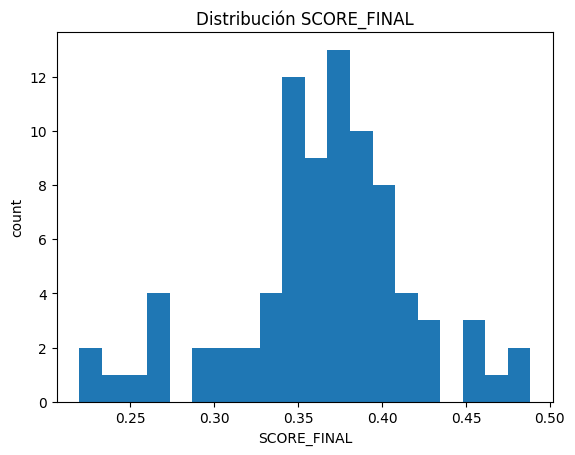

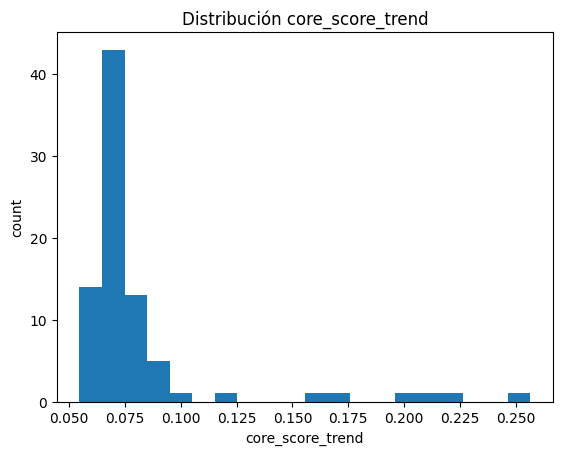

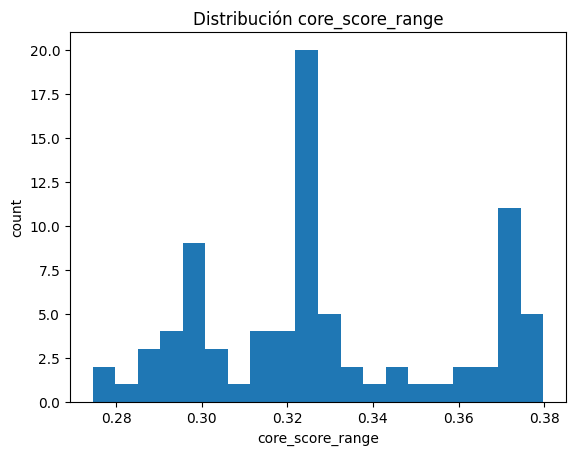

>>> Celda 10D :: OK


In [21]:
# Celda 10D — QA Final de Perfiles, Umbrales y Coherencia (post 10C)
# ---------------------------------------------------------------------------
# Objetivo:
#   Validar que la salida de Celda 10C es:
#     1) Estadísticamente razonable (distribuciones/percentiles).
#     2) Coherente entre:
#          - strategy_profile (macro: TREND/MR/BREAKOUT/MIXED)
#          - strategy_type_primary (micro: TREND_FOLLOW/MEAN_REVERSION/BREAKOUT)
#     3) Operativamente útil:
#          - detectar si los umbrales actuales están "fuera de escala"
#            para este universo (p.ej. min_profile_score_for_shortlist).
#
# Entradas esperadas:
#   - scores_table.parquet (Celda 10)
#   - asset_strategy_profiles.parquet (Celda 10C)
#   - asset_strategy_shortlist.parquet (Celda 10C)
#   - config.json (strategy_profiles)
#
# Salidas:
#   - NO genera nuevos artefactos de negocio.
#   - Actualiza:
#       GLOBAL_STATE["report_stats"]["c10D"]
#
# Filosofía:
#   - Esta celda NO "arregla" nada; solo diagnostica con prints claros.
#   - Si detecta incoherencias graves, levanta RuntimeError.
#   - Si detecta problemas moderados, imprime WARN explícitos.
# ---------------------------------------------------------------------------

from pathlib import Path
from typing import Dict, Any, Optional, List
import json
import math
import polars as pl

print(">>> Celda 10D :: QA de Celda 10C (Perfiles + Shortlist + Tipo de Estrategia)")

# ============================ Guardas básicas ================================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 10D][ERROR] GLOBAL_STATE no existe. Ejecuta las celdas previas.")

for key in ("paths", "run_id"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"[Celda 10D][ERROR] Falta GLOBAL_STATE['{key}'].")

RUN_ID = GLOBAL_STATE.get("run_id")
paths: Dict[str, Any] = GLOBAL_STATE["paths"]
metrics_state: Dict[str, Any] = GLOBAL_STATE.get("metrics", {}) or {}

OUT_SCORES_DIR = Path(paths.get("scores", Path(paths["stability"]).parent / "scores")).resolve()
OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)

scores_table_path = Path(
    metrics_state.get("scores_table_path", OUT_SCORES_DIR / "scores_table.parquet")
).resolve()

asset_profiles_path = Path(
    metrics_state.get("asset_strategy_profiles_path", OUT_SCORES_DIR / "asset_strategy_profiles.parquet")
).resolve()

asset_shortlist_path = Path(
    metrics_state.get("asset_strategy_shortlist_path", OUT_SCORES_DIR / "asset_strategy_shortlist.parquet")
).resolve()

CONFIG_PATH = Path(paths.get("config", Path(paths["diagnostics"]) / "config.json")).resolve()

def _require_file(p: Path, label: str = ""):
    if not p.exists():
        raise RuntimeError(f"[Celda 10D][ERROR] Falta input requerido {label}: {p}")

def _safe_read_json(p: Path) -> Dict[str, Any]:
    if not p.exists():
        return {}
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return {}

def _norm_sym(df: pl.DataFrame) -> pl.DataFrame:
    if "symbol" in df.columns:
        return df.with_columns(
            pl.col("symbol")
              .cast(pl.Utf8, strict=False)
              .str.to_uppercase()
              .str.strip_chars()
        )
    return df

def _ensure_float(df: pl.DataFrame, name: str, default: float = 0.0) -> pl.DataFrame:
    if name in df.columns:
        return df.with_columns(pl.col(name).cast(pl.Float64, strict=False).fill_null(default).alias(name))
    return df.with_columns(pl.lit(default).cast(pl.Float64).alias(name))

def _ensure_str(df: pl.DataFrame, name: str, default: Optional[str] = None) -> pl.DataFrame:
    if name in df.columns:
        return df.with_columns(pl.col(name).cast(pl.Utf8, strict=False).alias(name))
    return df.with_columns(pl.lit(default, dtype=pl.Utf8).alias(name))

def _pct(x: int, n: int) -> float:
    if n <= 0:
        return 0.0
    return 100.0 * x / n

print(f"[Celda 10D] RUN_ID = {RUN_ID}")
print(f"📁 DIR → scores = {str(OUT_SCORES_DIR)}")

# ============================ Cargar config ==================================
if "config" in GLOBAL_STATE and isinstance(GLOBAL_STATE["config"], dict):
    cfg = GLOBAL_STATE["config"]
else:
    cfg = _safe_read_json(CONFIG_PATH)
    GLOBAL_STATE["config"] = cfg

policy = cfg.get("policy", {}) or {}
strategy_cfg = cfg.get("strategy_profiles", {}) or {}

min_profile_score_for_shortlist  = float(strategy_cfg.get("min_profile_score_for_shortlist", 0.50))
min_SCORE_FINAL_for_shortlist    = float(strategy_cfg.get("min_SCORE_FINAL_for_shortlist", 0.30))
require_structure_loose_gate     = bool(strategy_cfg.get("require_structure_loose_gate", True))
require_viability_gate           = bool(strategy_cfg.get("require_viability_gate", True))

# Este valor solo se usa para interpretar escalas
global_min_TR = float(policy.get("min_TR_after_cost", 0.25))
if not math.isfinite(global_min_TR) or global_min_TR <= 0.0:
    global_min_TR = 0.25

print(
    "[Celda 10D] thresholds → "
    f"min_SCORE_FINAL_for_shortlist={min_SCORE_FINAL_for_shortlist}, "
    f"min_profile_score_for_shortlist={min_profile_score_for_shortlist}, "
    f"require_structure_loose_gate={require_structure_loose_gate}, "
    f"require_viability_gate={require_viability_gate}"
)

# ============================ Cargar inputs ==================================
_require_file(scores_table_path, "scores_table")
_require_file(asset_profiles_path, "asset_strategy_profiles")
_require_file(asset_shortlist_path, "asset_strategy_shortlist")

scores_df = _norm_sym(pl.read_parquet(scores_table_path))
profiles_df = _norm_sym(pl.read_parquet(asset_profiles_path))
shortlist_df = _norm_sym(pl.read_parquet(asset_shortlist_path))

print(f"📁 INPUT → scores_table              = {str(scores_table_path)} (rows={scores_df.height}, cols={len(scores_df.columns)})")
print(f"📁 INPUT → asset_strategy_profiles   = {str(asset_profiles_path)} (rows={profiles_df.height}, cols={len(profiles_df.columns)})")
print(f"📁 INPUT → asset_strategy_shortlist  = {str(asset_shortlist_path)} (rows={shortlist_df.height}, cols={len(shortlist_df.columns)})")

if profiles_df.is_empty():
    raise RuntimeError("[Celda 10D][ERROR] asset_strategy_profiles está vacío; Celda 10C no generó perfiles válidos.")

# ============================ Normalizar columnas clave ======================
for col in ["SCORE_FINAL", "core_score_trend", "core_score_range",
            "strategy_profile_max", "strategy_profile_margin",
            "strategy_profile_score_trend", "strategy_profile_score_mr",
            "strategy_profile_score_breakout",
            "score_trend_follow", "score_mean_reversion", "score_breakout"]:
    profiles_df = _ensure_float(profiles_df, col, 0.0)

for col in ["prop_trend", "prop_range", "prop_trend_eff", "prop_range_eff",
            "ER_asset", "PD_asset", "TR_trend_mean", "TR_range_mean",
            "NDQ_trend_mean", "NDQ_range_mean"]:
    profiles_df = _ensure_float(profiles_df, col, 0.0)

for col in ["strategy_profile", "class_family", "strategy_type_primary", "strategy_type_secondary"]:
    profiles_df = _ensure_str(profiles_df, col, None)

# Gates que podrían existir en perfiles
for gcol, default in [
    ("gate_all", True),
    ("passed_structure_gate_loose", True),
    ("passed_viability_gate", True),
]:
    if gcol in profiles_df.columns:
        profiles_df = profiles_df.with_columns(pl.col(gcol).cast(pl.Boolean, strict=False).fill_null(default).alias(gcol))
    else:
        profiles_df = profiles_df.with_columns(pl.lit(default).cast(pl.Boolean).alias(gcol))

universe_size = int(profiles_df.height)
shortlist_size = int(shortlist_df.height)

# ============================ Resumen rápido =================================
print("---- Resumen general ----")
print(f"[Universe] símbolos perfilados = {universe_size}")
print(f"[Shortlist] símbolos seleccionados = {shortlist_size}")

# ============================ Percentiles de scores ==========================
def _print_percentiles(df: pl.DataFrame, col: str, label: str):
    if col not in df.columns:
        return
    s = df.select(pl.col(col).cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0)).to_series()
    if s.len() == 0:
        return
    q = df.select([
        pl.col(col).quantile(0.10).alias("p10"),
        pl.col(col).quantile(0.25).alias("p25"),
        pl.col(col).quantile(0.50).alias("p50"),
        pl.col(col).quantile(0.75).alias("p75"),
        pl.col(col).quantile(0.90).alias("p90"),
        pl.col(col).quantile(0.95).alias("p95"),
    ]).row(0)
    print(
        f"[Percentiles] {label}: "
        f"p10={q[0]:.3f} | p25={q[1]:.3f} | p50={q[2]:.3f} | "
        f"p75={q[3]:.3f} | p90={q[4]:.3f} | p95={q[5]:.3f}"
    )

print("---- Distribuciones clave (percentiles) ----")
_print_percentiles(profiles_df, "SCORE_FINAL", "SCORE_FINAL")
_print_percentiles(profiles_df, "core_score_trend", "core_score_trend")
_print_percentiles(profiles_df, "core_score_range", "core_score_range")
if "score_trend_follow" in profiles_df.columns:
    _print_percentiles(profiles_df, "score_trend_follow", "score_trend_follow")
if "score_mean_reversion" in profiles_df.columns:
    _print_percentiles(profiles_df, "score_mean_reversion", "score_mean_reversion")
if "score_breakout" in profiles_df.columns:
    _print_percentiles(profiles_df, "score_breakout", "score_breakout")

# ============================ Diagnóstico de umbrales ========================
def _count_expr(expr: pl.Expr) -> int:
    return int(profiles_df.filter(expr).height)

base_expr = (
    (pl.col("gate_all") == True) &
    (pl.col("SCORE_FINAL") >= min_SCORE_FINAL_for_shortlist)
)

if require_structure_loose_gate and "passed_structure_gate_loose" in profiles_df.columns:
    base_expr = base_expr & (pl.col("passed_structure_gate_loose") == True)

if require_viability_gate and "passed_viability_gate" in profiles_df.columns:
    base_expr = base_expr & (pl.col("passed_viability_gate") == True)

n_base = _count_expr(base_expr)

n_trend_strong = _count_expr(base_expr & (pl.col("core_score_trend") >= min_profile_score_for_shortlist))
n_range_strong = _count_expr(base_expr & (pl.col("core_score_range") >= min_profile_score_for_shortlist))

print("---- Escala de umbrales (diagnóstico) ----")
print(f"[Base candidates] pasan gates base = {n_base} ({_pct(n_base, universe_size):.1f}%)")
print(
    f"[Strong TREND] core_score_trend ≥ {min_profile_score_for_shortlist:.2f} "
    f"= {n_trend_strong} ({_pct(n_trend_strong, max(n_base,1)):.1f}% de base)"
)
print(
    f"[Strong RANGE] core_score_range ≥ {min_profile_score_for_shortlist:.2f} "
    f"= {n_range_strong} ({_pct(n_range_strong, max(n_base,1)):.1f}% de base)"
)

# Heurística de "umbral fuera de escala"
# Si menos de 5% de la base cumple el umbral, probablemente el umbral es agresivo
if n_base > 0:
    frac_trend_strong = n_trend_strong / n_base
    frac_range_strong = n_range_strong / n_base

    if frac_trend_strong < 0.05:
        print(
            "[Celda 10D][WARN] Umbral de TREND fuerte parece agresivo para este universo "
            f"(solo {_pct(n_trend_strong, n_base):.1f}% de la base lo supera)."
        )
    if frac_range_strong < 0.05:
        print(
            "[Celda 10D][WARN] Umbral de RANGE/MR fuerte parece agresivo para este universo "
            f"(solo {_pct(n_range_strong, n_base):.1f}% de la base lo supera)."
        )

# ============================ Coherencia profile vs type ====================
print("---- Coherencia strategy_profile vs strategy_type_primary ----")

has_profile = "strategy_profile" in profiles_df.columns
has_type = "strategy_type_primary" in profiles_df.columns

alignment_rate = None
conf_table = None

if has_profile and has_type:
    # Mapeo esperado "razonable" (no perfecto, pero útil)
    # TREND  ↔ TREND_FOLLOW
    # MR     ↔ MEAN_REVERSION
    # BREAKOUT ↔ BREAKOUT
    # MIXED  ↔ cualquiera (neutral)
    df_ct = profiles_df.select([
        "symbol",
        pl.col("strategy_profile").fill_null("NA").alias("profile"),
        pl.col("strategy_type_primary").fill_null("NA").alias("type"),
    ])

    # Tabla de cruces
    conf_table = (
        df_ct
        .group_by(["profile", "type"])
        .agg(pl.len().alias("n"))
        .sort(["profile", "n"], descending=[False, True])
    )

    # Regla de alineación
    aligned_expr = (
        (pl.col("profile") == "MIXED") |
        ((pl.col("profile") == "TREND") & (pl.col("type") == "TREND_FOLLOW")) |
        ((pl.col("profile") == "MR") & (pl.col("type") == "MEAN_REVERSION")) |
        ((pl.col("profile") == "BREAKOUT") & (pl.col("type") == "BREAKOUT"))
    )

    n_aligned = int(df_ct.filter(aligned_expr).height)
    alignment_rate = n_aligned / universe_size if universe_size > 0 else 0.0

    print(f"[Alignment] rate aproximado = {alignment_rate*100:.1f}% (MIXED cuenta como neutral)")
    print("[Confusion] profile ↔ type (top combinaciones):")
    print(conf_table.head(12))

    if alignment_rate < 0.45:
        print(
            "[Celda 10D][WARN] La coherencia entre 'strategy_profile' y "
            "'strategy_type_primary' es baja. Esto no siempre es un bug, "
            "pero sugiere que tus lentes macro vs micro están usando criterios distintos "
            "o escalas diferentes."
        )
else:
    print("[Celda 10D] Aviso: no hay columnas suficientes para validar coherencia profile vs type.")

# ============================ Top rankings operativos ========================
def _print_top(df: pl.DataFrame, col: str, k: int = 10, extra: Optional[List[str]] = None, title: str = ""):
    if col not in df.columns:
        return
    cols = ["symbol", col]
    if extra:
        for e in extra:
            if e in df.columns and e not in cols:
                cols.append(e)
    t = (
        df
        .select(cols)
        .sort(by=[col, "symbol"], descending=[True, False])
        .head(k)
    )
    hdr = title if title else f"Top {k} por {col}"
    print(f"---- {hdr} ----")
    print(t)

extra_cols = ["strategy_profile", "strategy_type_primary", "class_family", "SCORE_FINAL"]

_print_top(profiles_df, "core_score_trend", 10, extra_cols, "Top 10 core_score_trend")
_print_top(profiles_df, "core_score_range", 10, extra_cols, "Top 10 core_score_range")
if "score_trend_follow" in profiles_df.columns:
    _print_top(profiles_df, "score_trend_follow", 10, extra_cols, "Top 10 score_trend_follow")
if "score_mean_reversion" in profiles_df.columns:
    _print_top(profiles_df, "score_mean_reversion", 10, extra_cols, "Top 10 score_mean_reversion")
if "score_breakout" in profiles_df.columns:
    _print_top(profiles_df, "score_breakout", 10, extra_cols, "Top 10 score_breakout")

# ============================ Shortlist sanity ===============================
print("---- Sanity de shortlist ----")
if shortlist_df.is_empty():
    print("[Celda 10D][ERROR] Shortlist vacía. Esto debió haber fallado en 10C.")
    raise RuntimeError("[Celda 10D][ERROR] Shortlist vacía detectada post 10C.")

# Comparar cobertura de shortlist vs perfiles
short_symbols = set(shortlist_df["symbol"].to_list()) if "symbol" in shortlist_df.columns else set()
prof_symbols = set(profiles_df["symbol"].to_list()) if "symbol" in profiles_df.columns else set()
missing_in_profiles = short_symbols - prof_symbols

if missing_in_profiles:
    print(f"[Celda 10D][WARN] Símbolos en shortlist que no están en perfiles: {sorted(list(missing_in_profiles))[:20]}")

print(f"[Shortlist] cobertura sobre universo = {_pct(len(short_symbols), universe_size):.1f}%")

# ============================ Chequeo de duplicados ==========================
# Si por alguna razón volvieron duplicados en perfiles, lo marcamos duro.
dup_count = (
    profiles_df
    .group_by("symbol")
    .agg(pl.len().alias("n"))
    .filter(pl.col("n") > 1)
    .height
)
if dup_count > 0:
    print(f"[Celda 10D][WARN] Detectados {dup_count} símbolos duplicados en perfiles. Esto NO debería ocurrir en final.")
    # No reventamos por defecto, pero lo dejamos registrado.

# ============================ (Opcional) Histograms rápidos ==================
# Sólo si estás en notebook y tienes matplotlib.
try:
    import matplotlib.pyplot as plt

    def _plot_hist(df: pl.DataFrame, col: str, title: str):
        if col not in df.columns:
            return
        data = (
            df.select(pl.col(col).cast(pl.Float64, strict=False).fill_null(0.0).clip(0.0, 1.0))
              .to_series()
              .to_list()
        )
        if len(data) == 0:
            return
        plt.figure()
        plt.hist(data, bins=20)
        plt.title(title)
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()

    print("---- Histograms (opcionales) ----")
    _plot_hist(profiles_df, "SCORE_FINAL", "Distribución SCORE_FINAL")
    _plot_hist(profiles_df, "core_score_trend", "Distribución core_score_trend")
    _plot_hist(profiles_df, "core_score_range", "Distribución core_score_range")

except Exception:
    print("[Celda 10D] matplotlib no disponible o entorno no gráfico; se omiten histograms.")

# ============================ Report stats ===================================
GLOBAL_STATE.setdefault("report_stats", {})

GLOBAL_STATE["report_stats"]["c10D"] = {
    "run_id": RUN_ID,
    "paths": {
        "scores_table": str(scores_table_path),
        "asset_strategy_profiles": str(asset_profiles_path),
        "asset_strategy_shortlist": str(asset_shortlist_path),
    },
    "universe_size": universe_size,
    "shortlist_size": shortlist_size,
    "thresholds": {
        "min_SCORE_FINAL_for_shortlist": min_SCORE_FINAL_for_shortlist,
        "min_profile_score_for_shortlist": min_profile_score_for_shortlist,
        "require_structure_loose_gate": require_structure_loose_gate,
        "require_viability_gate": require_viability_gate,
    },
    "base_candidates": {
        "n_base": n_base,
        "pct_base_of_universe": _pct(n_base, universe_size),
        "n_trend_strong": n_trend_strong,
        "pct_trend_strong_of_base": _pct(n_trend_strong, max(n_base, 1)),
        "n_range_strong": n_range_strong,
        "pct_range_strong_of_base": _pct(n_range_strong, max(n_base, 1)),
    },
    "alignment_rate_profile_vs_type": float(alignment_rate) if alignment_rate is not None else None,
    "duplicate_symbol_groups_in_profiles": int(dup_count),
}

print(">>> Celda 10D :: OK")


In [22]:
# Celda 10E — Handoff Operativo y Cierre del Pipeline (post 10B/10C/10D)
# =============================================================================
# Objetivo:
#   - Consolidar una vista final, operativa y legible por activo.
#   - Basarse en:
#       * scores_table.parquet (Celda 10)
#       * candidates/best/freq_only (Celda 10B) [opcionales]
#       * asset_strategy_profiles.parquet (Celda 10C)
#       * asset_strategy_shortlist.parquet (Celda 10C)
#       * QA ya ejecutado en Celda 10D
#   - Generar:
#       * Prints finales claros para decidir implementación por activo.
#       * Un artefacto ligero opcional: handoff_operational.parquet
#   - Integrar una estrategia explícita de "freq-only" como señal secundaria:
#       * Si existe freq_only_watchlist.parquet y tiene filas:
#           - Se marca como "secondary_watch_freq=True" en el handoff.
#           - No entra al shortlist principal por defecto.
# =============================================================================

from pathlib import Path
from typing import Dict, Any, Optional, List
import json
import math
import polars as pl

print(">>> Celda 10E :: Handoff Operativo + cierre del pipeline")

# ============================ Guardas básicas ================================
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 10E][ERROR] GLOBAL_STATE no existe. Ejecuta celdas previas.")

for key in ("paths", "run_id"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"[Celda 10E][ERROR] Falta GLOBAL_STATE['{key}'].")

RUN_ID = GLOBAL_STATE.get("run_id")
paths: Dict[str, Any] = GLOBAL_STATE["paths"]
metrics_state: Dict[str, Any] = GLOBAL_STATE.get("metrics", {}) or {}

OUT_SCORES_DIR = Path(paths.get("scores", Path(paths["stability"]).parent / "scores")).resolve()
OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)

scores_table_path = Path(
    metrics_state.get("scores_table_path", OUT_SCORES_DIR / "scores_table.parquet")
).resolve()

asset_profiles_path = Path(
    metrics_state.get("asset_strategy_profiles_path", OUT_SCORES_DIR / "asset_strategy_profiles.parquet")
).resolve()

asset_shortlist_path = Path(
    metrics_state.get("asset_strategy_shortlist_path", OUT_SCORES_DIR / "asset_strategy_shortlist.parquet")
).resolve()

# Artefactos 10B (opcionales)
candidates_table_path = OUT_SCORES_DIR / "candidates_table.parquet"
best_per_symbol_path  = OUT_SCORES_DIR / "best_per_symbol.parquet"
freq_only_path        = OUT_SCORES_DIR / "freq_only_watchlist.parquet"

CONFIG_PATH = Path(paths.get("config", Path(paths["diagnostics"]) / "config.json")).resolve()

def _require_file(p: Path, label: str = ""):
    if not p.exists():
        raise RuntimeError(f"[Celda 10E][ERROR] Falta input requerido {label}: {p}")

def _safe_read_json(p: Path) -> Dict[str, Any]:
    if not p.exists():
        return {}
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return {}

def _norm_sym(df: pl.DataFrame) -> pl.DataFrame:
    if "symbol" in df.columns:
        df = df.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()
        )
    if "preset" in df.columns:
        df = df.with_columns(
            pl.col("preset").cast(pl.Utf8, strict=False).fill_null("").str.to_uppercase().str.strip_chars()
        )
    return df

def _ensure_float(df: pl.DataFrame, name: str, default: float = 0.0) -> pl.DataFrame:
    if name in df.columns:
        return df.with_columns(pl.col(name).cast(pl.Float64, strict=False).fill_null(default).alias(name))
    return df.with_columns(pl.lit(default).cast(pl.Float64).alias(name))

def _ensure_str(df: pl.DataFrame, name: str, default: Optional[str] = None) -> pl.DataFrame:
    if name in df.columns:
        return df.with_columns(pl.col(name).cast(pl.Utf8, strict=False).alias(name))
    return df.with_columns(pl.lit(default, dtype=pl.Utf8).alias(name))

def _pct(x: int, n: int) -> float:
    if n <= 0:
        return 0.0
    return 100.0 * x / n

print(f"[Celda 10E] RUN_ID = {RUN_ID}")
print(f"[10E] OUT_SCORES_DIR = {str(OUT_SCORES_DIR)}")
print(f"[10E] SCORES_PATH   = {str(scores_table_path)} (exists={scores_table_path.exists()})")
print(f"[10E] PROFILES_PATH= {str(asset_profiles_path)} (exists={asset_profiles_path.exists()})")
print(f"[10E] SHORTLIST_PATH= {str(asset_shortlist_path)} (exists={asset_shortlist_path.exists()})")
print(f"[10E] FREQ_ONLY_PATH= {str(freq_only_path)} (exists={freq_only_path.exists()})")
print(f"[10E] CONFIG_PATH  = {str(CONFIG_PATH)} (exists={CONFIG_PATH.exists()})")

# ============================ Config =========================================
if "config" in GLOBAL_STATE and isinstance(GLOBAL_STATE["config"], dict):
    cfg = GLOBAL_STATE["config"]
else:
    cfg = _safe_read_json(CONFIG_PATH)
    GLOBAL_STATE["config"] = cfg

scores_cfg   = cfg.get("scores", {}) or {}
spcfg        = cfg.get("strategy_profiles", {}) or {}

score_thr_cfg = scores_cfg.get("score_thresholds", {}) or {}
score_viable_thr      = float(score_thr_cfg.get("viable",      0.30))
score_interesting_thr = float(score_thr_cfg.get("interesting", 0.40))
score_premium_thr     = float(score_thr_cfg.get("premium",     0.50))

min_SCORE_FINAL_for_shortlist = float(spcfg.get("min_SCORE_FINAL_for_shortlist", 0.30))

print(
    "[Celda 10E] thresholds → "
    f"SCORE_FINAL viable={score_viable_thr}, core={score_interesting_thr}, premium={score_premium_thr}, "
    f"min_SCORE_FINAL_for_shortlist={min_SCORE_FINAL_for_shortlist}"
)

# ============================ Cargar inputs ==================================
_require_file(scores_table_path, "scores_table")
_require_file(asset_profiles_path, "asset_strategy_profiles")
_require_file(asset_shortlist_path, "asset_strategy_shortlist")

scores_df   = _norm_sym(pl.read_parquet(scores_table_path))
profiles_df = _norm_sym(pl.read_parquet(asset_profiles_path))
shortlist_df = _norm_sym(pl.read_parquet(asset_shortlist_path))

print(f"📁 INPUT → scores_table            = {str(scores_table_path)} (rows={scores_df.height}, cols={len(scores_df.columns)})")
print(f"📁 INPUT → asset_strategy_profiles = {str(asset_profiles_path)} (rows={profiles_df.height}, cols={len(profiles_df.columns)})")
print(f"📁 INPUT → asset_strategy_shortlist= {str(asset_shortlist_path)} (rows={shortlist_df.height}, cols={len(shortlist_df.columns)})")

if shortlist_df.is_empty():
    raise RuntimeError("[Celda 10E][ERROR] Shortlist vacía. No hay nada que entregar operativamente.")

# ============================ Cargar 10B opcional =============================
candidates_df = pl.read_parquet(candidates_table_path) if candidates_table_path.exists() else pl.DataFrame()
best_df       = pl.read_parquet(best_per_symbol_path)  if best_per_symbol_path.exists() else pl.DataFrame()
freq_only_df  = pl.read_parquet(freq_only_path)        if freq_only_path.exists() else pl.DataFrame()

candidates_df = _norm_sym(candidates_df)
best_df       = _norm_sym(best_df)
freq_only_df  = _norm_sym(freq_only_df)

print(f"[10E] candidates_table loaded → rows={candidates_df.height if not candidates_df.is_empty() else 0}")
print(f"[10E] best_per_symbol loaded  → rows={best_df.height if not best_df.is_empty() else 0}")
print(f"[10E] freq_only_watchlist loaded → rows={freq_only_df.height if not freq_only_df.is_empty() else 0}")

# ============================ Normalizar columnas esperadas ==================
for col in [
    "SCORE_FINAL", "SCORE_FINAL_trend", "SCORE_FINAL_range",
    "core_score_trend", "core_score_range", "core_score_breakout",
    "score_significance", "score_opportunity", "score_stability",
    "score_viability", "score_structure",
]:
    shortlist_df = _ensure_float(shortlist_df, col, 0.0)

for col in ["strategy_type_primary", "strategy_type_secondary", "strategy_profile"]:
    shortlist_df = _ensure_str(shortlist_df, col, None)

# Ranks si existen
for col in ["shortlist_rank_trend", "shortlist_rank_range", "shortlist_rank_breakout"]:
    if col not in shortlist_df.columns:
        shortlist_df = shortlist_df.with_columns(pl.lit(None).cast(pl.Int64).alias(col))

# ============================ Estrategia "freq-only" secundaria ===============
# Filosofía:
#   - freq-only NO se mezcla con shortlist principal.
#   - Se trata como "señal secundaria" de monitoreo.
#   - Si hay activos en freq_only_watchlist:
#       * se crea una marca para visualización en el handoff.
#       * se imprimen por separado como WATCH_FREQ.

freq_only_symbols = set(freq_only_df["symbol"].to_list()) if (not freq_only_df.is_empty() and "symbol" in freq_only_df.columns) else set()

shortlist_df = shortlist_df.with_columns(
    pl.col("symbol").is_in(list(freq_only_symbols)).alias("secondary_watch_freq")
)

# ============================ Recomendaciones por activo ======================
# recommended_family:
#   - Determinada por el mejor rank disponible entre trend/range/breakout.
#   - Si no hay ranks, fallback a strategy_profile.

shortlist_df = shortlist_df.with_columns([
    pl.min_horizontal([
        pl.col("shortlist_rank_trend").fill_null(10_000),
        pl.col("shortlist_rank_range").fill_null(10_000),
        pl.col("shortlist_rank_breakout").fill_null(10_000),
    ]).alias("__best_rank__")
])

shortlist_df = shortlist_df.with_columns(
    pl.when(pl.col("__best_rank__") >= 10_000)
      .then(
          pl.when(pl.col("strategy_profile").is_not_null()).then(pl.col("strategy_profile")).otherwise(pl.lit("MIXED"))
      )
      .when(pl.col("__best_rank__") == pl.col("shortlist_rank_trend").fill_null(10_000)).then(pl.lit("TREND"))
      .when(pl.col("__best_rank__") == pl.col("shortlist_rank_range").fill_null(10_000)).then(pl.lit("RANGE"))
      .otherwise(pl.lit("BREAKOUT"))
      .alias("recommended_family")
)

# recommended_type:
#   - Por defecto usa strategy_type_primary.
#   - Si family sugiere algo distinto y el secondary encaja, lo anotamos.

shortlist_df = shortlist_df.with_columns(
    pl.when(
        (pl.col("recommended_family") == "TREND") &
        (pl.col("strategy_type_primary") != "TREND_FOLLOW") &
        (pl.col("strategy_type_secondary") == "TREND_FOLLOW")
    ).then(pl.lit("TREND_FOLLOW (secondary)"))
     .when(
        (pl.col("recommended_family") == "RANGE") &
        (pl.col("strategy_type_primary") != "MEAN_REVERSION") &
        (pl.col("strategy_type_secondary") == "MEAN_REVERSION")
    ).then(pl.lit("MEAN_REVERSION (secondary)"))
     .otherwise(pl.col("strategy_type_primary").fill_null("NA"))
     .alias("recommended_type")
)

# Tier operativo simple
shortlist_df = shortlist_df.with_columns(
    pl.when(pl.col("SCORE_FINAL") >= score_premium_thr).then(pl.lit("PREMIUM"))
      .when(pl.col("SCORE_FINAL") >= score_interesting_thr).then(pl.lit("CORE"))
      .when(pl.col("SCORE_FINAL") >= score_viable_thr).then(pl.lit("VIABLE"))
      .otherwise(pl.lit("LOW"))
      .alias("tier_label_oper")
)

# Orden final operativo
handoff_df = (
    shortlist_df
    .sort(by=["__best_rank__", "SCORE_FINAL", "symbol"], descending=[False, True, False])
    .with_row_index("priority_rank", offset=1)
)

# ============================ Tabla compacta de handoff =======================
handoff_cols = [
    "priority_rank",
    "symbol",
    "tier_label_oper",
    "SCORE_FINAL",
    "SCORE_FINAL_trend", "SCORE_FINAL_range",
    "recommended_family",
    "recommended_type",
    "strategy_type_primary", "strategy_type_secondary",
    "strategy_profile",
    "core_score_trend", "core_score_range", "core_score_breakout",
    "score_opportunity", "score_stability", "score_viability", "score_structure",
    "secondary_watch_freq",
]

for c in handoff_cols:
    if c not in handoff_df.columns:
        handoff_df = handoff_df.with_columns(pl.lit(None).alias(c))

handoff_compact = handoff_df.select(handoff_cols)

# ============================ Prints finales =================================
universe_size = int(profiles_df.height) if not profiles_df.is_empty() else 0
shortlist_size = int(handoff_compact.height)

print("---- Handoff operativo (shortlist) ----")
print(f"[Universe] activos perfilados = {universe_size}")
print(f"[Shortlist] activos operativos = {shortlist_size} ({_pct(shortlist_size, universe_size):.1f}%)")

print("---- Tabla final compacta (orden de implementación) ----")
print(handoff_compact)

print("---- Resumen por tier operativo ----")
try:
    print(
        handoff_compact
        .group_by("tier_label_oper")
        .agg(pl.len().alias("n"))
        .sort("n", descending=True)
    )
except Exception as e:
    print(f"[Celda 10E] WARN resumen tier: {e}")

# ============================ FREQ-ONLY como señal secundaria =================
print("---- WATCH_FREQ (freq-only secondary) ----")
if freq_only_df.is_empty():
    print("[10E] No hay freq-only_watchlist para este run o está vacía.")
else:
    # Vista ligera: no forzamos columnas internas de 10B
    cols_watch = [c for c in ["symbol", "preset", "SCORE_FINAL", "score_opportunity", "n_per_month_total", "coverage_p"] if c in freq_only_df.columns]
    if not cols_watch:
        cols_watch = ["symbol"] if "symbol" in freq_only_df.columns else []
    watch_view = freq_only_df.select(cols_watch).head(50) if cols_watch else freq_only_df.head(50)
    print(watch_view)
    print(
        "[10E] Nota operativa: freq-only se mantiene fuera de shortlist principal. "
        "Úsalo como radar de investigación si en próximos runs mejora significancia/viabilidad."
    )

# ============================ Artefacto opcional de cierre ===================
handoff_path = OUT_SCORES_DIR / "handoff_operational.parquet"
handoff_compact.write_parquet(handoff_path)

if (not handoff_path.exists()) or handoff_path.stat().st_size == 0:
    raise RuntimeError("[Celda 10E][ERROR] No se pudo escribir handoff_operational.parquet")

print(f"💾 OUTPUT → {str(handoff_path)} (rows={handoff_compact.height}, cols={handoff_compact.width})")

# ============================ GLOBAL_STATE ===================================
GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["handoff_operational_path"] = str(handoff_path)

GLOBAL_STATE.setdefault("report_stats", {})
GLOBAL_STATE["report_stats"]["c10E"] = {
    "RUN_ID": RUN_ID,
    "paths": {
        "scores_table": str(scores_table_path),
        "asset_strategy_profiles": str(asset_profiles_path),
        "asset_strategy_shortlist": str(asset_shortlist_path),
        "handoff_operational": str(handoff_path),
        "candidates_table": str(candidates_table_path) if candidates_table_path.exists() else None,
        "best_per_symbol": str(best_per_symbol_path) if best_per_symbol_path.exists() else None,
        "freq_only_watchlist": str(freq_only_path) if freq_only_path.exists() else None,
    },
    "universe_size": int(universe_size),
    "shortlist_size": int(shortlist_size),
    "thresholds": {
        "score_final": {
            "viable": score_viable_thr,
            "core": score_interesting_thr,
            "premium": score_premium_thr,
        },
        "min_SCORE_FINAL_for_shortlist": min_SCORE_FINAL_for_shortlist,
    },
    "freq_only_secondary": {
        "enabled": True,
        "n_watch": int(freq_only_df.height) if not freq_only_df.is_empty() else 0,
    },
}

print(">>> Celda 10E :: OK — Pipeline listo para cerrar y comenzar construcción de estrategias por activo")


>>> Celda 10E :: Handoff Operativo + cierre del pipeline
[Celda 10E] RUN_ID = 20251218_190810
[10E] OUT_SCORES_DIR = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores
[10E] SCORES_PATH   = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\scores_table.parquet (exists=True)
[10E] PROFILES_PATH= C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\asset_strategy_profiles.parquet (exists=True)
[10E] SHORTLIST_PATH= C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\asset_strategy_shortlist.parquet (exists=True)
[10E] FREQ_ONLY_PATH= C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\freq_only_watchlist.parquet (exists=True)
[10E] CONFIG_PATH  = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\config.json (exists=True)
[Celda 10E] thresholds → SCORE_FINAL viable=0.3, core=0.4, premium=0.5, min_SCORE_FINAL_for_shortlist=0.3
📁 INPUT → scores_table        

In [23]:
 # =============================================================================
# Celda 10F :: Corr Matrix Builder & QA (M5)  [V3.1 TIME FIX + AUTODETECT]
# Objetivo:
#   - Asegurar correlación real para Celda 11.
#   - Detectar layout real de M5:
#       (A) Dataset particionado: m5_raw/symbol=XXX/year=YYYY/month=MM/part=*.parquet
#       (B) 1 parquet por símbolo
#       (C) carpetas por símbolo sin "symbol="
#   - Construir corr_matrix_5m.csv con lookback configurable.
#   - Writes limpios + QA explícito.
#
# Fix clave:
#   - Tus parquets usan 'timestamp_utc' y 'timestamp_gye'.
#   - Se agregan a TIME_CANDS + autodetección robusta.
#
# HOTFIX v3.1.1:
#   - Polars DeprecationWarning:
#       reemplaza collect(streaming=True) -> collect(engine="streaming")
#       con fallback compatible.
# =============================================================================

from pathlib import Path
from datetime import datetime, timedelta, timezone
from typing import Dict, Any, List, Optional, Tuple
import re
import json

import polars as pl
import numpy as np

try:
    import pandas as pd
    PD_OK = True
except Exception:
    pd = None
    PD_OK = False

print(">>> Celda 10F :: Corr Matrix Builder & QA (M5) [V3.1 TIME FIX + AUTODETECT + POLARS ENGINE FIX]")

# -----------------------------------------------------------------------------
# 0) Validaciones de estado
# -----------------------------------------------------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 10F][ERROR] GLOBAL_STATE no existe. Ejecuta las celdas iniciales.")

for key in ("project_root", "run_id", "paths"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"[Celda 10F][ERROR] GLOBAL_STATE incompleto; falta clave '{key}'.")

PROJECT_ROOT = Path(GLOBAL_STATE["project_root"]).resolve()
RUN_ID       = GLOBAL_STATE["run_id"]
paths: Dict[str, Any] = GLOBAL_STATE.get("paths", {}) or {}

for k in ("scores", "diagnostics"):
    if k not in paths:
        raise RuntimeError(f"[Celda 10F][ERROR] Falta GLOBAL_STATE['paths']['{k}'].")

OUT_SCORES_DIR  = Path(paths["scores"]).resolve()
OUT_DIAG_DIR    = Path(paths["diagnostics"]).resolve()
OUT_METRICS_DIR = Path(paths.get("metrics", OUT_SCORES_DIR.parent / "metrics")).resolve()

OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------------------
# 1) Config
# -----------------------------------------------------------------------------
lookback_days = 90
cfg = GLOBAL_STATE.get("config", {}) or {}
corr_cfg = (cfg.get("corr", {}) or {}) if isinstance(cfg, dict) else {}
try:
    lookback_days = int(corr_cfg.get("lookback_days", lookback_days))
except Exception:
    lookback_days = 90
if lookback_days <= 0:
    lookback_days = 90

print(f"[Celda 10F] RUN_ID = {RUN_ID}")
print(f"[Celda 10F] lookback_days = {lookback_days}")

# -----------------------------------------------------------------------------
# 2) Auto-detect de paths
# -----------------------------------------------------------------------------
def _first_existing(cands: List[Path]) -> Optional[Path]:
    for p in cands:
        try:
            if p is not None and Path(p).exists():
                return Path(p).resolve()
        except Exception:
            continue
    return None

def _has_parquet(p: Path) -> bool:
    try:
        if not p.exists() or not p.is_dir():
            return False
        if any(p.glob("*.parquet")):
            return True
        return any(p.rglob("*.parquet"))
    except Exception:
        return False

def _score_bulk_dir(p: Path) -> int:
    try:
        if not p.exists() or not p.is_dir():
            return -10
        score = 0
        if (p / "m5_raw").exists():
            score += 6
        if (p / "rates_5m").exists():
            score += 6
        if _has_parquet(p / "m5_raw"):
            score += 25
        if _has_parquet(p / "rates_5m"):
            score += 25
        if _has_parquet(p):
            score += 10
        return score
    except Exception:
        return -10

bulk_cands = []
if paths.get("bulk_data"):
    try:
        bulk_cands.append(Path(paths["bulk_data"]))
    except Exception:
        pass

bulk_cands += [
    PROJECT_ROOT / "bulk_data",
    PROJECT_ROOT / "data" / "bulk_data",
    PROJECT_ROOT.parent / "data" / "bulk_data",
]

bulk_cands_clean = []
seen = set()
for c in bulk_cands:
    try:
        rc = Path(c).resolve()
        k = str(rc).lower()
        if k not in seen:
            bulk_cands_clean.append(rc)
            seen.add(k)
    except Exception:
        continue

bulk_scores = [(p, _score_bulk_dir(p)) for p in bulk_cands_clean]
print("[Celda 10F] Bulk candidates scored:")
for p, sc in sorted(bulk_scores, key=lambda x: x[1], reverse=True):
    print(f"   - {p}  score={sc}")

bulk_scores_sorted = sorted(bulk_scores, key=lambda x: x[1], reverse=True)
if bulk_scores_sorted and bulk_scores_sorted[0][1] > -5:
    BULK_DIR = bulk_scores_sorted[0][0]
else:
    BULK_DIR = _first_existing(bulk_cands_clean) or (PROJECT_ROOT / "bulk_data")

BULK_DIR = Path(BULK_DIR).resolve()

processed_cands = []
if paths.get("processed_data"):
    try:
        processed_cands.append(Path(paths["processed_data"]))
    except Exception:
        pass

processed_cands += [
    PROJECT_ROOT / "processed_data",
    PROJECT_ROOT / "data" / "processed_data",
    OUT_SCORES_DIR.parent / "processed_data",
    BULK_DIR.parent / "processed_data",
]

PROCESSED_DIR = _first_existing(processed_cands) or (PROJECT_ROOT / "processed_data")
PROCESSED_DIR = Path(PROCESSED_DIR).resolve()
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

rates_cands = []
if paths.get("rates_5m"):
    try:
        rates_cands.append(Path(paths["rates_5m"]))
    except Exception:
        pass

rates_cands += [
    BULK_DIR / "rates_5m",
    BULK_DIR / "m5_raw",
]

RATES_5M_DIR = None
for cand in rates_cands:
    if cand is None:
        continue
    cand = Path(cand)
    if _has_parquet(cand):
        RATES_5M_DIR = cand.resolve()
        break

if RATES_5M_DIR is None:
    RATES_5M_DIR = (BULK_DIR / "m5_raw").resolve()

print(f"[Celda 10F] bulk_data dir     = {str(BULK_DIR)}")
print(f"[Celda 10F] processed_data   = {str(PROCESSED_DIR)}")
print(f"[Celda 10F] rates/m5 dir     = {str(RATES_5M_DIR)}")

paths["bulk_data"]      = str(BULK_DIR)
paths["processed_data"] = str(PROCESSED_DIR)
paths["rates_5m"]       = str(RATES_5M_DIR)
GLOBAL_STATE["paths"]   = paths

# -----------------------------------------------------------------------------
# 3) Shortlist
# -----------------------------------------------------------------------------
metrics_state = GLOBAL_STATE.get("metrics", {}) or {}
asset_shortlist_path_str = (
    metrics_state.get("asset_strategy_shortlist_path")
    or metrics_state.get("asset_shortlist_path")
)

if asset_shortlist_path_str:
    asset_shortlist_path = Path(asset_shortlist_path_str).resolve()
else:
    cand_strategy = OUT_SCORES_DIR / "asset_strategy_shortlist.parquet"
    cand_legacy   = OUT_SCORES_DIR / "asset_shortlist.parquet"
    asset_shortlist_path = cand_strategy if cand_strategy.exists() else cand_legacy
    asset_shortlist_path = asset_shortlist_path.resolve()

print(f"📁 INPUT → asset_strategy_shortlist = {str(asset_shortlist_path)}", end="")

if not asset_shortlist_path.exists() or asset_shortlist_path.stat().st_size == 0:
    raise RuntimeError(f"[Celda 10F][ERROR] Shortlist no encontrada o vacía: {asset_shortlist_path}")

shortlist = pl.read_parquet(str(asset_shortlist_path))
if "symbol" not in shortlist.columns:
    raise RuntimeError("[Celda 10F][ERROR] Shortlist no tiene columna 'symbol'.")

shortlist = shortlist.with_columns(
    pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()
)
symbols = shortlist.get_column("symbol").unique().to_list()
print(f" (symbols={len(symbols)})")

# -----------------------------------------------------------------------------
# 4) Detectar layout particionado por "symbol=XXX"
# -----------------------------------------------------------------------------
partition_dirs = []
try:
    partition_dirs = [p for p in RATES_5M_DIR.glob("symbol=*") if p.is_dir()]
except Exception:
    partition_dirs = []

is_partitioned = len(partition_dirs) > 0
print(f"[Celda 10F] Layout detectado → partitioned={is_partitioned} (symbol=* dirs={len(partition_dirs)})")

# -----------------------------------------------------------------------------
# 5) Resolver archivos por símbolo
# -----------------------------------------------------------------------------
def _list_parquets_under(p: Path) -> List[Path]:
    if not p.exists():
        return []
    return [f.resolve() for f in p.rglob("*.parquet")]

def _recent_files(files: List[Path], max_files: int = 400) -> List[Path]:
    try:
        files = sorted(files, key=lambda x: x.stat().st_mtime, reverse=True)
    except Exception:
        files = sorted(files)
    return files[:max_files]

def _canon(s: str) -> str:
    s = (s or "").upper().strip()
    return re.sub(r"[^A-Z0-9]", "", s)

def _candidate_name_keys(sym: str) -> List[str]:
    s = (sym or "").upper().strip()
    base = _canon(s)
    cands = {
        s, base,
        f"{s}_5M", f"{base}_5M",
        f"{s}M5", f"{base}M5",
        f"{s}_M5", f"{base}_M5",
    }
    return [c for c in cands if c]

def _fallback_match_non_partition(sym: str) -> List[Path]:
    sym_u = sym.upper().strip()
    keys = set(_candidate_name_keys(sym_u))

    direct = []
    for k in keys:
        fp = RATES_5M_DIR / f"{k}.parquet"
        if fp.exists():
            direct.append(fp.resolve())
    if direct:
        return direct

    cand_dirs = [
        RATES_5M_DIR / sym_u,
        RATES_5M_DIR / _canon(sym_u),
    ]
    for d in cand_dirs:
        if d.exists() and d.is_dir():
            files = _list_parquets_under(d)
            if files:
                return files

    files_root = list(RATES_5M_DIR.glob("*.parquet"))
    by_stem = [f.resolve() for f in files_root if f.stem.upper().strip() in keys]
    return by_stem

mapping_rows = []
missing_syms = []
multi_syms = []
sym_to_files: Dict[str, List[Path]] = {}

for sym in symbols:
    files = []
    match_mode = "NONE"

    if is_partitioned:
        part_dir = RATES_5M_DIR / f"symbol={sym}"
        if part_dir.exists() and part_dir.is_dir():
            files = _list_parquets_under(part_dir)
            match_mode = "PARTITION_DIR"

    if not files:
        files = _fallback_match_non_partition(sym)
        match_mode = "NON_PARTITION_FALLBACK" if files else "NONE"

    files = _recent_files(files, max_files=400)

    if not files:
        missing_syms.append(sym)
        mapping_rows.append({"symbol": sym, "files_found": 0, "match_mode": match_mode, "example_files": ""})
    else:
        sym_to_files[sym] = files
        if len(files) > 1:
            multi_syms.append(sym)
        mapping_rows.append({
            "symbol": sym,
            "files_found": len(files),
            "match_mode": match_mode,
            "example_files": " | ".join(str(p) for p in files[:10]),
        })

map_df = pl.DataFrame(mapping_rows)

found_syms = map_df.filter(pl.col("files_found") > 0)["symbol"].to_list()
found_n = len(found_syms)
miss_n  = len(missing_syms)

print(f"[Celda 10F] Mapping símbolo → archivos: found={found_n}/{len(symbols)}, missing={miss_n}")
if multi_syms:
    print(f"[Celda 10F] Símbolos con múltiples parquets (recortados a recientes) = {multi_syms}")

qa_map_path = OUT_DIAG_DIR / "corr_matrix_builder_mapping.parquet"
map_df.write_parquet(str(qa_map_path))
print(f"💾 OUTPUT → {str(qa_map_path)}")

if found_n < 2:
    raise RuntimeError(
        "[Celda 10F][ERROR] Series M5 insuficientes para correlación real.\n"
        f"Directorio analizado: {RATES_5M_DIR}\n"
        f"Missing symbols: {missing_syms}\n"
        "Si tu data es particionada, asegúrate de tener carpetas exactas:\n"
        "  m5_raw/symbol=TU_SIMBOLO/...\n"
    )

# -----------------------------------------------------------------------------
# 6) Cargar series de close (FIX TIME + POLARS ENGINE)
# -----------------------------------------------------------------------------
if not PD_OK:
    raise RuntimeError("[Celda 10F][ERROR] pandas no disponible; requerido para correlación robusta.")

def _find_col(cols: List[str], cands: List[str]) -> Optional[str]:
    lower = {c.lower(): c for c in cols}
    for cand in cands:
        if cand in lower:
            return lower[cand]
    return None

# ✅ FIX: añadimos tus columnas reales
TIME_CANDS  = [
    "timestamp_utc", "timestamp_gye",   # <- tus nombres reales
    "time_utc", "datetime_utc",
    "timestamp", "time", "datetime",
    "dt", "ts", "time_m5"
]
CLOSE_CANDS = [
    "close", "last", "price_close", "close_price",
    "close_mid", "close_bid", "close_ask", "c"
]

def _autodetect_time_col(cols: List[str]) -> Optional[str]:
    priority = []
    for c in cols:
        cl = c.lower()
        if "timestamp" in cl and "utc" in cl:
            priority.append(c)
    if priority:
        return priority[0]
    for c in cols:
        cl = c.lower()
        if "timestamp" in cl:
            return c
    for c in cols:
        cl = c.lower()
        if cl in ("time", "datetime"):
            return c
    return None

def _collect_lazy(lf: pl.LazyFrame) -> pl.DataFrame:
    """
    Evita DeprecationWarning:
      - Polars nuevos: collect(engine="streaming")
      - Polars antiguos: fallback a collect(streaming=True)
    """
    try:
        return lf.collect(engine="streaming")
    except TypeError:
        # compatibilidad con versiones antiguas
        return lf.collect(streaming=True)

def _load_close_lazy(files: List[Path], lookback_days: int) -> Optional[pd.Series]:
    if not files:
        return None

    try:
        df0 = pl.read_parquet(str(files[0]))
    except Exception:
        return None

    tcol = _find_col(df0.columns, TIME_CANDS)
    ccol = _find_col(df0.columns, CLOSE_CANDS)

    # ✅ autodetect si no encontró por lista
    if tcol is None:
        tcol = _autodetect_time_col(df0.columns)

    if tcol is None or ccol is None:
        return None

    lf = pl.scan_parquet([str(p) for p in files]).select([pl.col(tcol), pl.col(ccol)])
    df = _collect_lazy(lf)

    if df.is_empty():
        return None

    # Conversión robusta de tiempo
    try:
        dt = df[tcol].dtype
    except Exception:
        dt = None

    if dt in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        sample = df[tcol].drop_nulls().head(5).to_list()
        unit = "ms"
        if sample:
            mx = max(sample)
            unit = "ms" if mx > 10_000_000_000 else "s"
        df = df.with_columns(pl.from_epoch(pl.col(tcol), time_unit=unit).alias(tcol))
    else:
        df = df.with_columns(pl.col(tcol).cast(pl.Datetime, strict=False).alias(tcol))

    df = df.drop_nulls(subset=[tcol, ccol])
    if df.is_empty():
        return None

    try:
        max_ts = df.select(pl.col(tcol).max()).item()
    except Exception:
        max_ts = None

    if max_ts is not None:
        cutoff = max_ts - timedelta(days=lookback_days)
        df = df.filter(pl.col(tcol) >= cutoff)

    df = df.sort(tcol)

    pdf = df.to_pandas()
    s = pd.Series(pdf[ccol].values, index=pd.to_datetime(pdf[tcol], utc=True))
    s = s[~s.index.duplicated(keep="last")]
    return s

series_map: Dict[str, pd.Series] = {}
load_fail = []

for sym, files in sym_to_files.items():
    try:
        s = _load_close_lazy(files, lookback_days)
        if s is not None and len(s) > 80:
            series_map[sym] = s
        else:
            load_fail.append(sym)
    except Exception as e:
        print(f"[Celda 10F][WARN] Fallo cargando {sym}: {e}")
        load_fail.append(sym)

print(f"[Celda 10F] Series válidas tras carga = {len(series_map)}")
if load_fail:
    print(f"[Celda 10F] Símbolos fallidos en carga: {sorted(set(load_fail))}")

if len(series_map) < 2:
    print("---- QA extra: columnas detectadas en 1er archivo de símbolos fallidos ----")
    for sym in sorted(set(load_fail))[:10]:
        fl = sym_to_files.get(sym, [])
        if not fl:
            continue
        try:
            dfx = pl.read_parquet(str(fl[0]))
            print(f"[{sym}] file={fl[0].name} cols={dfx.columns[:80]}")
        except Exception as e:
            print(f"[{sym}] no se pudo leer ejemplo: {e}")

    raise RuntimeError(
        "[Celda 10F][ERROR] Series válidas insuficientes tras carga.\n"
        "Con tu esquema actual esto NO debería pasar ya.\n"
        "Si pasa, el problema sería data vacía o timestamps no parseables."
    )

# -----------------------------------------------------------------------------
# 7) Correlación
# -----------------------------------------------------------------------------
prices_df = pd.DataFrame(series_map).sort_index()
prices_df = prices_df.ffill(limit=3)

rets_df = np.log(prices_df).diff()
rets_df = rets_df.dropna(how="all")

if rets_df.shape[0] < 10:
    raise RuntimeError("[Celda 10F][ERROR] Retornos insuficientes tras limpieza/lookback.")

corr = rets_df.corr(method="pearson", min_periods=10)
corr = corr.fillna(0.0).clip(-1.0, 1.0)
for c in corr.columns:
    corr.loc[c, c] = 1.0

# -----------------------------------------------------------------------------
# 8) Writes limpios
# -----------------------------------------------------------------------------
corr_file = PROCESSED_DIR / "corr_matrix_5m.csv"
tmp_file  = PROCESSED_DIR / f"corr_matrix_5m__tmp_{RUN_ID}.csv"

corr.to_csv(str(tmp_file), index=True)

if (not tmp_file.exists()) or tmp_file.stat().st_size == 0:
    raise RuntimeError("[Celda 10F][ERROR] Write temporal de corr_matrix falló.")

try:
    if corr_file.exists():
        corr_file.unlink()
except Exception:
    pass

tmp_file.rename(corr_file)

if (not corr_file.exists()) or corr_file.stat().st_size == 0:
    raise RuntimeError("[Celda 10F][ERROR] corr_matrix_5m.csv no quedó escrito correctamente.")

GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["corr_matrix_5m_path"] = str(corr_file)
GLOBAL_STATE["metrics"]["corr_matrix_5m_source"] = "built_10F_v3_1_timefix_engine"

print(f"💾 OUTPUT → corr_matrix = {str(corr_file)} (rows={corr.shape[0]}, cols={corr.shape[1]})")

# -----------------------------------------------------------------------------
# 9) Reporte HTML QA
# -----------------------------------------------------------------------------
def _fmt_num(x):
    try:
        if x is None:
            return ""
        if isinstance(x, (int, float, np.floating)):
            return f"{float(x):.4f}"
        return str(x)
    except Exception:
        return str(x)

def _df_html_pl(df: pl.DataFrame, title: str) -> str:
    if df.is_empty():
        return f"<h3>{title}</h3><p>(vacío)</p>"
    thead = "<tr>" + "".join(f"<th>{c}</th>" for c in df.columns) + "</tr>"
    body = "\n".join(
        "<tr>" + "".join(f"<td>{_fmt_num(v)}</td>" for v in r) + "</tr>"
        for r in df.iter_rows()
    )
    return (
        f"<h3>{title}</h3>"
        f"<table border='1' cellspacing='0' cellpadding='4'>"
        f"<thead>{thead}</thead><tbody>{body}</tbody></table>"
    )

now_utc = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S UTC")

summary_df = pl.DataFrame([{
    "RUN_ID": RUN_ID,
    "lookback_days": lookback_days,
    "project_root": str(PROJECT_ROOT),
    "bulk_dir": str(BULK_DIR),
    "rates_or_m5_dir": str(RATES_5M_DIR),
    "processed_dir": str(PROCESSED_DIR),
    "partitioned_layout": bool(is_partitioned),
    "symbols_shortlist": len(symbols),
    "symbols_mapped": found_n,
    "symbols_missing": miss_n,
    "series_valid": len(series_map),
    "corr_dim": int(corr.shape[0]),
}])

missing_df = pl.DataFrame([{"symbol": s} for s in sorted(set(missing_syms))]) if missing_syms else pl.DataFrame(schema={"symbol": pl.Utf8})
load_fail_df = pl.DataFrame([{"symbol": s} for s in sorted(set(load_fail))]) if load_fail else pl.DataFrame(schema={"symbol": pl.Utf8})

html = []
html.append("<html><head><meta charset='utf-8'><title>Corr Matrix Builder Report</title></head><body>")
html.append("<h2>Corr Matrix Builder & QA — M5 (v3.1 timefix + engine fix)</h2>")
html.append(f"<p><b>Generado:</b> {now_utc}</p>")
html.append(_df_html_pl(summary_df, "Resumen"))
html.append(_df_html_pl(map_df, "Mapping símbolo → archivos (recientes, layout-aware)"))
html.append(_df_html_pl(missing_df, "Símbolos sin archivos detectables"))
html.append(_df_html_pl(load_fail_df, "Símbolos con archivos pero data no usable"))
html.append(f"<p><b>corr_matrix_5m.csv:</b> {str(corr_file)}</p>")
html.append("</body></html>")

report_path = OUT_DIAG_DIR / "corr_matrix_builder_report.html"
report_path.write_text("\n".join(html), encoding="utf-8")

print(f"💾 OUTPUT → {str(report_path)} (OK)")
print(">>> Celda 10F :: OK (corr_matrix M5 construida/verificada) [V3.1 TIME FIX + AUTODETECT + POLARS ENGINE FIX]")


>>> Celda 10F :: Corr Matrix Builder & QA (M5) [V3.1 TIME FIX + AUTODETECT + POLARS ENGINE FIX]
[Celda 10F] RUN_ID = 20251218_190810
[Celda 10F] lookback_days = 90
[Celda 10F] Bulk candidates scored:
   - C:\Quant\MT5_Data_Extraction\data\bulk_data  score=41
   - C:\Quant\MT5_Data_Extraction\bulk_data  score=6
   - C:\Quant\data\bulk_data  score=-10
[Celda 10F] bulk_data dir     = C:\Quant\MT5_Data_Extraction\data\bulk_data
[Celda 10F] processed_data   = C:\Quant\MT5_Data_Extraction\processed_data
[Celda 10F] rates/m5 dir     = C:\Quant\MT5_Data_Extraction\data\bulk_data\m5_raw
📁 INPUT → asset_strategy_shortlist = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\asset_strategy_shortlist.parquet (symbols=7)
[Celda 10F] Layout detectado → partitioned=True (symbol=* dirs=110)
[Celda 10F] Mapping símbolo → archivos: found=7/7, missing=0
[Celda 10F] Símbolos con múltiples parquets (recortados a recientes) = ['XAUEUR', 'ETHUSD', 'XAUUSD', 'BNBUSD', 'BTCUSD', 'XAUAUD',

In [24]:
# Celda 11 — Baskets decorrelacionadas (TREND/RANGE core) [BEST LINK 10C]
# =============================================================================
# V2.1 — EXCLUSIVITY + mejor link a 10F + fallback time-fix
#
# Objetivo:
#   Pasar de la shortlist de activos (asset_strategy_shortlist.parquet, Celda 10C)
#   a dos cestas "core" decorrelacionadas:
#
#     - basket_trend_core.parquet
#     - basket_range_core.parquet
#
#   Pensadas como candidatos de portafolio de estrategias (TREND / RANGE).
#
# Ajustes clave V2.1:
#   1) Exclusividad cruzada opcional:
#        - Evita solapamiento de símbolos entre TREND y RANGE.
#        - Nuevo config:
#            "baskets": {
#               ...
#               "enforce_cross_family_exclusivity": true
#            }
#        - Default: True (para alinear con tu hallazgo en Celda 12).
#
#   2) Mejor resolución de corr_matrix:
#        - Prioriza GLOBAL_STATE["metrics"]["corr_matrix_5m_path"] (Celda 10F),
#          luego processed_data/corr_matrix_5m.csv.
#
#   3) Fallback de correlación más robusto:
#        - Detecta layout particionado "symbol=XXX" y soporta
#          timestamps reales: 'timestamp_utc', 'timestamp_gye'.
#        - Usa Polars lazy + engine="streaming" con fallback compatible.
#
# Inputs:
#   - asset_strategy_shortlist.parquet  (Celda 10C; fallback: asset_shortlist.parquet)
#   - corr_matrix_5m.csv                (preferido; generado por Celda 10F)
#   - rates_5m/*.parquet o m5_raw/symbol=XXX/.. (fallback)
#   - config.json                       (bloque "baskets")
#
# Config (bloque "baskets"):
#   "baskets": {
#     "target_size_trend":    4,
#     "target_size_range":    4,
#     "corr_threshold_start": 0.6,
#     "corr_threshold_min":   0.8,
#     "enforce_cross_family_exclusivity": true
#   }
#
# Semántica:
#   - Intentar construir cestas con |corr| ≤ corr_threshold_start.
#   - Si no se alcanza el tamaño objetivo:
#       → relajar a 0.7, luego 0.8, etc. hasta corr_threshold_min.
#   - Greedy por score:
#       → TREND ordena por core_score_trend.
#       → RANGE ordena por core_score_range.
#
# Outputs:
#   - baskets/basket_trend_core.parquet
#   - baskets/basket_range_core.parquet
#       columnas mínimas esperadas downstream:
#         symbol, family, preset,
#         core_score_trend, core_score_range,
#         score_trend_max, score_range_max,
#         structure_score_raw, structure_flag,
#         rank_in_basket,
#         corr_threshold, corr_threshold_used,
#         basket_avg_abs_corr,
#         avg_abs_corr_to_others,
#         source_corr
#
#   - diagnostics/regimen_selector_report.html
#   - scores/selection_table.parquet
#
# GLOBAL_STATE:
#   - Lee:
#       GLOBAL_STATE["paths"]["scores"]
#       GLOBAL_STATE["paths"]["metrics"]
#       GLOBAL_STATE["paths"]["diagnostics"]
#       GLOBAL_STATE["paths"]["processed_data"]
#       GLOBAL_STATE["paths"]["bulk_data"] / ["rates_5m"]
#       GLOBAL_STATE["metrics"]["asset_strategy_shortlist_path"]
#       GLOBAL_STATE["metrics"]["asset_shortlist_path"] (legado)
#       GLOBAL_STATE["metrics"]["corr_matrix_5m_path"] (Celda 10F)
#       GLOBAL_STATE["config"] / config.json
#   - Escribe:
#       GLOBAL_STATE["baskets"]["paths"]["trend_core"]
#       GLOBAL_STATE["baskets"]["paths"]["range_core"]
#       GLOBAL_STATE["metrics"]["basket_trend_core_path"]
#       GLOBAL_STATE["metrics"]["basket_range_core_path"]
#       GLOBAL_STATE["metrics"]["selection_table_path"]
#       GLOBAL_STATE["report_stats"]["c11"]
# =============================================================================

from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple
from datetime import datetime, timedelta
import json
import re

import polars as pl
import numpy as np

# pandas opcional para correlación
try:
    import pandas as pd
    PD_OK = True
except Exception:
    pd = None
    PD_OK = False

print(">>> Celda 11 :: Baskets decorrelacionadas (TREND/RANGE core) [V2.1 EXCLUSIVITY + BEST LINK 10F]")

# ------------------------------- Guardas básicas --------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 11][ERROR] GLOBAL_STATE no existe. Ejecuta las celdas iniciales.")

for key in ("project_root", "run_id", "paths"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"[Celda 11][ERROR] GLOBAL_STATE incompleto; falta clave '{key}'.")

PROJECT_ROOT = Path(GLOBAL_STATE["project_root"]).resolve()
RUN_ID       = GLOBAL_STATE["run_id"]
paths: Dict[str, Any] = GLOBAL_STATE["paths"]

for k in ("scores", "metrics", "diagnostics"):
    if k not in paths:
        raise RuntimeError(f"[Celda 11][ERROR] Falta GLOBAL_STATE['paths']['{k}'].")

OUT_SCORES_DIR  = Path(paths["scores"]).resolve()
OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_DIAG_DIR    = Path(paths["diagnostics"]).resolve()
OUT_BASKETS_DIR = Path(paths.get("baskets", OUT_SCORES_DIR.parent / "baskets")).resolve()

OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)
OUT_BASKETS_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_DIR = Path(paths.get("processed_data", PROJECT_ROOT / "processed_data")).resolve()
BULK_DIR      = Path(paths.get("bulk_data", PROJECT_ROOT / "bulk_data")).resolve()
RATES_5M_DIR  = Path(paths.get("rates_5m", BULK_DIR / "rates_5m")).resolve()

metrics_state = GLOBAL_STATE.get("metrics", {}) or {}

# --------- Resolución flexible de asset_shortlist / asset_strategy_shortlist ----
asset_shortlist_path_str = (
    metrics_state.get("asset_strategy_shortlist_path")      # Celda 10C nueva
    or metrics_state.get("asset_shortlist_path")            # legado
)

if asset_shortlist_path_str:
    asset_shortlist_path = Path(asset_shortlist_path_str).resolve()
else:
    cand_strategy = OUT_SCORES_DIR / "asset_strategy_shortlist.parquet"
    cand_legacy   = OUT_SCORES_DIR / "asset_shortlist.parquet"
    asset_shortlist_path = cand_strategy.resolve() if cand_strategy.exists() else cand_legacy.resolve()

# --------- Corr matrix path preferido (10F) ------------------------------------
corr_path_str = metrics_state.get("corr_matrix_5m_path")
if corr_path_str:
    corr_file = Path(corr_path_str).resolve()
else:
    corr_file = (PROCESSED_DIR / "corr_matrix_5m.csv").resolve()

config_path = Path(paths.get("config", OUT_DIAG_DIR / "config.json")).resolve()
report_path = OUT_DIAG_DIR / "regimen_selector_report.html"

selection_table_path      = OUT_SCORES_DIR / "selection_table.parquet"
basket_trend_core_path    = OUT_BASKETS_DIR / "basket_trend_core.parquet"
basket_range_core_path    = OUT_BASKETS_DIR / "basket_range_core.parquet"

# ------------------------------- Helpers generales -----------------------------
def _require_file(p: Path, label: str = "", required: bool = True):
    if required and (not p.exists() or p.stat().st_size == 0):
        raise RuntimeError(f"[Celda 11][ERROR] Falta input requerido {label}: {p}")
    if (not required) and (not p.exists() or p.stat().st_size == 0):
        print(f"[Celda 11] Aviso: input opcional no encontrado ({label}): {p}")

def _norm_sym(df: pl.DataFrame) -> pl.DataFrame:
    if "symbol" in df.columns:
        df = df.with_columns(
            pl.col("symbol")
              .cast(pl.Utf8, strict=False)
              .str.to_uppercase()
              .str.strip_chars()
        )
    if "preset" in df.columns:
        df = df.with_columns(
            pl.col("preset")
              .cast(pl.Utf8, strict=False)
              .fill_null("")
              .str.to_uppercase()
              .str.strip_chars()
        )
    return df

def _fmt_num(x):
    try:
        if x is None:
            return ""
        if isinstance(x, bool):
            return "OK" if x else "—"
        if isinstance(x, (int, float, np.floating)):
            ax = abs(float(x))
            if ax != 0.0 and (ax < 1e-4 or ax >= 1e3):
                return f"{float(x):.3e}"
            return f"{float(x):.4f}"
        return str(x)
    except Exception:
        return str(x)

def _df_html(df: pl.DataFrame, title: str) -> str:
    if df.is_empty():
        return f"<h3>{title}</h3><p>(vacío)</p>"
    thead = "<tr>" + "".join(f"<th>{c}</th>" for c in df.columns) + "</tr>"
    body = "\n".join(
        "<tr>" + "".join(f"<td>{_fmt_num(v)}</td>" for v in r) + "</tr>"
        for r in df.iter_rows()
    )
    return (
        f"<h3>{title}</h3>"
        f"<table border='1' cellspacing='0' cellpadding='4'>"
        f"<thead>{thead}</thead><tbody>{body}</tbody></table>"
    )

def _sort_by_core(df: pl.DataFrame, core_col: str) -> pl.DataFrame:
    if df.is_empty():
        return df
    try:
        return df.sort(by=[core_col, "symbol"], descending=[True, False], nulls_last=True)
    except TypeError:
        return (
            df.with_columns(
                pl.when(pl.col(core_col).is_null())
                  .then(pl.lit(float("-inf")))
                  .otherwise(pl.col(core_col))
                  .alias("__core_tmp__")
            )
            .sort(by=["__core_tmp__", "symbol"], descending=[True, False])
            .drop("__core_tmp__")
        )

def _ensure_col(df: pl.DataFrame, name: str, dtype: pl.DataType, default=None) -> pl.DataFrame:
    if name in df.columns:
        return df
    return df.with_columns(pl.lit(default).cast(dtype).alias(name))

# ------------------------------- Config de baskets -----------------------------
_require_file(config_path, label="config.json", required=True)

if "config" in GLOBAL_STATE and isinstance(GLOBAL_STATE["config"], dict):
    cfg = GLOBAL_STATE["config"]
else:
    cfg = json.loads(config_path.read_text(encoding="utf-8"))
    GLOBAL_STATE["config"] = cfg

baskets_cfg = cfg.get("baskets", {}) or {}

target_size_trend = int(baskets_cfg.get("target_size_trend", 4))
target_size_range = int(baskets_cfg.get("target_size_range", 4))
corr_thr_start    = float(baskets_cfg.get("corr_threshold_start", 0.60))
corr_thr_min      = float(baskets_cfg.get("corr_threshold_min",   0.80))

# Nuevo toggle (V2.1)
enforce_exclusivity = bool(baskets_cfg.get("enforce_cross_family_exclusivity", True))

# Normalizar umbrales (start ≤ min, ambos < 1.0)
if corr_thr_start <= 0.0 or not np.isfinite(corr_thr_start):
    corr_thr_start = 0.60
if not np.isfinite(corr_thr_min):
    corr_thr_min = corr_thr_start
if corr_thr_min < corr_thr_start:
    corr_thr_min = corr_thr_start

corr_thr_start = float(min(max(corr_thr_start, 0.0), 0.99))
corr_thr_min   = float(min(max(corr_thr_min, corr_thr_start), 0.99))

print(f"[Celda 11] RUN_ID = {RUN_ID}")
print(
    "[Celda 11] baskets config → "
    f"target_size_trend={target_size_trend}, "
    f"target_size_range={target_size_range}, "
    f"corr_threshold_start={corr_thr_start}, "
    f"corr_threshold_min={corr_thr_min}, "
    f"enforce_exclusivity={enforce_exclusivity}"
)

# ------------------------------- Cargar asset_shortlist ------------------------
_require_file(asset_shortlist_path, label="asset_strategy_shortlist/asset_shortlist", required=True)
short_df = _norm_sym(pl.read_parquet(asset_shortlist_path))

print(
    f"[Celda 11] INPUT → asset_strategy_shortlist = {str(asset_shortlist_path)} "
    f"(rows={short_df.height}, cols={len(short_df.columns)})"
)

if short_df.is_empty():
    raise RuntimeError("[Celda 11][ERROR] asset_strategy_shortlist está vacío; no hay activos para cestas.")

# ------------------------------- Normalizar/compatibilizar columnas -----------
short_df = _ensure_col(short_df, "class_family", pl.Utf8, None)

short_df = _ensure_col(short_df, "core_score_trend", pl.Float64, None)
short_df = _ensure_col(short_df, "core_score_range", pl.Float64, None)

if "score_trend_max" not in short_df.columns:
    if "SCORE_FINAL_trend" in short_df.columns:
        short_df = short_df.with_columns(
            pl.col("SCORE_FINAL_trend").cast(pl.Float64, strict=False).alias("score_trend_max")
        )
    else:
        short_df = short_df.with_columns(pl.lit(None).cast(pl.Float64).alias("score_trend_max"))

if "score_range_max" not in short_df.columns:
    if "SCORE_FINAL_range" in short_df.columns:
        short_df = short_df.with_columns(
            pl.col("SCORE_FINAL_range").cast(pl.Float64, strict=False).alias("score_range_max")
        )
    else:
        short_df = short_df.with_columns(pl.lit(None).cast(pl.Float64).alias("score_range_max"))

if "structure_score_raw" not in short_df.columns:
    if "structure_score" in short_df.columns:
        short_df = short_df.with_columns(
            pl.col("structure_score").cast(pl.Float64, strict=False).alias("structure_score_raw")
        )
    else:
        short_df = short_df.with_columns(pl.lit(None).cast(pl.Float64).alias("structure_score_raw"))

if "structure_flag" not in short_df.columns:
    if "structure_flag_qa" in short_df.columns:
        short_df = short_df.with_columns(
            pl.col("structure_flag_qa").cast(pl.Utf8, strict=False).alias("structure_flag")
        )
    else:
        short_df = short_df.with_columns(pl.lit(None).cast(pl.Utf8).alias("structure_flag"))

short_df = _ensure_col(short_df, "selected_for_trend", pl.Boolean, False)
short_df = _ensure_col(short_df, "selected_for_range", pl.Boolean, False)
short_df = _ensure_col(short_df, "shortlist_rank_trend", pl.Int64, None)
short_df = _ensure_col(short_df, "shortlist_rank_range", pl.Int64, None)

# ------------------------------- Pools de candidatos (BEST LINK 10C) ----------
def _build_pool(df: pl.DataFrame, family: str) -> Tuple[pl.DataFrame, str]:
    """
    Prioridad:
      1) selected_for_{fam} si hay al menos un True (legado).
      2) shortlist_rank_{fam} is not null (10C).
      3) fallback: core_score_{fam} > 0 ordenado por score.
    """
    if family == "TREND":
        flag_col = "selected_for_trend"
        rank_col = "shortlist_rank_trend"
        core_col = "core_score_trend"
    else:
        flag_col = "selected_for_range"
        rank_col = "shortlist_rank_range"
        core_col = "core_score_range"

    df = df.with_columns(pl.col(core_col).cast(pl.Float64, strict=False))

    try:
        has_any_flag = df.filter(pl.col(flag_col) == True).height > 0
    except Exception:
        has_any_flag = False

    if has_any_flag:
        pool = df.filter(pl.col(flag_col) == True)
        return pool, "selected_flag"

    if rank_col in df.columns:
        pool = df.filter(pl.col(rank_col).is_not_null())
        if not pool.is_empty():
            return pool, "shortlist_rank"

    pool = df.filter(pl.col(core_col).is_not_null() & (pl.col(core_col) > 0.0))
    return pool, "core_score_fallback"

trend_pool, trend_source = _build_pool(short_df, "TREND")
range_pool, range_source = _build_pool(short_df, "RANGE")

print(f"[Celda 11] Candidatos TREND = {trend_pool.height} símbolo(s) (source={trend_source})")
print(f"[Celda 11] Candidatos RANGE = {range_pool.height} símbolo(s) (source={range_source})")

if trend_pool.is_empty() and range_pool.is_empty():
    print("[Celda 11][WARN] Shortlist sin candidatos TREND/RANGE tras heurísticas. "
          "Se generarán cestas core vacías (revisa gates/umbrales en 10C).")

# Universo de símbolos para correlaciones (solo candidatos relevantes)
universe_syms = sorted(set(
    (trend_pool["symbol"].to_list() if "symbol" in trend_pool.columns else []) +
    (range_pool["symbol"].to_list() if "symbol" in range_pool.columns else [])
))

# ------------------------------- Correlaciones ---------------------------------
FALLBACK_SYMBOLS: set = set()
source_corr_label: str = "none"

def _normalize_stem(s: str) -> str:
    return "".join(ch for ch in (s or "").lower() if ch.isalnum())

def _has_parquet(p: Path) -> bool:
    try:
        if not p.exists() or not p.is_dir():
            return False
        if any(p.glob("*.parquet")):
            return True
        return any(p.rglob("*.parquet"))
    except Exception:
        return False

def _list_parquets_under(p: Path) -> List[Path]:
    if not p.exists():
        return []
    return [f.resolve() for f in p.rglob("*.parquet")]

def _recent_files(files: List[Path], max_files: int = 300) -> List[Path]:
    try:
        files = sorted(files, key=lambda x: x.stat().st_mtime, reverse=True)
    except Exception:
        files = sorted(files)
    return files[:max_files]

def _index_rates_flat(rdir: Path) -> Dict[str, Path]:
    if not rdir.exists():
        return {}
    return {_normalize_stem(p.stem): p for p in rdir.glob("*.parquet")}

def _find_rates_file_flat(sym: str, idx: Dict[str, Path]) -> Optional[Path]:
    cand = [
        sym,
        sym.replace(".", "_"), sym.replace(".", ""),
        sym.replace("/", "_"), sym.replace("/", ""),
        sym.replace("-", "_"), sym.replace("-", ""),
        sym.replace(" ", "_"), sym.replace(" ", ""),
    ]
    for c in cand:
        k = _normalize_stem(c)
        if k in idx:
            return idx[k]
    return None

# Time/cierre candidates robustos (alineado con tu data real)
TIME_CANDS  = [
    "timestamp_utc", "timestamp_gye",
    "time_utc", "datetime_utc",
    "timestamp", "time", "datetime",
    "dt", "ts", "time_m5"
]
CLOSE_CANDS = [
    "close", "last", "price_close", "close_price",
    "close_mid", "close_bid", "close_ask", "c"
]

def _find_col(cols: List[str], cands: List[str]) -> Optional[str]:
    lower = {c.lower(): c for c in cols}
    for cand in cands:
        if cand in lower:
            return lower[cand]
    return None

def _autodetect_time_col(cols: List[str]) -> Optional[str]:
    for c in cols:
        cl = c.lower()
        if "timestamp" in cl and "utc" in cl:
            return c
    for c in cols:
        if "timestamp" in c.lower():
            return c
    for c in cols:
        if c.lower() in ("time", "datetime", "dt", "ts"):
            return c
    return None

def _collect_lazy(lf: pl.LazyFrame) -> pl.DataFrame:
    try:
        return lf.collect(engine="streaming")
    except TypeError:
        return lf.collect(streaming=True)

def _load_close_series_from_files(files: List[Path], lookback_days: int = 90) -> Optional[pd.Series]:
    if not PD_OK or not files:
        return None

    try:
        df0 = pl.read_parquet(str(files[0]))
    except Exception:
        return None

    tcol = _find_col(df0.columns, TIME_CANDS) or _autodetect_time_col(df0.columns)
    ccol = _find_col(df0.columns, CLOSE_CANDS)

    if tcol is None or ccol is None:
        return None

    lf = pl.scan_parquet([str(p) for p in files]).select([pl.col(tcol), pl.col(ccol)])
    df = _collect_lazy(lf)
    if df.is_empty():
        return None

    # Parse timestamp robusto
    try:
        dt = df[tcol].dtype
    except Exception:
        dt = None

    if dt in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        sample = df[tcol].drop_nulls().head(5).to_list()
        unit = "ms"
        if sample:
            mx = max(sample)
            unit = "ms" if mx > 10_000_000_000 else "s"
        df = df.with_columns(pl.from_epoch(pl.col(tcol), time_unit=unit).alias(tcol))
    else:
        df = df.with_columns(pl.col(tcol).cast(pl.Datetime, strict=False).alias(tcol))

    df = df.drop_nulls(subset=[tcol, ccol])
    if df.is_empty():
        return None

    try:
        max_ts = df.select(pl.col(tcol).max()).item()
    except Exception:
        max_ts = None

    if max_ts is not None:
        cutoff = max_ts - timedelta(days=lookback_days)
        df = df.filter(pl.col(tcol) >= cutoff)

    df = df.sort(tcol)
    pdf = df.to_pandas()
    s = pd.Series(pdf[ccol].values, index=pd.to_datetime(pdf[tcol], utc=True))
    s = s[~s.index.duplicated(keep="last")]
    return s

def build_corr_from_returns(symbols: List[str], rates_dir: Path, lookback_days: int = 90) -> pl.DataFrame:
    """
    Fallback robusto:
      - Soporta:
          (A) layout particionado: rates_dir/symbol=XXX/**/*.parquet
          (B) layout plano: rates_dir/*.parquet (1 por símbolo)
          (C) carpetas por símbolo sin "symbol="
      - Usa columnas de tiempo reales detectadas.
    """
    FALLBACK_SYMBOLS.clear()

    if not PD_OK or not symbols:
        return pl.DataFrame({"symbol": []})

    # Detectar particionado symbol=*
    part_dirs = []
    try:
        part_dirs = [p for p in rates_dir.glob("symbol=*") if p.is_dir()]
    except Exception:
        part_dirs = []

    is_partitioned = len(part_dirs) > 0

    idx_flat = _index_rates_flat(rates_dir) if (rates_dir.exists() and rates_dir.is_dir()) else {}
    series = {}

    for sym in symbols:
        files: List[Path] = []

        if is_partitioned:
            pdir = rates_dir / f"symbol={sym}"
            if pdir.exists() and pdir.is_dir():
                files = _list_parquets_under(pdir)

        if not files:
            # fallback a carpeta por símbolo sin prefix
            d1 = rates_dir / sym
            d2 = rates_dir / _normalize_stem(sym).upper()
            for d in (d1, d2):
                if d.exists() and d.is_dir():
                    files = _list_parquets_under(d)
                    if files:
                        break

        if not files:
            # fallback plano *.parquet
            p = _find_rates_file_flat(sym, idx_flat)
            if p is not None:
                files = [p]

        files = _recent_files(files, max_files=300)

        if not files:
            continue

        s_close = _load_close_series_from_files(files, lookback_days=lookback_days)
        if s_close is None or len(s_close) < 80:
            continue

        series[sym] = s_close
        FALLBACK_SYMBOLS.add(sym)

    if not series:
        return pl.DataFrame({"symbol": []})

    prices_df = pd.DataFrame(series).sort_index()
    prices_df = prices_df.ffill(limit=3)
    rets_df = np.log(prices_df).diff().dropna(how="all")

    if rets_df.shape[0] < 10:
        return pl.DataFrame({"symbol": []})

    corr = rets_df.corr(method="pearson", min_periods=10)
    corr = corr.fillna(0.0).clip(-1.0, 1.0)
    for c in corr.columns:
        corr.loc[c, c] = 1.0

    order = symbols
    corr = corr.reindex(index=order, columns=order).fillna(0.0)

    cpd2 = corr.copy()
    cpd2.insert(0, "symbol", cpd2.index)
    return pl.from_pandas(cpd2.reset_index(drop=True))

def load_corr_df() -> Tuple[pl.DataFrame, str]:
    """
    Intenta leer corr_matrix_5m.csv (preferido).
    Si no existe o falla, reconstruye correlación desde rates_5m (fallback).
    """
    if corr_file.exists() and corr_file.stat().st_size > 0:
        try:
            if PD_OK:
                cpd = pd.read_csv(corr_file)
                if cpd.shape[1] < 2:
                    raise RuntimeError("corr_matrix debe tener al menos 2 columnas.")
                cpd.rename(columns={cpd.columns[0]: "symbol"}, inplace=True)
                cpd["symbol"] = cpd["symbol"].astype(str).str.upper()
                cpd = cpd.set_index("symbol")

                if universe_syms:
                    cpd = cpd.reindex(index=universe_syms, columns=universe_syms)

                cpd = cpd.clip(-1.0, 1.0).fillna(0.0)
                cpd2 = cpd.copy()
                cpd2.insert(0, "symbol", cpd2.index)
                return pl.from_pandas(cpd2.reset_index(drop=True)), "file"
            else:
                tmp = pl.read_csv(str(corr_file))
                if tmp.width < 2:
                    raise RuntimeError("corr_matrix debe tener al menos 2 columnas.")
                if tmp.columns[0].lower() != "symbol":
                    tmp = tmp.rename({tmp.columns[0]: "symbol"})
                tmp = tmp.with_columns(pl.col("symbol").cast(pl.Utf8).str.to_uppercase())

                if universe_syms:
                    base = pl.DataFrame({"symbol": universe_syms})
                    tmp = base.join(tmp, on="symbol", how="left")

                num_cols = [c for c in tmp.columns if c != "symbol"]
                tmp = tmp.with_columns(
                    [pl.col(c).cast(pl.Float64).clip(-1.0, 1.0).fill_null(0.0).alias(c) for c in num_cols]
                )
                return tmp, "file"

        except Exception as e:
            print(f"[Celda 11] WARN: fallo leyendo corr_matrix_5m.csv ({e}); se usará fallback.")

    print("[Celda 11] FALLBACK → reconstruyendo correlación M5 (últimos 90 días) desde rates/m5")
    return build_corr_from_returns(universe_syms, RATES_5M_DIR, 90), "fallback"

corr_df, source_corr_label = load_corr_df()
print(
    f"[Celda 11] INPUT → corr_matrix = {str(corr_file)} "
    f"(source={source_corr_label}, rows={corr_df.height}, cols={len(corr_df.columns)})"
)

# Preparar lookup de correlaciones
if corr_df.is_empty() or "symbol" not in corr_df.columns or len(corr_df.columns) < 2:
    corr_cols: List[str] = []
    corr_rows: List[str] = []
    corr_np = None
else:
    corr_cols = [c for c in corr_df.columns if c != "symbol"]
    corr_rows = corr_df.get_column("symbol").to_list()
    try:
        corr_np   = corr_df.select(corr_cols).to_numpy()
    except Exception:
        corr_np = None

row_index = {s: i for i, s in enumerate(corr_rows)}
col_index = {s: j for j, s in enumerate(corr_cols)}

def _get_corr_val(sym_a: str, sym_b: str) -> Optional[float]:
    if corr_np is None:
        return None
    if sym_a == sym_b:
        return 1.0
    ia = row_index.get(sym_a)
    jb = col_index.get(sym_b)
    if ia is None or jb is None:
        return None
    try:
        v = float(corr_np[ia, jb])
    except Exception:
        return None
    if not np.isfinite(v):
        return None
    return v

def _avg_abs_corr_in_basket(symbols: List[str]) -> float:
    n = len(symbols)
    if n <= 1:
        return 0.0
    vals: List[float] = []
    for i in range(n):
        for j in range(i + 1, n):
            c = _get_corr_val(symbols[i], symbols[j])
            if c is None:
                continue
            vals.append(abs(c))
    return float(sum(vals) / len(vals)) if vals else 0.0

def _avg_abs_corr_per_symbol(symbols: List[str]) -> Dict[str, float]:
    n = len(symbols)
    out: Dict[str, float] = {}
    if n <= 1:
        for s in symbols:
            out[s] = 0.0
        return out
    for i, s in enumerate(symbols):
        vals: List[float] = []
        for j, t in enumerate(symbols):
            if i == j:
                continue
            c = _get_corr_val(s, t)
            if c is None:
                continue
            vals.append(abs(c))
        out[s] = float(sum(vals) / len(vals)) if vals else 0.0
    return out

if corr_np is None and universe_syms:
    print("[Celda 11][WARN] Matriz de correlación vacía/no usable. "
          "La selección decorrelacionada ignorará pares sin dato. "
          "Recomendación: ejecutar Celda 10F para generar corr_matrix_5m.csv.")

# ------------------------------- Selección greedy de cestas --------------------
def build_core_basket(
    candidates: pl.DataFrame,
    core_col: str,
    family_label: str,
    target_size: int,
    thr_start: float,
    thr_min: float,
) -> Tuple[pl.DataFrame, float, float]:
    """
    Construye una cesta decorrelacionada greedy:
      - Ordena candidatos por core_col DESC.
      - Prueba umbrales: thr_start, thr_start+0.1, ... thr_min.
      - Añade símbolo si |corr| con todos los ya dentro ≤ thr
        (si no hay dato de corr → se ignora ese par).
      - Si no logra seleccionar nada:
          fallback: Top-N por core_col ignorando correlación.
      - Si logra sólo cestas parciales en todos los umbrales:
          conserva la mejor (mayor tamaño) encontrada.
    """

    base_empty = (
        short_df
        .select(short_df.columns)
        .head(0)
        .with_columns(
            pl.lit(family_label).alias("family"),
            pl.lit("BALANCED").alias("preset"),
            pl.lit(None).cast(pl.Int64).alias("rank_in_basket"),
            pl.lit(None).cast(pl.Float64).alias("corr_threshold"),
            pl.lit(None).cast(pl.Float64).alias("corr_threshold_used"),
            pl.lit(0.0).cast(pl.Float64).alias("basket_avg_abs_corr"),
            pl.lit(0.0).cast(pl.Float64).alias("avg_abs_corr_to_others"),
            pl.lit(source_corr_label).alias("source_corr"),
        )
    )

    if candidates.is_empty():
        return base_empty, float("nan"), 0.0

    cand = candidates
    cand = _ensure_col(cand, "score_trend_max", pl.Float64, None)
    cand = _ensure_col(cand, "score_range_max", pl.Float64, None)
    cand = _ensure_col(cand, "structure_score_raw", pl.Float64, None)
    cand = _ensure_col(cand, "structure_flag", pl.Utf8, None)
    cand = _ensure_col(cand, "class_family", pl.Utf8, None)

    cand = cand.with_columns(pl.col(core_col).cast(pl.Float64, strict=False))
    cand = _sort_by_core(cand, core_col)

    syms_order = cand["symbol"].to_list()
    core_vals  = cand[core_col].to_list()

    if not syms_order:
        return base_empty, float("nan"), 0.0

    thresholds: List[float] = []
    t = thr_start
    while t <= thr_min + 1e-9:
        thresholds.append(float(round(t, 4)))
        t += 0.10
    thresholds = sorted(set(thresholds))

    selected_syms: List[str] = []
    thr_used: float = float("nan")

    for thr in thresholds:
        current: List[str] = []
        for sym, core in zip(syms_order, core_vals):
            if core is None:
                continue
            ok = True
            for s_sel in current:
                c = _get_corr_val(sym, s_sel)
                if c is not None and abs(c) > thr + 1e-12:
                    ok = False
                    break
            if ok:
                current.append(sym)
                if len(current) >= target_size:
                    break

        if current:
            if len(current) >= target_size:
                selected_syms = current
                thr_used = thr
                break
            if len(current) > len(selected_syms):
                selected_syms = current
                thr_used = thr

    if not selected_syms:
        top_n = min(max(1, target_size), cand.height)
        selected_syms = syms_order[:top_n]
        thr_used = 1.0  # marca fallback sin restricción efectiva

    basket_df = (
        cand
        .filter(pl.col("symbol").is_in(selected_syms))
        .with_columns(pl.lit(family_label).alias("family"))
        .with_columns(pl.lit("BALANCED").alias("preset"))
        .sort(by=[core_col, "symbol"], descending=[True, False], nulls_last=True)
        .with_columns(pl.arange(1, pl.len() + 1).alias("rank_in_basket"))
    )

    symbols_final = basket_df["symbol"].to_list()
    basket_avg = _avg_abs_corr_in_basket(symbols_final)
    per_sym_avg = _avg_abs_corr_per_symbol(symbols_final)

    basket_df = basket_df.with_columns([
        pl.lit(float(thr_used)).alias("corr_threshold"),
        pl.lit(float(thr_used)).alias("corr_threshold_used"),
        pl.lit(float(basket_avg)).alias("basket_avg_abs_corr"),
        pl.col("symbol").map_elements(lambda s: per_sym_avg.get(s, 0.0), return_dtype=pl.Float64)
                        .alias("avg_abs_corr_to_others"),
        pl.lit(source_corr_label).alias("source_corr"),
    ])

    basket_df = _ensure_col(basket_df, "core_score_trend", pl.Float64, None)
    basket_df = _ensure_col(basket_df, "core_score_range", pl.Float64, None)

    return basket_df, float(thr_used), float(basket_avg)

# ------------------------------- Construir TREND primero -----------------------
trend_basket_df, thr_trend_used, avg_corr_trend = build_core_basket(
    candidates=trend_pool,
    core_col="core_score_trend",
    family_label="TREND",
    target_size=target_size_trend,
    thr_start=corr_thr_start,
    thr_min=corr_thr_min,
)

trend_syms_selected = trend_basket_df["symbol"].to_list() if (not trend_basket_df.is_empty() and "symbol" in trend_basket_df.columns) else []

# ------------------------------- Exclusividad cruzada (V2.1) -------------------
range_pool_eff = range_pool
range_source_eff = range_source

if enforce_exclusivity and trend_syms_selected:
    range_pool_excl = range_pool.filter(~pl.col("symbol").is_in(trend_syms_selected))
    if range_pool_excl.is_empty():
        print(
            "[Celda 11][WARN] Exclusividad activada pero el pool RANGE quedaría vacío tras excluir TREND. "
            "Se mantiene pool RANGE original; el basket RANGE podría solaparse."
        )
    else:
        range_pool_eff = range_pool_excl
        range_source_eff = f"{range_source} + excl_trend"

# ------------------------------- Construir RANGE con pool efectivo -------------
range_basket_df, thr_range_used, avg_corr_range = build_core_basket(
    candidates=range_pool_eff,
    core_col="core_score_range",
    family_label="RANGE",
    target_size=target_size_range,
    thr_start=corr_thr_start,
    thr_min=corr_thr_min,
)

range_syms_selected = range_basket_df["symbol"].to_list() if (not range_basket_df.is_empty() and "symbol" in range_basket_df.columns) else []

# ------------------------------- QA de solapamiento ----------------------------
overlap_syms = sorted(set(trend_syms_selected).intersection(set(range_syms_selected)))
overlap_n = len(overlap_syms)

if enforce_exclusivity and overlap_n > 0:
    print(
        "[Celda 11][WARN] Se detectó solapamiento pese a exclusividad. "
        "Esto puede ocurrir si el pool RANGE no pudo excluir TREND por falta de candidatos."
    )

print("-------------------------------------------------------------------------------")
print(f"[Celda 11] Cesta TREND core → size={trend_basket_df.height}, thr_usado={thr_trend_used:.2f}, basket_avg_abs_corr={avg_corr_trend:.3f}")
print(f"[Celda 11] Cesta RANGE core → size={range_basket_df.height}, thr_usado={thr_range_used:.2f}, basket_avg_abs_corr={avg_corr_range:.3f}")
print(f"[Celda 11] Exclusividad cruzada = {enforce_exclusivity} | overlap_n={overlap_n}")
if overlap_syms:
    print(f"[Celda 11] Overlap symbols: {overlap_syms}")

# ------------------------------- Escritura de parquet --------------------------
trend_basket_df.write_parquet(basket_trend_core_path)
range_basket_df.write_parquet(basket_range_core_path)

print(f"[Celda 11] OUTPUT → {str(basket_trend_core_path)} (rows={trend_basket_df.height}, cols={trend_basket_df.width})")
print(f"[Celda 11] OUTPUT → {str(basket_range_core_path)} (rows={range_basket_df.height}, cols={range_basket_df.width})")

# ------------------------------- selection_table (union de cestas) -------------
selection_df = pl.concat(
    [
        trend_basket_df.select(["symbol", "family"]) if not trend_basket_df.is_empty() else pl.DataFrame({"symbol": [], "family": []}),
        range_basket_df.select(["symbol", "family"]) if not range_basket_df.is_empty() else pl.DataFrame({"symbol": [], "family": []}),
    ],
    how="vertical_relaxed",
).unique(subset=["symbol", "family"])

selection_df.write_parquet(selection_table_path)
print(f"[Celda 11] OUTPUT → {str(selection_table_path)} (rows={selection_df.height}, cols={selection_df.width})")

# ------------------------------- Reporte HTML ----------------------------------
ts_now = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC")

summary_df = pl.DataFrame(
    {
        "basket": ["TREND_core", "RANGE_core"],
        "size": [trend_basket_df.height, range_basket_df.height],
        "corr_threshold_used": [thr_trend_used, thr_range_used],
        "basket_avg_abs_corr": [avg_corr_trend, avg_corr_range],
        "candidate_source": [trend_source, range_source_eff],
        "corr_source": [source_corr_label, source_corr_label],
    }
)

overlap_df = pl.DataFrame({"symbol": overlap_syms}) if overlap_syms else pl.DataFrame(schema={"symbol": pl.Utf8})

report_sections = [
    "<html><head><meta charset='utf-8'><title>Regimen Selector Report</title></head><body>",
    "<h2>Regimen Selector Report — Baskets decorrelacionadas (TREND/RANGE core)</h2>",
    f"<p><b>Generado:</b> {ts_now}</p>",
    f"<p><b>RUN_ID:</b> {RUN_ID}</p>",
    f"<p><b>Fuente de correlación:</b> {source_corr_label} (archivo={str(corr_file)})</p>",
    "<p><b>Parámetros de cestas:</b> "
    f"target_size_trend={target_size_trend}, "
    f"target_size_range={target_size_range}, "
    f"corr_threshold_start={corr_thr_start}, "
    f"corr_threshold_min={corr_thr_min}, "
    f"enforce_exclusivity={enforce_exclusivity}</p>",
    _df_html(summary_df, "Resumen de cestas core (TREND/RANGE)"),
    _df_html(overlap_df, "Solapamiento TREND vs RANGE (símbolos)"),
]

trend_view = (
    trend_basket_df.select(
        [c for c in [
            "rank_in_basket",
            "symbol",
            "class_family",
            "core_score_trend",
            "score_trend_max",
            "structure_score_raw",
            "structure_flag",
            "avg_abs_corr_to_others",
        ] if c in trend_basket_df.columns]
    )
) if not trend_basket_df.is_empty() else trend_basket_df

range_view = (
    range_basket_df.select(
        [c for c in [
            "rank_in_basket",
            "symbol",
            "class_family",
            "core_score_range",
            "score_range_max",
            "structure_score_raw",
            "structure_flag",
            "avg_abs_corr_to_others",
        ] if c in range_basket_df.columns]
    )
) if not range_basket_df.is_empty() else range_basket_df

report_sections.append(_df_html(trend_view, "Cesta TREND core (ordenada por core_score_trend)"))
report_sections.append(_df_html(range_view, "Cesta RANGE core (ordenada por core_score_range)"))
report_sections.append("<p>Correlaciones reportadas como medias absolutas |ρ|.</p>")
report_sections.append("</body></html>")

report_path.write_text("\n".join(report_sections), encoding="utf-8")
print(f"[Celda 11] OUTPUT → {str(report_path)} (OK)")

# ------------------------------- Actualizar GLOBAL_STATE -----------------------
GLOBAL_STATE.setdefault("baskets", {})
GLOBAL_STATE["baskets"].setdefault("paths", {})
GLOBAL_STATE["baskets"]["paths"]["trend_core"] = str(basket_trend_core_path)
GLOBAL_STATE["baskets"]["paths"]["range_core"] = str(basket_range_core_path)

GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["basket_trend_core_path"] = str(basket_trend_core_path)
GLOBAL_STATE["metrics"]["basket_range_core_path"] = str(basket_range_core_path)
GLOBAL_STATE["metrics"]["selection_table_path"]   = str(selection_table_path)

GLOBAL_STATE.setdefault("report_stats", {})
GLOBAL_STATE["report_stats"]["c11"] = {
    "RUN_ID": RUN_ID,
    "trend_candidate_source": trend_source,
    "range_candidate_source": range_source_eff,
    "n_shortlist_trend": int(trend_pool.height),
    "n_shortlist_range": int(range_pool.height),
    "n_basket_trend": int(trend_basket_df.height),
    "n_basket_range": int(range_basket_df.height),
    "target_size_trend": int(target_size_trend),
    "target_size_range": int(target_size_range),
    "corr_threshold_start": float(corr_thr_start),
    "corr_threshold_min": float(corr_thr_min),
    "corr_threshold_trend_used": float(thr_trend_used) if np.isfinite(thr_trend_used) else None,
    "corr_threshold_range_used": float(thr_range_used) if np.isfinite(thr_range_used) else None,
    "basket_avg_abs_corr_trend": float(avg_corr_trend),
    "basket_avg_abs_corr_range": float(avg_corr_range),
    "corr_source": source_corr_label,
    "universe_syms_n": int(len(universe_syms)),
    "fallback_symbols_n": int(len(FALLBACK_SYMBOLS)),
    "enforce_exclusivity": bool(enforce_exclusivity),
    "overlap_n": int(overlap_n),
    "overlap_symbols": overlap_syms,
    "corr_file_used": str(corr_file),
}

print(">>> Celda 11 :: OK (baskets decorrelacionadas TREND/RANGE core construidas) [V2.1]")


>>> Celda 11 :: Baskets decorrelacionadas (TREND/RANGE core) [V2.1 EXCLUSIVITY + BEST LINK 10F]
[Celda 11] RUN_ID = 20251218_190810
[Celda 11] baskets config → target_size_trend=4, target_size_range=4, corr_threshold_start=0.6, corr_threshold_min=0.8, enforce_exclusivity=True
[Celda 11] INPUT → asset_strategy_shortlist = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\asset_strategy_shortlist.parquet (rows=7, cols=58)
[Celda 11] Candidatos TREND = 7 símbolo(s) (source=shortlist_rank)
[Celda 11] Candidatos RANGE = 7 símbolo(s) (source=shortlist_rank)
[Celda 11] INPUT → corr_matrix = C:\Quant\MT5_Data_Extraction\processed_data\corr_matrix_5m.csv (source=file, rows=7, cols=8)
-------------------------------------------------------------------------------
[Celda 11] Cesta TREND core → size=4, thr_usado=0.70, basket_avg_abs_corr=0.152
[Celda 11] Cesta RANGE core → size=2, thr_usado=0.60, basket_avg_abs_corr=0.111
[Celda 11] Exclusividad cruzada = True | overlap_n=0


In [25]:
# Celda 12 — Export & QA de Baskets core (TREND/RANGE)  [V2 SANITY + ATOMIC WRITES]
# =============================================================================
# Objetivo:
#   Tomar outputs de Celda 11 y:
#     - validar tamaños vs objetivos
#     - exportar listas de símbolos
#     - enriquecer selection_table con metadatos de shortlist
#     - generar reporte HTML de QA
#
# Inputs:
#   - baskets/basket_trend_core.parquet
#   - baskets/basket_range_core.parquet
#   - scores/selection_table.parquet
#   - scores/asset_strategy_shortlist.parquet (Celda 10C)
#   - config.json  (bloque "baskets")
#
# Outputs:
#   - scores/selection_table_enriched.parquet
#   - baskets/basket_trend_core_symbols.txt
#   - baskets/basket_range_core_symbols.txt
#   - baskets/selection_symbols.txt
#   - diagnostics/baskets_core_export_report.html
#
# GLOBAL_STATE:
#   - Lee:
#       GLOBAL_STATE["paths"]["scores"]
#       GLOBAL_STATE["paths"]["diagnostics"]
#       GLOBAL_STATE["paths"]["metrics"]
#       GLOBAL_STATE["metrics"]["basket_trend_core_path"]
#       GLOBAL_STATE["metrics"]["basket_range_core_path"]
#       GLOBAL_STATE["metrics"]["selection_table_path"]
#       GLOBAL_STATE["metrics"]["asset_strategy_shortlist_path"]
#       GLOBAL_STATE["config"]
#   - Escribe:
#       GLOBAL_STATE["metrics"]["selection_table_enriched_path"]
#       GLOBAL_STATE["baskets"]["paths"]["trend_core_symbols_txt"]
#       GLOBAL_STATE["baskets"]["paths"]["range_core_symbols_txt"]
#       GLOBAL_STATE["baskets"]["paths"]["selection_symbols_txt"]
#       GLOBAL_STATE["report_stats"]["c12"]
# =============================================================================

from pathlib import Path
from typing import Dict, Any, List
from datetime import datetime
import json
import re

import polars as pl

print(">>> Celda 12 :: Export & QA de Baskets core (TREND/RANGE) [V2 SANITY + ATOMIC WRITES]")

# ------------------------------- Guardas básicas --------------------------------
if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("[Celda 12][ERROR] GLOBAL_STATE no existe. Ejecuta celdas previas.")

for key in ("project_root", "run_id", "paths"):
    if key not in GLOBAL_STATE:
        raise RuntimeError(f"[Celda 12][ERROR] GLOBAL_STATE incompleto; falta clave '{key}'.")

PROJECT_ROOT = Path(GLOBAL_STATE["project_root"]).resolve()
RUN_ID       = str(GLOBAL_STATE["run_id"])
paths: Dict[str, Any] = GLOBAL_STATE["paths"]

for k in ("scores", "metrics", "diagnostics"):
    if k not in paths:
        raise RuntimeError(f"[Celda 12][ERROR] Falta GLOBAL_STATE['paths']['{k}'].")

OUT_SCORES_DIR  = Path(paths["scores"]).resolve()
OUT_METRICS_DIR = Path(paths["metrics"]).resolve()
OUT_DIAG_DIR    = Path(paths["diagnostics"]).resolve()
OUT_BASKETS_DIR = Path(paths.get("baskets", OUT_SCORES_DIR.parent / "baskets")).resolve()

OUT_SCORES_DIR.mkdir(parents=True, exist_ok=True)
OUT_METRICS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)
OUT_BASKETS_DIR.mkdir(parents=True, exist_ok=True)

metrics_state = GLOBAL_STATE.get("metrics", {}) or {}
config_path = Path(paths.get("config", OUT_DIAG_DIR / "config.json")).resolve()

# ------------------------------- Toggles de SANITY -----------------------------
# Esto ataca tu alerta real: que Celda 12 lea conteos distintos a los que Celda 11 dijo escribir.
SANITY_HARD_FAIL_IO        = True   # mismatch entre TREND/RANGE vs SELECTION en disk = ERROR
SANITY_HARD_FAIL_SIZES     = False  # tamaños != target del config (puede ser normal por correlación)
SANITY_WARN_RUN_MIX        = True   # alerta si los paths no parecen del mismo RUN
SANITY_CHECK_MTIME_ORDER   = True   # alerta si selection_table parece más viejo que baskets

# ------------------------------- Helpers generales -----------------------------
def _require_file(p: Path, label: str = "", required: bool = True):
    if required and (not p.exists() or p.stat().st_size == 0):
        raise RuntimeError(f"[Celda 12][ERROR] Falta input requerido {label}: {p}")
    if (not required) and (not p.exists() or p.stat().st_size == 0):
        print(f"[Celda 12] Aviso: input opcional no encontrado ({label}): {p}")

def _norm_sym(df: pl.DataFrame) -> pl.DataFrame:
    if "symbol" in df.columns:
        df = df.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()
        )
    if "family" in df.columns:
        df = df.with_columns(
            pl.col("family").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()
        )
    return df

def _fmt_num(x):
    try:
        if x is None:
            return ""
        if isinstance(x, bool):
            return "✅" if x else "—"
        if isinstance(x, (int, float)):
            ax = abs(float(x))
            if ax != 0.0 and (ax < 1e-4 or ax >= 1e3):
                return f"{float(x):.3e}"
            return f"{float(x):.4f}"
        return str(x)
    except Exception:
        return str(x)

def _df_html(df: pl.DataFrame, title: str) -> str:
    if df.is_empty():
        return f"<h3>{title}</h3><p>(vacío)</p>"
    thead = "<tr>" + "".join(f"<th>{c}</th>" for c in df.columns) + "</tr>"
    body = "\n".join(
        "<tr>" + "".join(f"<td>{_fmt_num(v)}</td>" for v in r) + "</tr>"
        for r in df.iter_rows()
    )
    return (
        f"<h3>{title}</h3>"
        f"<table border='1' cellspacing='0' cellpadding='4'>"
        f"<thead>{thead}</thead><tbody>{body}</tbody></table>"
    )

def _atomic_write_text(path: Path, text: str):
    tmp = path.with_name(path.name + f".__tmp__{RUN_ID}")
    tmp.write_text(text, encoding="utf-8")
    if not tmp.exists() or tmp.stat().st_size == 0:
        raise RuntimeError(f"[Celda 12][ERROR] Fallo escritura temporal: {tmp}")
    # reemplazo limpio
    try:
        if path.exists():
            path.unlink()
    except Exception:
        pass
    tmp.rename(path)

def _write_symbols_txt_atomic(symbols: List[str], path: Path):
    symbols = [s for s in symbols if isinstance(s, str) and s.strip() != ""]
    symbols = sorted(dict.fromkeys([s.upper().strip() for s in symbols]))
    _atomic_write_text(path, "\n".join(symbols))
    print(f"💾 OUTPUT → {str(path)} (n={len(symbols)})")
    return symbols

def _ensure_col(df: pl.DataFrame, name: str, dtype: pl.DataType):
    if name not in df.columns:
        return df.with_columns(pl.lit(None, dtype=dtype).alias(name))
    return df

def _path_has_run_id(p: Path, run_id: str) -> bool:
    try:
        return run_id in str(p)
    except Exception:
        return False

def _mtime(p: Path) -> float:
    try:
        return p.stat().st_mtime
    except Exception:
        return 0.0

# ------------------------------- Cargar config ---------------------------------
_require_file(config_path, label="config.json", required=True)

if "config" in GLOBAL_STATE and isinstance(GLOBAL_STATE["config"], dict):
    cfg = GLOBAL_STATE["config"]
else:
    cfg = json.loads(config_path.read_text(encoding="utf-8"))
    GLOBAL_STATE["config"] = cfg

baskets_cfg = cfg.get("baskets", {}) or {}
target_size_trend = int(baskets_cfg.get("target_size_trend", 4))
target_size_range = int(baskets_cfg.get("target_size_range", 4))

print(f"[Celda 12] RUN_ID = {RUN_ID}")
print(f"[Celda 12] baskets config → target_size_trend={target_size_trend}, target_size_range={target_size_range}")

# ------------------------------- Resolver paths inputs -------------------------
basket_trend_core_path = Path(
    metrics_state.get("basket_trend_core_path", OUT_BASKETS_DIR / "basket_trend_core.parquet")
).resolve()
basket_range_core_path = Path(
    metrics_state.get("basket_range_core_path", OUT_BASKETS_DIR / "basket_range_core.parquet")
).resolve()
selection_table_path = Path(
    metrics_state.get("selection_table_path", OUT_SCORES_DIR / "selection_table.parquet")
).resolve()

asset_shortlist_path = Path(
    metrics_state.get("asset_strategy_shortlist_path", OUT_SCORES_DIR / "asset_strategy_shortlist.parquet")
).resolve()

selection_table_enriched_path = OUT_SCORES_DIR / "selection_table_enriched.parquet"
report_path = OUT_DIAG_DIR / "baskets_core_export_report.html"

trend_symbols_txt = OUT_BASKETS_DIR / "basket_trend_core_symbols.txt"
range_symbols_txt = OUT_BASKETS_DIR / "basket_range_core_symbols.txt"
selection_symbols_txt = OUT_BASKETS_DIR / "selection_symbols.txt"

# ------------------------------- Requeridos ------------------------------------
_require_file(basket_trend_core_path, label="basket_trend_core", required=True)
_require_file(basket_range_core_path, label="basket_range_core", required=True)
_require_file(selection_table_path, label="selection_table", required=True)
_require_file(asset_shortlist_path, label="asset_shortlist (10C)", required=True)

# ------------------------------- SANITY pre-lectura ----------------------------
print("[Celda 12] Sanity pre-lectura...")

_trend_disk_h = pl.read_parquet(basket_trend_core_path).height
_range_disk_h = pl.read_parquet(basket_range_core_path).height
_sel_disk_h   = pl.read_parquet(selection_table_path).height

print("TREND rows (disk):", _trend_disk_h)
print("RANGE rows (disk):", _range_disk_h)
print("SELECTION rows (disk):", _sel_disk_h)

_expected_sel = _trend_disk_h + _range_disk_h

if _sel_disk_h != _expected_sel:
    msg = (
        "[Celda 12][SANITY][ALERTA REAL] Mismatch entre outputs en DISCO:\n"
        f"  TREND disk = {_trend_disk_h}\n"
        f"  RANGE disk = {_range_disk_h}\n"
        f"  SELECTION disk = {_sel_disk_h}\n"
        f"  Esperado SELECTION = TREND + RANGE = {_expected_sel}\n"
        "Causas típicas:\n"
        "  - Ejecutaste Celda 12 sin re-ejecutar Celda 11 tras cambios.\n"
        "  - Estás leyendo archivos de un RUN anterior mezclados.\n"
        "  - Se sobreescribió solo una parte de los outputs.\n"
        "Acción recomendada:\n"
        "  1) Re-ejecuta Celda 11.\n"
        "  2) Re-ejecuta inmediatamente Celda 12.\n"
    )
    if SANITY_HARD_FAIL_IO:
        raise RuntimeError(msg)
    else:
        print("⚠️ " + msg)

# Warning si los paths no parecen del mismo RUN
if SANITY_WARN_RUN_MIX:
    run_hits = sum([
        _path_has_run_id(basket_trend_core_path, RUN_ID),
        _path_has_run_id(basket_range_core_path, RUN_ID),
        _path_has_run_id(selection_table_path, RUN_ID),
    ])
    if run_hits < 2:
        print(
            "⚠️ [Celda 12][SANITY] Los paths no parecen contener tu RUN_ID actual.\n"
            f"  RUN_ID={RUN_ID}\n"
            f"  trend_path={basket_trend_core_path}\n"
            f"  range_path={basket_range_core_path}\n"
            f"  selection_path={selection_table_path}\n"
            "Esto puede indicar mezcla de runs."
        )

# Chequeo de orden por mtime (selection debería ser >= baskets si fue generado por Celda 11)
if SANITY_CHECK_MTIME_ORDER:
    mt_tr = _mtime(basket_trend_core_path)
    mt_rg = _mtime(basket_range_core_path)
    mt_sl = _mtime(selection_table_path)
    if mt_sl + 1e-6 < max(mt_tr, mt_rg):
        print(
            "⚠️ [Celda 12][SANITY] selection_table parece MÁS VIEJO que algún basket.\n"
            "Posible ejecución fuera de orden. Considera re-ejecutar Celda 11 y luego Celda 12."
        )

# Chequeo de tamaños vs target (puede ser normal por correlación)
if (_trend_disk_h != target_size_trend) or (_range_disk_h != target_size_range):
    msg = (
        "[Celda 12][SANITY] Tamaños distintos al objetivo del config:\n"
        f"  TREND disk = {_trend_disk_h} vs target = {target_size_trend}\n"
        f"  RANGE disk = {_range_disk_h} vs target = {target_size_range}\n"
        "Esto puede ser NORMAL si la decorrelación impide completar tamaño."
    )
    if SANITY_HARD_FAIL_SIZES:
        raise RuntimeError(msg)
    else:
        print("⚠️ " + msg)

print("[Celda 12] Sanity OK.")

# ------------------------------- Cargar inputs --------------------------------
trend_df     = _norm_sym(pl.read_parquet(basket_trend_core_path))
range_df     = _norm_sym(pl.read_parquet(basket_range_core_path))
selection_df = _norm_sym(pl.read_parquet(selection_table_path))
short_df     = _norm_sym(pl.read_parquet(asset_shortlist_path))

print(f"📁 INPUT → basket_trend_core   = {str(basket_trend_core_path)} (rows={trend_df.height}, cols={trend_df.width})")
print(f"📁 INPUT → basket_range_core   = {str(basket_range_core_path)} (rows={range_df.height}, cols={range_df.width})")
print(f"📁 INPUT → selection_table     = {str(selection_table_path)} (rows={selection_df.height}, cols={selection_df.width})")
print(f"📁 INPUT → asset_shortlist     = {str(asset_shortlist_path)} (rows={short_df.height}, cols={short_df.width})")

# ------------------------------- Enriquecer selection_table -------------------
# Alias de compatibilidad por si 10C cambió nombres
if "class_family" not in short_df.columns and "strategy_profile" in short_df.columns:
    short_df = short_df.with_columns(pl.col("strategy_profile").cast(pl.Utf8).alias("class_family"))

for col, dt in [
    ("class_family", pl.Utf8),
    ("core_score_trend", pl.Float64),
    ("core_score_range", pl.Float64),
    ("structure_flag", pl.Utf8),
]:
    short_df = _ensure_col(short_df, col, dt)

short_meta = short_df.select([
    "symbol",
    "class_family",
    "core_score_trend",
    "core_score_range",
    "structure_flag",
])

selection_enriched = (
    selection_df
    .join(short_meta, on="symbol", how="left")
    .select([
        "symbol", "family",
        "class_family",
        "core_score_trend",
        "core_score_range",
        "structure_flag",
    ])
)

# Write atómico parquet (vía tmp + rename)
tmp_enriched = selection_table_enriched_path.with_name(
    selection_table_enriched_path.name + f".__tmp__{RUN_ID}"
)
selection_enriched.write_parquet(tmp_enriched)
if not tmp_enriched.exists() or tmp_enriched.stat().st_size == 0:
    raise RuntimeError("[Celda 12][ERROR] Write temporal selection_table_enriched falló.")
try:
    if selection_table_enriched_path.exists():
        selection_table_enriched_path.unlink()
except Exception:
    pass
tmp_enriched.rename(selection_table_enriched_path)

print(
    f"💾 OUTPUT → {str(selection_table_enriched_path)} "
    f"(rows={selection_enriched.height}, cols={selection_enriched.width})"
)

# ------------------------------- Exportar símbolos ----------------------------
trend_syms = trend_df["symbol"].to_list() if "symbol" in trend_df.columns else []
range_syms = range_df["symbol"].to_list() if "symbol" in range_df.columns else []

trend_syms = _write_symbols_txt_atomic(trend_syms, trend_symbols_txt)
range_syms = _write_symbols_txt_atomic(range_syms, range_symbols_txt)

union_syms = sorted(dict.fromkeys(trend_syms + range_syms))
selection_syms = _write_symbols_txt_atomic(union_syms, selection_symbols_txt)

# ------------------------------- QA tamaños -----------------------------------
n_trend = len(trend_syms)
n_range = len(range_syms)
n_union = len(selection_syms)

summary_df = pl.DataFrame({
    "basket": ["TREND_core", "RANGE_core", "UNION"],
    "size": [n_trend, n_range, n_union],
    "target_size": [target_size_trend, target_size_range, target_size_trend + target_size_range],
})

# ------------------------------- Reporte HTML ---------------------------------
ts_now = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC")

trend_preview = (
    trend_df.select([c for c in [
        "rank_in_basket", "symbol", "class_family", "core_score_trend", "avg_abs_corr_to_others"
    ] if c in trend_df.columns]).head(12)
) if not trend_df.is_empty() else trend_df

range_preview = (
    range_df.select([c for c in [
        "rank_in_basket", "symbol", "class_family", "core_score_range", "avg_abs_corr_to_others"
    ] if c in range_df.columns]).head(12)
) if not range_df.is_empty() else range_df

report_sections = [
    "<html><head><meta charset='utf-8'><title>Baskets Core Export Report</title></head><body>",
    "<h2>Baskets Core Export Report — Celda 12</h2>",
    f"<p><b>Generado:</b> {ts_now}</p>",
    f"<p><b>RUN_ID:</b> {RUN_ID}</p>",
    "<p><b>Inputs:</b></p>",
    f"<ul>"
    f"<li>trend_core: {str(basket_trend_core_path)}</li>"
    f"<li>range_core: {str(basket_range_core_path)}</li>"
    f"<li>selection_table: {str(selection_table_path)}</li>"
    f"<li>asset_shortlist: {str(asset_shortlist_path)}</li>"
    f"</ul>",
    _df_html(summary_df, "Resumen tamaños vs objetivos"),
    _df_html(trend_preview, "Preview TREND core"),
    _df_html(range_preview, "Preview RANGE core"),
    "<p>Nota: Si alguna cesta sale menor al objetivo, puede ser normal si "
    "la decorrelación impide completar tamaño. Revisa los umbrales en config.json.</p>",
    "</body></html>",
]

_atomic_write_text(report_path, "\n".join(report_sections))
print(f"💾 OUTPUT → {str(report_path)} (OK)")

# ------------------------------- GLOBAL_STATE ---------------------------------
GLOBAL_STATE.setdefault("baskets", {})
GLOBAL_STATE["baskets"].setdefault("paths", {})
GLOBAL_STATE["baskets"]["paths"]["trend_core_symbols_txt"] = str(trend_symbols_txt)
GLOBAL_STATE["baskets"]["paths"]["range_core_symbols_txt"] = str(range_symbols_txt)
GLOBAL_STATE["baskets"]["paths"]["selection_symbols_txt"]  = str(selection_symbols_txt)

GLOBAL_STATE.setdefault("metrics", {})
GLOBAL_STATE["metrics"]["selection_table_enriched_path"] = str(selection_table_enriched_path)

GLOBAL_STATE.setdefault("report_stats", {})
GLOBAL_STATE["report_stats"]["c12"] = {
    "RUN_ID": RUN_ID,
    "n_trend": int(n_trend),
    "n_range": int(n_range),
    "n_union": int(n_union),
    "target_size_trend": int(target_size_trend),
    "target_size_range": int(target_size_range),
    "trend_symbols": trend_syms,
    "range_symbols": range_syms,
    "trend_path": str(basket_trend_core_path),
    "range_path": str(basket_range_core_path),
    "selection_path": str(selection_table_path),
    "selection_enriched_path": str(selection_table_enriched_path),
}

print(">>> Celda 12 :: OK (export & QA de baskets core) [V2 SANITY + ATOMIC WRITES]")


>>> Celda 12 :: Export & QA de Baskets core (TREND/RANGE) [V2 SANITY + ATOMIC WRITES]
[Celda 12] RUN_ID = 20251218_190810
[Celda 12] baskets config → target_size_trend=4, target_size_range=4
[Celda 12] Sanity pre-lectura...
TREND rows (disk): 4
RANGE rows (disk): 2
SELECTION rows (disk): 6
⚠️ [Celda 12][SANITY] Tamaños distintos al objetivo del config:
  TREND disk = 4 vs target = 4
  RANGE disk = 2 vs target = 4
Esto puede ser NORMAL si la decorrelación impide completar tamaño.
[Celda 12] Sanity OK.
📁 INPUT → basket_trend_core   = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\baskets\basket_trend_core.parquet (rows=4, cols=73)
📁 INPUT → basket_range_core   = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\baskets\basket_range_core.parquet (rows=2, cols=73)
📁 INPUT → selection_table     = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\selection_table.parquet (rows=6, cols=2)
📁 INPUT → asset_shortlist     = C:\Quant\MT5_Dat

In [26]:
# >>> Celda 13 :: Exports EA (familia+preset) :: v1.0.0 (SANITY + EXCLUSIVITY AWARE)
# Interfaz oficial con los EAs en MT5.
# Detecta cestas reales en OUT_BASKETS_DIR (basket_*.parquet) y genera:
#   1) Exports por cesta: 1 CSV + 1 Parquet por archivo detectado.
#   2) Export unificado estable: ea_universe_all.{csv,parquet}
#
# Robustez:
#   - Auto-discovery: no asume cestas fijas.
#   - Fail-fast SOLO si no existe ninguna cesta basket_*.parquet.
#   - family/preset se fuerzan desde el nombre del archivo.
#   - No toma SCORE_FINAL desde basket.
#   - Unificado hace unique por (symbol,family,preset).
#   - Hashes MD5 de todos los exports.
#
# SANITY añadido:
#   - Si existen basket_trend_core y basket_range_core:
#       * puede chequear coherencia con selection_table.parquet
#       * puede chequear exclusividad cruzada según config
#
# GLOBAL_STATE:
#   - GLOBAL_STATE["exports"]["parquet_path"]
#   - GLOBAL_STATE["exports"]["hashes_path"]

from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import json
import hashlib
import polars as pl

print(">>> Celda 13 :: Exports EA (familia+preset) :: v1.0.0 (SANITY + EXCLUSIVITY AWARE)")

# ======================= Descubrimiento de rutas (GLOBAL_STATE o fallback) =======================

def _discover_paths() -> Tuple[Path, Path, Path, Path]:
    """
    Retorna (OUT_SCORES_DIR, OUT_BASKETS_DIR, OUT_EXPORTS_DIR, OUT_DIAG_DIR)
    Priorizando GLOBAL_STATE['paths']; si no existe, intenta reconstruir por convención:
      outputs/er_filter_5m/<RUN_ID más reciente>/...
    """
    if "GLOBAL_STATE" in globals() and isinstance(GLOBAL_STATE, dict) and "paths" in GLOBAL_STATE:
        paths = GLOBAL_STATE["paths"]
        try:
            scores_dir = Path(paths["scores"]).resolve()
        except Exception:
            raise RuntimeError("No se pudo resolver rutas: falta 'scores' en GLOBAL_STATE['paths'].")
        baskets_dir = Path(paths.get("baskets", scores_dir.parent / "baskets")).resolve()
        diagnostics_dir = Path(paths.get("diagnostics", scores_dir.parent / "diagnostics")).resolve()
        exports_dir = Path(paths.get("exports", scores_dir.parent / "exports")).resolve()
        return scores_dir, baskets_dir, exports_dir, diagnostics_dir

    cwd = Path.cwd()
    candidate = None
    for p in [cwd] + list(cwd.parents):
        probe = p / "outputs" / "er_filter_5m"
        if probe.exists() and probe.is_dir():
            subdirs = [d for d in probe.iterdir() if d.is_dir()]
            if subdirs:
                candidate = sorted(subdirs)[-1]
                break
    if candidate is None:
        raise RuntimeError(
            "No se pudieron resolver rutas: GLOBAL_STATE no disponible "
            "y outputs/er_filter_5m no encontrado."
        )

    run_root = candidate.resolve()
    scores_dir = (run_root / "scores").resolve()
    baskets_dir = (run_root / "baskets").resolve()
    diagnostics_dir = (run_root / "diagnostics").resolve()
    exports_dir = (run_root / "exports").resolve()
    return scores_dir, baskets_dir, exports_dir, diagnostics_dir


OUT_SCORES_DIR, OUT_BASKETS_DIR, OUT_EXPORTS_DIR, OUT_DIAG_DIR = _discover_paths()
OUT_BASKETS_DIR.mkdir(parents=True, exist_ok=True)
OUT_EXPORTS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)

RUN_ID = (globals().get("GLOBAL_STATE", {}) or {}).get("run_id", None)
PROJECT_ROOT = (globals().get("GLOBAL_STATE", {}) or {}).get("project_root", None)

# ======================= Inputs base =======================

scores_path = OUT_SCORES_DIR / "scores_table.parquet"
selection_table_path = OUT_SCORES_DIR / "selection_table.parquet"
config_path = OUT_DIAG_DIR / "config.json"

summary_path = OUT_BASKETS_DIR / "basket_summary.json"  # opcional (solo meta)

# ======================= Descubrimiento de cestas reales =======================

def _discover_baskets(baskets_dir: Path) -> List[Path]:
    files = sorted([p for p in baskets_dir.glob("basket_*.parquet") if p.is_file()])
    return files

basket_files = _discover_baskets(OUT_BASKETS_DIR)

print(f"[13] OUT_BASKETS_DIR = {str(OUT_BASKETS_DIR)}")
print("[13] Baskets detectadas:")

_inputs_listing_cache: Dict[str, Tuple[bool, int]] = {}

for p in basket_files:
    try:
        r = pl.read_parquet(str(p)).height
    except Exception:
        r = 0
        print(f"[13][WARN] No se pudo leer {p.name}; se exportará vacío.")
    print(f" - {p.name} | rows={r}")
    _inputs_listing_cache[str(p)] = (True, r)

if len(basket_files) == 0:
    raise RuntimeError(
        "No se detectó ninguna cesta basket_*.parquet en OUT_BASKETS_DIR.\n"
        f"OUT_BASKETS_DIR={str(OUT_BASKETS_DIR)}\n"
        "Acción: ejecuta/valida Celda 11 y revisa GLOBAL_STATE['paths']."
    )

if not scores_path.exists():
    raise RuntimeError("Missing required input: scores_table.parquet")

try:
    scores_df = pl.read_parquet(str(scores_path))
except Exception as e:
    raise RuntimeError(f"No se pudo leer scores_table.parquet | reason={e}")

print(f"[13] INPUT scores_table = {str(scores_path)} (rows={scores_df.height})")

# ======================= Config (para exclusividad opcional) =======================

enforce_exclusivity = False
if config_path.exists():
    try:
        cfg = json.loads(config_path.read_text(encoding="utf-8"))
        baskets_cfg = cfg.get("baskets", {}) or {}
        # soporta ambos nombres posibles
        enforce_exclusivity = bool(
            baskets_cfg.get("enforce_exclusivity", False)
            or baskets_cfg.get("enforce_cross_family_exclusivity", False)
        )
    except Exception:
        pass

print(f"[13] enforce_exclusivity (config) = {enforce_exclusivity}")

# ======================= Columnas y utilidades =======================

EXPORT_SCHEMA_COLS: List[str] = [
    "symbol",
    "family",
    "preset",
    "SCORE_FINAL",
    "score_significance",
    "score_opportunity",
    "score_stability",
    "score_viability",
    "pvals_combined_ER",
    "pvals_combined_PD",
    "pvals_combined_p_event",
    "TR_trend_mean",
    "TR_range_mean",
    "NDQ_trend_mean",
    "NDQ_range_mean",
    "n_per_month_total",
    "coverage_p",
    "decay_flag",
    "EstabScore_final",
    "min_TR_required",
]

SCORES_EXPECTED_COLS: List[str] = [c for c in EXPORT_SCHEMA_COLS if c not in ("family", "preset")]

NUMERIC_COLS = [
    "SCORE_FINAL", "score_significance", "score_opportunity", "score_stability", "score_viability",
    "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
    "TR_trend_mean", "TR_range_mean", "NDQ_trend_mean", "NDQ_range_mean",
    "n_per_month_total", "coverage_p", "EstabScore_final", "min_TR_required",
]
BOOL_COLS = ["decay_flag"]
STR_COLS = ["symbol", "family", "preset"]

NOTES: List[str] = []

def _md5sum(path: Path, chunk_size: int = 1 << 20) -> str:
    h = hashlib.md5()
    with path.open("rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

def _parse_family_preset_from_name(p: Path) -> Tuple[str, str]:
    # Espera formato: basket_{family}_{preset}.parquet
    stem = p.stem
    parts = stem.split("_", 2)
    if len(parts) >= 3:
        family = parts[1]
        preset = parts[2]
        return family.upper(), preset.upper()
    return "UNKNOWN", "UNKNOWN"

def _read_basket_or_empty(p: Path) -> pl.DataFrame:
    if p.exists():
        try:
            df = pl.read_parquet(str(p))
        except Exception:
            print(f"[13][WARN] No se pudo leer {p.name}; se exportará vacío.")
            NOTES.append(f"basket unreadable: {p.name}; exporting empty")
            df = pl.DataFrame(schema={"symbol": pl.Utf8, "family": pl.Utf8, "preset": pl.Utf8})
    else:
        df = pl.DataFrame(schema={"symbol": pl.Utf8, "family": pl.Utf8, "preset": pl.Utf8})

    for c in ("symbol", "family", "preset"):
        if c not in df.columns:
            df = df.with_columns(pl.lit(None).alias(c))

    df = df.with_columns([
        pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().alias("symbol"),
        pl.col("family").cast(pl.Utf8, strict=False).str.to_uppercase().alias("family"),
        pl.col("preset").cast(pl.Utf8, strict=False).str.to_uppercase().alias("preset"),
    ])
    return df

def _prepare_scores(scores_df_in: pl.DataFrame) -> pl.DataFrame:
    out = scores_df_in.clone()

    missing = [c for c in SCORES_EXPECTED_COLS if c not in out.columns]
    if missing:
        print(f"[13][WARN] scores_table missing columns: {missing}; imputed.")
        NOTES.append(f"scores_table missing columns: {missing}; imputed")
        for c in missing:
            if c in BOOL_COLS:
                out = out.with_columns(pl.lit(False).alias(c))
            elif c in STR_COLS:
                out = out.with_columns(pl.lit(None).alias(c))
            else:
                out = out.with_columns(pl.lit(None).alias(c))

    out = out.with_columns([
        pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().alias("symbol"),
        pl.col("SCORE_FINAL").cast(pl.Float64, strict=False).alias("SCORE_FINAL"),
    ])

    out = (
        out
        .sort(by=["symbol", "SCORE_FINAL"], descending=[False, True])
        .unique(subset=["symbol"], keep="first")
    )

    cols_cast = []
    for c in NUMERIC_COLS:
        if c in out.columns:
            cols_cast.append(pl.col(c).cast(pl.Float64, strict=False).alias(c))
    for c in BOOL_COLS:
        if c in out.columns:
            cols_cast.append(pl.col(c).cast(pl.Boolean, strict=False).fill_null(False).alias(c))
    if cols_cast:
        out = out.with_columns(cols_cast)

    keep = ["symbol"] + [c for c in SCORES_EXPECTED_COLS if c in out.columns and c != "symbol"]
    keep = list(dict.fromkeys(keep))
    return out.select(keep)

# ======================= SANITY específico para core TREND/RANGE =======================

def _find_by_name(name: str) -> Optional[Path]:
    for p in basket_files:
        if p.name.lower() == name.lower():
            return p
    return None

trend_core_file = _find_by_name("basket_trend_core.parquet")
range_core_file = _find_by_name("basket_range_core.parquet")

if trend_core_file and range_core_file:
    tr_df = _read_basket_or_empty(trend_core_file)
    rg_df = _read_basket_or_empty(range_core_file)

    tr_syms = set(tr_df["symbol"].drop_nulls().to_list()) if "symbol" in tr_df.columns else set()
    rg_syms = set(rg_df["symbol"].drop_nulls().to_list()) if "symbol" in rg_df.columns else set()
    overlap = sorted(tr_syms.intersection(rg_syms))

    print(f"[13][SANITY] trend_core rows={tr_df.height} | range_core rows={rg_df.height} | overlap_n={len(overlap)}")

    if enforce_exclusivity and len(overlap) > 0:
        raise RuntimeError(
            "[Celda 13][ERROR] Exclusividad cruzada activada en config, pero hay overlap entre TREND y RANGE.\n"
            f"overlap_syms={overlap}\n"
            "Acción: Re-ejecuta Celda 11 V2.1 y luego Celda 12/13."
        )

    if selection_table_path.exists():
        try:
            sel_h = pl.read_parquet(selection_table_path).height
            expected = tr_df.height + rg_df.height
            if sel_h != expected:
                print(
                    "[13][SANITY][WARN] selection_table no coincide con suma de TREND+RANGE core.\n"
                    f"selection_rows={sel_h} | expected={expected}\n"
                    "Acción recomendada: re-ejecutar Celda 11 y luego Celda 12."
                )
        except Exception:
            pass

# ======================= Exportación por cesta =======================

def build_export_for_basket(
    basket_path: Path,
    scores_prepared: pl.DataFrame,
    out_csv: Path,
    out_parquet: Path,
) -> Tuple[dict, pl.DataFrame]:

    family_hint, preset_hint = _parse_family_preset_from_name(basket_path)

    basket_df = _read_basket_or_empty(basket_path)
    has_rank = "rank_in_basket" in basket_df.columns

    # forzar family/preset desde el archivo
    if basket_df.height > 0:
        basket_df = basket_df.with_columns([
            pl.lit(family_hint).alias("family"),
            pl.lit(preset_hint).alias("preset"),
        ])

    select_cols = ["symbol", "family", "preset"]
    if has_rank:
        select_cols.append("rank_in_basket")

    export_df = basket_df.select(select_cols)
    export_df = export_df.join(scores_prepared, on="symbol", how="left")

    for col in EXPORT_SCHEMA_COLS:
        if col not in export_df.columns:
            if col in BOOL_COLS:
                export_df = export_df.with_columns(pl.lit(False).alias(col))
            elif col in STR_COLS:
                export_df = export_df.with_columns(pl.lit(None).alias(col))
            else:
                export_df = export_df.with_columns(pl.lit(None).alias(col))

    # ordenar estable
    try:
        if has_rank:
            export_df = export_df.with_columns(pl.col("rank_in_basket").cast(pl.Int64, strict=False))
            export_df = export_df.sort(
                by=["rank_in_basket", "symbol"],
                descending=[False, False],
                nulls_last=True,
            )
        else:
            export_df = export_df.sort(
                by=["SCORE_FINAL", "symbol"],
                descending=[True, False],
                nulls_last=True,
            )
    except TypeError:
        if has_rank:
            export_df = export_df.sort(by=["rank_in_basket", "symbol"], descending=[False, False])
        else:
            export_df = export_df.sort(by=["SCORE_FINAL", "symbol"], descending=[True, False])

    export_df = export_df.select(EXPORT_SCHEMA_COLS)

    out_csv.parent.mkdir(parents=True, exist_ok=True)
    export_df.write_csv(str(out_csv))
    if (not out_csv.exists()) or out_csv.stat().st_size == 0:
        raise RuntimeError(f"Failed writing export: {str(out_csv)}")

    export_df.write_parquet(str(out_parquet))
    if (not out_parquet.exists()) or out_parquet.stat().st_size == 0:
        raise RuntimeError(f"Failed writing export: {str(out_parquet)}")

    info = {
        "rows_csv": export_df.height,
        "bytes_csv": out_csv.stat().st_size,
        "md5_csv": _md5sum(out_csv),
        "rows_parquet": export_df.height,
        "bytes_parquet": out_parquet.stat().st_size,
        "md5_parquet": _md5sum(out_parquet),
    }
    return info, export_df

files_metrics: Dict[str, Dict] = {}
export_dfs: List[pl.DataFrame] = []

scores_prepared = _prepare_scores(scores_df)

for bpath in basket_files:
    family_hint, preset_hint = _parse_family_preset_from_name(bpath)

    out_csv = OUT_EXPORTS_DIR / f"ea_universe_{family_hint.lower()}_{preset_hint.lower()}.csv"
    out_parquet = OUT_EXPORTS_DIR / f"ea_universe_{family_hint.lower()}_{preset_hint.lower()}.parquet"

    info, exp_df = build_export_for_basket(bpath, scores_prepared, out_csv, out_parquet)
    export_dfs.append(exp_df)

    print(f"[13] OUTPUT → {out_csv.name} | rows={info['rows_csv']} | md5={info['md5_csv']}")
    print(f"[13] OUTPUT → {out_parquet.name} | rows={info['rows_parquet']} | md5={info['md5_parquet']}")

    files_metrics[out_csv.name] = {"rows": info["rows_csv"], "bytes": info["bytes_csv"], "md5": info["md5_csv"]}
    files_metrics[out_parquet.name] = {"rows": info["rows_parquet"], "bytes": info["bytes_parquet"], "md5": info["md5_parquet"]}

# ======================= Export unificado =======================

export_all = pl.concat(export_dfs, how="vertical") if export_dfs else pl.DataFrame()

if not export_all.is_empty():
    export_all = export_all.unique(subset=["symbol", "family", "preset"], keep="first")

rows_total = export_all.height if not export_all.is_empty() else 0
n_families = export_all["family"].n_unique() if (not export_all.is_empty() and "family" in export_all.columns) else 0
n_presets  = export_all["preset"].n_unique() if (not export_all.is_empty() and "preset" in export_all.columns) else 0

print(f"[13] Resumen export EA: rows_total={rows_total} | families={n_families} | presets={n_presets}")

# muestra
print("[13] Muestra export EA (hasta 10 filas)")
if export_all.is_empty():
    print("  (export vacío)")
else:
    sample_cols = [
        "symbol", "family", "preset",
        "SCORE_FINAL", "score_significance",
        "score_viability", "decay_flag",
        "n_per_month_total", "coverage_p",
    ]
    sample_cols = [c for c in sample_cols if c in export_all.columns]
    for row in export_all.select(sample_cols).head(10).iter_rows(named=True):
        row_str = " | ".join(f"{k}={row.get(k)}" for k in sample_cols)
        print("  " + row_str)

# escritura unificado
export_csv_final = OUT_EXPORTS_DIR / "ea_universe_all.csv"
export_parquet_final = OUT_EXPORTS_DIR / "ea_universe_all.parquet"

export_all.write_csv(str(export_csv_final))
export_all.write_parquet(str(export_parquet_final))

if (not export_parquet_final.exists()) or export_parquet_final.stat().st_size == 0:
    raise RuntimeError("Failed writing unified EA parquet export")

files_metrics[export_csv_final.name] = {
    "rows": export_all.height,
    "bytes": export_csv_final.stat().st_size,
    "md5": _md5sum(export_csv_final),
}
files_metrics[export_parquet_final.name] = {
    "rows": export_all.height,
    "bytes": export_parquet_final.stat().st_size,
    "md5": _md5sum(export_parquet_final),
}

print(f"[13] OUTPUT → {str(export_parquet_final)} | rows={export_all.height} | md5={files_metrics[export_parquet_final.name]['md5']}")

# ======================= Hashes/meta consolidado =======================

basket_size_max = None
corr_threshold_cfg = None
corr_thresholds_preset = None
summary_found = False

if summary_path.exists():
    summary_found = True
    try:
        with summary_path.open("r", encoding="utf-8") as fh:
            js = json.load(fh)
        basket_size_max = js.get("basket_size_max", None)
        corr_threshold_cfg = js.get("corr_threshold_cfg", None)
        corr_thresholds_preset = js.get("corr_thresholds_preset", None)
        if isinstance(basket_size_max, dict):
            basket_size_max = None
    except Exception:
        NOTES.append("basket_summary.json malformed; meta omitted")

unique_symbols_all: set = set()
if (not export_all.is_empty()) and ("symbol" in export_all.columns):
    unique_symbols_all = set(export_all["symbol"].drop_nulls().cast(pl.Utf8).to_list())

exports_hashes = {
    "run_meta": {
        "run_id": RUN_ID,
        "project_root": PROJECT_ROOT,
        "generated_utc": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    },
    "baskets_meta": {
        "basket_files_detected": [p.name for p in basket_files],
        "basket_size_max": basket_size_max,
        "corr_threshold_cfg": corr_threshold_cfg,
        "corr_thresholds_preset": corr_thresholds_preset,
        "summary_file_found": bool(summary_found),
        "enforce_exclusivity_config": bool(enforce_exclusivity),
    },
    "files": files_metrics,
    "summary": {
        "total_files": int(len(files_metrics)),
        "unique_symbols_exported": int(len(unique_symbols_all)),
        "notes": NOTES,
    },
}

hashes_path = OUT_DIAG_DIR / "exports_hashes.json"
hashes_path.write_text(json.dumps(exports_hashes, ensure_ascii=False, indent=2), encoding="utf-8")
if hashes_path.stat().st_size <= 0:
    raise RuntimeError("Failed writing exports_hashes.json")

print(f"[13] OUTPUT → {str(hashes_path)} (OK)")

# ======================= GLOBAL_STATE y cierre =======================

if "GLOBAL_STATE" in globals() and isinstance(GLOBAL_STATE, dict):
    GLOBAL_STATE.setdefault("exports", {})
    GLOBAL_STATE["exports"]["parquet_path"] = str(export_parquet_final)
    GLOBAL_STATE["exports"]["hashes_path"] = str(hashes_path)

print(">>> Celda 13 :: OK")
 

>>> Celda 13 :: Exports EA (familia+preset) :: v1.0.0 (SANITY + EXCLUSIVITY AWARE)
[13] OUT_BASKETS_DIR = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\baskets
[13] Baskets detectadas:
 - basket_range_core.parquet | rows=2
 - basket_trend_core.parquet | rows=4
[13] INPUT scores_table = C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores\scores_table.parquet (rows=166)
[13] enforce_exclusivity (config) = True
[13][SANITY] trend_core rows=4 | range_core rows=2 | overlap_n=0
[13] OUTPUT → ea_universe_range_core.csv | rows=2 | md5=9ea9979c70466e7352ec13060cd80bb2
[13] OUTPUT → ea_universe_range_core.parquet | rows=2 | md5=cab4cf3410b6fb5fbca6d6dad90e98e3
[13] OUTPUT → ea_universe_trend_core.csv | rows=4 | md5=e927650cbfabb5f8db096f7c9369a505
[13] OUTPUT → ea_universe_trend_core.parquet | rows=4 | md5=a5b3a66afb03655369e86bc7d831b6bf
[13] Resumen export EA: rows_total=6 | families=2 | presets=1
[13] Muestra export EA (hasta 10 filas)
  symbol=BTCUSD 

In [27]:
# >>> Celda 14 :: Run Summary + Reporte HTML (sin backtesting) :: v0.9.9d (FINAL)
# Genera un resumen PRODUCTIVO del RUN + reporte HTML ligero.
# No ejecuta backtesting.
#
# Robustez:
#   - Descubre rutas por GLOBAL_STATE o convención.
#   - Lee fuentes de forma segura: si faltan, se reporta "missing" sin crash.
#   - Detecta cestas reales basket_*.parquet.
#   - Usa export EA unificado si existe.
#
# Output:
#   - reports/regimen_selector_report.html
# (Nombre mantenido por compatibilidad con tu pipeline actual)

from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import json
import html
import polars as pl

# ======================= Descubrimiento de rutas (GLOBAL_STATE o fallback) =======================

def _discover_paths_runroot() -> Tuple[Path, Dict[str, Path]]:
    """
    Retorna (RUN_ROOT, dirs_dict)
    dirs_dict contiene rutas estándar esperadas si existen:
      scores, baskets, exports, diagnostics, metrics, stability, logs, reports
    """
    if "GLOBAL_STATE" in globals() and isinstance(GLOBAL_STATE, dict) and "paths" in GLOBAL_STATE:
        paths = GLOBAL_STATE["paths"]
        scores_dir = Path(paths["scores"]).resolve()
        run_root = scores_dir.parent.resolve()
    else:
        cwd = Path.cwd()
        candidate = None
        for p in [cwd] + list(cwd.parents):
            probe = p / "outputs" / "er_filter_5m"
            if probe.exists() and probe.is_dir():
                subdirs = [d for d in probe.iterdir() if d.is_dir()]
                if subdirs:
                    candidate = sorted(subdirs)[-1]
                    break
        if candidate is None:
            raise RuntimeError(
                "No se pudieron resolver rutas del RUN: "
                "GLOBAL_STATE no disponible y outputs/er_filter_5m no encontrado."
            )
        run_root = candidate.resolve()

    dirs = {
        "scores": run_root / "scores",
        "baskets": run_root / "baskets",
        "exports": run_root / "exports",
        "diagnostics": run_root / "diagnostics",
        "metrics": run_root / "metrics",
        "stability": run_root / "stability",
        "logs": run_root / "logs",
        "reports": run_root / "reports",
    }
    for d in dirs.values():
        d.mkdir(parents=True, exist_ok=True)

    return run_root, dirs


RUN_ROOT, DIRS = _discover_paths_runroot()

RUN_ID = (globals().get("GLOBAL_STATE", {}) or {}).get("run_id", RUN_ROOT.name)
PROJECT_ROOT = (globals().get("GLOBAL_STATE", {}) or {}).get("project_root", None)

# ======================= Fuentes esperadas =======================

def _safe_read_parquet(p: Path) -> Optional[pl.DataFrame]:
    if not p.exists():
        return None
    try:
        return pl.read_parquet(str(p))
    except Exception:
        return None

def _safe_read_json(p: Path) -> Optional[dict]:
    if not p.exists():
        return None
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return None

# Detecta cestas reales
basket_files = sorted([p for p in (DIRS["baskets"]).glob("basket_*.parquet") if p.is_file()])

# Archivos clave (compatibles con tu log anterior)
sources: Dict[str, Path] = {
    "coverage_table_5m": DIRS["diagnostics"] / "coverage_table_5m.parquet",
    "regime_thresholds": DIRS["metrics"] / "regime_thresholds.parquet",
    "regime_labels": DIRS["metrics"] / "regime_labels.parquet",
    "economic_viability": DIRS["metrics"] / "economic_viability.parquet",
    "opportunity_summary": DIRS["metrics"] / "opportunity_summary.parquet",
    "multiple_testing_summary": DIRS["metrics"] / "multiple_testing_summary.parquet",
    "multiple_testing_bh": DIRS["metrics"] / "multiple_testing_bh.parquet",
    "drift_log": DIRS["metrics"] / "drift_log.parquet",
    "stability_table": DIRS["stability"] / "stability_table.parquet",
    "stability_table_advanced": DIRS["stability"] / "stability_table_advanced.parquet",
    "scores_table": DIRS["scores"] / "scores_table.parquet",
    "config_json": DIRS["diagnostics"] / "config.json",
    "run_metadata": DIRS["logs"] / "run_metadata.json",
    "ea_universe_all": DIRS["exports"] / "ea_universe_all.parquet",
    "exports_hashes": DIRS["diagnostics"] / "exports_hashes.json",
}

# ======================= Prints de fuentes =======================

print(">>> Celda 14 :: Run Summary + Reporte HTML (sin backtesting) :: v0.9.9d (FINAL)")
print("📁 Fuentes clave para el reporte:")

for k, p in sources.items():
    print(f"  - {k}: {str(p)}")

if basket_files:
    for bf in basket_files:
        print(f"  - basket_detected: {str(bf)}")
else:
    print("  - basket_detected: (none)")

# ======================= Carga segura de data =======================

df_scores = _safe_read_parquet(sources["scores_table"])
df_export_all = _safe_read_parquet(sources["ea_universe_all"])
df_cov = _safe_read_parquet(sources["coverage_table_5m"])
df_reg_thr = _safe_read_parquet(sources["regime_thresholds"])
df_reg_lbl = _safe_read_parquet(sources["regime_labels"])
df_econ = _safe_read_parquet(sources["economic_viability"])
df_opp = _safe_read_parquet(sources["opportunity_summary"])
df_mts = _safe_read_parquet(sources["multiple_testing_summary"])
df_mtb = _safe_read_parquet(sources["multiple_testing_bh"])
df_drift = _safe_read_parquet(sources["drift_log"])
df_stab = _safe_read_parquet(sources["stability_table"])
df_stab_adv = _safe_read_parquet(sources["stability_table_advanced"])

js_config = _safe_read_json(sources["config_json"]) or {}
js_meta = _safe_read_json(sources["run_metadata"]) or {}
js_hashes = _safe_read_json(sources["exports_hashes"]) or {}

# ======================= Helpers HTML =======================

def _df_to_html_table(df: Optional[pl.DataFrame], title: str, max_rows: int = 20) -> str:
    if df is None or df.is_empty():
        return f"<h3>{html.escape(title)}</h3><p><em>missing/empty</em></p>"

    show = df.head(max_rows)
    cols = show.columns
    rows = show.to_dicts()

    out = [f"<h3>{html.escape(title)}</h3>"]
    out.append("<div class='table-wrap'><table>")
    out.append("<thead><tr>" + "".join(f"<th>{html.escape(str(c))}</th>" for c in cols) + "</tr></thead>")
    out.append("<tbody>")
    for r in rows:
        out.append("<tr>" + "".join(f"<td>{html.escape(str(r.get(c)))}</td>" for c in cols) + "</tr>")
    out.append("</tbody></table></div>")
    out.append(f"<p class='note'>rows_shown={min(max_rows, show.height)} | rows_total={df.height}</p>")
    return "\n".join(out)

def _kv_block(d: dict, title: str) -> str:
    if not d:
        return f"<h3>{html.escape(title)}</h3><p><em>missing/empty</em></p>"
    items = sorted(d.items(), key=lambda x: str(x[0]))
    out = [f"<h3>{html.escape(title)}</h3>", "<ul>"]
    for k, v in items:
        out.append(f"<li><b>{html.escape(str(k))}</b>: {html.escape(str(v))}</li>")
    out.append("</ul>")
    return "\n".join(out)

# ======================= Resúmenes del export EA =======================

export_summary_html = "<h3>Export EA unificado</h3><p><em>missing/empty</em></p>"
dist_html = ""
top_html = ""

if df_export_all is not None and not df_export_all.is_empty():
    rows_total = df_export_all.height
    families = df_export_all["family"].n_unique() if "family" in df_export_all.columns else 0
    presets = df_export_all["preset"].n_unique() if "preset" in df_export_all.columns else 0

    export_summary_html = (
        "<h3>Export EA unificado</h3>"
        f"<ul>"
        f"<li><b>rows_total</b>: {rows_total}</li>"
        f"<li><b>families</b>: {families}</li>"
        f"<li><b>presets</b>: {presets}</li>"
        f"</ul>"
    )

    # distribución family/preset
    try:
        dist = (
            df_export_all
            .group_by(["family", "preset"])
            .agg(pl.len().alias("n"))
            .sort(by=["family", "preset"])
        )
        dist_html = _df_to_html_table(dist, "Distribución por family/preset", max_rows=50)
    except Exception:
        dist_html = "<h3>Distribución por family/preset</h3><p><em>error building table</em></p>"

    # top por SCORE_FINAL
    if "SCORE_FINAL" in df_export_all.columns:
        try:
            top = (
                df_export_all
                .sort(by=["SCORE_FINAL"], descending=[True])
                .select([c for c in ["symbol", "family", "preset", "SCORE_FINAL", "score_significance",
                                    "score_opportunity", "score_stability", "score_viability",
                                    "n_per_month_total", "coverage_p", "decay_flag"]
                         if c in df_export_all.columns])
                .head(20)
            )
            top_html = _df_to_html_table(top, "Top símbolos por SCORE_FINAL (export)", max_rows=20)
        except Exception:
            top_html = "<h3>Top símbolos por SCORE_FINAL (export)</h3><p><em>error building table</em></p>"

# ======================= Sección cestas detectadas =======================

baskets_html_parts = ["<h3>Cestas detectadas</h3>"]
if not basket_files:
    baskets_html_parts.append("<p><em>none</em></p>")
else:
    baskets_html_parts.append("<ul>")
    for bf in basket_files:
        try:
            r = pl.read_parquet(str(bf)).height
        except Exception:
            r = 0
        fam, pre = ("UNKNOWN", "UNKNOWN")
        stem = bf.stem.split("_", 2)
        if len(stem) >= 3:
            fam, pre = stem[1].upper(), stem[2].upper()
        baskets_html_parts.append(
            f"<li><b>{html.escape(bf.name)}</b> → family={fam} | preset={pre} | rows={r}</li>"
        )
    baskets_html_parts.append("</ul>")

baskets_html = "\n".join(baskets_html_parts)

# ======================= Construcción HTML =======================

report_path = DIRS["reports"] / "regimen_selector_report.html"

generated_utc = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")

css = """
<style>
body{font-family:system-ui, -apple-system, Segoe UI, Roboto, sans-serif; margin:24px; color:#111;}
h1{font-size:22px; margin-bottom:6px;}
h2{font-size:18px; margin-top:22px; border-bottom:1px solid #ddd; padding-bottom:6px;}
h3{font-size:15px; margin-top:16px;}
.note{color:#666; font-size:12px;}
.table-wrap{overflow-x:auto; border:1px solid #eee; border-radius:8px; padding:8px;}
table{border-collapse:collapse; width:100%;}
th, td{border:1px solid #eee; padding:6px 8px; font-size:12px; text-align:left;}
th{background:#fafafa;}
code{background:#f6f6f6; padding:2px 4px; border-radius:4px;}
</style>
"""

html_parts: List[str] = []
html_parts.append("<html><head><meta charset='utf-8'/>")
html_parts.append("<title>ER Filter 5M - Run Report</title>")
html_parts.append(css)
html_parts.append("</head><body>")

html_parts.append("<h1>Run Summary - ER_FILTER_5M (sin backtesting)</h1>")
html_parts.append(f"<div class='note'>RUN_ID={html.escape(str(RUN_ID))} | RUN_ROOT={html.escape(str(RUN_ROOT.name))} | generated_utc={generated_utc}</div>")

if PROJECT_ROOT:
    html_parts.append(f"<div class='note'>project_root={html.escape(str(PROJECT_ROOT))}</div>")

html_parts.append("<h2>Meta</h2>")
html_parts.append(_kv_block(js_meta, "run_metadata.json (resumen)"))
html_parts.append(_kv_block(js_config, "config.json (resumen)"))
html_parts.append(_kv_block(js_hashes.get("summary", {}), "exports_hashes.json (summary)"))

html_parts.append("<h2>Cestas & Exports EA</h2>")
html_parts.append(baskets_html)
html_parts.append(export_summary_html)
if dist_html:
    html_parts.append(dist_html)
if top_html:
    html_parts.append(top_html)

html_parts.append("<h2>Tablas estadísticas (si existen)</h2>")
html_parts.append(_df_to_html_table(df_cov, "coverage_table_5m", max_rows=20))
html_parts.append(_df_to_html_table(df_reg_thr, "regime_thresholds", max_rows=20))
html_parts.append(_df_to_html_table(df_reg_lbl, "regime_labels", max_rows=20))
html_parts.append(_df_to_html_table(df_econ, "economic_viability", max_rows=20))
html_parts.append(_df_to_html_table(df_opp, "opportunity_summary", max_rows=20))
html_parts.append(_df_to_html_table(df_mts, "multiple_testing_summary", max_rows=20))
html_parts.append(_df_to_html_table(df_mtb, "multiple_testing_bh", max_rows=20))
html_parts.append(_df_to_html_table(df_drift, "drift_log", max_rows=20))
html_parts.append(_df_to_html_table(df_stab, "stability_table", max_rows=20))
html_parts.append(_df_to_html_table(df_stab_adv, "stability_table_advanced", max_rows=20))

html_parts.append("</body></html>")

report_path.write_text("\n".join(html_parts), encoding="utf-8")

bytes_html = report_path.stat().st_size if report_path.exists() else 0
print(f"💾 OUTPUT → {str(report_path)} (bytes={bytes_html})")

# Opcional: guardar ruta en GLOBAL_STATE
if "GLOBAL_STATE" in globals() and isinstance(GLOBAL_STATE, dict):
    GLOBAL_STATE.setdefault("reports", {})
    GLOBAL_STATE["reports"]["html_path"] = str(report_path)

print(">>> Celda 14 :: OK (run summary + reporte HTML sin backtesting)")


>>> Celda 14 :: Run Summary + Reporte HTML (sin backtesting) :: v0.9.9d (FINAL)
📁 Fuentes clave para el reporte:
  - coverage_table_5m: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics\coverage_table_5m.parquet
  - regime_thresholds: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\regime_thresholds.parquet
  - regime_labels: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\regime_labels.parquet
  - economic_viability: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\economic_viability.parquet
  - opportunity_summary: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\opportunity_summary.parquet
  - multiple_testing_summary: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\multiple_testing_summary.parquet
  - multiple_testing_bh: C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics\multiple_testing_bh.parquet
  - dr

In [28]:
# =============================================================================
# Celda 15 v2.0 — DIAGNÓSTICO INTEGRAL + CIERRE TECH + VALIDACIÓN FINAL
# Notebook: ER_FILTER_5M_V1
#
# Integra:
#   - Antigua Celda 15 (cierre técnico + diagnóstico trading).
#   - Celda 99 (diagnóstico rápido del pipeline).
#   - Celda X (validación fuerte de min_TR_required, decay_penalty, alpha_loose, baskets/export).
#
# Objetivos:
#   1) Bloquear SOLO por fallos técnicos / contrato inter-celdas (NO por economía, salvo modo STRICT).
#   2) Dejar en consola un diagnóstico rico del RUN (artefactos, gates, p-values, elegibles, reasons).
#   3) Validar coherencia entre baskets CORE y export EA unificado.
#
# Modo:
#   STRICT_TRADING_CLOSE = False  -> cierre técnico con advertencias económicas.
#   STRICT_TRADING_CLOSE = True   -> cierre técnico + bloqueo económico.
#
# No escribe archivos ni modifica artefactos del RUN.
# Deja en memoria:
#   - baskets_core_export_report  (dict con coherencia baskets/export/alpha/min_TR/decay).
# =============================================================================

from pathlib import Path
from typing import Optional, List, Dict, Tuple
import json
import math

try:
    import polars as pl
except Exception as e:
    raise RuntimeError("Celda 15 v2.0 requiere 'polars'. Instálalo con pip antes de seguir.") from e

STRICT_TRADING_CLOSE = False  # <-- deja False para tu objetivo actual

print(">>> Celda 15 v2.0 — DIAGNÓSTICO INTEGRAL + CIERRE TECH + VALIDACIÓN FINAL")

# =============================================================================
# 0) GLOBAL_STATE & PATHS
# =============================================================================

if "GLOBAL_STATE" not in globals() or not isinstance(GLOBAL_STATE, dict):
    raise RuntimeError("GLOBAL_STATE no existe. Ejecuta las celdas iniciales.")

for k in ("project_root", "run_id", "paths"):
    if k not in GLOBAL_STATE:
        raise RuntimeError(f"GLOBAL_STATE incompleto; falta '{k}'.")

RUN_ID = GLOBAL_STATE["run_id"]
paths = GLOBAL_STATE["paths"]

required_path_keys = ("metrics", "events", "diagnostics", "stability", "scores")
missing_keys = [k for k in required_path_keys if k not in paths]
if missing_keys:
    raise RuntimeError(
        f"Faltan rutas mínimas en GLOBAL_STATE['paths']: {missing_keys}. "
        "Revisa celdas iniciales de configuración de paths."
    )

# Directorios base
OUT_STAB_DIR = Path(paths["stability"]).resolve()
OUT_METR_DIR = Path(paths["metrics"]).resolve()
OUT_DIAG_DIR = Path(paths["diagnostics"]).resolve()
OUT_SCO_DIR  = Path(paths.get("scores", OUT_STAB_DIR.parent / "scores")).resolve()

METRICS_DIR = OUT_METR_DIR
STAB_DIR    = OUT_STAB_DIR
DIAG_DIR    = OUT_DIAG_DIR
SCORES_DIR  = OUT_SCO_DIR
EVENTS_DIR  = Path(paths["events"]).resolve()

# Opcionales / recomendados
BASKETS_DIR = Path(paths["baskets"]).resolve() if "baskets" in paths else None
EXPORTS_DIR = Path(paths["exports"]).resolve() if "exports" in paths else None
LOGS_DIR    = Path(paths["logs"]).resolve()    if "logs" in paths else None
REPORTS_DIR = Path(paths["reports"]).resolve() if "reports" in paths else None

print(f"[Celda 15] RUN_ID = {RUN_ID}")
print(f"[Celda 15] paths → stability={OUT_STAB_DIR}")
print(f"[Celda 15] paths → metrics={OUT_METR_DIR}")
print(f"[Celda 15] paths → diagnostics={OUT_DIAG_DIR}")
print(f"[Celda 15] paths → scores={OUT_SCO_DIR}")
print(f"[Celda 15] paths → events={EVENTS_DIR}")
if BASKETS_DIR: print(f"[Celda 15] paths → baskets={BASKETS_DIR}")
if EXPORTS_DIR: print(f"[Celda 15] paths → exports={EXPORTS_DIR}")
if LOGS_DIR:    print(f"[Celda 15] paths → logs={LOGS_DIR}")
if REPORTS_DIR: print(f"[Celda 15] paths → reports={REPORTS_DIR}")

# =============================================================================
# 1) Resolver Config + thresholds
# =============================================================================

CONFIG_PATH = Path(paths.get("config", OUT_DIAG_DIR / "config.json")).resolve()
cfg_state = GLOBAL_STATE.get("config", {})
if isinstance(cfg_state, dict) and cfg_state:
    cfg = cfg_state
else:
    if not CONFIG_PATH.exists():
        raise RuntimeError(f"Config no encontrado: {CONFIG_PATH}")
    cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))
    GLOBAL_STATE["config"] = cfg

policy        = cfg.get("policy", {}) or {}
stats_cfg     = cfg.get("stats", {})  or {}
scores_cfg    = cfg.get("scores", {}) or {}
stability_cfg = cfg.get("stability", {}) or {}

# alpha_loose "oficial" de stats (se usa como referencia para p-values)
alpha_loose_stats = float(stats_cfg.get("alpha_loose", 0.20))
global_min_TR     = float(policy.get("min_TR_after_cost", 0.25))

# thresholds de SCORE (si no existen en config, defaults razonables)
score_thr_cfg     = scores_cfg.get("score_thresholds", {}) or {}
score_viable_thr  = float(score_thr_cfg.get("viable",     0.30))
score_core_thr    = float(score_thr_cfg.get("interesting", 0.40))
score_premium_thr = float(score_thr_cfg.get("premium",    0.50))

print(f"[Celda 15] thresholds → alpha_loose(stats)={alpha_loose_stats}, global_min_TR={global_min_TR}")
print(
    f"[Celda 15] SCORE_FINAL thresholds → "
    f"viable={score_viable_thr}, core={score_core_thr}, premium={score_premium_thr}"
)

# =============================================================================
# 2) Helpers
# =============================================================================

def _exists(p: Path) -> bool:
    return p.exists() and p.is_file()

def _require(p: Path, label: str):
    if not _exists(p):
        raise RuntimeError(f"[NO-GO TECH] Falta artefacto requerido: {label} → {p}")

def _pick_first_existing(paths_list: List[Path]) -> Optional[Path]:
    for p in paths_list:
        if _exists(p):
            return p
    return None

def _pct_nonnull(df: pl.DataFrame, col: str) -> float:
    if df.is_empty() or col not in df.columns:
        return 0.0
    nn = df.get_column(col).drop_nulls().len()
    return 100.0 * nn / max(1, df.height)

def _ensure_upper_symbol(df: pl.DataFrame) -> pl.DataFrame:
    if "symbol" in df.columns:
        return df.with_columns(
            pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase().str.strip_chars()
        )
    return df

def _median_safe(s: pl.Series):
    s2 = s.drop_nulls()
    if s2.len() == 0:
        return None
    return float(s2.median())

def _quantile_safe(s: pl.Series, q: float):
    s2 = s.drop_nulls()
    if s2.len() == 0:
        return None
    return float(s2.quantile(q, interpolation="nearest"))

def _pct_true(df: pl.DataFrame, col: str) -> float:
    if col not in df.columns or df.is_empty():
        return 0.0
    s = df.get_column(col).cast(pl.Boolean, strict=False).fill_null(False)
    return 100.0 * float(s.sum()) / max(1, df.height)

def _list_parquets_in_dir(dir_path: Optional[Path], label: str) -> None:
    if dir_path is None:
        return
    print("-" * 100)
    print(f"[DIR] {label}")
    print(f"Ruta: {dir_path}")
    if not dir_path.exists():
        print("  → NO EXISTE")
        return
    files = sorted([p.name for p in dir_path.glob("*.parquet")])
    if not files:
        print("  → (sin .parquet)")
        return
    for f in files:
        print(f"  - {f}")

def _check_parquet(path: Path, label: str, cols_clave: Optional[List[str]] = None) -> Optional[pl.DataFrame]:
    """
    Lee un parquet (si existe) y muestra:
      - filas, columnas
      - para algunas columnas clave, nº de nulos
    No lanza excepción si no existe: solo informa.
    """
    print("-" * 100)
    print(f"[CHECK] {label}")
    print(f"Ruta: {path}")

    if not path.exists():
        print("  → NO EXISTE")
        return None

    try:
        df = pl.read_parquet(str(path))
    except Exception as e:
        print(f"  → ERROR al leer: {e.__class__.__name__}: {e}")
        return None

    rows, cols = df.height, len(df.columns)
    print(f"  → OK: rows={rows}, cols={cols}")
    if rows == 0:
        print("  ⚠️ AVISO: DataFrame VACÍO")

    if cols_clave:
        presentes = [c for c in cols_clave if c in df.columns]
        if presentes:
            info = []
            for c in presentes:
                try:
                    n_null = int(df.get_column(c).null_count())
                except Exception:
                    n_null = "?"
                info.append(f"{c}: nulls={n_null}")
            print("  Columnas clave:", " | ".join(info))
        else:
            print("  Columnas clave no encontradas en este DF.")

    return df

def _safe_read_parquet(p: Path, label: str) -> Optional[pl.DataFrame]:
    if not p.exists():
        print(f"  ❌ NO EXISTE → {label} | {p.name}")
        return None
    try:
        df = pl.read_parquet(str(p))
        print(f"  ✅ OK → {label} | rows={df.height}, cols={len(df.columns)}")
        return df
    except Exception as e:
        print(f"  ❌ ERROR leyendo → {label} | {p.name} | {e.__class__.__name__}: {e}")
        return None

def _nulls_report(df: pl.DataFrame, col: str) -> Optional[int]:
    if df is None or col not in df.columns:
        return None
    try:
        return int(df.get_column(col).null_count())
    except Exception:
        return None

# =============================================================================
# 3) PRUEBA 1/3 :: Integridad de artefactos (núcleo técnico)
# =============================================================================

STAB_TABLE_PATH = STAB_DIR / "stability_table.parquet"
STAB_ADV_PATH   = STAB_DIR / "stability_table_advanced.parquet"

OPP_A_PATH = METRICS_DIR / "opportunity_summary.parquet"
OPP_B_PATH = METRICS_DIR / "frequency_opportunity_table.parquet"

ECO_VIAB_PATH = METRICS_DIR / "economic_viability.parquet"
STRUCT_PATH   = METRICS_DIR / "structure_summary.parquet"
REG_THR_PATH  = METRICS_DIR / "regime_thresholds.parquet"

SCORES_TABLE_PATH = SCORES_DIR / "scores_table.parquet"

print("\n=== PRUEBA 1/3 :: Integridad de artefactos ===")
_require(STAB_TABLE_PATH, "stability_table")
_require(STAB_ADV_PATH, "stability_table_advanced")
_require(ECO_VIAB_PATH, "economic_viability")
_require(CONFIG_PATH, "config.json")
_require(SCORES_TABLE_PATH, "scores_table (Celda 10)")

opp_path = _pick_first_existing([OPP_A_PATH, OPP_B_PATH])
if opp_path is None:
    raise RuntimeError(
        "[NO-GO TECH] Falta opportunity_summary/frequency_opportunity_table. "
        f"Buscado en: {OPP_A_PATH} | {OPP_B_PATH}"
    )

if _exists(STRUCT_PATH):
    print(f"[Celda 15] structure_summary encontrado → {STRUCT_PATH}")
else:
    print(f"[Celda 15][WARN] structure_summary no encontrado → {STRUCT_PATH} (no bloquea cierre)")

stab_df   = pl.read_parquet(STAB_TABLE_PATH)
adv_df    = pl.read_parquet(STAB_ADV_PATH)
opp_df    = pl.read_parquet(opp_path)
eco_df    = pl.read_parquet(ECO_VIAB_PATH)
struct_df = pl.read_parquet(STRUCT_PATH) if _exists(STRUCT_PATH) else pl.DataFrame()
reg_thr_df = pl.read_parquet(REG_THR_PATH) if _exists(REG_THR_PATH) else pl.DataFrame()

print(f"[OK] stability_table rows={stab_df.height}, cols={len(stab_df.columns)}")
print(f"[OK] stability_table_advanced rows={adv_df.height}, cols={len(adv_df.columns)}")
print(f"[OK] opportunity rows={opp_df.height}, cols={len(opp_df.columns)}  → {opp_path.name}")
print(f"[OK] economic_viability rows={eco_df.height}, cols={len(eco_df.columns)}")
print(f"[OK] structure_summary rows={struct_df.height if not struct_df.is_empty() else 0}")

if stab_df.height != adv_df.height:
    raise RuntimeError(
        f"[NO-GO TECH] mismatch rows stability_table ({stab_df.height}) vs advanced ({adv_df.height})."
    )

print("✅ PRUEBA 1 PASADA")

# =============================================================================
# 4) PRUEBA 2/3 :: Consistencia inter-celdas (stability_table_advanced)
# =============================================================================

print("\n=== PRUEBA 2/3 :: Consistencia inter-celdas ===")

critical_adv_cols = [
    "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
    "EstabScore_final", "decay_penalty", "min_TR_required",
]

for c in critical_adv_cols:
    pct = _pct_nonnull(adv_df, c)
    print(f"[Celda 15] non-null {c} = {pct:.2f}%")
    if pct < 95.0:
        raise RuntimeError(
            f"[NO-GO TECH] Columna crítica '{c}' con cobertura insuficiente ({pct:.2f}%). "
            "Revisa Celda 09."
        )

print("✅ PRUEBA 2 PASADA")

# =============================================================================
# 5) PRUEBA 3/3 :: Diagnóstico real de Trading (núcleo económico)
# =============================================================================

print("\n=== PRUEBA 3/3 :: Diagnóstico real de Trading ===")

scores_df = pl.read_parquet(SCORES_TABLE_PATH)
if scores_df.is_empty():
    raise RuntimeError("[NO-GO TECH] scores_table.parquet está vacío.")

scores_df = _ensure_upper_symbol(scores_df)
eco_df    = _ensure_upper_symbol(eco_df)

print(f"[Celda 15] scores_table rows={scores_df.height}, cols={len(scores_df.columns)}")

eco_cols = set(eco_df.columns)
canonical = {"TR_trend_mean", "TR_range_mean", "NDQ_trend_mean", "NDQ_range_mean"}
legacy    = {"TR_trend", "TR_range", "NDQ_trend", "NDQ_range"}

has_canonical = len(canonical.intersection(eco_cols)) >= 2
has_legacy    = len(legacy.intersection(eco_cols)) >= 2

print(f"[Celda 15] economic_viability contrato → canonical={has_canonical}, legacy={has_legacy}")
print(f"[Celda 15] economic_viability columns → {sorted(list(eco_cols))}")

if (not has_canonical) and (not has_legacy):
    raise RuntimeError(
        "[NO-GO TECH] economic_viability no contiene columnas TR/NDQ reconocibles."
    )

# Normalizar contrato legacy en memoria
eco_norm = eco_df
if "TR_trend_mean" not in eco_norm.columns and "TR_trend" in eco_norm.columns:
    eco_norm = eco_norm.with_columns(
        pl.col("TR_trend").cast(pl.Float64, strict=False).alias("TR_trend_mean")
    )
if "TR_range_mean" not in eco_norm.columns and "TR_range" in eco_norm.columns:
    eco_norm = eco_norm.with_columns(
        pl.col("TR_range").cast(pl.Float64, strict=False).alias("TR_range_mean")
    )
if "NDQ_trend_mean" not in eco_norm.columns and "NDQ_trend" in eco_norm.columns:
    eco_norm = eco_norm.with_columns(
        pl.col("NDQ_trend").cast(pl.Float64, strict=False).alias("NDQ_trend_mean")
    )
if "NDQ_range_mean" not in eco_norm.columns and "NDQ_range" in eco_norm.columns:
    eco_norm = eco_norm.with_columns(
        pl.col("NDQ_range").cast(pl.Float64, strict=False).alias("NDQ_range_mean")
    )

eco_keep = [
    c for c in [
        "symbol", "TR_trend_mean", "TR_range_mean", "NDQ_trend_mean", "NDQ_range_mean",
        "TR_ci_low_trend", "TR_ci_low_range", "TR_after_cost_min", "viab_flag_tr",
    ] if c in eco_norm.columns
]
eco_norm = eco_norm.select(eco_keep).unique(subset=["symbol"])

# Join suave por si scores no trae esos campos
scores_df = scores_df.join(eco_norm, on="symbol", how="left")

# TR_mean real (robusto)
scores_df = scores_df.with_columns([
    pl.mean_horizontal([
        pl.col("TR_trend_mean").cast(pl.Float64, strict=False).fill_null(0.0),
        pl.col("TR_range_mean").cast(pl.Float64, strict=False).fill_null(0.0),
    ]).alias("__TR_mean_real__"),
    pl.mean_horizontal([
        pl.col("NDQ_trend_mean").cast(pl.Float64, strict=False).fill_null(0.0),
        pl.col("NDQ_range_mean").cast(pl.Float64, strict=False).fill_null(0.0),
    ]).alias("__NDQ_mean_real__"),
])

core_df = scores_df.filter(pl.col("SCORE_FINAL") >= score_core_thr)

n_total = scores_df.height
n_core  = core_df.height
print(
    f"[Celda 15] Universe total={n_total}, "
    f"core(>= {score_core_thr:.2f})={n_core} ({100.0 * n_core / max(1, n_total):.2f}%)"
)

if n_core == 0:
    raise RuntimeError(
        "[NO-GO TECH] No hay universo core: SCORE_FINAL no está produciendo candidatos."
    )

gate_cols = [
    "passed_data_gate",
    "passed_stability_gate",
    "flag_oos_ok",
    "passed_min_TR_required",
    "passed_viability_gate",
    "gate_all",
]

print("\n[Celda 15] Gate health en CORE (% True):")
gate_health: Dict[str, float] = {}
for c in gate_cols:
    gate_health[c] = _pct_true(core_df, c)
    print(f"  {c} → {gate_health[c]:.2f}")

tr_core = core_df.get_column("__TR_mean_real__").cast(pl.Float64, strict=False)
p25_tr  = _quantile_safe(tr_core, 0.25)
med_tr  = _median_safe(tr_core)
mx_tr   = float(tr_core.drop_nulls().max()) if tr_core.drop_nulls().len() > 0 else None
mn_tr   = float(tr_core.drop_nulls().min()) if tr_core.drop_nulls().len() > 0 else None

print(
    f"\n[Celda 15] TR_mean(core) real stats → "
    f"min={mn_tr}, p25={p25_tr}, mediana={med_tr}, max={mx_tr}"
)

# Política de cierre (solo warnings económicos)
WARNINGS: List[str] = []

if has_legacy and not has_canonical:
    WARNINGS.append("economic_viability en contrato LEGACY (no bloquea cierre técnico).")

pct_gate_all = gate_health.get("gate_all", 0.0)
pct_minTR    = gate_health.get("passed_min_TR_required", 0.0)

MIN_GATE_ALL_WARN = float(stability_cfg.get("min_gate_all_core_warn", 15.0))
MIN_MINTR_WARN    = float(stability_cfg.get("min_passed_minTR_core_warn", 10.0))

if pct_gate_all < MIN_GATE_ALL_WARN:
    WARNINGS.append(
        f"gate_all en core bajo ({pct_gate_all:.2f}%). Universo económicamente filtrable es pequeño."
    )

if pct_minTR < MIN_MINTR_WARN:
    WARNINGS.append(
        f"passed_min_TR_required en core bajo ({pct_minTR:.2f}%). "
        "min_TR_required global es exigente vs universo actual."
    )

if med_tr is None:
    WARNINGS.append("No se pudo calcular mediana TR_mean real en core.")
elif med_tr <= 1e-9:
    WARNINGS.append(
        "TR_mean real mediana del core ~0.0 → economía del universo core débil con umbrales actuales."
    )

print(
    f"\n[Celda 15] Close policy → WARN gate_all<{MIN_GATE_ALL_WARN:.2f}%, "
    f"WARN minTR<{MIN_MINTR_WARN:.2f}%"
)

# Decisión de cierre (solo técnico)
if WARNINGS and STRICT_TRADING_CLOSE:
    raise RuntimeError("[NO-GO TRADING] " + " | ".join(WARNINGS))

print("\n✅ PRUEBA 3 COMPLETADA (diagnóstico económico)")
if WARNINGS:
    print(">>> CIERRE TECH :: GO ✅ (con advertencias económicas)")
    for w in WARNINGS:
        print(f"  [WARN] {w}")
    print("\nSiguiente paso recomendado:")
    print("  - NO tocar el notebook base.")
    print("  - Pasar a construcción de estrategias por activo usando selección estricta por símbolo/preset.")
else:
    print(">>> CIERRE TECH :: GO ✅ (sin advertencias relevantes)")
    print("Puedes empezar construcción de estrategias por activo.")

# =============================================================================
# 6) BLOQUE 0 — Listados rápidos de carpetas (tipo Celda 99)
# =============================================================================

print("\n" + "=" * 100)
print("BLOQUE 0 — Listado rápido de artefactos .parquet por carpeta")
print("=" * 100)

_list_parquets_in_dir(BASKETS_DIR, "Baskets disponibles")
_list_parquets_in_dir(EXPORTS_DIR, "Exports disponibles")
_list_parquets_in_dir(STAB_DIR,    "Stability artefacts disponibles")
_list_parquets_in_dir(SCORES_DIR,  "Scores artefacts disponibles")
_list_parquets_in_dir(METRICS_DIR, "Metrics artefacts disponibles")
_list_parquets_in_dir(EVENTS_DIR,  "Events artefacts disponibles")

# =============================================================================
# 7) BLOQUE 1 — Checks de artefactos clave (tipo Celda 99)
# =============================================================================

print("\n" + "=" * 100)
print("BLOQUE 1 — Checks de artefactos clave")
print("=" * 100)

regime = _check_parquet(
    METRICS_DIR / "regime_labels.parquet",
    "regime_labels.parquet",
    cols_clave=["symbol", "time_utc", "regime"],
)

trend_ev = _check_parquet(
    EVENTS_DIR / "trend_events.parquet",
    "trend_events.parquet",
    cols_clave=["symbol", "success"],
)

range_ev = _check_parquet(
    EVENTS_DIR / "range_events.parquet",
    "range_events.parquet",
    cols_clave=["symbol", "success"],
)

coverage_tbl = _check_parquet(
    DIAG_DIR / "coverage_table_5m.parquet",
    "coverage_table_5m.parquet",
    cols_clave=["symbol"],
)

opp_df_99 = _check_parquet(
    METRICS_DIR / "opportunity_summary.parquet",
    "opportunity_summary.parquet",
    cols_clave=[
        "symbol", "n_per_month_total", "coverage_p",
        "opp_flag_strict", "opp_flag_balanced", "opp_flag_loose",
    ],
)

stab_base_99 = _check_parquet(
    STAB_DIR / "stability_table.parquet",
    "stability_table.parquet",
    cols_clave=[
        "symbol",
        "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
        "tvals_ER", "tvals_PD", "tvals_p_event",
    ],
)

stab_adv_99 = _check_parquet(
    STAB_DIR / "stability_table_advanced.parquet",
    "stability_table_advanced.parquet",
    cols_clave=[
        "symbol",
        "EstabScore_final", "keep_stab_base",
        "decay_penalty", "decay_flag",
        "pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event",
    ],
)

scores_table_99 = _check_parquet(
    SCORES_DIR / "scores_table.parquet",
    "scores_table.parquet",
    cols_clave=[
        "symbol", "family", "preset",
        "SCORE_FINAL",
        "passed_data_gate", "flag_oos_ok", "passed_stability_gate", "gate_all",
        "ok_sig_strict", "ok_sig_balanced", "ok_sig_loose",
    ],
)

scores_eligible_99 = _check_parquet(
    SCORES_DIR / "scores_eligible.parquet",
    "scores_eligible.parquet",
    cols_clave=[
        "symbol", "family", "preset",
        "keep_final",
        "eligible_strict", "eligible_balanced", "eligible_loose",
    ],
)

selection_audit_path = SCORES_DIR / "selection_audit.parquet"
metrics_state = GLOBAL_STATE.get("metrics", {}) or {}
if metrics_state.get("selection_audit_path"):
    try:
        selection_audit_path = Path(metrics_state["selection_audit_path"]).resolve()
    except Exception:
        pass

selection_audit_99 = _check_parquet(
    selection_audit_path,
    "selection_audit.parquet",
    cols_clave=["symbol", "family", "preset", "reason_code"],
)

print("=" * 100)
print("RESUMEN RÁPIDO (rows por artefacto):")

def _rows(df: Optional[pl.DataFrame]) -> Optional[int]:
    try:
        return int(df.height) if df is not None else None
    except Exception:
        return None

print(f"  regime_labels.rows             = {_rows(regime)}")
print(f"  trend_events.rows              = {_rows(trend_ev)}")
print(f"  range_events.rows              = {_rows(range_ev)}")
print(f"  coverage_table_5m.rows         = {_rows(coverage_tbl)}")
print(f"  opportunity_summary.rows       = {_rows(opp_df_99)}")
print(f"  stability_table.rows           = {_rows(stab_base_99)}")
print(f"  stability_table_advanced.rows  = {_rows(stab_adv_99)}")
print(f"  scores_table.rows              = {_rows(scores_table_99)}")
print(f"  scores_eligible.rows           = {_rows(scores_eligible_99)}")
print(f"  selection_audit.rows           = {_rows(selection_audit_99)}")
print("=" * 100)

# =============================================================================
# 8) BLOQUE A — Resumen de gates en scores_table
# =============================================================================

if scores_table_99 is not None and scores_table_99.height > 0:
    print("\n" + "=" * 100)
    print("BLOQUE A — Resumen de gates en scores_table")

    df_scores = scores_table_99

    gate_cols_base = ["passed_data_gate", "flag_oos_ok", "passed_stability_gate"]
    for col in gate_cols_base:
        if col in df_scores.columns:
            df_scores = df_scores.with_columns(pl.col(col).cast(pl.Boolean).alias(col))

    if ("gate_all" not in df_scores.columns) and all(c in df_scores.columns for c in gate_cols_base):
        df_scores = df_scores.with_columns(
            (pl.col("passed_data_gate") & pl.col("flag_oos_ok") & pl.col("passed_stability_gate"))
            .alias("gate_all")
        )
        print("  [INFO] gate_all reconstruido desde gates base.")

    if "gate_all" in df_scores.columns:
        print("\n[gate_all] Conteo True/False:")
        print(df_scores["gate_all"].value_counts())
    else:
        print("\n[gate_all] No existe la columna 'gate_all' en scores_table.")

    for col in gate_cols_base:
        if col in df_scores.columns:
            print(f"\n[{col}] Conteo True/False:")
            print(df_scores[col].value_counts())
        else:
            print(f"\n[{col}] No existe en scores_table.")

    scores_table_99 = df_scores
else:
    print("\n[INFO] BLOQUE A — scores_table no existe o está vacío; se omite resumen de gates.")

# =============================================================================
# 9) BLOQUE B — Resumen de p-values combinados
# =============================================================================

if scores_table_99 is not None and scores_table_99.height > 0:
    print("\n" + "=" * 100)
    print("BLOQUE B — Resumen de p-values combinados")

    alpha_loose_diag = alpha_loose_stats  # usamos alpha_loose de stats como referencia
    try:
        cfg_sections = GLOBAL_STATE.get("config_sections", {}) or {}
        sel_cfg = cfg_sections.get("selection") or {}
        alpha_loose_diag = float(sel_cfg.get("alpha_loose", alpha_loose_diag))
    except Exception:
        pass

    print(f"[INFO] Usando alpha_loose (diag) = {alpha_loose_diag:.4f}")

    pval_cols = ["pvals_combined_ER", "pvals_combined_PD", "pvals_combined_p_event"]

    def _p_share(df: pl.DataFrame, col: str, alpha: float) -> Optional[float]:
        if col not in df.columns:
            return None
        s = df.select(pl.col(col).cast(pl.Float64).alias(col)).drop_nulls()
        if s.height == 0:
            return 0.0
        below = s.filter(pl.col(col) < alpha).height
        total = s.height
        return (below / total) if total > 0 else 0.0

    for col in pval_cols:
        share = _p_share(scores_table_99, col, alpha_loose_diag)
        if share is None:
            print(f"  - {col}: columna no existe en scores_table.")
        else:
            print(f"  - {col}: p < alpha_loose en {share * 100:6.2f}% de símbolos")
else:
    print("\n[INFO] BLOQUE B — scores_table no existe o está vacío; se omite resumen de p-values.")

# =============================================================================
# 10) BLOQUE C — Resumen de elegibles por bucket en scores_eligible
# =============================================================================

if scores_eligible_99 is not None and scores_eligible_99.height > 0:
    print("\n" + "=" * 100)
    print("BLOQUE C — Resumen de elegibles por (family, preset)")

    df_elig = scores_eligible_99

    if "keep_final" in df_elig.columns:
        df_elig = df_elig.with_columns(pl.col("keep_final").cast(pl.Boolean).alias("keep_final"))
        df_keep = df_elig.filter(pl.col("keep_final") == True)
    else:
        df_elig = df_elig.with_columns(pl.lit(True).alias("keep_final"))
        df_keep = df_elig

    group_cols = [c for c in ("family", "preset") if c in df_elig.columns]

    if group_cols:
        df_group = (
            df_keep
            .group_by(group_cols)
            .agg(pl.len().alias("n_eligibles"))
            .sort(group_cols)
        )
        print("\n[Conteo de elegibles (keep_final=True) por (family, preset)]:")
        print(df_group)
    else:
        print("  ⚠️ No hay columnas 'family'/'preset' en scores_eligible.")

    elig_flag_cols = [
        c for c in ("eligible_strict", "eligible_balanced", "eligible_loose")
        if c in df_elig.columns
    ]
    if elig_flag_cols:
        print("\n[Conteo de flags eligible_* True]:")
        for c in elig_flag_cols:
            try:
                n_true = int(df_elig.filter(pl.col(c) == True).height)
                print(f"  - {c}: {n_true}")
            except Exception:
                print(f"  - {c}: (no se pudo calcular)")

    scores_eligible_99 = df_elig
else:
    print("\n[INFO] BLOQUE C — scores_eligible no existe o está vacío; se omite resumen de buckets.")

# =============================================================================
# 11) BLOQUE D — Resumen de reason_code y passed_* en selection_audit
# =============================================================================

if selection_audit_99 is not None and selection_audit_99.height > 0:
    print("\n" + "=" * 100)
    print("BLOQUE D — Resumen de reason_code y passed_* en selection_audit")

    df_audit = selection_audit_99

    if "reason_code" in df_audit.columns:
        print("\n[reason_code] Conteo por motivo:")
        print(
            df_audit
            .group_by("reason_code")
            .agg(pl.len().alias("n_symbols"))
            .sort("n_symbols", descending=True)
        )
    else:
        print("  ⚠️ La columna 'reason_code' no existe en selection_audit.")

    gate_cols_audit = [c for c in df_audit.columns if c.startswith("passed_")]
    if gate_cols_audit:
        print("\n[passed_*] Conteo True/False por gate:")
        for col in gate_cols_audit:
            print(f"\nGate: {col}")
            try:
                print(df_audit[col].cast(pl.Boolean).value_counts())
            except Exception:
                print(df_audit[col].value_counts())
    else:
        print("  ⚠️ No hay columnas 'passed_*' en selection_audit.")

    selection_audit_99 = df_audit
else:
    print("\n[INFO] BLOQUE D — selection_audit no existe o está vacío; se omite resumen de razones.")

# =============================================================================
# 12) BLOQUE E — Mini resumen final del RUN
# =============================================================================

print("\n" + "=" * 100)
print("BLOQUE E — Resumen final del RUN")

universe_size = scores_table_99.height if scores_table_99 is not None else 0
gate_all_true = None
gate_all_false = None

if scores_table_99 is not None and scores_table_99.height > 0 and "gate_all" in scores_table_99.columns:
    try:
        vc_gate = scores_table_99["gate_all"].cast(pl.Boolean).value_counts()
        try:
            gate_all_true = int(vc_gate.filter(pl.col("gate_all") == True)["count"][0])
        except Exception:
            gate_all_true = 0
        try:
            gate_all_false = int(vc_gate.filter(pl.col("gate_all") == False)["count"][0])
        except Exception:
            gate_all_false = 0
    except Exception:
        pass
else:
    if scores_table_99 is not None and scores_table_99.height > 0:
        print("  ⚠️ gate_all no existe en scores_table (o no se pudo calcular).")

print(f"  universe_size (scores_table.rows) = {universe_size}")
print(f"  gate_all=True  ≈ {gate_all_true}")
print(f"  gate_all=False ≈ {gate_all_false}")

eligibles_total = None
bucket_breakdown = None

if scores_eligible_99 is not None and scores_eligible_99.height > 0:
    df_elig = scores_eligible_99
    if "keep_final" in df_elig.columns:
        df_keep = df_elig.filter(pl.col("keep_final") == True)
        eligibles_total = df_keep.height
        group_cols = [c for c in ("family", "preset") if c in df_elig.columns]
        if group_cols:
            bucket_breakdown = (
                df_keep
                .group_by(group_cols)
                .agg(pl.len().alias("n_eligibles"))
                .sort(group_cols)
            )
    else:
        eligibles_total = df_elig.height

print(f"  eligibles_total (keep_final=True) = {eligibles_total}")

if bucket_breakdown is not None:
    print("\n  Breakdown por (family, preset) — keep_final=True:")
    print(bucket_breakdown)
else:
    print("  ⚠️ No se pudo construir breakdown por bucket.")

if selection_audit_99 is not None and selection_audit_99.height > 0 and "reason_code" in selection_audit_99.columns:
    print("\n  Top 3 reason_code por nº de símbolos:")
    top_reason = (
        selection_audit_99
        .group_by("reason_code")
        .agg(pl.len().alias("n_symbols"))
        .sort("n_symbols", descending=True)
        .head(3)
    )
    print(top_reason)
else:
    print("\n  No se puede resumir reason_code (selection_audit vacío o sin columna).")

print("=" * 100)
print("BLOQUE E finalizado. Resumen global del RUN listo.")
print("=" * 100)

# =============================================================================
# 13) BLOQUE F — Validación final tipo Celda X
# =============================================================================

print("\n" + "=" * 110)
print("BLOQUE F — Validación final 100% certeza (min_TR, decay, alpha_loose, baskets vs exports)")
print("=" * 110)

# Artefactos clave para este bloque
scores_eligible_path  = SCORES_DIR / "scores_eligible.parquet"
selection_audit_path_X = SCORES_DIR / "selection_audit.parquet"
stab_base_path_X      = STAB_DIR / "stability_table.parquet"
stab_adv_path_X       = STAB_DIR / "stability_table_advanced.parquet"
config_json_path      = CONFIG_PATH
export_all_path       = (EXPORTS_DIR / "ea_universe_all.parquet") if EXPORTS_DIR else Path("__missing__")

scores_table_X     = _safe_read_parquet(SCORES_TABLE_PATH, "scores_table")
scores_eligible_X  = _safe_read_parquet(scores_eligible_path, "scores_eligible")
selection_audit_X  = _safe_read_parquet(selection_audit_path_X, "selection_audit")
stab_base_X        = _safe_read_parquet(stab_base_path_X, "stability_table")
stab_adv_X         = _safe_read_parquet(stab_adv_path_X,  "stability_table_advanced")
export_all_X       = _safe_read_parquet(export_all_path,  "ea_universe_all") if EXPORTS_DIR else None

print("\n" + "-" * 110)
print("1) ✅ Verificar origen/presencia de min_TR_required")
print("-" * 110)

min_tr_presence: Dict[str, str] = {}
for name, df in [
    ("scores_table",            scores_table_X),
    ("scores_eligible",         scores_eligible_X),
    ("selection_audit",         selection_audit_X),
    ("stability_table",         stab_base_X),
    ("stability_table_advanced",stab_adv_X),
    ("ea_universe_all",         export_all_X),
]:
    if df is None:
        min_tr_presence[name] = "MISSING_DF"
        continue
    min_tr_presence[name] = "PRESENT" if "min_TR_required" in df.columns else "ABSENT"

for k, v in min_tr_presence.items():
    icon = "✅" if v == "PRESENT" else ("⚠️" if v == "ABSENT" else "❌")
    print(f"  {icon} {k}: {v}")

if scores_table_X is not None and "min_TR_required" not in scores_table_X.columns:
    print("\n  ⚠️ ALERTA:")
    print("     'min_TR_required' NO está en scores_table.")
    print("     Si tu export lo necesita, el origen recomendado suele ser estabilidad/thresholds.")
    print("     Revisa Celda 09 (o el bloque donde se define min_TR_required) y su merge a scores.")
else:
    print("\n  ✅ OK: min_TR_required está disponible en scores_table o no es requerido por tu versión actual.")

print("\n" + "-" * 110)
print("2) ✅ Confirmar estado de decay_penalty / decay_flag")
print("-" * 110)

decay_report: Dict[str, Optional[object]] = {
    "exists": False,
    "all_null": None,
    "nulls": None,
    "rows": None,
}

if stab_adv_X is None:
    print("  ❌ No se pudo evaluar decay_penalty: stability_table_advanced no disponible.")
else:
    decay_report["rows"] = stab_adv_X.height
    if "decay_penalty" in stab_adv_X.columns:
        decay_report["exists"] = True
        n_null = _nulls_report(stab_adv_X, "decay_penalty")
        decay_report["nulls"] = n_null
        decay_report["all_null"] = (n_null == stab_adv_X.height)
        print(f"  ✅ decay_penalty existe | nulls={n_null} / rows={stab_adv_X.height}")
        if decay_report["all_null"]:
            print("  ⚠️ ALERTA: decay_penalty está 100% NULL.")
            print("     Si esperas penalización de decay activa, revisa condición de cálculo y asignación.")
        else:
            print("  ✅ OK: decay_penalty tiene valores no nulos en parte del universo.")
    else:
        print("  ⚠️ decay_penalty NO existe en stability_table_advanced.")
        print("     Si tu diseño actual no lo usa, esto puede ser OK.")
        print("     Si sí lo usa, revisa Celda 09 (Alpha Decay).")

if stab_adv_X is not None and "decay_flag" in stab_adv_X.columns:
    try:
        vc = stab_adv_X["decay_flag"].value_counts()
        print("\n  [decay_flag] value_counts:")
        print(vc)
    except Exception:
        pass

print("\n" + "-" * 110)
print("3) ✅ Alinear alpha_loose (config.json vs GLOBAL_STATE)")
print("-" * 110)

alpha_from_config: Optional[float] = None
alpha_from_state:  Optional[float] = None
alpha_stats_cfg:   Optional[float] = None
alpha_sel_cfg_cfg: Optional[float] = None

# Desde config.json
if config_json_path.exists():
    try:
        cfg_raw = json.loads(config_json_path.read_text(encoding="utf-8"))
        if isinstance(cfg_raw, dict):
            # alpha_loose en sección stats (esquema actual)
            stats_block = cfg_raw.get("stats") or {}
            if "alpha_loose" in stats_block:
                alpha_stats_cfg = float(stats_block["alpha_loose"])
            sel_block = cfg_raw.get("selection") or cfg_raw.get("config", {}).get("selection")
            if isinstance(sel_block, dict) and "alpha_loose" in sel_block:
                alpha_sel_cfg_cfg = float(sel_block["alpha_loose"])

            # Tomamos alpha_from_config como preferencia: selection > stats
            if alpha_sel_cfg_cfg is not None:
                alpha_from_config = alpha_sel_cfg_cfg
            elif alpha_stats_cfg is not None:
                alpha_from_config = alpha_stats_cfg
    except Exception as e:
        print(f"  ⚠️ No se pudo leer alpha_loose de config.json | {e.__class__.__name__}: {e}")

# Desde GLOBAL_STATE.config_sections
try:
    cfg_sections = GLOBAL_STATE.get("config_sections", {}) or {}
    sel_cfg_state = cfg_sections.get("selection") or {}
    if "alpha_loose" in sel_cfg_state:
        alpha_from_state = float(sel_cfg_state["alpha_loose"])
except Exception:
    alpha_from_state = None

print(f"  alpha_loose.stats (config.json)      = {alpha_stats_cfg}")
print(f"  alpha_loose.selection (config.json)  = {alpha_sel_cfg_cfg}")
print(f"  alpha_loose (GLOBAL_STATE.selection) = {alpha_from_state}")

if alpha_from_config is None and alpha_from_state is None:
    print("  ⚠️ ALERTA: no se pudo recuperar alpha_loose de ninguna fuente 'selection'.")
    print("     Para diagnóstico, se usa stats.alpha_loose en PRUEBA 3 y BLOQUE B.")
elif alpha_from_config is not None and alpha_from_state is not None:
    if abs(alpha_from_config - alpha_from_state) < 1e-9:
        print("  ✅ OK: alpha_loose está alineado entre config.json y GLOBAL_STATE.")
    else:
        print("  ⚠️ ALERTA: alpha_loose DIFERENTE entre config.json y GLOBAL_STATE.")
        print("     Acción: estandariza lectura en gates/diagnósticos usando un único origen.")
else:
    print("  ⚠️ AVISO: alpha_loose solo fue encontrado en una de las fuentes.")
    print("     Si tu notebook usa ambas rutas, esto puede causar discrepancias de diagnóstico.")

print("\n" + "-" * 110)
print("4) ✅ Revisión de 'unique_symbols_exported' vs unión de baskets CORE")
print("-" * 110)

core_baskets: List[Path] = []
if BASKETS_DIR is not None and BASKETS_DIR.exists():
    core_baskets = sorted(BASKETS_DIR.glob("basket_*_core.parquet"))
else:
    print("  ⚠️ BASKETS_DIR no definido o no existe; se omite chequeo de baskets CORE.")

core_symbols = set()
core_by_file: Dict[str, Dict[str, int]] = {}

if not core_baskets:
    print("  ⚠️ No se encontraron baskets *_core.parquet.")
else:
    print("  Baskets CORE detectadas:")
    for p in core_baskets:
        print(f"   - {p.name}")

    for p in core_baskets:
        df_b = _safe_read_parquet(p, f"basket_core::{p.stem}")
        if df_b is None or df_b.height == 0 or "symbol" not in df_b.columns:
            core_by_file[p.name] = {"rows": 0, "unique_symbols": 0}
            continue

        syms = (
            df_b
            .select(pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase())
            .to_series()
            .drop_nulls()
            .to_list()
        )
        sset = set(syms)
        core_by_file[p.name] = {"rows": df_b.height, "unique_symbols": len(sset)}
        core_symbols |= sset

    print("\n  Resumen CORE por archivo:")
    for k, v in core_by_file.items():
        print(f"   • {k}: rows={v['rows']}, unique_symbols={v['unique_symbols']}")

print(f"\n  ✅ Unión global CORE unique_symbols = {len(core_symbols)}")

export_symbols = set()
if export_all_X is None or export_all_X.is_empty():
    print("  ⚠️ ea_universe_all está ausente o vacío (o EXPORTS_DIR no definido).")
else:
    if "symbol" in export_all_X.columns:
        export_symbols = set(
            export_all_X
            .select(pl.col("symbol").cast(pl.Utf8, strict=False).str.to_uppercase())
            .to_series()
            .drop_nulls()
            .to_list()
        )
        print(f"  ✅ ea_universe_all unique_symbols(global) = {len(export_symbols)}")
    else:
        print("  ⚠️ ea_universe_all no tiene columna 'symbol'.")

if core_symbols and export_symbols:
    inter = core_symbols & export_symbols
    only_core = core_symbols - export_symbols
    only_export = export_symbols - core_symbols

    print("\n  Comparativa CORE vs EXPORT(all):")
    print(f"   • intersección (CORE ∩ EXPORT) = {len(inter)}")
    print(f"   • solo CORE                    = {len(only_core)}")
    print(f"   • solo EXPORT                  = {len(only_export)}")

    if len(only_core) > 0:
        print("   ⚠️ Símbolos en CORE pero NO en export_all:")
        print("     ", sorted(list(only_core))[:50])

    if len(only_export) > 0:
        print("   ℹ️ Símbolos en export_all pero NO en CORE:")
        print("     ", sorted(list(only_export))[:50])

print("\n" + "-" * 110)
print("5) ✅ Resumen final de coherencia (flags tipo Celda X)")
print("-" * 110)

summary_flags: List[str] = []

if scores_table_X is not None and "min_TR_required" not in scores_table_X.columns:
    summary_flags.append("min_TR_required_missing_in_scores_table")

if decay_report.get("exists") and decay_report.get("all_null") is True:
    summary_flags.append("decay_penalty_all_null")

if alpha_from_config is not None and alpha_from_state is not None:
    if abs(alpha_from_config - alpha_from_state) >= 1e-9:
        summary_flags.append("alpha_loose_mismatch")

if core_symbols and export_symbols:
    if len(core_symbols - export_symbols) > 0:
        summary_flags.append("core_symbols_not_in_export_all")

if not summary_flags:
    print("  ✅ TODO OK: no se detectaron inconsistencias relevantes para cierre del RUN.")
else:
    print("  ⚠️ ALERTAS detectadas:")
    for f in summary_flags:
        print(f"   - {f}")

# Dict final en memoria (equivalente a baskets_core_export_report de Celda X)
baskets_core_export_report = {
    "run_id": RUN_ID,
    "paths": {
        "baskets_dir": str(BASKETS_DIR) if BASKETS_DIR else None,
        "exports_dir": str(EXPORTS_DIR) if EXPORTS_DIR else None,
        "scores_dir": str(SCORES_DIR),
        "stability_dir": str(STAB_DIR),
        "config_json": str(config_json_path),
    },
    "min_TR_required_presence": min_tr_presence,
    "decay_penalty": decay_report,
    "alpha_loose": {
        "stats_in_config": alpha_stats_cfg,
        "selection_in_config": alpha_sel_cfg_cfg,
        "selection_in_state": alpha_from_state,
    },
    "core_baskets_detected": [p.name for p in core_baskets],
    "core_unique_symbols": len(core_symbols),
    "export_all_unique_symbols": len(export_symbols) if export_symbols else 0,
    "core_minus_export": sorted(list(core_symbols - export_symbols))[:200],
    "export_minus_core": sorted(list(export_symbols - core_symbols))[:200],
    "alerts": summary_flags,
}

print("\n" + "=" * 110)
print("✅ BLOQUE F completado.")
print("📌 Variable disponible en memoria: baskets_core_export_report")
print("=" * 110)


>>> Celda 15 v2.0 — DIAGNÓSTICO INTEGRAL + CIERRE TECH + VALIDACIÓN FINAL
[Celda 15] RUN_ID = 20251218_190810
[Celda 15] paths → stability=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\stability
[Celda 15] paths → metrics=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\metrics
[Celda 15] paths → diagnostics=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\diagnostics
[Celda 15] paths → scores=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\scores
[Celda 15] paths → events=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\events
[Celda 15] paths → baskets=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\baskets
[Celda 15] paths → exports=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\exports
[Celda 15] paths → logs=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\20251218_190810\logs
[Celda 15] paths → reports=C:\Quant\MT5_Data_Extraction\outputs\er_filter_5m\202